<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from re import VERBOSE
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tqdm
import cvxpy as cp
print(cp.installed_solvers())
import numpy as np

import traceback


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_dict, p):  # S is the matrix such that ||S^(-1) @ Dx||\leq delta. As a consequence, S appears in the unconstrained problem
        # S: (n, n) matrix, or S = np.concatenate(tS), with tS = [S1,..,S_m], so S is (n * m, n)
        m, n = X.shape
        q = compute_q(p)
        #print("who is X", X)
        #print("who is y", y)
        #print("who is S", S)
        #print("who is q in AdversarialTraining: ", q)
        #Formulate problem
        param = cp.Variable(n)
        #print("shape param ", param.shape)
        #print("dim ", n)
        print("X ", m, n)
        #print("S_dict ", S_dict)
        #print("S in adv training", S)
        print("nm ", n*m)
        S_dts = S_dict['S_dts']
        S_mis = S_dict['S_mis']
        adv_radius_times_scale_dts = cp.Parameter(name='adv_radius_times_scale_dts', nonneg=True)
        adv_radius_times_scale_mis = cp.Parameter(name='adv_radius_times_scale_mis', nonneg=True)
        #scale_dts = cp.Parameter(name='scale_dts', nonneg=True)
        #scale_mis = cp.Parameter(name='scale_mis', nonneg=True)
        print("S_mis in Adbvt training ", S_mis)
        if np.sum(S_mis * S_mis) == 0:
          print("no missing part")
          S = S_dts * adv_radius_times_scale_dts
        elif S_mis.shape == (m, n, n):
          S_dts_tiled = np.concatenate([S_dts] * m)
          S_mis_conc = np.concatenate(S_mis)
          #np.concatenate([yyy] * 2)
          S = S_dts_tiled * adv_radius_times_scale_dts + S_mis_conc * adv_radius_times_scale_mis
          print("S type ", type(S))
          #S = np.concatenate(S)
          print("S is a tensor, concatenated")
          print("final S after conc \n", S)

        if S.shape == (n, n):
          print("one matrix in input, S.shape = (n, n)")
          partial = S @ param  # should be (m * n,)
          param_norm = cp.pnorm(partial, p=q)
        elif S.shape == (n * m, n):  # should be a stack of matrices
          print("multiple matrices in input, S conc")
          partial = S @ param  # should be (m * n,)
          partial = cp.reshape(partial, (m, n), order='C')
          param_norm = cp.pnorm(partial, p=q, axis=1)
        else:
          print("--------> ERROR: NO MATRIX S FOUND IN ADVERSARIAL TRAINING")
        #elif S.shape == (m , n):  # stack of diagonal matrices
        #  print("multiple matrices in input, S_i diag")
          #S_cvx = cp.Constant(S)
        #  partial = cp.multiply(cp.Parameter(S), param)
        #  param_norm = cp.pnorm(partial, p=q, axis=1)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / m * cp.sum((abs_error + param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius_times_scale_dts = adv_radius_times_scale_dts
        self.adv_radius_times_scale_mis = adv_radius_times_scale_mis
        #self.scale_dts = scale_dts
        #self.scale_mis = scale_mis
        self.param = param
        self.warm_start = False


    def __call__(self, dict_hyper_p, **kwargs):
        try:
            #print("dic thyper p ", dict_hyper_p)
            self.adv_radius_times_scale_dts.value = dict_hyper_p['adv_radius_times_scale_dts']
            self.adv_radius_times_scale_mis.value = dict_hyper_p['adv_radius_times_scale_mis']
            #self.scale_dts.value = dict_hyper_p['scale_dts
            #self.scale_mis.value = dict_hyper_p['scale_mis']
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v

'''
    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v
'''


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []


def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
    _, m = X.shape
    amin = eps_amax * amax
    dts_min = eps_dts_max * dts_max
    if np.all(S_dict['S_mis'] == 0):
      print("no missing part in get path")
      n_deltas_mis = 1
      alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    print("n_delta_miss in get path ", n_deltas_mis)
    mis_min = eps_mis_max * mis_max
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    dts_deltas = np.logspace(np.log10(dts_min), np.log10(dts_max), n_deltas_dts)
    mis_deltas = np.logspace(np.log10(mis_min), np.log10(mis_max), n_deltas_mis)
    print("dts deltas ", dts_deltas)
    print("mis deltas ", mis_deltas)
    #hyper_p = {'scale_dts': dts_deltas, 'scale_mis': mis_deltas}
    hyper_p_ret_ = []
    coefs_ = []
    for scale_dts_value in tqdm.tqdm(dts_deltas):
        for scale_mis_value in tqdm.tqdm(mis_deltas):
          #tuple_key = (scale_dts_value, scale_mis_value)
          #coefs_ = []
          for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_scale_dts': a * scale_dts_value, 'adv_radius_times_scale_mis': a * scale_mis_value}
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a, scale_dts_value, scale_mis_value])
          #res[tuple_key] = np.stack((coefs_)).T
    return np.stack((hyper_p_ret_)).T, np.stack((coefs_)).T

'''
def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        #print("alpha  ", a, "coef: ", coefs)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T
'''


def plot_coefs(alphas, coefs, ax):
    #print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).sum(axis=0)
    ax.set_xlabel("1/alphas")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.semilogx(1/alphas, l1norm, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    #print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).mean(axis=0)
    l1norm = np.abs(coefs).sum(axis=0)
    #print("coef ", coefs)
    #print("l1norm ", l1norm)
    ax.set_xlabel("l1norm")
    ax.set_ylabel("coef")


    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)


def train_and_plot(X, y, S_dict, list_ax):
    linfadvtrain = AdversarialTraining(X, y, S_dict, p=np.inf)
    estimator = lambda X, y, dic_h:  linfadvtrain(dict_hyper_p=dic_h)
    hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, 1e3, 1e0, 1e0, S_dict)
    #print("hyper_p used\n ", hyper_p)
    if len(list_ax) > 0:
      plot_coefs_l1norm(coefs_advtrain_linf, list_ax[0])
      plot_coefs(alphas_adv, coefs_advtrain_linf, list_ax[1])
    return hyper_p, coefs_advtrain_linf

'''
def add_rectangles_old(x, y, box_width, box_height, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)

  for xi, yi in zip(x[r_c], y[r_c]):
      rect = patches.Rectangle(
        (xi-box_width/2, yi-box_height/2),
        box_width, box_height,
        linewidth=1, edgecolor='r', facecolor='none'
      )
      ax.add_patch(rect)
'''

def add_rectangles(x, y, S, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)
  d = S.shape[-1]
  #S = S * 100
  if S.ndim == 2 or S.shape == (1, d, d):
    S = S.squeeze()
    print("------------------------> who is S in add_rectangles\n", S)
    box_width = S[0, 0]
    box_height = S[1, 1]
    for xi, yi in zip(x[r_c], y[r_c]):
        rect = patches.Rectangle(
          (xi-box_width/2, yi-box_height/2),
          box_width, box_height,
          linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
  else:  # S is something like (n, d, d)
    #print("---------------> who is S in add_rectangles (mult imp)\n", S)
    box_width = S[:, 0, 0]
    box_height = S[:, 1, 1]
    #print("bw\n ", box_width)
    #print("bh\n ", box_height)
    #print("------------------------------> boxes printed")
    for xi, yi, bw, bh in zip(x[r_c], y[r_c], box_width[r_c], box_height[r_c]):
        #print("bw, bh ", bw, ",   ", bh)
        rect = patches.Rectangle(
          (xi-bw/2, yi-bh/2),
          bw, bh, linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
    ax.set_aspect('equal')



print("end block")


['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']
end block


In [2]:
# imputation's block

def clear_dataset(X, y, masks):
  # remove observations full NaN
  # X is an (n, d) matrix, y is a (n,) vector,
  # masks is an (n, d) binary matrix associated to X. 1 missing, 0 seen
  M = np.sum(1 - masks, axis=1) > 0
  M_col = np.sum(1 - masks, axis=0) > 0  # True if in the column there is at least one seen component
  if np.sum(M_col) < masks.shape[1]:
    print("Careful, there is one column full of nan")
  return X[M, :][:, M_col], y[M], masks[M, :][:, M_col]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 100000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp


def listwise_delection(X, masks):
  # masks: 1 missing, 0 seen
    M = np.sum(masks, axis=1) == 0  # zeros components are the one with full entries
    ret = X[M, :] if X.ndim == 2 else X[M]
    return ret


In [6]:
#np.random.seed(42)

#p_miss_2d = [0.2, 0.4, 0.4]
#beta_2d = np.array([0.5, 2])  # ground truth

from sklearn.datasets import make_moons, make_circles
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split

def generate_masks_2d(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks

def best_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  score = np.mean(r * r, axis=1)
  print("scores:  ", score)
  i_min = np.argmin(score)
  return coeff[:, i_min], score[i_min]

def best_idx_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  #score = np.mean(r * r, axis=1)
  score = np.mean(r * r, axis=1)
  #print("score in best idx", score)
  i_min = np.argmin(score)
  #### find the minimum value with a threshold, so we get bigger uncertainty set that are visible
  min = np.min(score)
  max = np.max(score)
  score[ score < min + -1 ] = max
  ####
  #print("score after ", score)
  i_min = np.argmin(score)
  return i_min, score[i_min]



def generate_X(data, dim):
    if data == 'Gaussian':
      def generator(n):
        return np.random.randn(n, dim)
    elif data == 'Uniform':
      def generator(n):
        return np.random.rand(n, dim)
    elif data == 'moons':
      def generator(n):
        return make_moons(n, noise=0.1)[0]
    elif data == 'circles':
      def generator(n):
        return make_circles(n, noise=0.1, factor=0.4)[0]
    return generator


In [7]:
# experiment 2d with dataset generated externally

def imputations(info, dict_obs_for_imp):  # X_nan, y):
  # info contains the method and possible extra information
  # X_nan is the dataset with nan in place of the missing components
  # y is return as it is, unless the method require to change it, like in
  # listwise deletion
    #print(info)
    X_nan = dict_obs_for_imp['X_nan']
    y = dict_obs_for_imp['y_train']
    mask_from_X_nan = np.isnan(X_nan).astype(int)
    if info['imp_method'] == 'BR_si':  # Baeysian_Ridge_single_imputation
        X = single_imputation(X_nan, BayesianRidge())
    elif info['imp_method'] in  ['mi', 'mi_pure']:
        X = multiple_imputation(info['mi_nbr'], X_nan)
    elif info['imp_method'] == 'l_d':  # listwise_deletion
        #mask_from_X_nan = np.isnan(X_nan).astype(int)
        X = listwise_delection(X_nan, mask_from_X_nan)
        y = listwise_delection(y, mask_from_X_nan)
        if len(X) == 0:  # no elements left, add an artificial element
            X = np.zeros((1, X_nan.shape[-1]))
            y = np.zeros(1)
        mask_from_X_nan = np.zeros_like(X)
    elif info['imp_method'] == 'oracle':
        X = dict_obs_for_imp['X_train_masked'][0]
        mask_from_X_nan = np.zeros_like(X)
    else:
      print("-------------------> ERROR: WRONG KEYWORD (in imputations)")
    return X, y, mask_from_X_nan


def cov_strategy(info, dict_observations):
    X_imputed = dict_observations['X_imputed']
    X_nan = dict_observations['X_nan']
    masks = dict_observations['masks_after_imputation']
    print(np.sum(masks, axis=-1))
    if info['cov_strategy'] == 'sd':
      sd = np.std(X_imputed, axis=0)
      #print("sd in cov strategy ", sd)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'inv_sd':
      sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(1 / sd)
    elif info['cov_strategy'] == 'zero':
      #sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.zeros((X_imputed.shape[-1], X_imputed.shape[-1]))
    elif info['cov_strategy'] == 'eye':
      S = np.eye(X_imputed.shape[-1])
    elif info['cov_strategy'] == 'threshold':
      sd = np.std(X_imputed, axis=0)
      sd[sd < info['threshold']] = info['threshold']
      #S = np.diag(sd) The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'std_nan':
      if info['imp_method'] in ['oracle']:
        print("DON'T USE std_nan with oracle and ld because you do not have any nan. Use sd")
      else:
        std_columnwise = np.nanstd(X_nan, axis=0)
        S = np.diag(std_columnwise)
    elif info['imp_method'] in ['mi_pure', 'mi']:
      if info['cov_strategy'] == 'std_mi':   # std of the imputed dataset, then the mean
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        S = np.diag(s_within)
        print("final S in cov strategy std_mi ", S)
      elif info['cov_strategy'] == 'RR':
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d. That's already scaled because we are computing the std
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        print("final S in cov strategy RR ", S)
        #mu = np.mean(X_imputed, axis=0)
        #sigma = np.cov(X_imputed, rowvar=False)
      elif info['cov_strategy'] == 'RR_scaled (to check)':
        print("Rub Rule right scaled")
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2) # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d
        #s_between = np.sqrt(s_between)
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        #S = np.sqrt(S)
        print("final S in cov strategy RR ", S)
      #elif info['cov_strategy'] == 'cond_var':
        # we have imputed [X1,..,X_m]
        #s = np.std(X_imputed, axis=0)
        #print("s\n ", s)
        #eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        #S = eye * s[:, None, :]
        #S = np.concatenate(S, axis=0)
        #print("S in cond variance ", S)
    elif info['cov_strategy'] == 'lounici':
      mu = np.nanmean(X_nan, axis=0)
      print("means ", mu)
      delta = 1 - np.mean(masks) # parameter missingness
      print("delta ", delta)
      X_0 = np.nan_to_num(X_nan - mu)  # check if this is correct
      print("nbr obs", X_0.shape[0])
      S =  X_0.T @ X_0 / X_0.shape[0]
      S = (1/delta - 1/(delta**2)) * np.diag(np.diag(S)) + 1/(delta**2) * S
    else:
      raise ValueError("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #print("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #S = np.diag(S)
      #mu = np.mean(X_imputed, axis=0)
      #sigma = np.cov(X_imputed, rowvar=False)
    return S


def cov_strategy_missing(info, dict_observations):
    # undertainty that come from the imputed part. It is zero
    X_imputed = dict_observations['X_imputed']
    if info['imp_method'] in ['mi', 'mi_pure']:
      if info['cov_strategy_between'] == 'cond_var':
        # we have imputed [X1,..,X_m], so shape (m, n, d)
        s = np.std(X_imputed, axis=0)
        s[s<1e-14] = 0  # set to zero values that are basically zero
        #print("var ", s)
        eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        S_mis = eye * s[:, None, :]
    else:
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape[-1])
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape)
      d = dict_observations['X_test'].shape[-1]
      S_mis = np.zeros((d, d))
    return S_mis


def post_imputation(info_imp, dict_dataset):
  # X_imptued should be a matrix (n, d) or tensor (m, d, n) (in multiple imputations methods)
    X_imputed = dict_dataset['X_imputed']
    y_train = dict_dataset['y_from_X_imputed']
    #print("info imp in post_imp", info_imp)
    print("shape X_imputed in post_imputation ", X_imputed.shape)
    mask_train = dict_dataset['masks_after_imputation']
    if 'post_imp' not in info_imp.keys():
      X_train = X_imputed
    elif info_imp['post_imp'] == 'mean':
      #print("entered in pst_iputation, in mi_mean")
      X_train = np.mean(X_imputed, axis=0)
    elif info_imp['post_imp'] == 'conc':
      X_train = np.concatenate(X_imputed)
    else:
      X_train = X_imputed
    return X_train, y_train, mask_train


def generate_dataset(data, n_tot, dim, beta_gt, perc_test, p_miss, err):
    print(data)
    if data['data'] == 'Gaussian':
      X_complete = np.random.randn(n_tot, dim)
    elif data['data'] == 'Normal':
      #print("you are here")
      X_complete = np.random.multivariate_normal(mean=data['mean'], cov=data['cov'], size=n_tot)
    elif data['data'] == 'Uniform':
      X_complete = np.random.rand(n_tot, dim)
    elif data['data'] == 'moons':
      X_complete = make_moons(n_tot, noise=0.1)[0]
    elif data['data'] == 'circles':
      X_complete = make_circles(n_tot, noise=0.1, factor=0.4)[0]

    if err['type'] == 'Gaussian_on_y':
      #print("---> you have entered in GAUSSIAN ERROR ", "scaling : ", err['scaling'])
      error = np.random.randn(n_tot) * err['scaling']
    elif err['type'] == 'Uniform_on_y':
      error = (np.random.rand(n_tot)-0.5) * err['scaling']
    elif err['type'] == 'Gaussian_on_X':
      error = (np.random.randn(n_tot, dim) @ beta_gt) * err['scaling']  # error is of the form DX@beta_gt + error
    #elif err['type'] == 'Gaussian':
    #  error = np.random.randn(n_tot) * err['scaling']

    print(X_complete.shape)

    y_complete = X_complete @ beta_gt + error  #np.random.randn(n_tot) * err  # (np.random.rand(n_tot) - 0.5) * err
    X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)
    n_train = X_train.shape[0]
    masks_train = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    #M = np.sum(masks, axis=1)  # M[i] > 0 iff i has missing component
    #dict_obs = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'masks_train': masks_train}
    dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}#, 'masks_train': masks_train}
    return dict_obs


def experiment_2d_ext_dataset(dict_obs, dict_imp, ax):
    # dict_obs contains info on the observations, i.e. train, test, masks
    # dict_imp contains info on the imputation an covariance methods used,
    # dict_imp = {'imp_method': , 'cov_strategy': , .... }
    # ax contains info for the plots

    X_test = dict_obs['X_test']
    y_test = dict_obs['y_test']
    mask = dict_obs['X_train_masked'][1]

    M = np.sum(mask, axis=1)  # M[i] > 0 iff i has missing component

    X_nan_train = dict_obs['X_train_masked'][0].copy()
    oracle_sd = np.std(X_nan_train, axis=0)
    print("-------> ORACLE SD, std of the original dataset (with no missing)", oracle_sd)
    X_nan_train[mask == 1] = np.nan
    #print("dict imp -----> ", dict_imp)
    dict_obs = dict_obs | {'X_nan': X_nan_train} #, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    if len(dict_obs['imp_ds'][dict_imp['imp_method']]) == 0:  # no previous imputation has been done
      #results = imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      results = imputations(dict_imp, dict_obs)
      X_imputed, y_from_X_imputed, mask_from_X_imputed = results  # imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      dict_obs['imp_ds'][dict_imp['imp_method']].append(results)
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    else:
      X_imputed, y_from_X_imputed, mask_from_X_imputed = dict_obs['imp_ds'][dict_imp['imp_method']][0]
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    #print("X_imputed ", X_imputed)
    n_imputed, n_test = X_imputed.shape[-2], X_test.shape[-2]
    #print("X_train\n ", X_train)
    M = np.sum(mask_from_X_imputed, axis=1)  # M[i] > 0 iff i has missing component

    dict_obs = dict_obs | {'X_imputed': X_imputed, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    #  print(dict_obs)
    S_dataset = cov_strategy(dict_imp, dict_obs) * dict_imp['multip_dataset']
    print("S dataset \n", S_dataset)
    #  dict_obs = dict_obs | {'cov_within': S_within}
    S_missing = cov_strategy_missing(dict_imp, dict_obs)  * dict_imp['multip_missing']
    print("S missing shape\n ", S_missing.shape)
    print("S missing\n ", S_missing)
    #  dict_obs = dict_obs | {'cov_between': S_between}
    S_dict = {'S_dts': S_dataset, 'S_mis': S_missing}  #, 'multipliers_dts': dict_imp['multip_dataset'], 'multipliers_mis': dict_imp['multip_missing']}
    #if True:  # check what to do of this part later
      #S = S_dataset * dict_imp['multip_dataset'] + S_missing * dict_imp['multip_missing']
      #if S.ndim == 2:
      #  print("final S \n", S)


    #print("matrices S \n", S)
    #print("---....---....----....--> diag matrix: ", np.diag(S))

    #if dict_imp['imp_method'] == 'mi':  # prepare the training set in case of multiple imputation
    #  X_train = np.concatenate(X_train)  # X_train, if the method is mi, should be (mi_nbr, n, dim)
    #  y_train = np.tile(y_train, reps=dict_imp['mi_nbr'])
    #  mask_train = np.tile(mask_train, reps=(dict_imp['mi_nbr'], 1))
    #  M = np.sum(mask_train, axis=1)
    #print("final matrices (exp 2d ext run)\n ", S)
    X_train, y_train, mask_train = post_imputation(dict_imp, dict_obs)
    n_train = X_train.shape[-2]
    print("y_train length ", y_train.shape[0])
    print("-------> size test: ", n_test, " , size train: ", n_train, "nbr_seen (train): ", np.sum(M == 0), " nbr_miss : ", np.sum(M > 0))

#    plt.tight_layout()
    #S_between = S.copy()
    if dict_imp['imp_method'] == 'mi_pure':
      best_coeff = np.zeros(X_train.shape[-1])
      best_alpha = 0
      for i in range(dict_imp['mi_nbr']):
        print("i .-------------> ", i)
        dict_obs_i = {'X_imputed': X_train[i, :, :], 'X_nan': X_nan_train, 'masks': mask_train}
        dict_imp_new = {'imp_method': dict_imp['imp_method'], 'cov_strategy': dict_imp['cov_strategy_within']}
        S_within = cov_strategy(dict_imp_new, dict_obs_i)  # within the dataset
        #print("S_within ", S_within)
        S = S_within[None, :, :] + S_between
        S = np.concatenate(S, axis=0)
        #print(S)
        alphas_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, S, [ax[1], ax[2]])
        idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
        best_coeff_partial, best_alpha_partial = coeff_results[:, idx_best], alphas_used[idx_best]
        print("best coeff partial ", best_coeff_partial)
        best_coeff += best_coeff_partial
        best_alpha += best_alpha_partial
        if len(ax) > 0:
          ax[0].scatter(X_train[i, M == 0, 0], X_train[i, M == 0, 1])
          ax[0].scatter(X_train[i, M == 1, 0], X_train[i, M == 1, 1])
          ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
          add_rectangles(X_train[i, :, 0], X_train[i, :, 1], S[0, 0] * best_alpha_partial, S[1, 1] * best_alpha_partial, ax[0])
        best_coeff /= dict_imp['mi_nbr']
      best_alpha /= dict_imp['mi_nbr']
    else:
      #alphas_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [ax[1], ax[2]])
      hyper_p_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [])
      idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
      #best_coeff, best_alpha = coeff_results[:, idx_best], alphas_used[idx_best]
      #print("-----------------> shape hyper_p used ", hyper_p_used.shape)
      best_coeff, best_hyper_p = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
      #print("hyper_p_used ", hyper_p_used.T)
      #input()
      #print(X_br_train[M == 0, 0])
      best_alpha, best_delta_dts, best_delta_mis = best_hyper_p[0], best_hyper_p[1], best_hyper_p[2]
      print("best alpha ----> ", best_alpha)
      if len(ax) > 0:
        ax[0].scatter(X_train[M == 0, 0], X_train[M == 0, 1])
        ax[0].scatter(X_train[M == 1, 0], X_train[M == 1, 1])
        #ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
        # 'multip_betw': 1, 'multip_with':1
        ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', dts:'+str(dict_imp['multip_dataset']) + ', mis:' + str(dict_imp['multip_missing']) )  # n_s = nbr seen, n_m = nbr missing
        S_plot = (S_dict['S_dts'] * best_delta_dts + S_dict['S_mis'] * best_delta_mis) * best_alpha
        #print("S_plot ", S_plot)
        add_rectangles(X_train[:, 0], X_train[:, 1], S_plot, ax[0])
        ax[0].set_aspect('equal')  # equal proportion of the axis
    #print("X_train ", X_train)
    #print("y_train ", y_train)
    #print("mask_train ", mask_train)
    #print("M ", M)


    print("X_test shape, ", X_test.shape, ",   y_test shape ", y_test.shape)
    #print("X_test shape, ", X_test.shape)
    print("---------------------------------> best idx ", idx_best, " best hyperp [best_alpha, coef_dts, coef_mis]: ", best_hyper_p, ", min score ", min_score)
    print("---------------------------------> best coeff ", best_coeff)
    #input()
    #print("best 1/alpha ", 1 / best_alpha)
#    print("min score ", min_score)

    #
    #add_rectangles(X_train[:, 0], X_train[:, 1], S[0, 0] * best_alpha, S[1, 1] * best_alpha, ax[0])

    return best_coeff, min_score, -np.log10(best_alpha)



In [4]:

def run_experiments(dictio, methods_strategy):  # ---------------------> new
  # dictio: dictionary of lists that contains the parameters of generate_dataset.
  # Each list should have the same length
  # methods_strategy = list of dictionary, each one of the form
  # {'imp_method': .., 'cov_strategy':.., extra info}

    l = len(dictio['data'])
    m = len(methods_strategy)
    nbr_iter = len(methods_strategy)
    coeff_fin = np.zeros((nbr_iter, 2, l))
    scores_fin = np.zeros((nbr_iter, l))

    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l / 2, 9 *l / 2), num='advtrain_linf_')
    print(dictio['plots'])
    print(dictio['plots'][0])
    nbr_ima = len(dictio['plots'][0])
    if nbr_ima == 1:
      #nbr_ima = 1
      fig, ax = plt.subplots(nbr_ima * nbr_iter, l, figsize=(3 * l, 8/3 * m), squeeze=False)#, num='advtrain_linf_')
    elif nbr_ima == 3:  # == 3, one day should be more general
      #nbr_ima = 3
      fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l, 8 * m), squeeze=False)#, num='advtrain_linf_')

    res = {}
    for info_imp_cov_dict in methods_strategy:
      key_list = []
      for value in info_imp_cov_dict.values():
        print(value)
        key_list.append(value)
      key_tuple = tuple(key_list)
      res[key_tuple] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}
      #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}

    if dictio['generation'] == 'fixed':  # use this if you want to fix the generated data, and not change at every iteartion
      dictio_obser_fixed = dict_obser = generate_dataset(data=dictio['data'][0],
                                    n_tot=dictio['n_tot'][0],
                                    dim=dictio['dim'][0],
                                    beta_gt=dictio['beta_gt'][0],
                                    perc_test=dictio['perc_test'][0],
                                    p_miss=dictio['p_miss'][0],
                                    err=dictio['err'][0])
      mask_no_both_seen = generate_masks_2d(dictio['n_train'][0], [0, 0.5, 0.5]) # generate a mask where there are no entries both seen. The idea then will be to consider percentage of this mask seen

    for i in range(l):
      print("---------------------------------------------------------------------------------------------------------------------------> iteration ", i)
      #  dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': ....., 'y_train': ....., 'y_test': ....}
      dict_obser_partial = generate_dataset(data=dictio['data'][i],
                                    n_tot=dictio['n_tot'][i],
                                    dim=dictio['dim'][i],
                                    beta_gt=dictio['beta_gt'][i],
                                    perc_test=dictio['perc_test'][i],
                                    p_miss=dictio['p_miss'][i],
                                    err=dictio['err'][i])
      if dictio['generation'] == 'fixed':
        dict_obser = dictio_obser_fixed
        #mask_partial = dict_obser_partial['X_train_masked'][1]
        p_i = dictio['p_miss'][i][0]  # probability of seen both component at round i
        n_train = mask_no_both_seen.shape[0]
        mask_partial = mask_no_both_seen.copy()
        mask_partial[0:int(n_train * p_i), :] = 0
        #mask_partial = mask_no_both_seen[0:int(n_train * p_i), :]
        tuple_partial = (dictio_obser_fixed['X_train_masked'][0], mask_partial)
        dict_obser['X_train_masked'] = tuple_partial
      else:
        dict_obser = dict_obser_partial

      #print("dict obser ", dict_obser)
      dict_obser = dict_obser | {'imp_ds':{'BR_si':[], 'l_d':[], 'oracle':[], 'mi':[]}}  # add an entry for imputed dataset
      for idx, info_imp_cov_dict in enumerate(methods_strategy):
        print("----------------------------------------------> new method tested: ", info_imp_cov_dict)
        if nbr_ima > 0:
          coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, ax[(idx * nbr_ima):((idx+1) * nbr_ima), i])
        else:  # == 0
          coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, [])
        r = coeff_round - dictio['beta_gt'][i]
        l2_dist = np.linalg.norm(r)
        key_list = []
        for value in info_imp_cov_dict.values():
          print(value)
          key_list.append(value)
        key_tuple = tuple(key_list)
        res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
        res[key_tuple]['best_coeff'].append(coeff_round)
        res[key_tuple]['best_score'].append(score_round)
        res[key_tuple]['best_alpha'].append(alpha_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['l2_dist_best_coeff_gt'].append(l2_dist)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_coeff'].append(coeff_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_score'].append(score_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_alpha'].append(alpha_round)
    plt.tight_layout()
    return res


def plot_res(x_axis_info, res, extra_info):
  x_axis = x_axis_info['vector']
  print("x_axis for print in plot_res----> ", x_axis)
  l = len(x_axis)
  fig_res, ax_res = plt.subplots(1, 3, figsize=(25, 5))#, num='advtrain_linf_res')
  positions = range(l)

  for key, values in res.items():
    print("key ", key, ": ", values)
    #print("values ", values)
  #print("res\n ", res)

  ch = ['o', 'x', '+', '*', '<', '>', 'p', 'D', 'd', 'v']
  lb = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha']
  for i in range(3):
    for idx, (key, dictio) in enumerate(res.items()):
      #print(dictio)
      ax_res[i].plot(positions, dictio[lb[i]], marker=ch[idx], label=str(key))  # the marker is linked to the key (= method), different key correspond to different marker
      #ax_res[1].plot(positions, dictio[lb[idx]], marker=ch[idx], label=str(key))
      #ax_res[2].plot(positions, -np.log(dictio['best_alpha']), marker=ch[idx], label=str(key))
      #ax_res[0].xticks(positions, n_tot)  # Set custom labels for the x-axis
    ax_res[i].set_xticks(positions)         # Set the tick positions
    ax_res[i].set_xticklabels(x_axis)        # Set the labels at those positions
    ax_res[i].set_xlabel(x_axis_info['name'])
    #ax_res[i].legend(loc='upper center', bbox_to_anchor=(1, 1))
    ax_res[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
  ax_res[0].set_ylabel("||hat_Beta - Beta^*||_2")
  ax_res[1].set_ylabel("||hat_y - y||_2^2 / n_test")
  dict_err = extra_info['err'][0]
  #size_train = extra_info['n_tot'][0]
  #ax_res[0].set_title("")
  n_test = extra_info['n_test'][0]
  #ax_res[1].set_title("err: " + dict_err['type'] + ", scale: " + str(dict_err['scaling'])  + ", n_test: " + str(n_test))
  #ax_res[0].set_title('n_test: ' + str(n_test) + extra_info['title_infer_error'])
  #ax_res[1].set_title('n_test: ' + str(n_test) + extra_info['title_test_error'])
  ax_res[0].set_title(extra_info['title_infer_error'])
  ax_res[1].set_title(extra_info['title_test_error'])
  ax_res[2].set_ylabel("-log10(alpha)")
  plt.tight_layout()


def make_dictionary_data(nbr_experiments, n_train, n_test, data, beta_gt, p_miss, err_vector, plots):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  if isinstance(n_train, int):  # in case n_train is just a number
    n_train = [n_train] * nbr_experiments
  else:  # should be a list of integer
    print("change nbr_experiments to match the size of n_train")
    nbr_experiments = len(n_train)
  if isinstance(n_test, int):  # in case n_test is just a number
    n_test = [n_test] * nbr_experiments
  n_tot = [x + y for x, y in zip(n_train, n_test)]
  perc_test = [x / (x+y) for x, y in zip(n_test, n_train)]
  dim = beta_gt.size

  list_errors = []
  for i in range(nbr_experiments):
    err_dic_app = {'type': err_vector[0], 'scaling': err_vector[1][i]}
    list_errors.append(err_dic_app)

  dictio = {'data':[data] * nbr_experiments,
        'n_tot': n_tot,
        'n_train': n_train,
        'n_test': n_test,
        'dim': [dim] * nbr_experiments,
        'beta_gt': [beta_gt] * nbr_experiments,
        'perc_test': perc_test,
        #'p_miss': [p_miss] * nbr_experiments,
        'err': list_errors,
        'plots': [plots] * nbr_experiments
        }
  dictio['p_miss'] = p_miss

  return dictio

def make_probabilities(list_prob):
  l = []
  for x in list_prob:
    l.append([x, 0.5 - x/2, 0.5 - x/2])
  return l

def make_info_axis(vector, name):
  if name == 'train':
    dictio = {'name': 'size train set', 'vector': vector}
  elif name == 'p_seen':
    dictio = {'name': 'probability seen full entries', 'vector': vector}
  elif name == 'error':
    dictio = {'name': 'error', 'vector': vector}
  else:
    print("wrong info_axis")
  return dictio

def make_dictionary_method(list_meth):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  list_dictio=[]
  list_key = ['imp_method', 'cov_strategy', 'mi_nbr']
  for meth in list_meth:
    dictio_imp = {}
    for i in range(len(meth)):
      dictio_imp[list_key[i]] = meth[i] #= {list_key[i]: meth[i]}
      #print(dictio_imp)
    list_dictio.append(dictio_imp)
  return list_dictio


def run_multiple_experiments(nbr_exp, rdm_seed, dictio, info_x_axis):
  rdm_seed = 4654321
  np.random.seed(rdm_seed)
  res = run_experiments(dicc, list_methods_strategy)
  plot_res(info_x_axis, res, dicc)
  if nbr_exp > 1:
    for k in res:
      for h in res[k]:
        res[k][h] = [res[k][h]]
    for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      plot_res(info_x_axis, res_partial, dictio)
      print(res)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])

  print("final step, let's take the mean of the results")
  #print("res, after all the experimetns ", res)
  for k in res:
    print("key in res ", k)
    print(np.array(res[k]['l2_dist_best_coeff_gt']))
    print("mean l2_dist              ", np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
    print("mean_l2_dist diff method: ", np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
  #mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
  mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
  print("final dictionary, dictionary of the means:")
  for k, v in mean_res.items():
    print("k:   ", k)
    for s, t in v.items():
      print(s, ": ", t)
  return mean_res
  #print(np.mean(res, axis=0))




change nbr_experiments to match the size of n_train
data :  {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
n_tot :  20050
n_train :  50
n_test :  20000
dim :  2
beta_gt :  [-0.5  2. ]
perc_test :  0.9975062344139651
err :  {'type': 'Gaussian_on_y', 'scaling': 1.5}
plots :  []
p_miss :  [1, 0.0, 0.0]
generation :  f
title_infer_error :   
title_test_error :   
[{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}, {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}, {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}]
imp_method :  BR_si
cov_strategy :  std_nan
multip_dataset :  3
multip_missing :  0
imp_method :  oracle
cov_strategy :  sd
multip_dataset :  3
multip_missing :  0
imp_method :  mi
post_imp :  mean
cov_strategy_between :  cond_var
cov_strategy :  std

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 202.46it/s]

 42%|████▏     | 42/100 [00:00<00:00, 163.77it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 159.50it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 164.78it/s]

100%|██████████| 100/100 [00:00<00:00, 165.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 152.77it/s]

 34%|███▍      | 34/100 [00:00<00:00, 167.83it/s]

 51%|█████     | 51/100 [00:00<00:00, 168.04it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 164.82it/s]

100%|██████████| 100/100 [00:00<00:00, 162.44it/s]

100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3056569718372986
---------------------------------> best coeff  [-0.19154686  1.83220632]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 123.60it/s]

 31%|███       | 31/100 [00:00<00:00, 152.26it/s]

 48%|████▊     | 48/100 [00:00<00:00, 156.32it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 153.94it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 160.17it/s]

100%|██████████| 100/100 [00:00<00:00, 156.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 166.18it/s]

 35%|███▌      | 35/100 [00:00<00:00, 172.17it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 170.96it/s]

 71%|███████   | 71/100 [00:00<00:00, 170.50it/s]

100%|██████████| 100/100 [00:00<00:00, 164.68it/s]

100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3056569718372986
---------------------------------> best coeff  [-0.19154686  1.83220632]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -113.78758062239382
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [00:00<00:00, 239.52it/s]

 49%|████▉     | 49/100 [00:00<00:00, 243.92it/s]

100%|██████████| 100/100 [00:00<00:00, 257.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 27%|██▋       | 27/100 [00:00<00:00, 268.03it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 264.36it/s]

100%|██████████| 100/100 [00:00<00:00, 248.64it/s]

100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3056569718372986
---------------------------------> best coeff  [-0.19154686  1.83220632]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  0.23924196617163926
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:14,  6.86it/s]

 27%|██▋       | 27/100 [00:00<00:00, 129.36it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 190.78it/s]

100%|██████████| 100/100 [00:00<00:00, 194.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 27%|██▋       | 27/100 [00:00<00:00, 263.42it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 266.18it/s]

100%|██████████| 100/100 [00:00<00:00, 248.92it/s]

100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3163570460910514
---------------------------------> best coeff  [-0.17251949  1.87325874]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 175.79it/s]

 44%|████▍     | 44/100 [00:00<00:00, 223.41it/s]

100%|██████████| 100/100 [00:00<00:00, 245.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [00:00<00:00, 253.73it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 265.23it/s]

100%|██████████| 100/100 [00:00<00:00, 253.67it/s]

100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3056569718372986
---------------------------------> best coeff  [-0.19154686  1.83220632]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  27.70375677815144
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[3.10052765 0.        ]
 [0.         3.19712675]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.53it/s]

 34%|███▍      | 34/100 [00:00<00:00, 168.12it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 176.46it/s]

 71%|███████   | 71/100 [00:00<00:00, 165.67it/s]

100%|██████████| 100/100 [00:00<00:00, 169.86it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.68it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 181.12it/s]

 38%|███▊      | 38/100 [00:00<00:00, 176.67it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 182.28it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 177.62it/s]

100%|██████████| 100/100 [00:00<00:00, 178.55it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.73it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 187.28it/s]

 38%|███▊      | 38/100 [00:00<00:00, 181.14it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 161.04it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 170.19it/s]

100%|██████████| 100/100 [00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3195313563235347
---------------------------------> best coeff  [-0.16452851  1.86600494]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  1.1689379998776948
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [00:00<00:00, 247.17it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 267.26it/s]

100%|██████████| 100/100 [00:00<00:00, 259.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 28%|██▊       | 28/100 [00:00<00:00, 276.23it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 270.02it/s]

100%|██████████| 100/100 [00:00<00:00, 256.59it/s]

100%|██████████| 2/2 [00:00<00:00,  2.49it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2882126925494832
---------------------------------> best coeff  [-0.25192905  1.93431052]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 193.54it/s]

 47%|████▋     | 47/100 [00:00<00:00, 234.94it/s]

100%|██████████| 100/100 [00:00<00:00, 246.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [00:00<00:00, 257.19it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 266.78it/s]

100%|██████████| 100/100 [00:00<00:00, 250.39it/s]

100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3056569718372986
---------------------------------> best coeff  [-0.19154686  1.83220632]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  55.66369435418517
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.06428963 0.        ]
 [0.         3.15334612]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 148.12it/s]

 32%|███▏      | 32/100 [00:00<00:00, 159.41it/s]

 48%|████▊     | 48/100 [00:00<00:00, 158.78it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 164.09it/s]

100%|██████████| 100/100 [00:00<00:00, 162.98it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.62it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 173.52it/s]

 36%|███▌      | 36/100 [00:00<00:00, 172.27it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 169.75it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 170.34it/s]

100%|██████████| 100/100 [00:00<00:00, 170.37it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.66it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 168.09it/s]

 34%|███▍      | 34/100 [00:00<00:00, 168.73it/s]

 51%|█████     | 51/100 [00:00<00:00, 164.72it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 163.67it/s]

100%|██████████| 100/100 [00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2977371577016266
---------------------------------> best coeff  [-0.2306427   1.93726916]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  2.0078550098809407
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 198.81it/s]

 46%|████▌     | 46/100 [00:00<00:00, 229.92it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 247.33it/s]

100%|██████████| 100/100 [00:00<00:00, 238.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 27%|██▋       | 27/100 [00:00<00:00, 262.45it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 262.03it/s]

100%|██████████| 100/100 [00:00<00:00, 255.82it/s]

100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.252366955080421
---------------------------------> best coeff  [-0.38183754  1.95997142]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 118.47it/s]

 37%|███▋      | 37/100 [00:00<00:00, 194.61it/s]

 61%|██████    | 61/100 [00:00<00:00, 212.54it/s]

100%|██████████| 100/100 [00:00<00:00, 213.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [00:00<00:00, 232.82it/s]

 50%|█████     | 50/100 [00:00<00:00, 247.30it/s]

100%|██████████| 100/100 [00:00<00:00, 250.33it/s]

100%|██████████| 2/2 [00:00<00:00,  2.24it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3056569718372986
---------------------------------> best coeff  [-0.19154686  1.83220632]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  87.63365432115603
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.82474183 0.        ]
 [0.         3.24343293]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.78it/s]

 33%|███▎      | 33/100 [00:00<00:00, 162.07it/s]

 51%|█████     | 51/100 [00:00<00:00, 168.50it/s]

 70%|███████   | 70/100 [00:00<00:00, 173.48it/s]

100%|██████████| 100/100 [00:00<00:00, 168.34it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.67it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 158.20it/s]

 32%|███▏      | 32/100 [00:00<00:00, 155.89it/s]

 50%|█████     | 50/100 [00:00<00:00, 165.22it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 167.57it/s]

100%|██████████| 100/100 [00:00<00:00, 165.08it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.65it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 167.53it/s]

 36%|███▌      | 36/100 [00:00<00:00, 175.37it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 176.23it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 166.99it/s]

100%|██████████| 100/100 [00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.250547066087618
---------------------------------> best coeff  [-0.39892763  1.98719421]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  6.293480178868424
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 27%|██▋       | 27/100 [00:00<00:00, 264.52it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 256.96it/s]

100%|██████████| 100/100 [00:00<00:00, 260.05it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [00:00<00:00, 245.61it/s]

 51%|█████     | 51/100 [00:00<00:00, 253.63it/s]

100%|██████████| 100/100 [00:00<00:00, 248.37it/s]

100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.277041520717591
---------------------------------> best coeff  [-0.28307888  1.83285748]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.55it/s]

 38%|███▊      | 38/100 [00:00<00:00, 198.05it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 224.09it/s]

100%|██████████| 100/100 [00:00<00:00, 226.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [00:00<00:00, 249.20it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 266.41it/s]

100%|██████████| 100/100 [00:00<00:00, 261.70it/s]

100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3056569718372986
---------------------------------> best coeff  [-0.19154686  1.83220632]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  364.9490796618162
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.84650718 0.        ]
 [0.         3.30319075]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 153.55it/s]

 32%|███▏      | 32/100 [00:00<00:00, 155.99it/s]

 49%|████▉     | 49/100 [00:00<00:00, 159.78it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 150.05it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 158.39it/s]

100%|██████████| 100/100 [00:00<00:00, 156.36it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.54it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 150.03it/s]

 34%|███▍      | 34/100 [00:00<00:00, 162.18it/s]

 51%|█████     | 51/100 [00:00<00:00, 163.48it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 168.02it/s]

100%|██████████| 100/100 [00:00<00:00, 165.04it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.59it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 148.20it/s]

 30%|███       | 30/100 [00:00<00:00, 145.71it/s]

 47%|████▋     | 47/100 [00:00<00:00, 155.18it/s]

 65%|██████▌   | 65/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2814652603703687
---------------------------------> best coeff  [-0.26205801  1.84277405]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  6.419260704037955
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [00:00<00:00, 249.12it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 272.37it/s]

100%|██████████| 100/100 [00:00<00:00, 270.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [00:00<00:00, 234.85it/s]

 51%|█████     | 51/100 [00:00<00:00, 252.42it/s]

100%|██████████| 100/100 [00:00<00:00, 227.75it/s]

100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2459156679692875
---------------------------------> best coeff  [-0.42900713  1.97007459]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 203.53it/s]

 49%|████▉     | 49/100 [00:00<00:00, 245.12it/s]

100%|██████████| 100/100 [00:00<00:00, 254.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:00<00:00, 229.10it/s]

 50%|█████     | 50/100 [00:00<00:00, 251.78it/s]

100%|██████████| 100/100 [00:00<00:00, 250.00it/s]

100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3056569718372986
---------------------------------> best coeff  [-0.19154686  1.83220632]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  379.390710650634
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.85237287 0.        ]
 [0.         3.2299401 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 137.14it/s]

 32%|███▏      | 32/100 [00:00<00:00, 159.37it/s]

 48%|████▊     | 48/100 [00:00<00:00, 155.02it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 166.92it/s]

100%|██████████| 100/100 [00:00<00:00, 159.54it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.58it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 163.92it/s]

 34%|███▍      | 34/100 [00:00<00:00, 161.28it/s]

 51%|█████     | 51/100 [00:00<00:00, 160.61it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 166.50it/s]

100%|██████████| 100/100 [00:00<00:00, 168.77it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.63it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 167.83it/s]

 36%|███▌      | 36/100 [00:00<00:00, 174.38it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 168.97it/s]

 71%|███████   | 71/100 [00:00<00:00, 167.80it/s]

100%|██████████| 100/100 [00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.286765731408339
---------------------------------> best coeff  [-0.24287079  1.8612217 ]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  8.778556603356586
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [00:00<00:00, 239.34it/s]

 51%|█████     | 51/100 [00:00<00:00, 253.21it/s]

100%|██████████| 100/100 [00:00<00:00, 264.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [00:00<00:00, 241.47it/s]

 50%|█████     | 50/100 [00:00<00:00, 242.46it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 241.39it/s]

100%|██████████| 100/100 [00:00<00:00, 233.89it/s]

100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3127908207587424
---------------------------------> best coeff  [-0.1784122   1.78046905]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 157.55it/s]

 40%|████      | 40/100 [00:00<00:00, 205.32it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 220.70it/s]

100%|██████████| 100/100 [00:00<00:00, 224.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [00:00<00:00, 236.84it/s]

 49%|████▉     | 49/100 [00:00<00:00, 241.07it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 246.68it/s]

100%|██████████| 100/100 [00:00<00:00, 240.99it/s]

100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3056569718372986
---------------------------------> best coeff  [-0.19154686  1.83220632]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  477.0992542404042
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.84892869 0.        ]
 [0.         3.24212003]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 148.50it/s]

 32%|███▏      | 32/100 [00:00<00:00, 160.00it/s]

 50%|█████     | 50/100 [00:00<00:00, 165.98it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 166.97it/s]

100%|██████████| 100/100 [00:00<00:00, 166.36it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.65it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 147.66it/s]

 32%|███▏      | 32/100 [00:00<00:00, 157.12it/s]

 48%|████▊     | 48/100 [00:00<00:00, 149.23it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 154.92it/s]

100%|██████████| 100/100 [00:00<00:00, 160.02it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.61it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 161.54it/s]

 35%|███▌      | 35/100 [00:00<00:00, 166.81it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 166.86it/s]

 70%|███████   | 70/100 [00:00<00:00, 168.29it/s]

100%|██████████| 100/100 [00

best alpha ---->  35.111917342151344
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  63  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.51119173e+01 1.00000000e-03 1.00000000e-03] , min score  2.503526633911037
---------------------------------> best coeff  [0.06000253 1.43736297]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  9.085157814851543
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 164.88it/s]

 44%|████▍     | 44/100 [00:00<00:00, 225.04it/s]

100%|██████████| 100/100 [00:00<00:00, 247.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [00:00<00:00, 252.52it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 253.26it/s]

100%|██████████| 100/100 [00:00<00:00, 245.76it/s]

100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3338762205208226
---------------------------------> best coeff  [-0.14753571  1.70659623]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 149.44it/s]

 40%|████      | 40/100 [00:00<00:00, 205.26it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 222.60it/s]

100%|██████████| 100/100 [00:00<00:00, 226.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [00:00<00:00, 237.79it/s]

 51%|█████     | 51/100 [00:00<00:00, 251.33it/s]

100%|██████████| 100/100 [00:00<00:00, 240.27it/s]

100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3056569718372986
---------------------------------> best coeff  [-0.19154686  1.83220632]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  472.6154406500838
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.87983109 0.        ]
 [0.         3.13375892]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 109.96it/s]

 28%|██▊       | 28/100 [00:00<00:00, 144.87it/s]

 45%|████▌     | 45/100 [00:00<00:00, 152.59it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 159.85it/s]

 80%|████████  | 80/100 [00:00<00:00, 163.00it/s]

100%|██████████| 100/100 [00:00<00:00, 153.45it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.53it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 158.12it/s]

 33%|███▎      | 33/100 [00:00<00:00, 164.72it/s]

 50%|█████     | 50/100 [00:00<00:00, 162.95it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 166.23it/s]

100%|██████████| 100/100 [00:00<00:00, 167.55it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.60it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 152.46it/s]

 33%|███▎      | 33/100 [00:00<00:00, 161.32it/s]

 50%|█████     | 50/100 [00:00<00:00, 162.66it/s]

 67%|██████▋   | 67/100 [00:

best alpha ---->  18.307382802953697
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.83073828e+01 1.00000000e-03 1.00000000e-03] , min score  2.590771141811893
---------------------------------> best coeff  [0.17636587 1.37670417]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  10.885404504020737
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 209.55it/s]

 47%|████▋     | 47/100 [00:00<00:00, 237.86it/s]

100%|██████████| 100/100 [00:00<00:00, 244.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 210.55it/s]

 48%|████▊     | 48/100 [00:00<00:00, 237.77it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 233.17it/s]

100%|██████████| 100/100 [00:00<00:00, 224.20it/s]

100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.711471248483663
---------------------------------> best coeff  [0.25884196 1.24291487]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 154.34it/s]

 42%|████▏     | 42/100 [00:00<00:00, 214.51it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 238.17it/s]

100%|██████████| 100/100 [00:00<00:00, 230.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:00<00:00, 229.98it/s]

 48%|████▊     | 48/100 [00:00<00:00, 241.24it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 246.58it/s]

100%|██████████| 100/100 [00:00<00:00, 231.38it/s]

100%|██████████| 2/2 [00:00<00:00,  2.24it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3056569718372986
---------------------------------> best coeff  [-0.19154686  1.83220632]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  519.2234015464164
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.87069837 0.        ]
 [0.         3.19813978]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.89it/s]

 27%|██▋       | 27/100 [00:00<00:00, 133.43it/s]

 43%|████▎     | 43/100 [00:00<00:00, 141.73it/s]

 61%|██████    | 61/100 [00:00<00:00, 154.98it/s]

 80%|████████  | 80/100 [00:00<00:00, 164.92it/s]

100%|██████████| 100/100 [00:00<00:00, 156.15it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.55it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.83it/s]

 33%|███▎      | 33/100 [00:00<00:00, 161.02it/s]

 50%|█████     | 50/100 [00:00<00:00, 162.08it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 162.80it/s]

100%|██████████| 100/100 [00:00<00:00, 159.24it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.57it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 152.10it/s]

 33%|███▎      | 33/100 [00:00<00:00, 161.58it/s]

 50%|█████     | 50/100 [00:00<00:00, 157.35it/s]

 68%|██████▊   | 68/100 [00:

best alpha ---->  4.977023564332112
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  42  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.97702356e+00 1.00000000e-03 1.00000000e-03] , min score  2.9466568277407483
---------------------------------> best coeff  [0.48438321 1.13029384]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.19154686,  1.83220632]), array([-0.17251949,  1.87325874]), array([-0.25192905,  1.93431052]), array([-0.38183754,  1.95997142]), array([-0.28307888,  1.83285748]), array([-0.42900713,  1.97007459]), array([-0.1784122 ,  1.78046905]), array([-0.14753571,  1.70659623]), array([0.25884196, 1.24291487])], 'l2_dist_best_coeff_gt': [np.float64(0.35113823715571046), np.float64(0.351150727456654), np.float64(0.256620936511151), np.float64(0.124758380355218), np.float64(0.2738455651708365), np.fl

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.12it/s]

 41%|████      | 41/100 [00:00<00:00, 210.75it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 228.91it/s]

100%|██████████| 100/100 [00:00<00:00, 227.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.02it/s]

 43%|████▎     | 43/100 [00:00<00:00, 217.95it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 235.44it/s]

100%|██████████| 100/100 [00:00<00:00, 221.64it/s]

100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.278859966530749
---------------------------------> best coeff  [-0.32801373  1.68748028]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 113.67it/s]

 38%|███▊      | 38/100 [00:00<00:00, 194.68it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 218.76it/s]

100%|██████████| 100/100 [00:00<00:00, 218.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 209.35it/s]

 44%|████▍     | 44/100 [00:00<00:00, 221.18it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 233.39it/s]

100%|██████████| 100/100 [00:00<00:00, 223.24it/s]

100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.278859966530749
---------------------------------> best coeff  [-0.32801373  1.68748028]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  764.3226245443439
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 210.84it/s]

 47%|████▋     | 47/100 [00:00<00:00, 231.52it/s]

 71%|███████   | 71/100 [00:00<00:00, 199.48it/s]

100%|██████████| 100/100 [00:00<00:00, 214.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 213.06it/s]

 47%|████▋     | 47/100 [00:00<00:00, 230.38it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 243.15it/s]

100%|██████████| 100/100 [00:00<00:00, 228.22it/s]

100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2788599665307565
---------------------------------> best coeff  [-0.32801373  1.68748028]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  10.676688109818258
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.13it/s]

 45%|████▌     | 45/100 [00:00<00:00, 231.74it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 215.13it/s]

100%|██████████| 100/100 [00:00<00:00, 216.17it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 208.05it/s]

 48%|████▊     | 48/100 [00:00<00:00, 241.35it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 249.82it/s]

100%|██████████| 100/100 [00:00<00:00, 239.76it/s]

100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.377673942284837
---------------------------------> best coeff  [-0.18333406  1.50596902]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 157.30it/s]

 41%|████      | 41/100 [00:00<00:00, 210.09it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 234.88it/s]

100%|██████████| 100/100 [00:00<00:00, 219.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 197.23it/s]

 43%|████▎     | 43/100 [00:00<00:00, 212.40it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 231.24it/s]

100%|██████████| 100/100 [00:00<00:00, 217.13it/s]

100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.278859966530749
---------------------------------> best coeff  [-0.32801373  1.68748028]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  606.0169373757058
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.68030423 0.        ]
 [0.         2.80341411]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 74.97it/s]

 17%|█▋        | 17/100 [00:00<00:01, 81.68it/s]

 26%|██▌       | 26/100 [00:00<00:00, 81.12it/s]

 35%|███▌      | 35/100 [00:00<00:00, 82.92it/s]

 46%|████▌     | 46/100 [00:00<00:00, 89.92it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 92.15it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 95.83it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 100.77it/s]

100%|██████████| 100/100 [00:01<00:00, 94.48it/s]

 33%|███▎      | 1/3 [00:01<00:02,  1.06s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 102.51it/s]

 26%|██▌       | 26/100 [00:00<00:00, 126.26it/s]

 41%|████      | 41/100 [00:00<00:00, 136.22it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 137.98it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 144.58it/s]

100%|██████████| 100/100 [00:00<00:00, 144.09it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.18it/s]

  0%|          | 0/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.4072812606959926
---------------------------------> best coeff  [-0.15956085  1.46290549]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  8.972862196748004
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 157.30it/s]

 42%|████▏     | 42/100 [00:00<00:00, 214.53it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 233.12it/s]

100%|██████████| 100/100 [00:00<00:00, 221.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 203.98it/s]

 43%|████▎     | 43/100 [00:00<00:00, 212.40it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 233.49it/s]

100%|██████████| 100/100 [00:00<00:00, 222.56it/s]

100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.389028370637382
---------------------------------> best coeff  [-0.15989606  1.48989417]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 88.53it/s]

 34%|███▍      | 34/100 [00:00<00:00, 179.44it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 209.71it/s]

100%|██████████| 100/100 [00:00<00:00, 209.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 184.01it/s]

 43%|████▎     | 43/100 [00:00<00:00, 211.96it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 224.35it/s]

100%|██████████| 100/100 [00:00<00:00, 213.82it/s]

100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.278859966530749
---------------------------------> best coeff  [-0.32801373  1.68748028]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  535.4834949774108
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.70970962 0.        ]
 [0.         2.81567946]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 85.05it/s]

 18%|█▊        | 18/100 [00:00<00:00, 87.65it/s]

 29%|██▉       | 29/100 [00:00<00:00, 93.75it/s]

 39%|███▉      | 39/100 [00:00<00:00, 94.55it/s]

 50%|█████     | 50/100 [00:00<00:00, 97.35it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 103.63it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 120.31it/s]

100%|██████████| 100/100 [00:00<00:00, 113.77it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.13it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 154.97it/s]

 33%|███▎      | 33/100 [00:00<00:00, 159.58it/s]

 50%|█████     | 50/100 [00:00<00:00, 163.03it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 165.13it/s]

100%|██████████| 100/100 [00:00<00:00, 158.79it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.35it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 134.67it/s]

 31%|███       | 31/100 [00:00<00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.4118604872882767
---------------------------------> best coeff  [-0.1255586   1.45888326]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  9.851044293250897
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 157.92it/s]

 39%|███▉      | 39/100 [00:00<00:00, 198.77it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 218.80it/s]

100%|██████████| 100/100 [00:00<00:00, 216.25it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.94it/s]

 40%|████      | 40/100 [00:00<00:00, 201.48it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 209.61it/s]

100%|██████████| 100/100 [00:00<00:00, 204.50it/s]

100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3680641566535154
---------------------------------> best coeff  [-0.23237992  1.52141978]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.32it/s]

 38%|███▊      | 38/100 [00:00<00:00, 194.07it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 217.80it/s]

100%|██████████| 100/100 [00:00<00:00, 218.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 184.80it/s]

 42%|████▏     | 42/100 [00:00<00:00, 209.95it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 224.77it/s]

100%|██████████| 100/100 [00:00<00:00, 216.76it/s]

100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.278859966530749
---------------------------------> best coeff  [-0.32801373  1.68748028]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  629.9689748342389
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.67469437 0.        ]
 [0.         2.81567946]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 118.48it/s]

 25%|██▌       | 25/100 [00:00<00:00, 121.22it/s]

 41%|████      | 41/100 [00:00<00:00, 137.33it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 143.57it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 150.49it/s]

100%|██████████| 100/100 [00:00<00:00, 144.66it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.44it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 137.12it/s]

 30%|███       | 30/100 [00:00<00:00, 148.49it/s]

 47%|████▋     | 47/100 [00:00<00:00, 156.03it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 162.39it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 152.55it/s]

100%|██████████| 100/100 [00:00<00:00, 150.24it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.47it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 149.27it/s]

 31%|███       | 31/100 [00:00<00:00, 152.04it/s]

 47%|████▋     | 47/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3392517081623083
---------------------------------> best coeff  [-0.23291856  1.56741963]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  7.322885849578515
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 158.33it/s]

 41%|████      | 41/100 [00:00<00:00, 210.96it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 224.27it/s]

100%|██████████| 100/100 [00:00<00:00, 221.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 193.63it/s]

 43%|████▎     | 43/100 [00:00<00:00, 214.05it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 230.91it/s]

100%|██████████| 100/100 [00:00<00:00, 221.73it/s]

100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.5012255623235506
---------------------------------> best coeff  [-0.15718596  1.34784809]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 126.56it/s]

 38%|███▊      | 38/100 [00:00<00:00, 188.54it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 217.31it/s]

100%|██████████| 100/100 [00:00<00:00, 213.09it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 193.26it/s]

 43%|████▎     | 43/100 [00:00<00:00, 211.27it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 225.52it/s]

100%|██████████| 100/100 [00:00<00:00, 214.51it/s]

100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.278859966530749
---------------------------------> best coeff  [-0.32801373  1.68748028]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  481.91107981845505
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.6733122  0.        ]
 [0.         2.93648392]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 116.78it/s]

 28%|██▊       | 28/100 [00:00<00:00, 138.97it/s]

 42%|████▏     | 42/100 [00:00<00:00, 138.61it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 144.57it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 155.60it/s]

100%|██████████| 100/100 [00:00<00:00, 149.72it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.49it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.68it/s]

 30%|███       | 30/100 [00:00<00:00, 146.53it/s]

 46%|████▌     | 46/100 [00:00<00:00, 152.35it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 160.74it/s]

 81%|████████  | 81/100 [00:00<00:00, 159.28it/s]

100%|██████████| 100/100 [00:00<00:00, 154.58it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.51it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 105.44it/s]

 27%|██▋       | 27/100 [00:00<00:00, 136.05it/s]

 43%|████▎     | 43/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.43420025885636
---------------------------------> best coeff  [-0.19435968  1.42888717]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  8.525374679163246
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S d

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.21it/s]

 39%|███▉      | 39/100 [00:00<00:00, 193.21it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 218.78it/s]

100%|██████████| 100/100 [00:00<00:00, 220.23it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.69it/s]

 40%|████      | 40/100 [00:00<00:00, 200.48it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 228.64it/s]

100%|██████████| 100/100 [00:00<00:00, 215.65it/s]

100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.4954975135712743
---------------------------------> best coeff  [-0.14951962  1.35322196]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.07it/s]

 33%|███▎      | 33/100 [00:00<00:00, 166.92it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 203.22it/s]

100%|██████████| 100/100 [00:00<00:00, 212.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 194.33it/s]

 46%|████▌     | 46/100 [00:00<00:00, 231.73it/s]

 70%|███████   | 70/100 [00:00<00:00, 230.33it/s]

100%|██████████| 100/100 [00:00<00:00, 218.73it/s]

100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.278859966530749
---------------------------------> best coeff  [-0.32801373  1.68748028]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  508.7146750155604
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.69894083 0.        ]
 [0.         3.03383337]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:00<00:01, 69.83it/s]

 22%|██▏       | 22/100 [00:00<00:00, 115.59it/s]

 38%|███▊      | 38/100 [00:00<00:00, 135.55it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 144.55it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 156.74it/s]

100%|██████████| 100/100 [00:00<00:00, 145.98it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.45it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.30it/s]

 30%|███       | 30/100 [00:00<00:00, 148.64it/s]

 47%|████▋     | 47/100 [00:00<00:00, 155.82it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 156.63it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 150.75it/s]

100%|██████████| 100/100 [00:00<00:00, 150.31it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.47it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 151.30it/s]

 32%|███▏      | 32/100 [00:00<00:00, 149.93it/s]

 49%|████▉     | 49/100 [00:00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.435913998949857
---------------------------------> best coeff  [-0.21179435  1.42901549]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  6.614963519041943
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.98it/s]

 43%|████▎     | 43/100 [00:00<00:00, 217.24it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 229.95it/s]

100%|██████████| 100/100 [00:00<00:00, 217.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.31it/s]

 44%|████▍     | 44/100 [00:00<00:00, 221.65it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 230.81it/s]

100%|██████████| 100/100 [00:00<00:00, 213.19it/s]

100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.4952773617459707
---------------------------------> best coeff  [-0.10756596  1.35110792]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 168.64it/s]

 40%|████      | 40/100 [00:00<00:00, 203.31it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 225.09it/s]

100%|██████████| 100/100 [00:00<00:00, 211.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.56it/s]

 42%|████▏     | 42/100 [00:00<00:00, 212.18it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 222.29it/s]

100%|██████████| 100/100 [00:00<00:00, 205.79it/s]

100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.278859966530749
---------------------------------> best coeff  [-0.32801373  1.68748028]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  397.17708597955027
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.78522612 0.        ]
 [0.         3.00602071]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.70it/s]

 28%|██▊       | 28/100 [00:00<00:00, 140.14it/s]

 45%|████▌     | 45/100 [00:00<00:00, 152.15it/s]

 61%|██████    | 61/100 [00:00<00:00, 145.16it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 153.50it/s]

100%|██████████| 100/100 [00:00<00:00, 146.09it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.45it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 125.87it/s]

 29%|██▉       | 29/100 [00:00<00:00, 142.73it/s]

 45%|████▌     | 45/100 [00:00<00:00, 147.01it/s]

 61%|██████    | 61/100 [00:00<00:00, 150.47it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 155.29it/s]

100%|██████████| 100/100 [00:00<00:00, 148.59it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.46it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 96.55it/s]

 24%|██▍       | 24/100 [00:00<00:00, 120.82it/s]

 40%|████      | 40/100 [00:0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.4361151451212177
---------------------------------> best coeff  [-0.1345862   1.42405176]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  6.569708423167516
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 207.41it/s]

 44%|████▍     | 44/100 [00:00<00:00, 217.89it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 217.78it/s]

100%|██████████| 100/100 [00:00<00:00, 222.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.38it/s]

 43%|████▎     | 43/100 [00:00<00:00, 217.21it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 226.05it/s]

100%|██████████| 100/100 [00:00<00:00, 213.33it/s]

100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.554364513441958
---------------------------------> best coeff  [-0.04916584  1.28571623]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.53it/s]

 40%|████      | 40/100 [00:00<00:00, 197.41it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 211.42it/s]

100%|██████████| 100/100 [00:00<00:00, 213.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 184.47it/s]

 45%|████▌     | 45/100 [00:00<00:00, 224.70it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 229.68it/s]

100%|██████████| 100/100 [00:00<00:00, 222.00it/s]

100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.278859966530749
---------------------------------> best coeff  [-0.32801373  1.68748028]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  464.0733181108758
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.83125665 0.        ]
 [0.         3.08810026]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 114.10it/s]

 28%|██▊       | 28/100 [00:00<00:00, 137.00it/s]

 44%|████▍     | 44/100 [00:00<00:00, 144.49it/s]

 60%|██████    | 60/100 [00:00<00:00, 149.70it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 156.62it/s]

100%|██████████| 100/100 [00:00<00:00, 148.24it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.47it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 134.92it/s]

 29%|██▉       | 29/100 [00:00<00:00, 138.20it/s]

 45%|████▌     | 45/100 [00:00<00:00, 146.05it/s]

 61%|██████    | 61/100 [00:00<00:00, 150.27it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 148.91it/s]

100%|██████████| 100/100 [00:00<00:00, 146.23it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.45it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 138.53it/s]

 29%|██▉       | 29/100 [00:00<00:00, 145.17it/s]

 45%|████▌     | 45/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.4691851656289616
---------------------------------> best coeff  [-0.0480657   1.38950019]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  6.047915659791714
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.93it/s]

 42%|████▏     | 42/100 [00:00<00:00, 210.92it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 210.89it/s]

100%|██████████| 100/100 [00:00<00:00, 213.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 185.27it/s]

 39%|███▉      | 39/100 [00:00<00:00, 189.77it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 206.14it/s]

100%|██████████| 100/100 [00:00<00:00, 205.88it/s]

100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.5266278277196443
---------------------------------> best coeff  [-0.12406399  1.31747861]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 157.72it/s]

 39%|███▉      | 39/100 [00:00<00:00, 198.24it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 232.02it/s]

100%|██████████| 100/100 [00:00<00:00, 226.25it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 197.15it/s]

 40%|████      | 40/100 [00:00<00:00, 187.29it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 199.41it/s]

100%|██████████| 100/100 [00:00<00:00, 202.70it/s]

100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.278859966530749
---------------------------------> best coeff  [-0.32801373  1.68748028]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  551.9724359092979
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.89710197 0.        ]
 [0.         3.1931384 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 114.81it/s]

 28%|██▊       | 28/100 [00:00<00:00, 138.88it/s]

 42%|████▏     | 42/100 [00:00<00:00, 129.72it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 143.22it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 151.85it/s]

100%|██████████| 100/100 [00:00<00:00, 144.84it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.44it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 138.27it/s]

 30%|███       | 30/100 [00:00<00:00, 148.09it/s]

 46%|████▌     | 46/100 [00:00<00:00, 151.62it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 153.04it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 153.98it/s]

100%|██████████| 100/100 [00:00<00:00, 148.33it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.46it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.49it/s]

 31%|███       | 31/100 [00:00<00:00, 149.50it/s]

 48%|████▊     | 48/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.58692922100192
---------------------------------> best coeff  [0.08402116 1.27090149]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.32801373,  1.68748028]), array([-0.18333406,  1.50596902]), array([-0.15989606,  1.48989417]), array([-0.23237992,  1.52141978]), array([-0.15718596,  1.34784809]), array([-0.14951962,  1.35322196]), array([-0.10756596,  1.35110792]), array([-0.04916584,  1.28571623]), array([-0.12406399,  1.31747861])], 'l2_dist_best_coeff_gt': [np.float64(0.3567181672861984), np.float64(0.5868082561891151), np.float64(0.6130894247599145), np.float64(0.548324296526961), np.float64(0.7367656200568296), np.float64(0.7356346473792053), np.float64(0.7

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.69it/s]

 41%|████      | 41/100 [00:00<00:00, 204.78it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 226.16it/s]

100%|██████████| 100/100 [00:00<00:00, 222.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 175.30it/s]

 42%|████▏     | 42/100 [00:00<00:00, 209.78it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 207.27it/s]

100%|██████████| 100/100 [00:00<00:00, 206.35it/s]

100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2549087849657017
---------------------------------> best coeff  [-0.41201656  1.9709792 ]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 166.50it/s]

 41%|████      | 41/100 [00:00<00:00, 206.67it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 227.86it/s]

100%|██████████| 100/100 [00:00<00:00, 219.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.76it/s]

 36%|███▌      | 36/100 [00:00<00:00, 150.26it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 174.63it/s]

100%|██████████| 100/100 [00:00<00:00, 189.21it/s]

100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2549087849657017
---------------------------------> best coeff  [-0.41201656  1.9709792 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  654.5458776923518
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 189.09it/s]

 44%|████▍     | 44/100 [00:00<00:00, 220.81it/s]

 71%|███████   | 71/100 [00:00<00:00, 240.86it/s]

100%|██████████| 100/100 [00:00<00:00, 228.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 184.60it/s]

 44%|████▍     | 44/100 [00:00<00:00, 219.99it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 212.95it/s]

100%|██████████| 100/100 [00:00<00:00, 211.93it/s]

100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2549087849657017
---------------------------------> best coeff  [-0.41201656  1.9709792 ]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  9.105556704167553
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 138.25it/s]

 40%|████      | 40/100 [00:00<00:00, 206.31it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 231.44it/s]

100%|██████████| 100/100 [00:00<00:00, 222.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 194.62it/s]

 44%|████▍     | 44/100 [00:00<00:00, 220.13it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 208.05it/s]

100%|██████████| 100/100 [00:00<00:00, 211.13it/s]

100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


best alpha ---->  3.1257158496882367
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  37  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.12571585e+00 1.00000000e-03 1.00000000e-03] , min score  2.256217747815332
---------------------------------> best coeff  [-0.44242552  2.0249638 ]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 167.99it/s]

 44%|████▍     | 44/100 [00:00<00:00, 224.44it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 226.61it/s]

100%|██████████| 100/100 [00:00<00:00, 225.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 171.39it/s]

 41%|████      | 41/100 [00:00<00:00, 204.82it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 198.02it/s]

100%|██████████| 100/100 [00:00<00:00, 200.92it/s]

100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2549087849657017
---------------------------------> best coeff  [-0.41201656  1.9709792 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  545.2665438117212
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.63161151]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 113.74it/s]

 29%|██▉       | 29/100 [00:00<00:00, 143.84it/s]

 45%|████▌     | 45/100 [00:00<00:00, 148.00it/s]

 61%|██████    | 61/100 [00:00<00:00, 151.88it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 161.10it/s]

100%|██████████| 100/100 [00:00<00:00, 151.76it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.51it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 148.45it/s]

 30%|███       | 30/100 [00:00<00:00, 143.68it/s]

 47%|████▋     | 47/100 [00:00<00:00, 152.40it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 155.29it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 156.93it/s]

100%|██████████| 100/100 [00:00<00:00, 150.77it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.50it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.49it/s]

 30%|███       | 30/100 [00:00<00:00, 149.23it/s]

 48%|████▊     | 48/100 [00:

best alpha ---->  0.12045035402587821
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  202  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.12045035 0.001      1.        ] , min score  2.2512713385163834
---------------------------------> best coeff  [-0.43912158  1.96736258]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.093701019765158
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 123.48it/s]

 28%|██▊       | 28/100 [00:00<00:00, 133.67it/s]

 43%|████▎     | 43/100 [00:00<00:00, 140.38it/s]

 61%|██████    | 61/100 [00:00<00:00, 152.76it/s]

 80%|████████  | 80/100 [00:00<00:00, 164.61it/s]

100%|██████████| 100/100 [00:00<00:00, 158.05it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 147.74it/s]

 30%|███       | 30/100 [00:00<00:00, 138.97it/s]

 44%|████▍     | 44/100 [00:00<00:00, 137.26it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 140.79it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 144.51it/s]

100%|██████████| 100/100 [00:00<00:00, 139.24it/s]

100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2787409727761165
---------------------------------> best coeff  [-0.32126512  1.97773703]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.38it/s]

 30%|███       | 30/100 [00:00<00:00, 148.25it/s]

 48%|████▊     | 48/100 [00:00<00:00, 161.09it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 199.35it/s]

100%|██████████| 100/100 [00:00<00:00, 192.16it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 181.47it/s]

 40%|████      | 40/100 [00:00<00:00, 196.68it/s]

 61%|██████    | 61/100 [00:00<00:00, 201.83it/s]

100%|██████████| 100/100 [00:00<00:00, 198.53it/s]

100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2549087849657017
---------------------------------> best coeff  [-0.41201656  1.9709792 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  693.7129519791004
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.71320243 0.        ]
 [0.         2.59881079]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 95.36it/s]

 23%|██▎       | 23/100 [00:00<00:00, 114.33it/s]

 38%|███▊      | 38/100 [00:00<00:00, 129.94it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 139.40it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 141.00it/s]

100%|██████████| 100/100 [00:00<00:00, 140.19it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.39it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.27it/s]

 30%|███       | 30/100 [00:00<00:00, 148.84it/s]

 46%|████▌     | 46/100 [00:00<00:00, 150.99it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 160.48it/s]

 81%|████████  | 81/100 [00:00<00:00, 149.34it/s]

100%|██████████| 100/100 [00:00<00:00, 148.59it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.43it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 129.71it/s]

 30%|███       | 30/100 [00:00<00:00, 151.12it/s]

 47%|████▋     | 47/100 [00:0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.290952634606611
---------------------------------> best coeff  [-0.27212821  1.94561733]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  8.191328787312612
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 138.09it/s]

 33%|███▎      | 33/100 [00:00<00:00, 164.03it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 173.04it/s]

 71%|███████   | 71/100 [00:00<00:00, 176.74it/s]

100%|██████████| 100/100 [00:00<00:00, 171.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 170.00it/s]

 35%|███▌      | 35/100 [00:00<00:00, 160.99it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 151.54it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 147.13it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 148.20it/s]

100%|██████████| 100/100 [00:00<00:00, 147.79it/s]

100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.295319370239148
---------------------------------> best coeff  [-0.24998347  1.91933304]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 86.06it/s]

 24%|██▍       | 24/100 [00:00<00:00, 119.80it/s]

 39%|███▉      | 39/100 [00:00<00:00, 129.73it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 129.80it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 141.34it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 140.15it/s]

100%|██████████| 100/100 [00:00<00:00, 133.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 112.39it/s]

 27%|██▋       | 27/100 [00:00<00:00, 130.81it/s]

 41%|████      | 41/100 [00:00<00:00, 121.23it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 131.44it/s]

 70%|███████   | 70/100 [00:00<00:00, 127.11it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 125.47it/s]

100%|██████████| 100/100 [00:00<00:00, 122.54it/s]

100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2549087849657017
---------------------------------> best coeff  [-0.41201656  1.9709792 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  507.6617961633116
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.71096399 0.        ]
 [0.         2.62864994]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 111.36it/s]

 28%|██▊       | 28/100 [00:00<00:00, 137.28it/s]

 44%|████▍     | 44/100 [00:00<00:00, 145.04it/s]

 61%|██████    | 61/100 [00:00<00:00, 153.13it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 148.50it/s]

100%|██████████| 100/100 [00:00<00:00, 144.95it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.44it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.87it/s]

 31%|███       | 31/100 [00:00<00:00, 150.68it/s]

 47%|████▋     | 47/100 [00:00<00:00, 152.45it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 157.03it/s]

 80%|████████  | 80/100 [00:00<00:00, 157.90it/s]

100%|██████████| 100/100 [00:00<00:00, 151.00it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.47it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 143.75it/s]

 30%|███       | 30/100 [00:00<00:00, 141.02it/s]

 46%|████▌     | 46/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.318440789421701
---------------------------------> best coeff  [-0.18674711  1.88338467]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  6.437974770476365
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 166.86it/s]

 40%|████      | 40/100 [00:00<00:00, 201.63it/s]

 61%|██████    | 61/100 [00:00<00:00, 200.93it/s]

100%|██████████| 100/100 [00:00<00:00, 204.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 150.19it/s]

 32%|███▏      | 32/100 [00:00<00:00, 147.02it/s]

 48%|████▊     | 48/100 [00:00<00:00, 152.59it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 144.97it/s]

 81%|████████  | 81/100 [00:00<00:00, 151.92it/s]

100%|██████████| 100/100 [00:00<00:00, 145.28it/s]

100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.280181494464155
---------------------------------> best coeff  [-0.31936488  1.77012865]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 97.77it/s]

 23%|██▎       | 23/100 [00:00<00:00, 114.54it/s]

 41%|████      | 41/100 [00:00<00:00, 143.19it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 151.69it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 159.38it/s]

100%|██████████| 100/100 [00:00<00:00, 152.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 193.55it/s]

 40%|████      | 40/100 [00:00<00:00, 173.74it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 161.30it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 159.39it/s]

100%|██████████| 100/100 [00:00<00:00, 152.27it/s]

100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2549087849657017
---------------------------------> best coeff  [-0.41201656  1.9709792 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  511.09392982370144
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.78105687 0.        ]
 [0.         2.63475074]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 118.80it/s]

 28%|██▊       | 28/100 [00:00<00:00, 139.63it/s]

 43%|████▎     | 43/100 [00:00<00:00, 142.57it/s]

 61%|██████    | 61/100 [00:00<00:00, 154.10it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 162.84it/s]

100%|██████████| 100/100 [00:00<00:00, 153.17it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.51it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.44it/s]

 30%|███       | 30/100 [00:00<00:00, 148.73it/s]

 45%|████▌     | 45/100 [00:00<00:00, 138.82it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 149.41it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 149.04it/s]

100%|██████████| 100/100 [00:00<00:00, 143.80it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.45it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.75it/s]

 28%|██▊       | 28/100 [00:00<00:00, 136.44it/s]

 44%|████▍     | 44/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.292187769992606
---------------------------------> best coeff  [-0.23928025  1.80046546]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  4.1830939841846595
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.20it/s]

 44%|████▍     | 44/100 [00:00<00:00, 221.75it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 223.78it/s]

100%|██████████| 100/100 [00:00<00:00, 222.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 174.32it/s]

 36%|███▌      | 36/100 [00:00<00:00, 166.50it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 191.66it/s]

100%|██████████| 100/100 [00:00<00:00, 195.91it/s]

100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.310612958389756
---------------------------------> best coeff  [-0.50634148  1.74061928]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.31it/s]

 26%|██▌       | 26/100 [00:00<00:00, 127.95it/s]

 41%|████      | 41/100 [00:00<00:00, 136.96it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 143.03it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 160.93it/s]

100%|██████████| 100/100 [00:00<00:00, 149.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 160.57it/s]

 34%|███▍      | 34/100 [00:00<00:00, 150.24it/s]

 51%|█████     | 51/100 [00:00<00:00, 157.78it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 162.14it/s]

100%|██████████| 100/100 [00:00<00:00, 157.21it/s]

100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2549087849657017
---------------------------------> best coeff  [-0.41201656  1.9709792 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  378.61065695555135
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.82837421 0.        ]
 [0.         2.72919206]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 105.28it/s]

 27%|██▋       | 27/100 [00:00<00:00, 133.33it/s]

 41%|████      | 41/100 [00:00<00:00, 135.57it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 142.52it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 142.16it/s]

100%|██████████| 100/100 [00:00<00:00, 142.79it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.42it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.58it/s]

 31%|███       | 31/100 [00:00<00:00, 151.24it/s]

 47%|████▋     | 47/100 [00:00<00:00, 150.65it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 153.93it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 152.18it/s]

100%|██████████| 100/100 [00:00<00:00, 147.30it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.44it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.80it/s]

 24%|██▍       | 24/100 [00:00<00:00, 118.38it/s]

 40%|████      | 40/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2630528711379294
---------------------------------> best coeff  [-0.46497768  1.84740275]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  -2.4632448578452144
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 144.81it/s]

 35%|███▌      | 35/100 [00:00<00:00, 175.81it/s]

 60%|██████    | 60/100 [00:00<00:00, 206.15it/s]

100%|██████████| 100/100 [00:00<00:00, 206.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 170.34it/s]

 37%|███▋      | 37/100 [00:00<00:00, 178.92it/s]

 61%|██████    | 61/100 [00:00<00:00, 203.81it/s]

100%|██████████| 100/100 [00:00<00:00, 199.00it/s]

100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.4146555560092855
---------------------------------> best coeff  [-0.18241932  1.47276827]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:00<00:01, 65.77it/s]

 28%|██▊       | 28/100 [00:00<00:00, 145.65it/s]

 51%|█████     | 51/100 [00:00<00:00, 181.94it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 203.26it/s]

100%|██████████| 100/100 [00:00<00:00, 186.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.16it/s]

 32%|███▏      | 32/100 [00:00<00:00, 144.54it/s]

 47%|████▋     | 47/100 [00:00<00:00, 144.95it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 151.32it/s]

 80%|████████  | 80/100 [00:00<00:00, 152.12it/s]

100%|██████████| 100/100 [00:00<00:00, 144.70it/s]

100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2549087849657017
---------------------------------> best coeff  [-0.41201656  1.9709792 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  -40.16094473275535
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.87956799 0.        ]
 [0.         2.69348391]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.38it/s]

 26%|██▌       | 26/100 [00:00<00:00, 130.73it/s]

 40%|████      | 40/100 [00:00<00:00, 134.61it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 142.74it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 149.74it/s]

100%|██████████| 100/100 [00:00<00:00, 139.41it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.39it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.93it/s]

 26%|██▌       | 26/100 [00:00<00:00, 130.40it/s]

 42%|████▏     | 42/100 [00:00<00:00, 143.02it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 147.50it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 145.48it/s]

100%|██████████| 100/100 [00:00<00:00, 142.09it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.40it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.44it/s]

 27%|██▋       | 27/100 [00:00<00:00, 133.34it/s]

 41%|████      | 41/100 [00:0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.270700965604041
---------------------------------> best coeff  [-0.38647264  1.79769597]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  -1.362061079877412
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 142.24it/s]

 37%|███▋      | 37/100 [00:00<00:00, 183.20it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 194.20it/s]

100%|██████████| 100/100 [00:00<00:00, 203.11it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 170.93it/s]

 37%|███▋      | 37/100 [00:00<00:00, 180.90it/s]

 61%|██████    | 61/100 [00:00<00:00, 205.79it/s]

100%|██████████| 100/100 [00:00<00:00, 198.28it/s]

100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.4656701807772077
---------------------------------> best coeff  [-0.04917382  1.41539686]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.74it/s]

 23%|██▎       | 23/100 [00:00<00:00, 113.49it/s]

 45%|████▌     | 45/100 [00:00<00:00, 158.08it/s]

 61%|██████    | 61/100 [00:00<00:00, 157.24it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 154.14it/s]

100%|██████████| 100/100 [00:00<00:00, 150.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 158.24it/s]

 32%|███▏      | 32/100 [00:00<00:00, 147.47it/s]

 47%|████▋     | 47/100 [00:00<00:00, 146.59it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 145.96it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 145.96it/s]

100%|██████████| 100/100 [00:00<00:00, 134.68it/s]

100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2549087849657017
---------------------------------> best coeff  [-0.41201656  1.9709792 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  -26.282910255274704
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.8226297  0.        ]
 [0.         2.81144325]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 93.88it/s]

 26%|██▌       | 26/100 [00:00<00:00, 128.03it/s]

 39%|███▉      | 39/100 [00:00<00:00, 128.60it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 130.22it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 135.77it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 140.26it/s]

100%|██████████| 100/100 [00:00<00:00, 132.19it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.32it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 108.48it/s]

 24%|██▍       | 24/100 [00:00<00:00, 119.69it/s]

 40%|████      | 40/100 [00:00<00:00, 134.33it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 143.64it/s]

 71%|███████   | 71/100 [00:00<00:00, 143.48it/s]

100%|██████████| 100/100 [00:00<00:00, 136.85it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.34it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.62it/s]

 26%|██▌       | 26/100 [00:0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2577126271717614
---------------------------------> best coeff  [-0.44088761  1.8662778 ]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  2.228217527850782
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 159.43it/s]

 40%|████      | 40/100 [00:00<00:00, 203.94it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 223.38it/s]

100%|██████████| 100/100 [00:00<00:00, 214.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 173.01it/s]

 36%|███▌      | 36/100 [00:00<00:00, 171.81it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 196.78it/s]

100%|██████████| 100/100 [00:00<00:00, 193.25it/s]

100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


best alpha ---->  31.992671377973846
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  62  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.19926714e+01 1.00000000e-03 1.00000000e-03] , min score  2.4078709486500567
---------------------------------> best coeff  [1.86544343e-09 1.68056497e+00]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S miss

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 119.02it/s]

 28%|██▊       | 28/100 [00:00<00:00, 141.76it/s]

 45%|████▌     | 45/100 [00:00<00:00, 150.29it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 157.13it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 157.45it/s]

100%|██████████| 100/100 [00:00<00:00, 156.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.07it/s]

 31%|███       | 31/100 [00:00<00:00, 153.13it/s]

 47%|████▋     | 47/100 [00:00<00:00, 150.24it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 157.67it/s]

 80%|████████  | 80/100 [00:00<00:00, 156.22it/s]

100%|██████████| 100/100 [00:00<00:00, 151.06it/s]

100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2549087849657017
---------------------------------> best coeff  [-0.41201656  1.9709792 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  211.76186123045997
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.78118335 0.        ]
 [0.         2.77150642]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 108.04it/s]

 27%|██▋       | 27/100 [00:00<00:00, 137.35it/s]

 44%|████▍     | 44/100 [00:00<00:00, 149.93it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 147.96it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 150.61it/s]

100%|██████████| 100/100 [00:00<00:00, 139.98it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.39it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.16it/s]

 30%|███       | 30/100 [00:00<00:00, 144.39it/s]

 45%|████▌     | 45/100 [00:00<00:00, 141.47it/s]

 60%|██████    | 60/100 [00:00<00:00, 144.38it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 143.95it/s]

100%|██████████| 100/100 [00:00<00:00, 144.49it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.41it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 125.89it/s]

 28%|██▊       | 28/100 [00:00<00:00, 136.85it/s]

 43%|████▎     | 43/100 [00:

best alpha ---->  24.201282647943835
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  59  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.42012826e+01 1.00000000e-03 1.00000000e-03] , min score  2.414501488065685
---------------------------------> best coeff  [2.04375227e-04 1.60117293e+00]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.41201656,  1.9709792 ]), array([-0.44242552,  2.0249638 ]), array([-0.32126512,  1.97773703]), array([-0.24998347,  1.91933304]), array([-0.31936488,  1.77012865]), array([-0.50634148,  1.74061928]), array([-0.18241932,  1.47276827]), array([-0.04917382,  1.41539686]), array([1.86544343e-09, 1.68056497e+00])], 'l2_dist_best_coeff_gt': [np.float64(0.09264606287335898), np.float64(0.06275357872032947), np.float64(0.1801160698364908), np.float64(0.262707866742507), np.float64(0.29235

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 106.39it/s]

 28%|██▊       | 28/100 [00:00<00:00, 138.95it/s]

 44%|████▍     | 44/100 [00:00<00:00, 147.49it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 160.90it/s]

 80%|████████  | 80/100 [00:00<00:00, 153.28it/s]

100%|██████████| 100/100 [00:00<00:00, 147.08it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.34it/s]

 33%|███▎      | 33/100 [00:00<00:00, 161.59it/s]

 50%|█████     | 50/100 [00:00<00:00, 162.01it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 158.86it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 151.70it/s]

100%|██████████| 100/100 [00:00<00:00, 152.74it/s]

100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3104955109789507
---------------------------------> best coeff  [-0.24970623  2.06894507]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 149.13it/s]

 31%|███       | 31/100 [00:00<00:00, 155.28it/s]

 47%|████▋     | 47/100 [00:00<00:00, 145.23it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 148.86it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 150.89it/s]

100%|██████████| 100/100 [00:00<00:00, 144.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 122.45it/s]

 29%|██▉       | 29/100 [00:00<00:00, 141.54it/s]

 44%|████▍     | 44/100 [00:00<00:00, 135.42it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 131.35it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 128.32it/s]

100%|██████████| 100/100 [00:00<00:00, 130.39it/s]

100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3104955109789507
---------------------------------> best coeff  [-0.24970623  2.06894507]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -138.49507713227072
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 152.93it/s]

 34%|███▍      | 34/100 [00:00<00:00, 168.55it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 195.15it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 200.45it/s]

100%|██████████| 100/100 [00:00<00:00, 188.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.40it/s]

 36%|███▌      | 36/100 [00:00<00:00, 168.75it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 186.64it/s]

100%|██████████| 100/100 [00:00<00:00, 194.35it/s]

100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3104955109789294
---------------------------------> best coeff  [-0.24970623  2.06894507]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -3.7112798690249673
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 143.80it/s]

 38%|███▊      | 38/100 [00:00<00:00, 192.18it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 188.90it/s]

100%|██████████| 100/100 [00:00<00:00, 202.11it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 159.11it/s]

 32%|███▏      | 32/100 [00:00<00:00, 155.87it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 187.54it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 204.96it/s]

100%|██████████| 100/100 [00:00<00:00, 190.95it/s]

100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.287669186137414
---------------------------------> best coeff  [-0.25352312  2.01797113]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 122.27it/s]

 28%|██▊       | 28/100 [00:00<00:00, 137.67it/s]

 43%|████▎     | 43/100 [00:00<00:00, 138.99it/s]

 60%|██████    | 60/100 [00:00<00:00, 149.37it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 151.94it/s]

100%|██████████| 100/100 [00:00<00:00, 146.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.22it/s]

 36%|███▌      | 36/100 [00:00<00:00, 148.36it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 139.68it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 140.19it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 132.86it/s]

100%|██████████| 100/100 [00:00<00:00, 138.09it/s]

100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3104955109789507
---------------------------------> best coeff  [-0.24970623  2.06894507]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -224.7596933011205
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.44920925 0.        ]
 [0.         2.80270435]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 104.97it/s]

 25%|██▌       | 25/100 [00:00<00:00, 122.08it/s]

 41%|████      | 41/100 [00:00<00:00, 137.53it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 141.48it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 148.40it/s]

100%|██████████| 100/100 [00:00<00:00, 138.17it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.37it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 123.91it/s]

 29%|██▉       | 29/100 [00:00<00:00, 143.20it/s]

 44%|████▍     | 44/100 [00:00<00:00, 143.91it/s]

 61%|██████    | 61/100 [00:00<00:00, 151.65it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 153.30it/s]

100%|██████████| 100/100 [00:00<00:00, 146.25it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.42it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.26it/s]

 24%|██▍       | 24/100 [00:00<00:00, 112.76it/s]

 40%|████      | 40/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  200  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 1.   ] , min score  2.276352449018283
---------------------------------> best coeff  [-0.22002193  1.91304885]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -3.0289768557778
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 138.81it/s]

 32%|███▏      | 32/100 [00:00<00:00, 160.35it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 191.72it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 178.25it/s]

100%|██████████| 100/100 [00:00<00:00, 166.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 148.17it/s]

 32%|███▏      | 32/100 [00:00<00:00, 150.28it/s]

 48%|████▊     | 48/100 [00:00<00:00, 151.58it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 136.53it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 139.61it/s]

100%|██████████| 100/100 [00:00<00:00, 133.40it/s]

100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3011274677228366
---------------------------------> best coeff  [-0.14256411  1.80955301]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 88.26it/s]

 25%|██▌       | 25/100 [00:00<00:00, 126.78it/s]

 40%|████      | 40/100 [00:00<00:00, 134.00it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 138.20it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 138.34it/s]

100%|██████████| 100/100 [00:00<00:00, 139.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 164.84it/s]

 34%|███▍      | 34/100 [00:00<00:00, 133.30it/s]

 48%|████▊     | 48/100 [00:00<00:00, 126.14it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 135.17it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 136.54it/s]

100%|██████████| 100/100 [00:00<00:00, 133.77it/s]

100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3104955109789507
---------------------------------> best coeff  [-0.24970623  2.06894507]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -140.22355098083742
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.49528756 0.        ]
 [0.         2.66880425]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 105.18it/s]

 23%|██▎       | 23/100 [00:00<00:00, 111.30it/s]

 38%|███▊      | 38/100 [00:00<00:00, 127.23it/s]

 51%|█████     | 51/100 [00:00<00:00, 120.78it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 132.78it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 139.19it/s]

100%|██████████| 100/100 [00:00<00:00, 133.24it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.32it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 108.92it/s]

 25%|██▌       | 25/100 [00:00<00:00, 125.16it/s]

 41%|████      | 41/100 [00:00<00:00, 139.94it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 140.89it/s]

 71%|███████   | 71/100 [00:00<00:00, 142.27it/s]

100%|██████████| 100/100 [00:00<00:00, 137.66it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.34it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 114.71it/s]

 28%|██▊       | 28/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.300996257317273
---------------------------------> best coeff  [-0.14633846  1.83003581]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -4.956456130476978
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 153.73it/s]

 39%|███▉      | 39/100 [00:00<00:00, 194.45it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 212.16it/s]

100%|██████████| 100/100 [00:00<00:00, 202.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 187.48it/s]

 38%|███▊      | 38/100 [00:00<00:00, 159.87it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 161.55it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 153.87it/s]

100%|██████████| 100/100 [00:00<00:00, 144.66it/s]

100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3460309186130677
---------------------------------> best coeff  [-0.05425459  1.73331232]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 106.02it/s]

 29%|██▉       | 29/100 [00:00<00:00, 144.87it/s]

 46%|████▌     | 46/100 [00:00<00:00, 153.00it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 162.59it/s]

100%|██████████| 100/100 [00:00<00:00, 163.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.51it/s]

 36%|███▌      | 36/100 [00:00<00:00, 152.07it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 150.43it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 152.32it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 145.91it/s]

100%|██████████| 100/100 [00:00<00:00, 146.37it/s]

100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3104955109789507
---------------------------------> best coeff  [-0.24970623  2.06894507]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -273.53793102336124
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.52282814 0.        ]
 [0.         2.66309204]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 97.28it/s]

 24%|██▍       | 24/100 [00:00<00:00, 121.29it/s]

 39%|███▉      | 39/100 [00:00<00:00, 134.16it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 140.33it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 140.09it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 145.61it/s]

100%|██████████| 100/100 [00:00<00:00, 138.73it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.38it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 101.00it/s]

 22%|██▏       | 22/100 [00:00<00:00, 99.10it/s] 

 34%|███▍      | 34/100 [00:00<00:00, 107.70it/s]

 48%|████▊     | 48/100 [00:00<00:00, 117.30it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 123.13it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 133.68it/s]

100%|██████████| 100/100 [00:00<00:00, 124.53it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.29it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3676499223268888
---------------------------------> best coeff  [-0.01837111  1.68640619]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -4.66270700106243
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 137.43it/s]

 37%|███▋      | 37/100 [00:00<00:00, 188.74it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 185.75it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 198.64it/s]

100%|██████████| 100/100 [00:00<00:00, 180.22it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.82it/s]

 32%|███▏      | 32/100 [00:00<00:00, 133.11it/s]

 46%|████▌     | 46/100 [00:00<00:00, 133.01it/s]

 60%|██████    | 60/100 [00:00<00:00, 135.04it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 134.52it/s]

100%|██████████| 100/100 [00:00<00:00, 132.34it/s]

100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3310357049698274
---------------------------------> best coeff  [-0.08075874  1.74088187]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 141.81it/s]

 31%|███       | 31/100 [00:00<00:00, 150.55it/s]

 49%|████▉     | 49/100 [00:00<00:00, 160.77it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 163.54it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 163.28it/s]

100%|██████████| 100/100 [00:00<00:00, 158.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 109.57it/s]

 22%|██▏       | 22/100 [00:00<00:00, 107.79it/s]

 37%|███▋      | 37/100 [00:00<00:00, 126.83it/s]

 50%|█████     | 50/100 [00:00<00:00, 123.91it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 132.97it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 145.31it/s]

100%|██████████| 100/100 [00:00<00:00, 131.21it/s]

100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3104955109789507
---------------------------------> best coeff  [-0.24970623  2.06894507]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -294.1624966431945
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.58359914 0.        ]
 [0.         2.68791682]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 77.62it/s]

 20%|██        | 20/100 [00:00<00:00, 101.47it/s]

 36%|███▌      | 36/100 [00:00<00:00, 125.03it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 136.81it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 142.76it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 146.39it/s]

100%|██████████| 100/100 [00:00<00:00, 135.83it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.35it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 113.96it/s]

 26%|██▌       | 26/100 [00:00<00:00, 127.60it/s]

 42%|████▏     | 42/100 [00:00<00:00, 139.54it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 142.00it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 138.13it/s]

100%|██████████| 100/100 [00:00<00:00, 139.22it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.37it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 114.50it/s]

 25%|██▌       | 25/100 [00:00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.373325243452153
---------------------------------> best coeff  [-0.01310554  1.74745186]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -0.7224505435061159
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 154.47it/s]

 38%|███▊      | 38/100 [00:00<00:00, 189.58it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 210.01it/s]

100%|██████████| 100/100 [00:00<00:00, 199.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.22it/s]

 30%|███       | 30/100 [00:00<00:00, 136.61it/s]

 45%|████▌     | 45/100 [00:00<00:00, 138.34it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 132.31it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 131.47it/s]

100%|██████████| 100/100 [00:00<00:00, 131.09it/s]

100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2447627553279506
---------------------------------> best coeff  [-0.33119816  1.79021349]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.42it/s]

 30%|███       | 30/100 [00:00<00:00, 147.86it/s]

 45%|████▌     | 45/100 [00:00<00:00, 139.61it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 133.18it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 137.37it/s]

100%|██████████| 100/100 [00:00<00:00, 138.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 171.87it/s]

 36%|███▌      | 36/100 [00:00<00:00, 141.00it/s]

 51%|█████     | 51/100 [00:00<00:00, 136.00it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 143.13it/s]

100%|██████████| 100/100 [00:00<00:00, 148.98it/s]

100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3104955109789507
---------------------------------> best coeff  [-0.24970623  2.06894507]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -51.430354490854796
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.55347772 0.        ]
 [0.         2.70343436]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 83.86it/s]

 21%|██        | 21/100 [00:00<00:00, 102.95it/s]

 34%|███▍      | 34/100 [00:00<00:00, 112.75it/s]

 49%|████▉     | 49/100 [00:00<00:00, 124.23it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 129.43it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 135.30it/s]

100%|██████████| 100/100 [00:00<00:00, 128.56it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.28it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.21it/s]

 26%|██▌       | 26/100 [00:00<00:00, 127.86it/s]

 39%|███▉      | 39/100 [00:00<00:00, 127.62it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 127.31it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 131.14it/s]

 80%|████████  | 80/100 [00:00<00:00, 133.55it/s]

100%|██████████| 100/100 [00:00<00:00, 130.33it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.28it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.30434386500675
---------------------------------> best coeff  [-0.14516816  1.70031162]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -4.131033299834031
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 138.17it/s]

 35%|███▌      | 35/100 [00:00<00:00, 170.68it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 193.79it/s]

100%|██████████| 100/100 [00:00<00:00, 179.16it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 149.62it/s]

 30%|███       | 30/100 [00:00<00:00, 147.63it/s]

 45%|████▌     | 45/100 [00:00<00:00, 140.49it/s]

 60%|██████    | 60/100 [00:00<00:00, 137.36it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 134.09it/s]

100%|██████████| 100/100 [00:00<00:00, 137.39it/s]

100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3651282346362272
---------------------------------> best coeff  [-0.08881403  1.5453914 ]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 138.98it/s]

 31%|███       | 31/100 [00:00<00:00, 153.72it/s]

 47%|████▋     | 47/100 [00:00<00:00, 146.82it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 160.66it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 149.79it/s]

100%|██████████| 100/100 [00:00<00:00, 150.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 182.23it/s]

 38%|███▊      | 38/100 [00:00<00:00, 169.13it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 159.80it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 157.67it/s]

100%|██████████| 100/100 [00:00<00:00, 153.88it/s]

100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3104955109789507
---------------------------------> best coeff  [-0.24970623  2.06894507]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -307.2806198344825
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.53762126 0.        ]
 [0.         2.72818251]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.29it/s]

 21%|██        | 21/100 [00:00<00:00, 104.70it/s]

 35%|███▌      | 35/100 [00:00<00:00, 119.08it/s]

 49%|████▉     | 49/100 [00:00<00:00, 125.73it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 126.31it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 132.86it/s]

100%|██████████| 100/100 [00:00<00:00, 128.76it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.28it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 110.61it/s]

 25%|██▌       | 25/100 [00:00<00:00, 120.25it/s]

 40%|████      | 40/100 [00:00<00:00, 130.56it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 135.51it/s]

 70%|███████   | 70/100 [00:00<00:00, 139.69it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 139.25it/s]

100%|██████████| 100/100 [00:00<00:00, 131.64it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.29it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:0

best alpha ---->  10.476157527896651
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  50  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.04761575e+01 1.00000000e-03 1.00000000e-03] , min score  2.4334954656598535
---------------------------------> best coeff  [0.03894699 1.49749887]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.480548730208051
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 138.09it/s]

 33%|███▎      | 33/100 [00:00<00:00, 168.38it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 184.25it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 171.86it/s]

100%|██████████| 100/100 [00:00<00:00, 165.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 150.35it/s]

 32%|███▏      | 32/100 [00:00<00:00, 138.48it/s]

 46%|████▌     | 46/100 [00:00<00:00, 137.70it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 143.92it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 142.95it/s]

100%|██████████| 100/100 [00:00<00:00, 131.48it/s]

100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.4284039395881463
---------------------------------> best coeff  [0.02433659 1.49194579]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 76.84it/s]

 24%|██▍       | 24/100 [00:00<00:00, 123.92it/s]

 37%|███▋      | 37/100 [00:00<00:00, 121.06it/s]

 51%|█████     | 51/100 [00:00<00:00, 127.86it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 133.47it/s]

 80%|████████  | 80/100 [00:00<00:00, 135.11it/s]

100%|██████████| 100/100 [00:00<00:00, 134.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.72it/s]

 32%|███▏      | 32/100 [00:00<00:00, 157.84it/s]

 50%|█████     | 50/100 [00:00<00:00, 166.33it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 164.75it/s]

100%|██████████| 100/100 [00:00<00:00, 162.33it/s]

100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3104955109789507
---------------------------------> best coeff  [-0.24970623  2.06894507]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -244.41659046726735
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.55966589 0.        ]
 [0.         2.67407226]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 98.10it/s]

 21%|██        | 21/100 [00:00<00:00, 102.75it/s]

 36%|███▌      | 36/100 [00:00<00:00, 121.90it/s]

 49%|████▉     | 49/100 [00:00<00:00, 123.32it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 121.38it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 129.80it/s]

100%|██████████| 100/100 [00:00<00:00, 124.44it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.24it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 112.73it/s]

 26%|██▌       | 26/100 [00:00<00:00, 127.19it/s]

 40%|████      | 40/100 [00:00<00:00, 131.40it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 135.87it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 136.91it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 139.17it/s]

100%|██████████| 100/100 [00:00<00:00, 132.33it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.28it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:0

best alpha ---->  18.307382802953697
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.83073828e+01 1.00000000e-03 1.00000000e-03] , min score  2.448829430965259
---------------------------------> best coeff  [0.05046939 1.47030185]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -6.38922273848274
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 158.74it/s]

 34%|███▍      | 34/100 [00:00<00:00, 165.59it/s]

 51%|█████     | 51/100 [00:00<00:00, 155.06it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 154.04it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 158.65it/s]

100%|██████████| 100/100 [00:00<00:00, 156.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 166.37it/s]

 34%|███▍      | 34/100 [00:00<00:00, 154.74it/s]

 50%|█████     | 50/100 [00:00<00:00, 153.58it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 150.15it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 154.54it/s]

100%|██████████| 100/100 [00:00<00:00, 152.98it/s]

100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.4167941132623407
---------------------------------> best coeff  [0.04089834 1.56400611]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 134.54it/s]

 31%|███       | 31/100 [00:00<00:00, 153.95it/s]

 47%|████▋     | 47/100 [00:00<00:00, 152.36it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 146.59it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 144.60it/s]

100%|██████████| 100/100 [00:00<00:00, 146.08it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 186.48it/s]

 38%|███▊      | 38/100 [00:00<00:00, 170.22it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 161.78it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 157.01it/s]

100%|██████████| 100/100 [00:00<00:00, 150.16it/s]

100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3104955109789507
---------------------------------> best coeff  [-0.24970623  2.06894507]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -225.29823571044685
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.70749088 0.        ]
 [0.         2.7155328 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.87it/s]

 20%|██        | 20/100 [00:00<00:00, 95.16it/s]

 35%|███▌      | 35/100 [00:00<00:00, 116.95it/s]

 49%|████▉     | 49/100 [00:00<00:00, 124.70it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 124.83it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 127.72it/s]

100%|██████████| 100/100 [00:00<00:00, 123.93it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.23it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 108.05it/s]

 26%|██▌       | 26/100 [00:00<00:00, 130.65it/s]

 41%|████      | 41/100 [00:00<00:00, 137.80it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 136.36it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 132.89it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 137.30it/s]

100%|██████████| 100/100 [00:00<00:00, 134.03it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.28it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00

best alpha ---->  10.476157527896651
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  50  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.04761575e+01 1.00000000e-03 1.00000000e-03] , min score  2.4202575082756654
---------------------------------> best coeff  [0.02231264 1.51290216]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.24970623,  2.06894507]), array([-0.25352312,  2.01797113]), array([-0.14256411,  1.80955301]), array([-0.05425459,  1.73331232]), array([-0.08075874,  1.74088187]), array([-0.33119816,  1.79021349]), array([-0.08881403,  1.5453914 ]), array([0.02433659, 1.49194579]), array([0.04089834, 1.56400611])], 'l2_dist_best_coeff_gt': [np.float64(0.25961586144132354), np.float64(0.2471311683823122), np.float64(0.4050067528942222), np.float64(0.5194336295131805), np.float64(0.4928543833799325), np.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 157.60it/s]

 32%|███▏      | 32/100 [00:00<00:00, 150.47it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 176.57it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 192.36it/s]

100%|██████████| 100/100 [00:00<00:00, 180.16it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 163.07it/s]

 34%|███▍      | 34/100 [00:00<00:00, 152.24it/s]

 50%|█████     | 50/100 [00:00<00:00, 150.00it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 137.23it/s]

 80%|████████  | 80/100 [00:00<00:00, 132.00it/s]

100%|██████████| 100/100 [00:00<00:00, 131.09it/s]

100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2681882501500574
---------------------------------> best coeff  [-0.38991117  1.69077611]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 147.99it/s]

 33%|███▎      | 33/100 [00:00<00:00, 165.95it/s]

 51%|█████     | 51/100 [00:00<00:00, 169.57it/s]

 70%|███████   | 70/100 [00:00<00:00, 174.67it/s]

100%|██████████| 100/100 [00:00<00:00, 169.11it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 184.00it/s]

 38%|███▊      | 38/100 [00:00<00:00, 165.84it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 145.12it/s]

 70%|███████   | 70/100 [00:00<00:00, 144.91it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 143.29it/s]

100%|██████████| 100/100 [00:00<00:00, 142.87it/s]

100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2681882501500574
---------------------------------> best coeff  [-0.38991117  1.69077611]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  15.077839647713095
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.92it/s]

 34%|███▍      | 34/100 [00:00<00:00, 174.80it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 193.66it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 198.58it/s]

100%|██████████| 100/100 [00:00<00:00, 194.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 180.24it/s]

 38%|███▊      | 38/100 [00:00<00:00, 171.28it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 162.82it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 157.64it/s]

100%|██████████| 100/100 [00:00<00:00, 161.91it/s]

100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2681882501500583
---------------------------------> best coeff  [-0.38991117  1.69077611]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  2.027996137827004
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.97it/s]

 28%|██▊       | 28/100 [00:00<00:00, 139.57it/s]

 46%|████▌     | 46/100 [00:00<00:00, 155.88it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 175.45it/s]

100%|██████████| 100/100 [00:00<00:00, 171.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 124.92it/s]

 30%|███       | 30/100 [00:00<00:00, 148.63it/s]

 48%|████▊     | 48/100 [00:00<00:00, 160.15it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 174.85it/s]

100%|██████████| 100/100 [00:00<00:00, 167.13it/s]

100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.279709831247905
---------------------------------> best coeff  [-0.40791419  1.67497175]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 143.49it/s]

 30%|███       | 30/100 [00:00<00:00, 145.28it/s]

 47%|████▋     | 47/100 [00:00<00:00, 155.84it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 155.38it/s]

100%|██████████| 100/100 [00:00<00:00, 166.08it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 157.95it/s]

 32%|███▏      | 32/100 [00:00<00:00, 157.55it/s]

 48%|████▊     | 48/100 [00:00<00:00, 158.60it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 173.52it/s]

100%|██████████| 100/100 [00:00<00:00, 172.64it/s]

100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2681882501500574
---------------------------------> best coeff  [-0.38991117  1.69077611]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  148.8741769135179
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[3.16599891 0.        ]
 [0.         3.30993099]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 86.64it/s]

 22%|██▏       | 22/100 [00:00<00:00, 108.85it/s]

 36%|███▌      | 36/100 [00:00<00:00, 120.73it/s]

 50%|█████     | 50/100 [00:00<00:00, 127.32it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 130.79it/s]

 80%|████████  | 80/100 [00:00<00:00, 139.71it/s]

100%|██████████| 100/100 [00:00<00:00, 129.51it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.29it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 100.03it/s]

 22%|██▏       | 22/100 [00:00<00:00, 103.45it/s]

 36%|███▌      | 36/100 [00:00<00:00, 119.21it/s]

 51%|█████     | 51/100 [00:00<00:00, 129.72it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 134.95it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 140.98it/s]

100%|██████████| 100/100 [00:00<00:00, 130.66it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.29it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.283384000489365
---------------------------------> best coeff  [-0.39801662  1.6644346 ]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  4.468586044603243
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 129.97it/s]

 29%|██▉       | 29/100 [00:00<00:00, 146.03it/s]

 48%|████▊     | 48/100 [00:00<00:00, 164.48it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 192.31it/s]

100%|██████████| 100/100 [00:00<00:00, 183.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.86it/s]

 36%|███▌      | 36/100 [00:00<00:00, 167.98it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 163.52it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 176.77it/s]

100%|██████████| 100/100 [00:00<00:00, 168.89it/s]

100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3215897336367872
---------------------------------> best coeff  [-0.43235209  1.61741588]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.05it/s]

 29%|██▉       | 29/100 [00:00<00:00, 142.72it/s]

 44%|████▍     | 44/100 [00:00<00:00, 141.46it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 138.68it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 134.66it/s]

100%|██████████| 100/100 [00:00<00:00, 133.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 152.20it/s]

 34%|███▍      | 34/100 [00:00<00:00, 165.25it/s]

 51%|█████     | 51/100 [00:00<00:00, 147.69it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 151.91it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 154.47it/s]

100%|██████████| 100/100 [00:00<00:00, 147.11it/s]

100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2681882501500574
---------------------------------> best coeff  [-0.38991117  1.69077611]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  269.5006932287854
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.25797359 0.        ]
 [0.         3.33980045]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 95.50it/s]

 21%|██        | 21/100 [00:00<00:00, 102.29it/s]

 35%|███▌      | 35/100 [00:00<00:00, 119.10it/s]

 48%|████▊     | 48/100 [00:00<00:00, 122.18it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 129.54it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 135.47it/s]

100%|██████████| 100/100 [00:00<00:00, 127.09it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.27it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 97.54it/s]

 21%|██        | 21/100 [00:00<00:00, 104.23it/s]

 35%|███▌      | 35/100 [00:00<00:00, 117.49it/s]

 49%|████▉     | 49/100 [00:00<00:00, 124.17it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 135.22it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 135.41it/s]

100%|██████████| 100/100 [00:00<00:00, 127.63it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.27it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3123194920090833
---------------------------------> best coeff  [-0.42368038  1.62720308]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  5.111803928967923
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 116.15it/s]

 30%|███       | 30/100 [00:00<00:00, 149.63it/s]

 48%|████▊     | 48/100 [00:00<00:00, 160.86it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 162.11it/s]

100%|██████████| 100/100 [00:00<00:00, 166.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.60it/s]

 32%|███▏      | 32/100 [00:00<00:00, 155.91it/s]

 48%|████▊     | 48/100 [00:00<00:00, 154.73it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 167.54it/s]

100%|██████████| 100/100 [00:00<00:00, 159.92it/s]

100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3031298422890267
---------------------------------> best coeff  [-0.42056435  1.64016647]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.10it/s]

 29%|██▉       | 29/100 [00:00<00:00, 146.46it/s]

 44%|████▍     | 44/100 [00:00<00:00, 144.99it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 157.73it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 156.76it/s]

100%|██████████| 100/100 [00:00<00:00, 148.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 169.21it/s]

 35%|███▌      | 35/100 [00:00<00:00, 152.31it/s]

 51%|█████     | 51/100 [00:00<00:00, 155.54it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 151.64it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 155.03it/s]

100%|██████████| 100/100 [00:00<00:00, 152.88it/s]

100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2681882501500574
---------------------------------> best coeff  [-0.38991117  1.69077611]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  344.3122147371429
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.33577759 0.        ]
 [0.         3.31888563]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 98.62it/s]

 20%|██        | 20/100 [00:00<00:00, 95.79it/s]

 32%|███▏      | 32/100 [00:00<00:00, 104.93it/s]

 46%|████▌     | 46/100 [00:00<00:00, 116.82it/s]

 61%|██████    | 61/100 [00:00<00:00, 126.51it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 136.10it/s]

100%|██████████| 100/100 [00:00<00:00, 125.51it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.25it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 111.67it/s]

 25%|██▌       | 25/100 [00:00<00:00, 118.77it/s]

 40%|████      | 40/100 [00:00<00:00, 129.93it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 128.39it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 130.71it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 132.82it/s]

100%|██████████| 100/100 [00:00<00:00, 128.53it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.26it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2971250583212615
---------------------------------> best coeff  [-0.40460401  1.64314477]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  3.122981631920061
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.82it/s]

 30%|███       | 30/100 [00:00<00:00, 148.85it/s]

 50%|█████     | 50/100 [00:00<00:00, 171.00it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 164.80it/s]

100%|██████████| 100/100 [00:00<00:00, 169.02it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.70it/s]

 34%|███▍      | 34/100 [00:00<00:00, 165.93it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 168.03it/s]

 71%|███████   | 71/100 [00:00<00:00, 175.18it/s]

100%|██████████| 100/100 [00:00<00:00, 167.84it/s]

100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.316629553021935
---------------------------------> best coeff  [-0.34464616  1.59048152]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.39it/s]

 27%|██▋       | 27/100 [00:00<00:00, 133.35it/s]

 41%|████      | 41/100 [00:00<00:00, 133.95it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 138.55it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 145.52it/s]

100%|██████████| 100/100 [00:00<00:00, 144.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.48it/s]

 33%|███▎      | 33/100 [00:00<00:00, 163.60it/s]

 50%|█████     | 50/100 [00:00<00:00, 163.61it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 166.56it/s]

100%|██████████| 100/100 [00:00<00:00, 147.50it/s]

100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2681882501500574
---------------------------------> best coeff  [-0.38991117  1.69077611]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  135.89379937837944
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.37233862 0.        ]
 [0.         3.12085267]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 89.40it/s]

 20%|██        | 20/100 [00:00<00:00, 100.59it/s]

 35%|███▌      | 35/100 [00:00<00:00, 121.67it/s]

 49%|████▉     | 49/100 [00:00<00:00, 128.10it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 137.47it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 133.40it/s]

100%|██████████| 100/100 [00:00<00:00, 127.90it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.27it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 113.99it/s]

 24%|██▍       | 24/100 [00:00<00:00, 116.61it/s]

 38%|███▊      | 38/100 [00:00<00:00, 126.51it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 138.35it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 136.09it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 136.77it/s]

100%|██████████| 100/100 [00:00<00:00, 130.87it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.29it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.315879909261051
---------------------------------> best coeff  [-0.26926717  1.57636376]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  4.568728364530211
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 157.84it/s]

 34%|███▍      | 34/100 [00:00<00:00, 170.02it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 192.64it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 194.49it/s]

100%|██████████| 100/100 [00:00<00:00, 192.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 186.25it/s]

 38%|███▊      | 38/100 [00:00<00:00, 180.41it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 158.75it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 163.73it/s]

100%|██████████| 100/100 [00:00<00:00, 158.03it/s]

100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2957651655691222
---------------------------------> best coeff  [-0.21785026  1.61815947]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 78.16it/s]

 18%|█▊        | 18/100 [00:00<00:00, 89.28it/s]

 32%|███▏      | 32/100 [00:00<00:00, 109.36it/s]

 49%|████▉     | 49/100 [00:00<00:00, 129.08it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 125.67it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 128.19it/s]

100%|██████████| 100/100 [00:00<00:00, 123.17it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 138.85it/s]

 29%|██▉       | 29/100 [00:00<00:00, 141.68it/s]

 46%|████▌     | 46/100 [00:00<00:00, 152.08it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 154.78it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 147.51it/s]

100%|██████████| 100/100 [00:00<00:00, 141.45it/s]

100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2681882501500574
---------------------------------> best coeff  [-0.38991117  1.69077611]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  334.53928123727064
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.29149822 0.        ]
 [0.         2.85287554]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 87.74it/s]

 20%|██        | 20/100 [00:00<00:00, 99.82it/s]

 30%|███       | 30/100 [00:00<00:00, 97.54it/s]

 42%|████▏     | 42/100 [00:00<00:00, 105.08it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 117.20it/s]

 70%|███████   | 70/100 [00:00<00:00, 122.96it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 126.92it/s]

100%|██████████| 100/100 [00:00<00:00, 117.36it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.17it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 104.47it/s]

 22%|██▏       | 22/100 [00:00<00:00, 105.46it/s]

 33%|███▎      | 33/100 [00:00<00:00, 106.82it/s]

 47%|████▋     | 47/100 [00:00<00:00, 118.50it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 115.77it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 125.31it/s]

 87%|████████▋ | 87/100 [00:00<00:00, 126.68it/s]

100%|██████████| 100/100 [00:00<00:00, 119.46it/s]

 67%|██████▋   | 2

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.4000747401624785
---------------------------------> best coeff  [0.02256604 1.51624247]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  1.2800240257766224
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 158.52it/s]

 33%|███▎      | 33/100 [00:00<00:00, 164.14it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 179.08it/s]

 71%|███████   | 71/100 [00:00<00:00, 173.21it/s]

100%|██████████| 100/100 [00:00<00:00, 171.22it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 168.90it/s]

 34%|███▍      | 34/100 [00:00<00:00, 158.82it/s]

 50%|█████     | 50/100 [00:00<00:00, 155.29it/s]

 70%|███████   | 70/100 [00:00<00:00, 170.58it/s]

100%|██████████| 100/100 [00:00<00:00, 154.49it/s]

100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.350228601287512
---------------------------------> best coeff  [-0.1682134   1.51761083]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 74.08it/s]

 22%|██▏       | 22/100 [00:00<00:00, 110.47it/s]

 38%|███▊      | 38/100 [00:00<00:00, 132.51it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 138.02it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 145.19it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 142.96it/s]

100%|██████████| 100/100 [00:00<00:00, 137.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 144.37it/s]

 32%|███▏      | 32/100 [00:00<00:00, 156.83it/s]

 50%|█████     | 50/100 [00:00<00:00, 163.00it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 145.07it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 135.62it/s]

100%|██████████| 100/100 [00:00<00:00, 133.24it/s]

100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2681882501500574
---------------------------------> best coeff  [-0.38991117  1.69077611]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  68.6886023180512
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.27053389 0.        ]
 [0.         2.70867447]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 105.09it/s]

 22%|██▏       | 22/100 [00:00<00:00, 106.27it/s]

 36%|███▌      | 36/100 [00:00<00:00, 119.71it/s]

 48%|████▊     | 48/100 [00:00<00:00, 118.82it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 124.69it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 128.49it/s]

100%|██████████| 100/100 [00:00<00:00, 125.34it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.25it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.11it/s]

 23%|██▎       | 23/100 [00:00<00:00, 112.90it/s]

 37%|███▋      | 37/100 [00:00<00:00, 123.69it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 135.51it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 133.28it/s]

 81%|████████  | 81/100 [00:00<00:00, 127.04it/s]

100%|██████████| 100/100 [00:00<00:00, 126.42it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.25it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:

best alpha ---->  2.1544346900318843
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.15443469e+00 1.00000000e-03 1.00000000e-03] , min score  2.473611934998189
---------------------------------> best coeff  [0.1501355  1.51154567]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.7281970287430114
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 148.15it/s]

 32%|███▏      | 32/100 [00:00<00:00, 158.89it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 193.07it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 200.89it/s]

100%|██████████| 100/100 [00:00<00:00, 186.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 164.70it/s]

 34%|███▍      | 34/100 [00:00<00:00, 159.80it/s]

 51%|█████     | 51/100 [00:00<00:00, 161.24it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 152.36it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 137.00it/s]

100%|██████████| 100/100 [00:00<00:00, 138.62it/s]

100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3900040930015733
---------------------------------> best coeff  [-0.23596562  1.46068094]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.45it/s]

 30%|███       | 30/100 [00:00<00:00, 142.41it/s]

 46%|████▌     | 46/100 [00:00<00:00, 148.41it/s]

 61%|██████    | 61/100 [00:00<00:00, 146.71it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 143.74it/s]

100%|██████████| 100/100 [00:00<00:00, 145.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 138.32it/s]

 29%|██▉       | 29/100 [00:00<00:00, 144.47it/s]

 44%|████▍     | 44/100 [00:00<00:00, 132.91it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 135.20it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 130.89it/s]

100%|██████████| 100/100 [00:00<00:00, 132.20it/s]

100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2681882501500574
---------------------------------> best coeff  [-0.38991117  1.69077611]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  115.2833340559983
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.26412504 0.        ]
 [0.         2.76855138]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 75.34it/s]

 19%|█▉        | 19/100 [00:00<00:00, 94.28it/s]

 31%|███       | 31/100 [00:00<00:00, 105.47it/s]

 44%|████▍     | 44/100 [00:00<00:00, 113.75it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 122.08it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 126.36it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 128.83it/s]

100%|██████████| 100/100 [00:00<00:00, 119.58it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.19it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 111.96it/s]

 24%|██▍       | 24/100 [00:00<00:00, 109.93it/s]

 35%|███▌      | 35/100 [00:00<00:00, 104.51it/s]

 46%|████▌     | 46/100 [00:00<00:00, 106.46it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 113.96it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 120.87it/s]

100%|██████████| 100/100 [00:00<00:00, 119.42it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.19it/s]

  0%|          | 0/10

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.598726826422488
---------------------------------> best coeff  [0.27683641 1.39021035]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  3.431990136735487
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S da

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 87.65it/s]

 22%|██▏       | 22/100 [00:00<00:00, 110.27it/s]

 36%|███▌      | 36/100 [00:00<00:00, 123.02it/s]

 51%|█████     | 51/100 [00:00<00:00, 130.89it/s]

 70%|███████   | 70/100 [00:00<00:00, 150.27it/s]

100%|██████████| 100/100 [00:00<00:00, 139.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 168.79it/s]

 35%|███▌      | 35/100 [00:00<00:00, 149.84it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 156.20it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 155.21it/s]

100%|██████████| 100/100 [00:00<00:00, 148.18it/s]

100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  3.5580715981858733
---------------------------------> best coeff  [0.51339667 0.54811505]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:00<00:01, 66.56it/s]

 23%|██▎       | 23/100 [00:00<00:00, 117.63it/s]

 38%|███▊      | 38/100 [00:00<00:00, 130.77it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 134.63it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 136.55it/s]

100%|██████████| 100/100 [00:00<00:00, 137.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 134.18it/s]

 28%|██▊       | 28/100 [00:00<00:00, 134.70it/s]

 42%|████▏     | 42/100 [00:00<00:00, 133.12it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 139.28it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 147.80it/s]

100%|██████████| 100/100 [00:00<00:00, 136.02it/s]

100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2681882501500574
---------------------------------> best coeff  [-0.38991117  1.69077611]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  276.05352339203773
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.29427367 0.        ]
 [0.         2.85518843]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 84.74it/s]

 20%|██        | 20/100 [00:00<00:00, 97.20it/s]

 31%|███       | 31/100 [00:00<00:00, 101.12it/s]

 46%|████▌     | 46/100 [00:00<00:00, 117.91it/s]

 60%|██████    | 60/100 [00:00<00:00, 124.34it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 131.95it/s]

100%|██████████| 100/100 [00:00<00:00, 121.16it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.20it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 101.75it/s]

 22%|██▏       | 22/100 [00:00<00:00, 102.01it/s]

 33%|███▎      | 33/100 [00:00<00:00, 103.29it/s]

 47%|████▋     | 47/100 [00:00<00:00, 116.99it/s]

 61%|██████    | 61/100 [00:00<00:00, 124.47it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 128.81it/s]

100%|██████████| 100/100 [00:00<00:00, 122.16it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.21it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.7983787848880453
---------------------------------> best coeff  [0.23884098 1.05261038]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.38991117,  1.69077611]), array([-0.40791419,  1.67497175]), array([-0.43235209,  1.61741588]), array([-0.42056435,  1.64016647]), array([-0.34464616,  1.59048152]), array([-0.21785026,  1.61815947]), array([-0.1682134 ,  1.51761083]), array([-0.23596562,  1.46068094]), array([0.51339667, 0.54811505])], 'l2_dist_best_coeff_gt': [np.float64(0.3282361417189569), np.float64(0.3378211901159054), np.float64(0.3885187919352997), np.float64(0.36849720630938315), np.float64(0.43799565945532576), np.float64(0.47477432870635866), np.float64

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 136.36it/s]

 28%|██▊       | 28/100 [00:00<00:00, 136.50it/s]

 42%|████▏     | 42/100 [00:00<00:00, 137.98it/s]

 60%|██████    | 60/100 [00:00<00:00, 151.35it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 158.74it/s]

100%|██████████| 100/100 [00:00<00:00, 151.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 188.27it/s]

 38%|███▊      | 38/100 [00:00<00:00, 179.52it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 161.62it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 162.03it/s]

100%|██████████| 100/100 [00:00<00:00, 156.40it/s]

100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  2.277401814233956
---------------------------------> best coeff  [-0.48893568  1.93349751]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shap

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 128.46it/s]

 29%|██▉       | 29/100 [00:00<00:00, 142.17it/s]

 46%|████▌     | 46/100 [00:00<00:00, 154.23it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 153.58it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 148.20it/s]

100%|██████████| 100/100 [00:00<00:00, 142.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.58it/s]

 32%|███▏      | 32/100 [00:00<00:00, 145.38it/s]

 47%|████▋     | 47/100 [00:00<00:00, 146.52it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 141.77it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 145.34it/s]

100%|██████████| 100/100 [00:00<00:00, 143.64it/s]

100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  2.277401814233956
---------------------------------> best coeff  [-0.48893568  1.93349751]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1311.1450651364921
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 147.88it/s]

 31%|███       | 31/100 [00:00<00:00, 153.61it/s]

 49%|████▉     | 49/100 [00:00<00:00, 162.60it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 168.51it/s]

100%|██████████| 100/100 [00:00<00:00, 173.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 181.82it/s]

 38%|███▊      | 38/100 [00:00<00:00, 174.17it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 170.94it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 166.74it/s]

100%|██████████| 100/100 [00:00<00:00, 159.70it/s]

100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  2.2774018142483294
---------------------------------> best coeff  [-0.48893568  1.93349751]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  26.34074845298671
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 134.98it/s]

 31%|███       | 31/100 [00:00<00:00, 154.06it/s]

 48%|████▊     | 48/100 [00:00<00:00, 160.01it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 166.09it/s]

100%|██████████| 100/100 [00:00<00:00, 169.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 183.83it/s]

 38%|███▊      | 38/100 [00:00<00:00, 174.99it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 161.48it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 155.50it/s]

100%|██████████| 100/100 [00:00<00:00, 163.02it/s]

100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


best alpha ---->  15.199110829529348
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  54  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.51991108e+01 1.00000000e-03 1.00000000e-03] , min score  2.2855813830912854
---------------------------------> best coeff  [-0.43190698  2.02979004]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.64it/s]

 29%|██▉       | 29/100 [00:00<00:00, 144.13it/s]

 47%|████▋     | 47/100 [00:00<00:00, 156.91it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 163.57it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 167.79it/s]

100%|██████████| 100/100 [00:00<00:00, 155.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 142.79it/s]

 32%|███▏      | 32/100 [00:00<00:00, 154.63it/s]

 48%|████▊     | 48/100 [00:00<00:00, 140.29it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 136.78it/s]

 80%|████████  | 80/100 [00:00<00:00, 146.07it/s]

100%|██████████| 100/100 [00:00<00:00, 140.47it/s]

100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  2.277401814233956
---------------------------------> best coeff  [-0.48893568  1.93349751]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1583.530241992397
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.84683258 0.        ]
 [0.         3.23856065]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.   

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 91.14it/s]

 21%|██        | 21/100 [00:00<00:00, 97.39it/s]

 33%|███▎      | 33/100 [00:00<00:00, 105.48it/s]

 47%|████▋     | 47/100 [00:00<00:00, 117.57it/s]

 60%|██████    | 60/100 [00:00<00:00, 121.81it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 120.30it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 118.62it/s]

100%|██████████| 100/100 [00:00<00:00, 117.09it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.16it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 106.37it/s]

 22%|██▏       | 22/100 [00:00<00:00, 104.75it/s]

 33%|███▎      | 33/100 [00:00<00:00, 106.41it/s]

 45%|████▌     | 45/100 [00:00<00:00, 109.55it/s]

 60%|██████    | 60/100 [00:00<00:00, 122.65it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 129.82it/s]

100%|██████████| 100/100 [00:00<00:00, 118.40it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.17it/s]

  0%|          | 0/1

best alpha ---->  13.848863713938732
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  53  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.38488637e+01 1.00000000e-03 1.00000000e-03] , min score  2.2863014259510526
---------------------------------> best coeff  [-0.43373532  2.03519502]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  26.661673043082697
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 153.51it/s]

 35%|███▌      | 35/100 [00:00<00:00, 169.43it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 177.77it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 183.86it/s]

100%|██████████| 100/100 [00:00<00:00, 178.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.67it/s]

 36%|███▌      | 36/100 [00:00<00:00, 153.94it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 150.74it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 153.60it/s]

100%|██████████| 100/100 [00:00<00:00, 147.41it/s]

100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


best alpha ---->  24.201282647943835
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  59  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.42012826e+01 1.00000000e-03 1.00000000e-03] , min score  2.282734329235057
---------------------------------> best coeff  [-0.4274535   2.00853849]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 79.80it/s]

 22%|██▏       | 22/100 [00:00<00:00, 110.21it/s]

 35%|███▌      | 35/100 [00:00<00:00, 117.09it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 136.87it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 140.67it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 138.19it/s]

100%|██████████| 100/100 [00:00<00:00, 126.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 125.70it/s]

 26%|██▌       | 26/100 [00:00<00:00, 122.97it/s]

 40%|████      | 40/100 [00:00<00:00, 129.60it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 127.03it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 128.64it/s]

 81%|████████  | 81/100 [00:00<00:00, 130.29it/s]

100%|██████████| 100/100 [00:00<00:00, 127.15it/s]

100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  2.277401814233956
---------------------------------> best coeff  [-0.48893568  1.93349751]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1617.368781499003
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.87432424 0.        ]
 [0.         3.34134256]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.   

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 103.08it/s]

 23%|██▎       | 23/100 [00:00<00:00, 108.59it/s]

 35%|███▌      | 35/100 [00:00<00:00, 111.51it/s]

 49%|████▉     | 49/100 [00:00<00:00, 121.70it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 127.56it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 129.57it/s]

100%|██████████| 100/100 [00:00<00:00, 122.00it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.22it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 102.09it/s]

 22%|██▏       | 22/100 [00:00<00:00, 104.47it/s]

 35%|███▌      | 35/100 [00:00<00:00, 113.62it/s]

 49%|████▉     | 49/100 [00:00<00:00, 122.42it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 124.80it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 129.37it/s]

100%|██████████| 100/100 [00:00<00:00, 123.17it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.21it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:

best alpha ---->  0.14508287784959398
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  204  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.14508288 0.001      1.        ] , min score  2.279465879257678
---------------------------------> best coeff  [-0.446471    2.00217549]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  27.172303965016894
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.89it/s]

 32%|███▏      | 32/100 [00:00<00:00, 158.92it/s]

 51%|█████     | 51/100 [00:00<00:00, 171.68it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 186.13it/s]

100%|██████████| 100/100 [00:00<00:00, 183.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.61it/s]

 36%|███▌      | 36/100 [00:00<00:00, 172.58it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 163.17it/s]

 71%|███████   | 71/100 [00:00<00:00, 151.19it/s]

100%|██████████| 100/100 [00:00<00:00, 141.91it/s]

100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


best alpha ---->  11.497569953977369
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  51  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.149757e+01 1.000000e-03 1.000000e-03] , min score  2.2916154717035164
---------------------------------> best coeff  [-0.43091642  2.05707739]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:00<00:01, 68.07it/s]

 23%|██▎       | 23/100 [00:00<00:00, 119.10it/s]

 35%|███▌      | 35/100 [00:00<00:00, 116.17it/s]

 49%|████▉     | 49/100 [00:00<00:00, 124.80it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 132.21it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 151.33it/s]

100%|██████████| 100/100 [00:00<00:00, 135.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 182.81it/s]

 38%|███▊      | 38/100 [00:00<00:00, 169.51it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 159.88it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 141.20it/s]

100%|██████████| 100/100 [00:00<00:00, 144.58it/s]

100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  2.277401814233956
---------------------------------> best coeff  [-0.48893568  1.93349751]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1663.0414404042158
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.76541946 0.        ]
 [0.         3.37452797]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 100.25it/s]

 22%|██▏       | 22/100 [00:00<00:00, 105.26it/s]

 33%|███▎      | 33/100 [00:00<00:00, 103.18it/s]

 48%|████▊     | 48/100 [00:00<00:00, 118.86it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 125.38it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 129.60it/s]

100%|██████████| 100/100 [00:00<00:00, 122.76it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.22it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 105.43it/s]

 22%|██▏       | 22/100 [00:00<00:00, 100.37it/s]

 33%|███▎      | 33/100 [00:00<00:00, 104.14it/s]

 45%|████▌     | 45/100 [00:00<00:00, 109.60it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 118.42it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 123.97it/s]

100%|██████████| 100/100 [00:00<00:00, 120.02it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.20it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:

best alpha ---->  4.132012400115339
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  40  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.1320124e+00 1.0000000e-03 1.0000000e-03] , min score  2.3003513081157254
---------------------------------> best coeff  [-0.41523704  2.07595979]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  24.88035738187941
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.15it/s]

 33%|███▎      | 33/100 [00:00<00:00, 163.39it/s]

 51%|█████     | 51/100 [00:00<00:00, 168.04it/s]

 70%|███████   | 70/100 [00:00<00:00, 175.52it/s]

100%|██████████| 100/100 [00:00<00:00, 178.02it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.64it/s]

 36%|███▌      | 36/100 [00:00<00:00, 167.88it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 163.74it/s]

 70%|███████   | 70/100 [00:00<00:00, 163.55it/s]

100%|██████████| 100/100 [00:00<00:00, 149.94it/s]

100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


best alpha ---->  18.307382802953697
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.83073828e+01 1.00000000e-03 1.00000000e-03] , min score  2.3049597799756514
---------------------------------> best coeff  [-0.39843458  2.07593002]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.13it/s]

 28%|██▊       | 28/100 [00:00<00:00, 129.64it/s]

 45%|████▌     | 45/100 [00:00<00:00, 143.43it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 152.17it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 144.12it/s]

100%|██████████| 100/100 [00:00<00:00, 139.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 163.89it/s]

 34%|███▍      | 34/100 [00:00<00:00, 153.27it/s]

 50%|█████     | 50/100 [00:00<00:00, 148.64it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 137.78it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 150.38it/s]

100%|██████████| 100/100 [00:00<00:00, 148.04it/s]

100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  2.277401814233956
---------------------------------> best coeff  [-0.48893568  1.93349751]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1562.2768096951845
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.77618232 0.        ]
 [0.         3.43008176]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 87.53it/s]

 20%|██        | 20/100 [00:00<00:00, 100.30it/s]

 31%|███       | 31/100 [00:00<00:00, 104.42it/s]

 44%|████▍     | 44/100 [00:00<00:00, 112.95it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 118.57it/s]

 71%|███████   | 71/100 [00:00<00:00, 123.14it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 127.92it/s]

100%|██████████| 100/100 [00:00<00:00, 116.95it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.16it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 112.63it/s]

 24%|██▍       | 24/100 [00:00<00:00, 105.55it/s]

 36%|███▌      | 36/100 [00:00<00:00, 108.74it/s]

 48%|████▊     | 48/100 [00:00<00:00, 111.75it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 119.56it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 128.46it/s]

100%|██████████| 100/100 [00:00<00:00, 120.63it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.18it/s]

  0%|          | 0/1

best alpha ---->  1.3530477745798075
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  128  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.35304777e+00 1.00000000e-03 3.16227766e-02] , min score  2.312270440845622
---------------------------------> best coeff  [-0.39561231  2.09483458]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  23.386273609980286
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 154.97it/s]

 32%|███▏      | 32/100 [00:00<00:00, 157.61it/s]

 50%|█████     | 50/100 [00:00<00:00, 166.02it/s]

 71%|███████   | 71/100 [00:00<00:00, 181.22it/s]

100%|██████████| 100/100 [00:00<00:00, 175.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 162.96it/s]

 34%|███▍      | 34/100 [00:00<00:00, 138.99it/s]

 49%|████▉     | 49/100 [00:00<00:00, 134.67it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 139.54it/s]

 80%|████████  | 80/100 [00:00<00:00, 144.06it/s]

100%|██████████| 100/100 [00:00<00:00, 142.61it/s]

100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


best alpha ---->  12.61856883066021
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  52  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.26185688e+01 1.00000000e-03 1.00000000e-03] , min score  2.2911044318823173
---------------------------------> best coeff  [-0.41347194  2.03932694]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 73.32it/s]

 22%|██▏       | 22/100 [00:00<00:00, 110.97it/s]

 41%|████      | 41/100 [00:00<00:00, 143.54it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 138.18it/s]

 70%|███████   | 70/100 [00:00<00:00, 138.68it/s]

100%|██████████| 100/100 [00:00<00:00, 142.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 181.55it/s]

 38%|███▊      | 38/100 [00:00<00:00, 173.73it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 170.20it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 168.16it/s]

100%|██████████| 100/100 [00:00<00:00, 160.99it/s]

100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  2.277401814233956
---------------------------------> best coeff  [-0.48893568  1.93349751]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1458.645918452989
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.70453414 0.        ]
 [0.         3.52499791]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.   

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 104.91it/s]

 22%|██▏       | 22/100 [00:00<00:00, 103.05it/s]

 33%|███▎      | 33/100 [00:00<00:00, 104.89it/s]

 46%|████▌     | 46/100 [00:00<00:00, 114.06it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 119.07it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 128.33it/s]

100%|██████████| 100/100 [00:00<00:00, 121.12it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.21it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 105.01it/s]

 22%|██▏       | 22/100 [00:00<00:00, 107.64it/s]

 34%|███▍      | 34/100 [00:00<00:00, 108.75it/s]

 47%|████▋     | 47/100 [00:00<00:00, 115.23it/s]

 61%|██████    | 61/100 [00:00<00:00, 121.92it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 129.02it/s]

100%|██████████| 100/100 [00:00<00:00, 122.02it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.21it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:

best alpha ---->  0.40370172585965547
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  115  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.40370173 0.001      0.03162278] , min score  2.301884252579636
---------------------------------> best coeff  [-0.39030272  2.0582657 ]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  23.899583000893333
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 154.28it/s]

 33%|███▎      | 33/100 [00:00<00:00, 161.48it/s]

 51%|█████     | 51/100 [00:00<00:00, 166.47it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 169.64it/s]

100%|██████████| 100/100 [00:00<00:00, 171.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.72it/s]

 36%|███▌      | 36/100 [00:00<00:00, 159.75it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 140.48it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 143.37it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 136.26it/s]

100%|██████████| 100/100 [00:00<00:00, 132.85it/s]

100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.317342475748427
---------------------------------> best coeff  [-0.30263076  2.00851287]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 95.40it/s]

 25%|██▌       | 25/100 [00:00<00:00, 124.63it/s]

 43%|████▎     | 43/100 [00:00<00:00, 147.40it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 141.41it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 140.78it/s]

100%|██████████| 100/100 [00:00<00:00, 142.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 182.76it/s]

 38%|███▊      | 38/100 [00:00<00:00, 156.77it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 137.72it/s]

 70%|███████   | 70/100 [00:00<00:00, 144.79it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 132.43it/s]

100%|██████████| 100/100 [00:00<00:00, 133.44it/s]

100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  2.277401814233956
---------------------------------> best coeff  [-0.48893568  1.93349751]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1571.4023880393524
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.75752702 0.        ]
 [0.         3.40915731]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 88.60it/s]

 20%|██        | 20/100 [00:00<00:00, 97.03it/s]

 30%|███       | 30/100 [00:00<00:00, 98.22it/s]

 40%|████      | 40/100 [00:00<00:00, 95.25it/s]

 51%|█████     | 51/100 [00:00<00:00, 98.67it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 105.66it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 112.64it/s]

100%|██████████| 100/100 [00:00<00:00, 109.09it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.09it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 104.59it/s]

 22%|██▏       | 22/100 [00:00<00:00, 102.33it/s]

 34%|███▍      | 34/100 [00:00<00:00, 108.02it/s]

 47%|████▋     | 47/100 [00:00<00:00, 115.12it/s]

 61%|██████    | 61/100 [00:00<00:00, 122.80it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 113.57it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 114.56it/s]

100%|██████████| 100/100 [00:00<00:00, 115.69it/s]

 67%|██████▋   | 2/3

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.350013083354533
---------------------------------> best coeff  [-0.25217726  2.03369179]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  22.563034943962442
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 113.84it/s]

 25%|██▌       | 25/100 [00:00<00:00, 122.30it/s]

 39%|███▉      | 39/100 [00:00<00:00, 125.67it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 117.17it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 117.76it/s]

 80%|████████  | 80/100 [00:00<00:00, 131.02it/s]

100%|██████████| 100/100 [00:00<00:00, 129.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 140.56it/s]

 30%|███       | 30/100 [00:00<00:00, 123.64it/s]

 46%|████▌     | 46/100 [00:00<00:00, 136.16it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 144.56it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 145.55it/s]

100%|██████████| 100/100 [00:00<00:00, 136.08it/s]

100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


best alpha ---->  1.7886495290574351
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  31  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.78864953e+00 1.00000000e-03 1.00000000e-03] , min score  2.338850754119193
---------------------------------> best coeff  [-0.33641522  2.10402026]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 109.05it/s]

 24%|██▍       | 24/100 [00:00<00:00, 115.46it/s]

 36%|███▌      | 36/100 [00:00<00:00, 113.80it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 133.22it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 130.45it/s]

 81%|████████  | 81/100 [00:00<00:00, 131.82it/s]

100%|██████████| 100/100 [00:00<00:00, 129.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 102.20it/s]

 26%|██▌       | 26/100 [00:00<00:00, 129.14it/s]

 40%|████      | 40/100 [00:00<00:00, 132.51it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 135.21it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 131.76it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 129.15it/s]

100%|██████████| 100/100 [00:00<00:00, 124.42it/s]

100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  2.277401814233956
---------------------------------> best coeff  [-0.48893568  1.93349751]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1607.2961793617312
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.73870276 0.        ]
 [0.         3.4285195 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 105.70it/s]

 22%|██▏       | 22/100 [00:00<00:00, 106.55it/s]

 33%|███▎      | 33/100 [00:00<00:00, 106.61it/s]

 45%|████▌     | 45/100 [00:00<00:00, 108.37it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 113.27it/s]

 70%|███████   | 70/100 [00:00<00:00, 113.74it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 120.05it/s]

100%|██████████| 100/100 [00:00<00:00, 114.59it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.14it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.23it/s]

 21%|██        | 21/100 [00:00<00:00, 101.34it/s]

 32%|███▏      | 32/100 [00:00<00:00, 103.93it/s]

 43%|████▎     | 43/100 [00:00<00:00, 105.63it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 110.53it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 118.46it/s]

 81%|████████  | 81/100 [00:00<00:00, 113.67it/s]

100%|██████████| 100/100 [00:00<00:00, 109.05it/s]

 67%|██████▋   

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3968531016930212
---------------------------------> best coeff  [-0.23140306  2.10311997]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  20.4653882982877
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 119.23it/s]

 27%|██▋       | 27/100 [00:00<00:00, 136.02it/s]

 44%|████▍     | 44/100 [00:00<00:00, 145.27it/s]

 60%|██████    | 60/100 [00:00<00:00, 149.55it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 135.79it/s]

100%|██████████| 100/100 [00:00<00:00, 139.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 110.89it/s]

 24%|██▍       | 24/100 [00:00<00:00, 109.79it/s]

 36%|███▌      | 36/100 [00:00<00:00, 112.27it/s]

 48%|████▊     | 48/100 [00:00<00:00, 109.05it/s]

 61%|██████    | 61/100 [00:00<00:00, 115.93it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 118.86it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 118.07it/s]

100%|██████████| 100/100 [00:00<00:00, 115.48it/s]

100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.312422446022207
---------------------------------> best coeff  [-0.25317302  1.8990582 ]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.31it/s]

 22%|██▏       | 22/100 [00:00<00:00, 107.97it/s]

 35%|███▌      | 35/100 [00:00<00:00, 114.98it/s]

 48%|████▊     | 48/100 [00:00<00:00, 119.00it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 127.67it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 133.64it/s]

100%|██████████| 100/100 [00:00<00:00, 125.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 118.01it/s]

 25%|██▌       | 25/100 [00:00<00:00, 119.30it/s]

 37%|███▋      | 37/100 [00:00<00:00, 117.95it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 129.96it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 136.51it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 135.03it/s]

100%|██████████| 100/100 [00:00<00:00, 128.22it/s]

100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  2.277401814233956
---------------------------------> best coeff  [-0.48893568  1.93349751]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1282.1449843478867
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.43674269 0.        ]
 [0.         3.47588345]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 88.83it/s]

 20%|██        | 20/100 [00:00<00:00, 98.21it/s]

 31%|███       | 31/100 [00:00<00:00, 101.07it/s]

 43%|████▎     | 43/100 [00:00<00:00, 106.67it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 110.05it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 118.79it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 120.32it/s]

100%|██████████| 100/100 [00:00<00:00, 114.31it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.13it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 97.80it/s]

 21%|██        | 21/100 [00:00<00:00, 100.92it/s]

 32%|███▏      | 32/100 [00:00<00:00, 95.02it/s] 

 44%|████▍     | 44/100 [00:00<00:00, 102.92it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 107.75it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 111.71it/s]

 81%|████████  | 81/100 [00:00<00:00, 116.89it/s]

100%|██████████| 100/100 [00:00<00:00, 110.75it/s]

 67%|██████▋   | 2

best alpha ---->  0.19179102616724888
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  107  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.19179103 0.001      0.03162278] , min score  2.288343700324609
---------------------------------> best coeff  [-0.44527137  2.05455025]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.48893568,  1.93349751]), array([-0.43190698,  2.02979004]), array([-0.4274535 ,  2.00853849]), array([-0.43091642,  2.05707739]), array([-0.39843458,  2.07593002]), array([-0.41347194,  2.03932694]), array([-0.30263076,  2.00851287]), array([-0.33641522,  2.10402026]), array([-0.25317302,  1.8990582 ])], 'l2_dist_best_coeff_gt': [np.float64(0.06741662049540696), np.float64(0.07432432601462047), np.float64(0.07304725180746115), np.float64(0.08961232773388754), np.float64(0.12681049922812523), np.f

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.10it/s]

 28%|██▊       | 28/100 [00:00<00:00, 133.82it/s]

 43%|████▎     | 43/100 [00:00<00:00, 138.13it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 127.58it/s]

 71%|███████   | 71/100 [00:00<00:00, 131.04it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 128.06it/s]

100%|██████████| 100/100 [00:00<00:00, 129.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.47it/s]

 26%|██▌       | 26/100 [00:00<00:00, 124.31it/s]

 40%|████      | 40/100 [00:00<00:00, 129.93it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 138.41it/s]

 70%|███████   | 70/100 [00:00<00:00, 125.87it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 123.13it/s]

100%|██████████| 100/100 [00:00<00:00, 120.93it/s]

100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  2.3073807985192514
---------------------------------> best coeff  [-0.6580239   1.86038973]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 89.45it/s]

 24%|██▍       | 24/100 [00:00<00:00, 122.71it/s]

 42%|████▏     | 42/100 [00:00<00:00, 145.54it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 154.14it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 158.79it/s]

100%|██████████| 100/100 [00:00<00:00, 146.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 164.16it/s]

 36%|███▌      | 36/100 [00:00<00:00, 173.84it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 175.65it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 175.64it/s]

100%|██████████| 100/100 [00:00<00:00, 167.62it/s]

100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  2.3073807985192514
---------------------------------> best coeff  [-0.6580239   1.86038973]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -376.1004978766945
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.85it/s]

 32%|███▏      | 32/100 [00:00<00:00, 157.61it/s]

 49%|████▉     | 49/100 [00:00<00:00, 163.11it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 165.30it/s]

100%|██████████| 100/100 [00:00<00:00, 168.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.31it/s]

 36%|███▌      | 36/100 [00:00<00:00, 175.04it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 175.05it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 166.01it/s]

100%|██████████| 100/100 [00:00<00:00, 151.41it/s]

100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  2.3073807985211703
---------------------------------> best coeff  [-0.6580239   1.86038973]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -8.505608101135932
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.77it/s]

 32%|███▏      | 32/100 [00:00<00:00, 159.02it/s]

 48%|████▊     | 48/100 [00:00<00:00, 147.59it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 145.45it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 145.99it/s]

100%|██████████| 100/100 [00:00<00:00, 144.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 113.49it/s]

 25%|██▌       | 25/100 [00:00<00:00, 122.66it/s]

 38%|███▊      | 38/100 [00:00<00:00, 121.31it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 133.49it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 138.23it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 136.92it/s]

100%|██████████| 100/100 [00:00<00:00, 134.52it/s]

100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  2.2835716492506495
---------------------------------> best coeff  [-0.63207947  1.88781757]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 73.16it/s]

 20%|██        | 20/100 [00:00<00:00, 98.44it/s]

 37%|███▋      | 37/100 [00:00<00:00, 127.82it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 147.88it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 151.62it/s]

100%|██████████| 100/100 [00:00<00:00, 145.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 164.59it/s]

 34%|███▍      | 34/100 [00:00<00:00, 160.37it/s]

 51%|█████     | 51/100 [00:00<00:00, 164.59it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 165.59it/s]

100%|██████████| 100/100 [00:00<00:00, 144.51it/s]

100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  2.3073807985192514
---------------------------------> best coeff  [-0.6580239   1.86038973]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -529.3891777629844
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.7984735  0.        ]
 [0.         2.46734122]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 94.17it/s]

 21%|██        | 21/100 [00:00<00:00, 101.95it/s]

 32%|███▏      | 32/100 [00:00<00:00, 101.38it/s]

 43%|████▎     | 43/100 [00:00<00:00, 103.13it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 108.86it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 118.17it/s]

 81%|████████  | 81/100 [00:00<00:00, 117.59it/s]

100%|██████████| 100/100 [00:00<00:00, 113.33it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.13it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 114.75it/s]

 24%|██▍       | 24/100 [00:00<00:00, 111.43it/s]

 36%|███▌      | 36/100 [00:00<00:00, 114.59it/s]

 48%|████▊     | 48/100 [00:00<00:00, 115.22it/s]

 60%|██████    | 60/100 [00:00<00:00, 111.84it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 116.22it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 118.81it/s]

100%|██████████| 100/100 [00:00<00:00, 115.73it/s]

 67%|██████▋   

best alpha ---->  13.848863713938732
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  53  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.38488637e+01 1.00000000e-03 1.00000000e-03] , min score  2.2856863230868747
---------------------------------> best coeff  [-0.62945306  1.87967953]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -7.8593045612528565
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 142.04it/s]

 30%|███       | 30/100 [00:00<00:00, 138.39it/s]

 46%|████▌     | 46/100 [00:00<00:00, 143.04it/s]

 61%|██████    | 61/100 [00:00<00:00, 136.38it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 132.14it/s]

100%|██████████| 100/100 [00:00<00:00, 135.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 138.47it/s]

 29%|██▉       | 29/100 [00:00<00:00, 127.79it/s]

 42%|████▏     | 42/100 [00:00<00:00, 125.06it/s]

 60%|██████    | 60/100 [00:00<00:00, 142.71it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 152.04it/s]

100%|██████████| 100/100 [00:00<00:00, 135.75it/s]

100%|██████████| 2/2 [00:01<00:00,  1.32it/s]


best alpha ---->  24.201282647943835
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  59  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.42012826e+01 1.00000000e-03 1.00000000e-03] , min score  2.2542970097888193
---------------------------------> best coeff  [-0.57894666  1.92162722]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 75.60it/s]

 19%|█▉        | 19/100 [00:00<00:00, 91.54it/s]

 31%|███       | 31/100 [00:00<00:00, 101.44it/s]

 44%|████▍     | 44/100 [00:00<00:00, 112.02it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 121.81it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 126.62it/s]

100%|██████████| 100/100 [00:00<00:00, 121.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.99it/s]

 36%|███▌      | 36/100 [00:00<00:00, 167.74it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 171.75it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 161.30it/s]

100%|██████████| 100/100 [00:00<00:00, 154.77it/s]

100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  2.3073807985192514
---------------------------------> best coeff  [-0.6580239   1.86038973]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -453.8351600342128
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.76817433 0.        ]
 [0.         2.45903072]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 96.62it/s]

 22%|██▏       | 22/100 [00:00<00:00, 105.44it/s]

 33%|███▎      | 33/100 [00:00<00:00, 104.86it/s]

 44%|████▍     | 44/100 [00:00<00:00, 105.89it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 113.97it/s]

 70%|███████   | 70/100 [00:00<00:00, 118.15it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 124.76it/s]

100%|██████████| 100/100 [00:00<00:00, 115.27it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.15it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.70it/s]

 22%|██▏       | 22/100 [00:00<00:00, 106.83it/s]

 33%|███▎      | 33/100 [00:00<00:00, 107.91it/s]

 45%|████▌     | 45/100 [00:00<00:00, 109.59it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 108.60it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 111.72it/s]

 80%|████████  | 80/100 [00:00<00:00, 113.99it/s]

100%|██████████| 100/100 [00:00<00:00, 113.93it/s]

 67%|██████▋   |

best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  2.257949210209158
---------------------------------> best coeff  [-0.59311792  1.9230539 ]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -7.83470863699179
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 104.36it/s]

 25%|██▌       | 25/100 [00:00<00:00, 123.33it/s]

 41%|████      | 41/100 [00:00<00:00, 139.57it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 133.87it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 132.80it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 126.51it/s]

100%|██████████| 100/100 [00:00<00:00, 128.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 113.74it/s]

 27%|██▋       | 27/100 [00:00<00:00, 134.52it/s]

 41%|████      | 41/100 [00:00<00:00, 127.40it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 143.16it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 142.99it/s]

100%|██████████| 100/100 [00:00<00:00, 141.95it/s]

100%|██████████| 2/2 [00:01<00:00,  1.32it/s]


best alpha ---->  7.220809018385467
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  46  best hyperp [best_alpha, coef_dts, coef_mis]:  [7.22080902e+00 1.00000000e-03 1.00000000e-03] , min score  2.2574078128358144
---------------------------------> best coeff  [-0.59838973  1.93094286]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 121.41it/s]

 28%|██▊       | 28/100 [00:00<00:00, 135.56it/s]

 45%|████▌     | 45/100 [00:00<00:00, 148.89it/s]

 60%|██████    | 60/100 [00:00<00:00, 128.82it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 126.28it/s]

100%|██████████| 100/100 [00:00<00:00, 133.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 163.31it/s]

 35%|███▌      | 35/100 [00:00<00:00, 159.81it/s]

 51%|█████     | 51/100 [00:00<00:00, 156.98it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 149.35it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 148.84it/s]

100%|██████████| 100/100 [00:00<00:00, 140.42it/s]

100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  2.3073807985192514
---------------------------------> best coeff  [-0.6580239   1.86038973]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -507.80604284658375
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.69544642 0.        ]
 [0.         2.32500689]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 96.47it/s]

 21%|██        | 21/100 [00:00<00:00, 103.86it/s]

 32%|███▏      | 32/100 [00:00<00:00, 104.93it/s]

 43%|████▎     | 43/100 [00:00<00:00, 101.92it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 110.72it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 106.46it/s]

 80%|████████  | 80/100 [00:00<00:00, 109.48it/s]

100%|██████████| 100/100 [00:00<00:00, 110.64it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.10it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.15it/s]

 22%|██▏       | 22/100 [00:00<00:00, 108.69it/s]

 33%|███▎      | 33/100 [00:00<00:00, 108.66it/s]

 44%|████▍     | 44/100 [00:00<00:00, 105.11it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 109.73it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 114.74it/s]

 81%|████████  | 81/100 [00:00<00:00, 112.52it/s]

100%|██████████| 100/100 [00:00<00:00, 111.11it/s]

 67%|██████▋   

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2604297415861834
---------------------------------> best coeff  [-0.59634419  1.91770322]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -3.757296620449734
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 116.89it/s]

 27%|██▋       | 27/100 [00:00<00:00, 135.95it/s]

 41%|████      | 41/100 [00:00<00:00, 136.69it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 141.65it/s]

 71%|███████   | 71/100 [00:00<00:00, 143.46it/s]

100%|██████████| 100/100 [00:00<00:00, 148.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.61it/s]

 34%|███▍      | 34/100 [00:00<00:00, 156.98it/s]

 50%|█████     | 50/100 [00:00<00:00, 156.68it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 156.13it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 145.28it/s]

100%|██████████| 100/100 [00:00<00:00, 145.42it/s]

100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


best alpha ---->  7.220809018385467
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  46  best hyperp [best_alpha, coef_dts, coef_mis]:  [7.22080902e+00 1.00000000e-03 1.00000000e-03] , min score  2.269438502851197
---------------------------------> best coeff  [-0.60428594  1.89727356]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shap

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 97.60it/s]

 24%|██▍       | 24/100 [00:00<00:00, 118.81it/s]

 40%|████      | 40/100 [00:00<00:00, 135.03it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 138.54it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 130.12it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 135.28it/s]

100%|██████████| 100/100 [00:00<00:00, 133.23it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 138.64it/s]

 29%|██▉       | 29/100 [00:00<00:00, 132.12it/s]

 43%|████▎     | 43/100 [00:00<00:00, 129.74it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 136.88it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 127.44it/s]

100%|██████████| 100/100 [00:00<00:00, 129.13it/s]

100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  2.3073807985192514
---------------------------------> best coeff  [-0.6580239   1.86038973]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -164.1761304665953
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.57654539 0.        ]
 [0.         2.32694006]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.49it/s]

 21%|██        | 21/100 [00:00<00:00, 102.10it/s]

 32%|███▏      | 32/100 [00:00<00:00, 103.09it/s]

 43%|████▎     | 43/100 [00:00<00:00, 104.08it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 106.11it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 106.72it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 109.96it/s]

100%|██████████| 100/100 [00:00<00:00, 109.21it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.09it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 98.52it/s]

 21%|██        | 21/100 [00:00<00:00, 103.14it/s]

 32%|███▏      | 32/100 [00:00<00:00, 102.21it/s]

 43%|████▎     | 43/100 [00:00<00:00, 103.88it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 107.55it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 113.27it/s]

 80%|████████  | 80/100 [00:00<00:00, 111.92it/s]

100%|██████████| 100/100 [00:00<00:00, 109.70it/s]

 67%|██████▋   |

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2731721841135344
---------------------------------> best coeff  [-0.53702058  1.82744753]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -2.6601522766321306
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 97.41it/s]

 27%|██▋       | 27/100 [00:00<00:00, 137.55it/s]

 44%|████▍     | 44/100 [00:00<00:00, 152.09it/s]

 61%|██████    | 61/100 [00:00<00:00, 157.26it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 155.35it/s]

100%|██████████| 100/100 [00:00<00:00, 153.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.03it/s]

 28%|██▊       | 28/100 [00:00<00:00, 130.83it/s]

 42%|████▏     | 42/100 [00:00<00:00, 134.63it/s]

 60%|██████    | 60/100 [00:00<00:00, 151.98it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 154.08it/s]

100%|██████████| 100/100 [00:00<00:00, 140.10it/s]

100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.251078147000046
---------------------------------> best coeff  [-0.5721508   1.92744066]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 76.07it/s]

 20%|██        | 20/100 [00:00<00:00, 100.94it/s]

 32%|███▏      | 32/100 [00:00<00:00, 106.71it/s]

 45%|████▌     | 45/100 [00:00<00:00, 114.23it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 121.24it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 116.21it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 119.81it/s]

100%|██████████| 100/100 [00:00<00:00, 116.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 129.27it/s]

 28%|██▊       | 28/100 [00:00<00:00, 130.58it/s]

 43%|████▎     | 43/100 [00:00<00:00, 137.00it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 134.35it/s]

 71%|███████   | 71/100 [00:00<00:00, 134.34it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 137.44it/s]

100%|██████████| 100/100 [00:00<00:00, 128.13it/s]

100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  2.3073807985192514
---------------------------------> best coeff  [-0.6580239   1.86038973]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -119.40901405883918
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.5843795  0.        ]
 [0.         2.33911276]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 93.10it/s]

 21%|██        | 21/100 [00:00<00:00, 102.38it/s]

 32%|███▏      | 32/100 [00:00<00:00, 102.37it/s]

 43%|████▎     | 43/100 [00:00<00:00, 102.58it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 106.10it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 109.21it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 106.70it/s]

100%|██████████| 100/100 [00:00<00:00, 108.13it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.08it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.93it/s]

 20%|██        | 20/100 [00:00<00:00, 99.10it/s]

 31%|███       | 31/100 [00:00<00:00, 101.27it/s]

 43%|████▎     | 43/100 [00:00<00:00, 105.42it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 108.82it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 110.46it/s]

 80%|████████  | 80/100 [00:00<00:00, 115.51it/s]

100%|██████████| 100/100 [00:00<00:00, 108.88it/s]

 67%|██████▋   | 

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.269254061601292
---------------------------------> best coeff  [-0.38903995  1.76329825]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -5.020920275855261
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 151.71it/s]

 32%|███▏      | 32/100 [00:00<00:00, 152.96it/s]

 48%|████▊     | 48/100 [00:00<00:00, 140.10it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 149.30it/s]

100%|██████████| 100/100 [00:00<00:00, 157.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.91it/s]

 36%|███▌      | 36/100 [00:00<00:00, 177.14it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 180.45it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 183.94it/s]

100%|██████████| 100/100 [00:00<00:00, 177.44it/s]

100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


best alpha ---->  12.61856883066021
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  52  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.26185688e+01 1.00000000e-03 1.00000000e-03] , min score  2.239417668808356
---------------------------------> best coeff  [-0.56886411  1.99013718]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shap

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 148.92it/s]

 33%|███▎      | 33/100 [00:00<00:00, 164.09it/s]

 50%|█████     | 50/100 [00:00<00:00, 150.36it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 147.10it/s]

 81%|████████  | 81/100 [00:00<00:00, 143.75it/s]

100%|██████████| 100/100 [00:00<00:00, 143.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.38it/s]

 32%|███▏      | 32/100 [00:00<00:00, 141.24it/s]

 47%|████▋     | 47/100 [00:00<00:00, 135.43it/s]

 61%|██████    | 61/100 [00:00<00:00, 132.77it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 139.33it/s]

100%|██████████| 100/100 [00:00<00:00, 136.26it/s]

100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  2.3073807985192514
---------------------------------> best coeff  [-0.6580239   1.86038973]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -230.4241901819272
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.61353135 0.        ]
 [0.         2.35285091]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 93.37it/s]

 20%|██        | 20/100 [00:00<00:00, 88.77it/s]

 31%|███       | 31/100 [00:00<00:00, 96.44it/s]

 41%|████      | 41/100 [00:00<00:00, 97.39it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 101.92it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 106.78it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 112.57it/s]

100%|██████████| 100/100 [00:00<00:00, 107.40it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.07it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 109.33it/s]

 23%|██▎       | 23/100 [00:00<00:00, 111.23it/s]

 35%|███▌      | 35/100 [00:00<00:00, 97.05it/s] 

 47%|████▋     | 47/100 [00:00<00:00, 103.12it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 107.44it/s]

 71%|███████   | 71/100 [00:00<00:00, 109.51it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 112.39it/s]

100%|██████████| 100/100 [00:00<00:00, 110.22it/s]

 67%|██████▋   | 2

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.240272827530056
---------------------------------> best coeff  [-0.48721267  1.90733727]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.6602547149024485
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.78it/s]

 30%|███       | 30/100 [00:00<00:00, 148.97it/s]

 47%|████▋     | 47/100 [00:00<00:00, 156.97it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 147.66it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 145.80it/s]

100%|██████████| 100/100 [00:00<00:00, 147.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 168.95it/s]

 35%|███▌      | 35/100 [00:00<00:00, 175.35it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 177.07it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 178.57it/s]

100%|██████████| 100/100 [00:00<00:00, 170.98it/s]

100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


best alpha ---->  15.199110829529348
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  54  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.51991108e+01 1.00000000e-03 1.00000000e-03] , min score  2.234707323715211
---------------------------------> best coeff  [-0.50778048  1.96212245]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 73.52it/s]

 25%|██▌       | 25/100 [00:00<00:00, 125.18it/s]

 43%|████▎     | 43/100 [00:00<00:00, 146.64it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 137.70it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 145.06it/s]

100%|██████████| 100/100 [00:00<00:00, 142.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 140.63it/s]

 30%|███       | 30/100 [00:00<00:00, 132.23it/s]

 44%|████▍     | 44/100 [00:00<00:00, 129.74it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 128.24it/s]

 71%|███████   | 71/100 [00:00<00:00, 132.21it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 134.35it/s]

100%|██████████| 100/100 [00:00<00:00, 128.42it/s]

100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  2.3073807985192514
---------------------------------> best coeff  [-0.6580239   1.86038973]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -315.9435033857258
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.73368925 0.        ]
 [0.         2.35285091]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 91.99it/s]

 21%|██        | 21/100 [00:00<00:00, 100.44it/s]

 32%|███▏      | 32/100 [00:00<00:00, 100.60it/s]

 43%|████▎     | 43/100 [00:00<00:00, 100.57it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 98.03it/s] 

 66%|██████▌   | 66/100 [00:00<00:00, 103.50it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 110.78it/s]

100%|██████████| 100/100 [00:00<00:00, 106.60it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.06it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 105.18it/s]

 22%|██▏       | 22/100 [00:00<00:00, 100.20it/s]

 33%|███▎      | 33/100 [00:00<00:00, 101.64it/s]

 44%|████▍     | 44/100 [00:00<00:00, 101.98it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 107.41it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 107.68it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 110.04it/s]

100%|██████████| 100/100 [00:00<00:00, 108.37it/s]

 67%|██████▋   

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.233534964353605
---------------------------------> best coeff  [-0.49134367  1.96415966]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -4.97128024045869
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 137.77it/s]

 32%|███▏      | 32/100 [00:00<00:00, 160.72it/s]

 50%|█████     | 50/100 [00:00<00:00, 168.22it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 163.48it/s]

100%|██████████| 100/100 [00:00<00:00, 165.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 173.91it/s]

 36%|███▌      | 36/100 [00:00<00:00, 166.54it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 163.22it/s]

 70%|███████   | 70/100 [00:00<00:00, 162.83it/s]

100%|██████████| 100/100 [00:00<00:00, 150.81it/s]

100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


best alpha ---->  8.697490026177835
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  48  best hyperp [best_alpha, coef_dts, coef_mis]:  [8.69749003e+00 1.00000000e-03 1.00000000e-03] , min score  2.2379577669883792
---------------------------------> best coeff  [-0.53195245  1.9562682 ]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.05it/s]

 31%|███       | 31/100 [00:00<00:00, 154.87it/s]

 50%|█████     | 50/100 [00:00<00:00, 168.05it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 168.80it/s]

100%|██████████| 100/100 [00:00<00:00, 165.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 157.08it/s]

 32%|███▏      | 32/100 [00:00<00:00, 144.75it/s]

 47%|████▋     | 47/100 [00:00<00:00, 134.63it/s]

 61%|██████    | 61/100 [00:00<00:00, 130.41it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 135.87it/s]

100%|██████████| 100/100 [00:00<00:00, 130.75it/s]

100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  2.3073807985192514
---------------------------------> best coeff  [-0.6580239   1.86038973]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -150.81394597919558
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.6684637 0.       ]
 [0.        2.387489 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.   

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 101.81it/s]

 22%|██▏       | 22/100 [00:00<00:00, 101.89it/s]

 33%|███▎      | 33/100 [00:00<00:00, 102.94it/s]

 44%|████▍     | 44/100 [00:00<00:00, 104.00it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 105.22it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 107.30it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 110.86it/s]

100%|██████████| 100/100 [00:00<00:00, 111.33it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.11it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 114.11it/s]

 24%|██▍       | 24/100 [00:00<00:00, 110.49it/s]

 36%|███▌      | 36/100 [00:00<00:00, 110.29it/s]

 48%|████▊     | 48/100 [00:00<00:00, 108.75it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 101.97it/s]

 71%|███████   | 71/100 [00:00<00:00, 106.18it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 112.20it/s]

100%|██████████| 100/100 [00:00<00:00, 110.86it/s]

 67%|██████▋  

best alpha ---->  2.3644894126454084
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.36448941e+00 1.00000000e-03 1.00000000e-03] , min score  2.232571130472931
---------------------------------> best coeff  [-0.48051751  2.00744597]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.6580239 ,  1.86038973]), array([-0.63207947,  1.88781757]), array([-0.57894666,  1.92162722]), array([-0.59838973,  1.93094286]), array([-0.60428594,  1.89727356]), array([-0.5721508 ,  1.92744066]), array([-0.56886411,  1.99013718]), array([-0.50778048,  1.96212245]), array([-0.53195245,  1.9562682 ])], 'l2_dist_best_coeff_gt': [np.float64(0.21086152475294084), np.float64(0.17329132582422888), np.float64(0.11124238313989475), np.float64(0.12020577277920798), np.float64(0.14638401331558

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.85it/s]

 30%|███       | 30/100 [00:00<00:00, 150.53it/s]

 49%|████▉     | 49/100 [00:00<00:00, 167.64it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 170.97it/s]

100%|██████████| 100/100 [00:00<00:00, 169.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 189.47it/s]

 38%|███▊      | 38/100 [00:00<00:00, 177.01it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 177.20it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 176.21it/s]

100%|██████████| 100/100 [00:00<00:00, 170.71it/s]

100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  2.2498896584510533
---------------------------------> best coeff  [-0.46963959  2.01379227]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:00<00:01, 66.13it/s]

 23%|██▎       | 23/100 [00:00<00:00, 119.18it/s]

 39%|███▉      | 39/100 [00:00<00:00, 137.00it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 146.85it/s]

 71%|███████   | 71/100 [00:00<00:00, 139.67it/s]

100%|██████████| 100/100 [00:00<00:00, 143.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 159.79it/s]

 34%|███▍      | 34/100 [00:00<00:00, 167.05it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 172.45it/s]

 70%|███████   | 70/100 [00:00<00:00, 156.23it/s]

100%|██████████| 100/100 [00:00<00:00, 144.98it/s]

100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  2.2498896584510533
---------------------------------> best coeff  [-0.46963959  2.01379227]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  5.662885815711613
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 159.97it/s]

 33%|███▎      | 33/100 [00:00<00:00, 165.19it/s]

 50%|█████     | 50/100 [00:00<00:00, 164.04it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 164.44it/s]

100%|██████████| 100/100 [00:00<00:00, 166.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.63it/s]

 36%|███▌      | 36/100 [00:00<00:00, 167.74it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 166.05it/s]

 70%|███████   | 70/100 [00:00<00:00, 166.16it/s]

100%|██████████| 100/100 [00:00<00:00, 163.95it/s]

100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  2.2498896584510475
---------------------------------> best coeff  [-0.46963959  2.01379227]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  -0.7335692352996335
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 161.99it/s]

 36%|███▌      | 36/100 [00:00<00:00, 174.25it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 162.16it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 167.87it/s]

100%|██████████| 100/100 [00:00<00:00, 169.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.73it/s]

 36%|███▌      | 36/100 [00:00<00:00, 174.87it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 176.89it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 165.08it/s]

100%|██████████| 100/100 [00:00<00:00, 163.57it/s]

100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


best alpha ---->  29.150530628251786
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  61  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.91505306e+01 1.00000000e-03 1.00000000e-03] , min score  2.2490727586375248
---------------------------------> best coeff  [-0.50341955  2.01211872]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.21it/s]

 32%|███▏      | 32/100 [00:00<00:00, 160.81it/s]

 49%|████▉     | 49/100 [00:00<00:00, 154.74it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 161.98it/s]

100%|██████████| 100/100 [00:00<00:00, 159.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 143.36it/s]

 30%|███       | 30/100 [00:00<00:00, 124.56it/s]

 45%|████▌     | 45/100 [00:00<00:00, 132.69it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 129.13it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 132.24it/s]

 87%|████████▋ | 87/100 [00:00<00:00, 128.68it/s]

100%|██████████| 100/100 [00:00<00:00, 126.78it/s]

100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  2.2498896584510533
---------------------------------> best coeff  [-0.46963959  2.01379227]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  -42.3011780644106
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.31568056 0.        ]
 [0.         2.67435233]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 98.31it/s]

 22%|██▏       | 22/100 [00:00<00:00, 106.85it/s]

 34%|███▍      | 34/100 [00:00<00:00, 108.71it/s]

 45%|████▌     | 45/100 [00:00<00:00, 104.90it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 104.65it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 108.24it/s]

 80%|████████  | 80/100 [00:00<00:00, 109.84it/s]

100%|██████████| 100/100 [00:00<00:00, 108.77it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.08it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 102.78it/s]

 23%|██▎       | 23/100 [00:00<00:00, 105.29it/s]

 34%|███▍      | 34/100 [00:00<00:00, 105.48it/s]

 46%|████▌     | 46/100 [00:00<00:00, 109.93it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 113.04it/s]

 70%|███████   | 70/100 [00:00<00:00, 113.81it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 112.34it/s]

100%|██████████| 100/100 [00:00<00:00, 109.85it/s]

 67%|██████▋   

best alpha ---->  29.150530628251786
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  61  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.91505306e+01 1.00000000e-03 1.00000000e-03] , min score  2.249023795103338
---------------------------------> best coeff  [-0.48717684  1.99807764]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  -1.2604888663474
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 143.07it/s]

 33%|███▎      | 33/100 [00:00<00:00, 160.74it/s]

 50%|█████     | 50/100 [00:00<00:00, 163.47it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 162.06it/s]

100%|██████████| 100/100 [00:00<00:00, 153.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 167.86it/s]

 34%|███▍      | 34/100 [00:00<00:00, 158.51it/s]

 50%|█████     | 50/100 [00:00<00:00, 144.18it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 141.09it/s]

 80%|████████  | 80/100 [00:00<00:00, 138.40it/s]

100%|██████████| 100/100 [00:00<00:00, 135.12it/s]

100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  2.250088256204769
---------------------------------> best coeff  [-0.46780269  2.01553863]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 98.76it/s]

 23%|██▎       | 23/100 [00:00<00:00, 115.04it/s]

 38%|███▊      | 38/100 [00:00<00:00, 130.51it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 134.15it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 135.01it/s]

 80%|████████  | 80/100 [00:00<00:00, 134.77it/s]

100%|██████████| 100/100 [00:00<00:00, 136.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 153.45it/s]

 34%|███▍      | 34/100 [00:00<00:00, 167.43it/s]

 51%|█████     | 51/100 [00:00<00:00, 148.66it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 152.42it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 151.13it/s]

100%|██████████| 100/100 [00:00<00:00, 143.25it/s]

100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  2.2498896584510533
---------------------------------> best coeff  [-0.46963959  2.01379227]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  -41.40283540568953
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.29859655 0.        ]
 [0.         2.67435233]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.72it/s]

 22%|██▏       | 22/100 [00:00<00:00, 106.50it/s]

 34%|███▍      | 34/100 [00:00<00:00, 109.37it/s]

 45%|████▌     | 45/100 [00:00<00:00, 105.43it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 107.72it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 108.44it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 107.07it/s]

100%|██████████| 100/100 [00:00<00:00, 107.60it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.07it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.67it/s]

 24%|██▍       | 24/100 [00:00<00:00, 110.12it/s]

 36%|███▌      | 36/100 [00:00<00:00, 112.48it/s]

 49%|████▉     | 49/100 [00:00<00:00, 115.49it/s]

 61%|██████    | 61/100 [00:00<00:00, 112.46it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 114.85it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 113.83it/s]

100%|██████████| 100/100 [00:00<00:00, 110.80it/s]

 67%|██████▋   

best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  2.2491043384748406
---------------------------------> best coeff  [-0.49086716  2.01333999]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  1.260854350058824
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.75it/s]

 28%|██▊       | 28/100 [00:00<00:00, 137.90it/s]

 43%|████▎     | 43/100 [00:00<00:00, 140.27it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 132.18it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 130.49it/s]

100%|██████████| 100/100 [00:00<00:00, 135.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 158.50it/s]

 34%|███▍      | 34/100 [00:00<00:00, 162.08it/s]

 51%|█████     | 51/100 [00:00<00:00, 164.73it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 164.27it/s]

100%|██████████| 100/100 [00:00<00:00, 154.52it/s]

100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


best alpha ---->  18.307382802953697
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.83073828e+01 1.00000000e-03 1.00000000e-03] , min score  2.249543146705165
---------------------------------> best coeff  [-0.48469218  2.02184904]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 85.34it/s]

 20%|██        | 20/100 [00:00<00:00, 98.64it/s]

 33%|███▎      | 33/100 [00:00<00:00, 109.53it/s]

 50%|█████     | 50/100 [00:00<00:00, 130.56it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 142.38it/s]

100%|██████████| 100/100 [00:00<00:00, 140.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 129.07it/s]

 27%|██▋       | 27/100 [00:00<00:00, 133.12it/s]

 41%|████      | 41/100 [00:00<00:00, 128.91it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 132.67it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 145.27it/s]

100%|██████████| 100/100 [00:00<00:00, 135.86it/s]

100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  2.2498896584510533
---------------------------------> best coeff  [-0.46963959  2.01379227]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  79.7828076779756
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.2944209  0.        ]
 [0.         2.71136138]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.   

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 103.64it/s]

 22%|██▏       | 22/100 [00:00<00:00, 103.21it/s]

 34%|███▍      | 34/100 [00:00<00:00, 108.33it/s]

 45%|████▌     | 45/100 [00:00<00:00, 105.63it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 109.39it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 111.28it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 114.77it/s]

100%|██████████| 100/100 [00:00<00:00, 111.78it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.11it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 111.68it/s]

 24%|██▍       | 24/100 [00:00<00:00, 108.85it/s]

 35%|███▌      | 35/100 [00:00<00:00, 106.49it/s]

 47%|████▋     | 47/100 [00:00<00:00, 109.22it/s]

 60%|██████    | 60/100 [00:00<00:00, 114.06it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 104.98it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 106.82it/s]

100%|██████████| 100/100 [00:00<00:00, 108.26it/s]

 67%|██████▋  

best alpha ---->  9.545484566618342
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  49  best hyperp [best_alpha, coef_dts, coef_mis]:  [9.54548457e+00 1.00000000e-03 1.00000000e-03] , min score  2.251419536565809
---------------------------------> best coeff  [-0.48628769  2.04933997]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  1.272129632815226
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 137.86it/s]

 33%|███▎      | 33/100 [00:00<00:00, 165.84it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 178.09it/s]

 71%|███████   | 71/100 [00:00<00:00, 176.70it/s]

100%|██████████| 100/100 [00:00<00:00, 174.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 191.30it/s]

 40%|████      | 40/100 [00:00<00:00, 180.60it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 178.34it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 173.82it/s]

100%|██████████| 100/100 [00:00<00:00, 156.77it/s]

100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


best alpha ---->  9.545484566618342
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  49  best hyperp [best_alpha, coef_dts, coef_mis]:  [9.54548457e+00 1.00000000e-03 1.00000000e-03] , min score  2.255937736264865
---------------------------------> best coeff  [-0.48301906  2.08142889]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shap

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 166.81it/s]

 35%|███▌      | 35/100 [00:00<00:00, 174.17it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 178.06it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 176.80it/s]

100%|██████████| 100/100 [00:00<00:00, 177.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 187.92it/s]

 38%|███▊      | 38/100 [00:00<00:00, 182.57it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 163.23it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 160.27it/s]

100%|██████████| 100/100 [00:00<00:00, 157.51it/s]

100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  2.2498896584510533
---------------------------------> best coeff  [-0.46963959  2.01379227]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  30.29262848593585
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.38045677 0.        ]
 [0.         2.75982881]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 97.81it/s]

 21%|██        | 21/100 [00:00<00:00, 103.20it/s]

 32%|███▏      | 32/100 [00:00<00:00, 103.63it/s]

 43%|████▎     | 43/100 [00:00<00:00, 91.23it/s] 

 55%|█████▌    | 55/100 [00:00<00:00, 99.70it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 104.60it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 108.30it/s]

100%|██████████| 100/100 [00:00<00:00, 105.66it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.05it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 104.80it/s]

 22%|██▏       | 22/100 [00:00<00:00, 104.43it/s]

 33%|███▎      | 33/100 [00:00<00:00, 105.91it/s]

 44%|████▍     | 44/100 [00:00<00:00, 107.21it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 105.45it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 101.59it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 105.65it/s]

100%|██████████| 100/100 [00:00<00:00, 106.10it/s]

 67%|██████▋   |

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2680187225321977
---------------------------------> best coeff  [-0.49097225  2.1413158 ]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  1.4525591841741603
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 110.92it/s]

 30%|███       | 30/100 [00:00<00:00, 148.65it/s]

 46%|████▌     | 46/100 [00:00<00:00, 153.02it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 143.99it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 151.43it/s]

100%|██████████| 100/100 [00:00<00:00, 144.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 168.27it/s]

 34%|███▍      | 34/100 [00:00<00:00, 166.01it/s]

 51%|█████     | 51/100 [00:00<00:00, 160.69it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 158.63it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 146.80it/s]

100%|██████████| 100/100 [00:00<00:00, 148.84it/s]

100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.25957141856084
---------------------------------> best coeff  [-0.37126084  1.96489002]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.10it/s]

 22%|██▏       | 22/100 [00:00<00:00, 110.14it/s]

 37%|███▋      | 37/100 [00:00<00:00, 122.75it/s]

 51%|█████     | 51/100 [00:00<00:00, 127.72it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 133.51it/s]

 81%|████████  | 81/100 [00:00<00:00, 136.37it/s]

100%|██████████| 100/100 [00:00<00:00, 128.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 154.33it/s]

 32%|███▏      | 32/100 [00:00<00:00, 146.88it/s]

 48%|████▊     | 48/100 [00:00<00:00, 149.48it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 156.87it/s]

 81%|████████  | 81/100 [00:00<00:00, 147.96it/s]

100%|██████████| 100/100 [00:00<00:00, 139.83it/s]

100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  2.2498896584510533
---------------------------------> best coeff  [-0.46963959  2.01379227]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  114.18120108817664
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.3312952  0.        ]
 [0.         2.63167641]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 88.54it/s]

 19%|█▉        | 19/100 [00:00<00:00, 90.02it/s]

 28%|██▊       | 28/100 [00:00<00:00, 89.61it/s]

 38%|███▊      | 38/100 [00:00<00:00, 91.53it/s]

 49%|████▉     | 49/100 [00:00<00:00, 97.57it/s]

 60%|██████    | 60/100 [00:00<00:00, 101.06it/s]

 71%|███████   | 71/100 [00:00<00:00, 103.28it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 107.31it/s]

100%|██████████| 100/100 [00:00<00:00, 102.00it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.02it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 112.84it/s]

 24%|██▍       | 24/100 [00:00<00:00, 106.18it/s]

 35%|███▌      | 35/100 [00:00<00:00, 98.22it/s] 

 45%|████▌     | 45/100 [00:00<00:00, 96.02it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 103.84it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 104.84it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 106.19it/s]

100%|██████████| 100/1

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2671728982770394
---------------------------------> best coeff  [-0.32734095  1.93120034]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  2.37744256081273
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 133.99it/s]

 34%|███▍      | 34/100 [00:00<00:00, 167.39it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 173.93it/s]

 71%|███████   | 71/100 [00:00<00:00, 175.71it/s]

100%|██████████| 100/100 [00:00<00:00, 163.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 151.47it/s]

 32%|███▏      | 32/100 [00:00<00:00, 134.85it/s]

 46%|████▌     | 46/100 [00:00<00:00, 131.93it/s]

 60%|██████    | 60/100 [00:00<00:00, 133.61it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 132.11it/s]

100%|██████████| 100/100 [00:00<00:00, 129.63it/s]

100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.297755794336055
---------------------------------> best coeff  [-0.23961392  1.93997139]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 116.26it/s]

 25%|██▌       | 25/100 [00:00<00:00, 119.45it/s]

 37%|███▋      | 37/100 [00:00<00:00, 117.64it/s]

 50%|█████     | 50/100 [00:00<00:00, 119.94it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 124.37it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 127.21it/s]

100%|██████████| 100/100 [00:00<00:00, 125.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 122.27it/s]

 29%|██▉       | 29/100 [00:00<00:00, 139.90it/s]

 45%|████▌     | 45/100 [00:00<00:00, 145.42it/s]

 60%|██████    | 60/100 [00:00<00:00, 145.67it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 134.68it/s]

100%|██████████| 100/100 [00:00<00:00, 127.30it/s]

100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  2.2498896584510533
---------------------------------> best coeff  [-0.46963959  2.01379227]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  94.85770204323592
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.37572461 0.        ]
 [0.         2.65389791]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 92.01it/s]

 21%|██        | 21/100 [00:00<00:00, 99.28it/s]

 32%|███▏      | 32/100 [00:00<00:00, 102.57it/s]

 44%|████▍     | 44/100 [00:00<00:00, 107.63it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 108.90it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 109.13it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 106.24it/s]

 89%|████████▉ | 89/100 [00:00<00:00, 106.25it/s]

100%|██████████| 100/100 [00:00<00:00, 104.65it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.04it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 103.36it/s]

 22%|██▏       | 22/100 [00:00<00:00, 106.97it/s]

 33%|███▎      | 33/100 [00:00<00:00, 107.93it/s]

 45%|████▌     | 45/100 [00:00<00:00, 109.67it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 112.46it/s]

 70%|███████   | 70/100 [00:00<00:00, 115.29it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 115.66it/s]

100%|██████████| 

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.272883046878656
---------------------------------> best coeff  [-0.35034442  2.02287313]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  2.9206607509492706
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 133.27it/s]

 29%|██▉       | 29/100 [00:00<00:00, 140.57it/s]

 45%|████▌     | 45/100 [00:00<00:00, 144.12it/s]

 60%|██████    | 60/100 [00:00<00:00, 141.30it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 135.88it/s]

100%|██████████| 100/100 [00:00<00:00, 139.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.54it/s]

 32%|███▏      | 32/100 [00:00<00:00, 157.40it/s]

 48%|████▊     | 48/100 [00:00<00:00, 140.15it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 132.28it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 123.05it/s]

100%|██████████| 100/100 [00:00<00:00, 121.35it/s]

100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.35372693866468
---------------------------------> best coeff  [-0.15275002  1.974757  ]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 113.73it/s]

 26%|██▌       | 26/100 [00:00<00:00, 125.13it/s]

 39%|███▉      | 39/100 [00:00<00:00, 126.27it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 141.73it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 158.64it/s]

100%|██████████| 100/100 [00:00<00:00, 149.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 157.22it/s]

 32%|███▏      | 32/100 [00:00<00:00, 151.87it/s]

 48%|████▊     | 48/100 [00:00<00:00, 152.57it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 157.98it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 160.97it/s]

100%|██████████| 100/100 [00:00<00:00, 155.11it/s]

100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  2.2498896584510533
---------------------------------> best coeff  [-0.46963959  2.01379227]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  157.57079475690185
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.43545794 0.        ]
 [0.         2.7476156 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 98.77it/s]

 22%|██▏       | 22/100 [00:00<00:00, 106.11it/s]

 34%|███▍      | 34/100 [00:00<00:00, 108.49it/s]

 46%|████▌     | 46/100 [00:00<00:00, 110.36it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 113.47it/s]

 70%|███████   | 70/100 [00:00<00:00, 112.06it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 112.29it/s]

100%|██████████| 100/100 [00:00<00:00, 107.56it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.07it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 109.90it/s]

 22%|██▏       | 22/100 [00:00<00:00, 106.83it/s]

 33%|███▎      | 33/100 [00:00<00:00, 107.42it/s]

 45%|████▌     | 45/100 [00:00<00:00, 109.88it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 112.34it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 113.94it/s]

 81%|████████  | 81/100 [00:00<00:00, 111.45it/s]

100%|██████████| 100/100 [00:00<00:00, 110.26it/s]

 67%|██████▋   

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.397379754555082
---------------------------------> best coeff  [-0.08546784  1.96435419]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  7.2500730564142435
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 132.97it/s]

 33%|███▎      | 33/100 [00:00<00:00, 159.60it/s]

 49%|████▉     | 49/100 [00:00<00:00, 151.59it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 142.18it/s]

 80%|████████  | 80/100 [00:00<00:00, 139.03it/s]

100%|██████████| 100/100 [00:00<00:00, 138.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 137.99it/s]

 29%|██▉       | 29/100 [00:00<00:00, 127.94it/s]

 44%|████▍     | 44/100 [00:00<00:00, 133.44it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 124.94it/s]

 71%|███████   | 71/100 [00:00<00:00, 124.23it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 120.65it/s]

100%|██████████| 100/100 [00:00<00:00, 122.63it/s]

100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.373043685533656
---------------------------------> best coeff  [-0.10197769  1.93116278]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 133.49it/s]

 31%|███       | 31/100 [00:00<00:00, 153.50it/s]

 50%|█████     | 50/100 [00:00<00:00, 167.64it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 173.06it/s]

100%|██████████| 100/100 [00:00<00:00, 163.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.20it/s]

 36%|███▌      | 36/100 [00:00<00:00, 157.42it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 160.23it/s]

 70%|███████   | 70/100 [00:00<00:00, 163.84it/s]

100%|██████████| 100/100 [00:00<00:00, 158.81it/s]

100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  2.2498896584510533
---------------------------------> best coeff  [-0.46963959  2.01379227]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  420.0070586862589
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.29846032 0.        ]
 [0.         2.77554353]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 84.29it/s]

 21%|██        | 21/100 [00:00<00:00, 100.09it/s]

 33%|███▎      | 33/100 [00:00<00:00, 105.14it/s]

 45%|████▌     | 45/100 [00:00<00:00, 108.44it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 112.85it/s]

 70%|███████   | 70/100 [00:00<00:00, 110.58it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 111.65it/s]

100%|██████████| 100/100 [00:00<00:00, 109.59it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.09it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 106.49it/s]

 23%|██▎       | 23/100 [00:00<00:00, 110.10it/s]

 35%|███▌      | 35/100 [00:00<00:00, 112.20it/s]

 48%|████▊     | 48/100 [00:00<00:00, 115.61it/s]

 60%|██████    | 60/100 [00:00<00:00, 113.47it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 115.38it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 105.69it/s]

100%|██████████| 100/100 [00:00<00:00, 105.95it/s]

 67%|██████▋   |

best alpha ---->  24.201282647943835
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  59  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.42012826e+01 1.00000000e-03 1.00000000e-03] , min score  2.403891109931018
---------------------------------> best coeff  [-8.09043107e-10  1.70096014e+00]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.46963959,  2.01379227]), array([-0.50341955,  2.01211872]), array([-0.46780269,  2.01553863]), array([-0.48469218,  2.02184904]), array([-0.48301906,  2.08142889]), array([-0.37126084,  1.96489002]), array([-0.23961392,  1.93997139]), array([-0.15275002,  1.974757  ]), array([-0.10197769,  1.93116278])], 'l2_dist_best_coeff_gt': [np.float64(0.033346380401990755), np.float64(0.01259192599026015), np.float64(0.0357507491200598), np.float64(0.02667788644838951), np.float64(0.083180

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 83.40it/s]

 22%|██▏       | 22/100 [00:00<00:00, 104.12it/s]

 37%|███▋      | 37/100 [00:00<00:00, 119.34it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 138.03it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 155.76it/s]

100%|██████████| 100/100 [00:00<00:00, 141.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.34it/s]

 36%|███▌      | 36/100 [00:00<00:00, 178.61it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 173.39it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 175.65it/s]

100%|██████████| 100/100 [00:00<00:00, 168.32it/s]

100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.368855168623472
---------------------------------> best coeff  [-0.07395766  1.71123776]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.57it/s]

 29%|██▉       | 29/100 [00:00<00:00, 146.42it/s]

 44%|████▍     | 44/100 [00:00<00:00, 144.57it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 160.56it/s]

 81%|████████  | 81/100 [00:00<00:00, 165.35it/s]

100%|██████████| 100/100 [00:00<00:00, 158.02it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 164.45it/s]

 35%|███▌      | 35/100 [00:00<00:00, 170.65it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 174.29it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 179.22it/s]

100%|██████████| 100/100 [00:00<00:00, 171.91it/s]

100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.368855168623472
---------------------------------> best coeff  [-0.07395766  1.71123776]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -535.7426450452716
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 163.71it/s]

 36%|███▌      | 36/100 [00:00<00:00, 177.96it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 154.31it/s]

 70%|███████   | 70/100 [00:00<00:00, 147.49it/s]

100%|██████████| 100/100 [00:00<00:00, 156.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 133.65it/s]

 28%|██▊       | 28/100 [00:00<00:00, 129.41it/s]

 41%|████      | 41/100 [00:00<00:00, 127.48it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 128.42it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 134.82it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 137.77it/s]

100%|██████████| 100/100 [00:00<00:00, 131.15it/s]

100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.368855168623476
---------------------------------> best coeff  [-0.07395766  1.71123776]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -9.57928760575762
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.62it/s]

 24%|██▍       | 24/100 [00:00<00:00, 122.68it/s]

 39%|███▉      | 39/100 [00:00<00:00, 131.33it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 134.52it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 129.01it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 138.47it/s]

100%|██████████| 100/100 [00:00<00:00, 132.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 152.53it/s]

 32%|███▏      | 32/100 [00:00<00:00, 156.40it/s]

 48%|████▊     | 48/100 [00:00<00:00, 147.36it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 146.34it/s]

 80%|████████  | 80/100 [00:00<00:00, 154.24it/s]

100%|██████████| 100/100 [00:00<00:00, 151.50it/s]

100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3881446630747427
---------------------------------> best coeff  [-0.04051007  1.68632514]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 104.74it/s]

 28%|██▊       | 28/100 [00:00<00:00, 138.43it/s]

 47%|████▋     | 47/100 [00:00<00:00, 158.88it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 170.29it/s]

100%|██████████| 100/100 [00:00<00:00, 166.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 167.83it/s]

 34%|███▍      | 34/100 [00:00<00:00, 165.01it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 171.17it/s]

 70%|███████   | 70/100 [00:00<00:00, 169.20it/s]

100%|██████████| 100/100 [00:00<00:00, 159.61it/s]

100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.368855168623472
---------------------------------> best coeff  [-0.07395766  1.71123776]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -589.5573138034323
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.55515877 0.        ]
 [0.         2.58072207]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 95.48it/s]

 21%|██        | 21/100 [00:00<00:00, 102.53it/s]

 33%|███▎      | 33/100 [00:00<00:00, 107.69it/s]

 44%|████▍     | 44/100 [00:00<00:00, 105.09it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 104.05it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 109.01it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 111.97it/s]

100%|██████████| 100/100 [00:00<00:00, 108.53it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.08it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 104.53it/s]

 22%|██▏       | 22/100 [00:00<00:00, 106.50it/s]

 33%|███▎      | 33/100 [00:00<00:00, 107.22it/s]

 44%|████▍     | 44/100 [00:00<00:00, 106.37it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 104.97it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 99.61it/s] 

 77%|███████▋  | 77/100 [00:00<00:00, 102.66it/s]

 89%|████████▉ | 89/100 [00:00<00:00, 106.93it/s]

100%|██████████|

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.387339940723284
---------------------------------> best coeff  [-0.04383401  1.67313775]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -7.3861501025529295
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 125.63it/s]

 27%|██▋       | 27/100 [00:00<00:00, 133.25it/s]

 42%|████▏     | 42/100 [00:00<00:00, 139.37it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 133.47it/s]

 70%|███████   | 70/100 [00:00<00:00, 128.67it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 127.40it/s]

100%|██████████| 100/100 [00:00<00:00, 129.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 131.23it/s]

 28%|██▊       | 28/100 [00:00<00:00, 130.22it/s]

 43%|████▎     | 43/100 [00:00<00:00, 135.06it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 135.76it/s]

 71%|███████   | 71/100 [00:00<00:00, 133.92it/s]

100%|██████████| 100/100 [00:00<00:00, 137.23it/s]

100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.39391358471184
---------------------------------> best coeff  [-0.03686587  1.64716169]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 79.25it/s]

 23%|██▎       | 23/100 [00:00<00:00, 119.76it/s]

 42%|████▏     | 42/100 [00:00<00:00, 150.11it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 151.17it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 162.39it/s]

100%|██████████| 100/100 [00:00<00:00, 156.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 185.06it/s]

 38%|███▊      | 38/100 [00:00<00:00, 174.34it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 173.93it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 177.62it/s]

100%|██████████| 100/100 [00:00<00:00, 172.83it/s]

100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.368855168623472
---------------------------------> best coeff  [-0.07395766  1.71123776]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -421.88799298882805
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.49010785 0.        ]
 [0.         2.63075219]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 86.34it/s]

 20%|██        | 20/100 [00:00<00:00, 99.25it/s]

 31%|███       | 31/100 [00:00<00:00, 102.29it/s]

 42%|████▏     | 42/100 [00:00<00:00, 104.83it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 107.52it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 108.98it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 112.99it/s]

100%|██████████| 100/100 [00:00<00:00, 109.54it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.09it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 101.38it/s]

 22%|██▏       | 22/100 [00:00<00:00, 94.69it/s] 

 34%|███▍      | 34/100 [00:00<00:00, 103.17it/s]

 45%|████▌     | 45/100 [00:00<00:00, 104.69it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 108.49it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 109.33it/s]

 81%|████████  | 81/100 [00:00<00:00, 110.10it/s]

100%|██████████| 100/100 [00:00<00:00, 108.03it/s]

 67%|██████▋   | 

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.4151406485948064
---------------------------------> best coeff  [-0.00816755  1.60705267]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -6.046170975315077
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 106.63it/s]

 25%|██▌       | 25/100 [00:00<00:00, 122.28it/s]

 38%|███▊      | 38/100 [00:00<00:00, 124.78it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 132.11it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 128.27it/s]

 80%|████████  | 80/100 [00:00<00:00, 127.52it/s]

100%|██████████| 100/100 [00:00<00:00, 126.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.36it/s]

 30%|███       | 30/100 [00:00<00:00, 144.74it/s]

 47%|████▋     | 47/100 [00:00<00:00, 155.91it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 141.50it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 135.56it/s]

100%|██████████| 100/100 [00:00<00:00, 130.52it/s]

100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.4080354258422836
---------------------------------> best coeff  [-0.01581002  1.62548081]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:00<00:01, 66.49it/s]

 24%|██▍       | 24/100 [00:00<00:00, 123.32it/s]

 37%|███▋      | 37/100 [00:00<00:00, 125.97it/s]

 51%|█████     | 51/100 [00:00<00:00, 130.38it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 127.50it/s]

 81%|████████  | 81/100 [00:00<00:00, 138.08it/s]

100%|██████████| 100/100 [00:00<00:00, 133.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 173.62it/s]

 36%|███▌      | 36/100 [00:00<00:00, 168.26it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 147.11it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 149.77it/s]

100%|██████████| 100/100 [00:00<00:00, 155.01it/s]

100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.368855168623472
---------------------------------> best coeff  [-0.07395766  1.71123776]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -341.0254137817228
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.50764002 0.        ]
 [0.         2.65114334]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 82.99it/s]

 20%|██        | 20/100 [00:00<00:00, 96.82it/s]

 32%|███▏      | 32/100 [00:00<00:00, 103.76it/s]

 44%|████▍     | 44/100 [00:00<00:00, 108.87it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 108.94it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 111.25it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 109.92it/s]

100%|██████████| 100/100 [00:00<00:00, 106.71it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.06it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 98.10it/s]

 22%|██▏       | 22/100 [00:00<00:00, 107.10it/s]

 33%|███▎      | 33/100 [00:00<00:00, 106.21it/s]

 44%|████▍     | 44/100 [00:00<00:00, 106.21it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 106.98it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 106.96it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 109.58it/s]

 89%|████████▉ | 89/100 [00:00<00:00, 109.51it/s]

100%|██████████| 10

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.416067213252969
---------------------------------> best coeff  [-0.00620993  1.60763219]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -7.171209178871201
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.22it/s]

 25%|██▌       | 25/100 [00:00<00:00, 120.25it/s]

 40%|████      | 40/100 [00:00<00:00, 131.40it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 140.23it/s]

 71%|███████   | 71/100 [00:00<00:00, 141.20it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 139.35it/s]

100%|██████████| 100/100 [00:00<00:00, 135.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 125.92it/s]

 26%|██▌       | 26/100 [00:00<00:00, 120.61it/s]

 40%|████      | 40/100 [00:00<00:00, 126.95it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 146.31it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 158.06it/s]

100%|██████████| 100/100 [00:00<00:00, 149.28it/s]

100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.405601690512588
---------------------------------> best coeff  [-0.03274614  1.59471946]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 163.13it/s]

 34%|███▍      | 34/100 [00:00<00:00, 164.20it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 172.90it/s]

 71%|███████   | 71/100 [00:00<00:00, 166.54it/s]

100%|██████████| 100/100 [00:00<00:00, 166.02it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 188.88it/s]

 38%|███▊      | 38/100 [00:00<00:00, 187.23it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 181.19it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 178.83it/s]

100%|██████████| 100/100 [00:00<00:00, 173.60it/s]

100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.368855168623472
---------------------------------> best coeff  [-0.07395766  1.71123776]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -334.7238137434261
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.49413383 0.        ]
 [0.         2.6432627 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 96.77it/s]

 21%|██        | 21/100 [00:00<00:00, 103.07it/s]

 32%|███▏      | 32/100 [00:00<00:00, 104.34it/s]

 43%|████▎     | 43/100 [00:00<00:00, 104.14it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 107.04it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 109.27it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 107.88it/s]

100%|██████████| 100/100 [00:00<00:00, 106.40it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.06it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 94.71it/s]

 21%|██        | 21/100 [00:00<00:00, 98.65it/s]

 32%|███▏      | 32/100 [00:00<00:00, 101.53it/s]

 43%|████▎     | 43/100 [00:00<00:00, 104.30it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 107.26it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 110.16it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 103.62it/s]

 90%|█████████ | 90/100 [00:00<00:00, 96.84it/s] 

100%|██████████| 1

best alpha ---->  3.4304692863149193
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  38  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.43046929e+00 1.00000000e-03 1.00000000e-03] , min score  2.435115682269791
---------------------------------> best coeff  [1.96475805e-04 1.54140689e+00]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -7.87103752879726
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 112.66it/s]

 27%|██▋       | 27/100 [00:00<00:00, 133.20it/s]

 42%|████▏     | 42/100 [00:00<00:00, 139.18it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 142.50it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 154.59it/s]

100%|██████████| 100/100 [00:00<00:00, 153.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.22it/s]

 36%|███▌      | 36/100 [00:00<00:00, 165.87it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 168.53it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 174.38it/s]

100%|██████████| 100/100 [00:00<00:00, 171.44it/s]

100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


best alpha ---->  10.476157527896651
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  50  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.04761575e+01 1.00000000e-03 1.00000000e-03] , min score  2.4473371405820896
---------------------------------> best coeff  [0.00249224 1.50789837]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shap

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 143.90it/s]

 32%|███▏      | 32/100 [00:00<00:00, 157.21it/s]

 50%|█████     | 50/100 [00:00<00:00, 164.12it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 163.60it/s]

100%|██████████| 100/100 [00:00<00:00, 151.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 164.08it/s]

 34%|███▍      | 34/100 [00:00<00:00, 162.64it/s]

 51%|█████     | 51/100 [00:00<00:00, 154.01it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 152.10it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 155.10it/s]

100%|██████████| 100/100 [00:00<00:00, 153.06it/s]

100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.368855168623472
---------------------------------> best coeff  [-0.07395766  1.71123776]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -428.6568689427984
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.51761086 0.        ]
 [0.         2.66239219]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 92.47it/s]

 21%|██        | 21/100 [00:00<00:00, 99.26it/s]

 32%|███▏      | 32/100 [00:00<00:00, 103.36it/s]

 43%|████▎     | 43/100 [00:00<00:00, 103.20it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 103.33it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 100.40it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 104.64it/s]

 88%|████████▊ | 88/100 [00:00<00:00, 106.18it/s]

100%|██████████| 100/100 [00:00<00:00, 104.31it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.04it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 96.09it/s]

 21%|██        | 21/100 [00:00<00:00, 98.68it/s]

 33%|███▎      | 33/100 [00:00<00:00, 104.11it/s]

 44%|████▍     | 44/100 [00:00<00:00, 100.11it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 98.05it/s] 

 67%|██████▋   | 67/100 [00:00<00:00, 102.59it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 100.21it/s]

 89%|████████▉ | 89

best alpha ---->  11.497569953977369
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  51  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.149757e+01 1.000000e-03 1.000000e-03] , min score  2.4477814091700703
---------------------------------> best coeff  [0.00286741 1.5071247 ]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -7.44689233414806
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 154.45it/s]

 32%|███▏      | 32/100 [00:00<00:00, 157.45it/s]

 48%|████▊     | 48/100 [00:00<00:00, 158.29it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 156.08it/s]

 80%|████████  | 80/100 [00:00<00:00, 144.85it/s]

100%|██████████| 100/100 [00:00<00:00, 147.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.33it/s]

 36%|███▌      | 36/100 [00:00<00:00, 171.14it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 169.72it/s]

 71%|███████   | 71/100 [00:00<00:00, 166.36it/s]

100%|██████████| 100/100 [00:00<00:00, 164.70it/s]

100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


best alpha ---->  18.307382802953697
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.83073828e+01 1.00000000e-03 1.00000000e-03] , min score  2.450885786889338
---------------------------------> best coeff  [0.00260367 1.49857609]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 96.62it/s]

 23%|██▎       | 23/100 [00:00<00:00, 112.97it/s]

 40%|████      | 40/100 [00:00<00:00, 136.87it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 148.77it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 157.31it/s]

100%|██████████| 100/100 [00:00<00:00, 147.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 173.89it/s]

 36%|███▌      | 36/100 [00:00<00:00, 169.47it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 169.14it/s]

 70%|███████   | 70/100 [00:00<00:00, 162.06it/s]

100%|██████████| 100/100 [00:00<00:00, 154.08it/s]

100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.368855168623472
---------------------------------> best coeff  [-0.07395766  1.71123776]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -507.05002641810484
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.53630303 0.        ]
 [0.         2.62650153]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 73.18it/s]

 17%|█▋        | 17/100 [00:00<00:01, 79.80it/s]

 26%|██▌       | 26/100 [00:00<00:00, 80.40it/s]

 36%|███▌      | 36/100 [00:00<00:00, 85.89it/s]

 45%|████▌     | 45/100 [00:00<00:00, 81.06it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 84.65it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 86.19it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 89.55it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 92.53it/s]

100%|██████████| 100/100 [00:01<00:00, 87.18it/s]

 33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 85.92it/s]

 18%|█▊        | 18/100 [00:00<00:00, 84.52it/s]

 27%|██▋       | 27/100 [00:00<00:00, 84.52it/s]

 36%|███▌      | 36/100 [00:00<00:00, 86.59it/s]

 47%|████▋     | 47/100 [00:00<00:00, 94.07it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 93.22it/s]

 69%|██████▉   | 69/100 [00:00<00

best alpha ---->  26.560877829466868
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  60  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.65608778e+01 1.00000000e-03 1.00000000e-03] , min score  2.50786685535029
---------------------------------> best coeff  [0.07524376 1.43870968]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -7.820429675352487
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 143.87it/s]

 31%|███       | 31/100 [00:00<00:00, 150.86it/s]

 48%|████▊     | 48/100 [00:00<00:00, 158.62it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 163.92it/s]

100%|██████████| 100/100 [00:00<00:00, 169.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 109.90it/s]

 26%|██▌       | 26/100 [00:00<00:00, 132.73it/s]

 44%|████▍     | 44/100 [00:00<00:00, 151.36it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 160.23it/s]

 80%|████████  | 80/100 [00:00<00:00, 164.65it/s]

100%|██████████| 100/100 [00:00<00:00, 153.57it/s]

100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


best alpha ---->  50.9413801481638
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  67  best hyperp [best_alpha, coef_dts, coef_mis]:  [5.09413801e+01 1.00000000e-03 1.00000000e-03] , min score  2.6260868137341933
---------------------------------> best coeff  [0.18816578 1.31552068]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.01it/s]

 30%|███       | 30/100 [00:00<00:00, 147.88it/s]

 46%|████▌     | 46/100 [00:00<00:00, 152.09it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 153.79it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 149.63it/s]

100%|██████████| 100/100 [00:00<00:00, 152.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.02it/s]

 36%|███▌      | 36/100 [00:00<00:00, 172.66it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 169.40it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 170.32it/s]

100%|██████████| 100/100 [00:00<00:00, 163.38it/s]

100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.368855168623472
---------------------------------> best coeff  [-0.07395766  1.71123776]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -438.5777437507576
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.44312075 0.        ]
 [0.         2.64683283]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.30it/s]

 22%|██▏       | 22/100 [00:00<00:00, 106.08it/s]

 34%|███▍      | 34/100 [00:00<00:00, 107.88it/s]

 45%|████▌     | 45/100 [00:00<00:00, 107.08it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 106.68it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 110.21it/s]

 80%|████████  | 80/100 [00:00<00:00, 113.02it/s]

100%|██████████| 100/100 [00:00<00:00, 109.99it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.10it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 105.79it/s]

 22%|██▏       | 22/100 [00:00<00:00, 101.40it/s]

 34%|███▍      | 34/100 [00:00<00:00, 106.09it/s]

 46%|████▌     | 46/100 [00:00<00:00, 109.95it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 111.50it/s]

 70%|███████   | 70/100 [00:00<00:00, 111.98it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 112.55it/s]

100%|██████████| 100/100 [00:00<00:00, 110.58it/s]

 67%|██████▋   

best alpha ---->  31.992671377973846
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  62  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.19926714e+01 1.00000000e-03 1.00000000e-03] , min score  2.6176378299768546
---------------------------------> best coeff  [0.19020462 1.33438321]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.894241867076486
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 133.90it/s]

 30%|███       | 30/100 [00:00<00:00, 145.91it/s]

 47%|████▋     | 47/100 [00:00<00:00, 153.14it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 161.33it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 150.77it/s]

100%|██████████| 100/100 [00:00<00:00, 152.18it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 159.98it/s]

 34%|███▍      | 34/100 [00:00<00:00, 168.76it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 173.35it/s]

 70%|███████   | 70/100 [00:00<00:00, 169.04it/s]

100%|██████████| 100/100 [00:00<00:00, 165.28it/s]

100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  2.6305783661230775
---------------------------------> best coeff  [0.17058356 1.29092291]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.85it/s]

 27%|██▋       | 27/100 [00:00<00:00, 132.95it/s]

 43%|████▎     | 43/100 [00:00<00:00, 144.96it/s]

 60%|██████    | 60/100 [00:00<00:00, 152.40it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 156.76it/s]

100%|██████████| 100/100 [00:00<00:00, 151.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 165.76it/s]

 34%|███▍      | 34/100 [00:00<00:00, 161.44it/s]

 51%|█████     | 51/100 [00:00<00:00, 156.35it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 155.54it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 153.47it/s]

100%|██████████| 100/100 [00:00<00:00, 148.81it/s]

100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.368855168623472
---------------------------------> best coeff  [-0.07395766  1.71123776]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -548.9371499488655
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.54848918 0.        ]
 [0.         2.72642787]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 96.50it/s]

 22%|██▏       | 22/100 [00:00<00:00, 106.43it/s]

 34%|███▍      | 34/100 [00:00<00:00, 108.78it/s]

 46%|████▌     | 46/100 [00:00<00:00, 109.60it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 111.51it/s]

 70%|███████   | 70/100 [00:00<00:00, 111.95it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 111.44it/s]

100%|██████████| 100/100 [00:00<00:00, 109.66it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.09it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 97.04it/s]

 21%|██        | 21/100 [00:00<00:00, 103.30it/s]

 33%|███▎      | 33/100 [00:00<00:00, 110.11it/s]

 45%|████▌     | 45/100 [00:00<00:00, 111.34it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 112.33it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 114.45it/s]

 81%|████████  | 81/100 [00:00<00:00, 113.14it/s]

100%|██████████| 100/100 [00:00<00:00, 110.58it/s]

 67%|██████▋   |

best alpha ---->  26.560877829466868
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  60  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.65608778e+01 1.00000000e-03 1.00000000e-03] , min score  2.6076578200395963
---------------------------------> best coeff  [0.16631244 1.3274245 ]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.07395766,  1.71123776]), array([-0.04051007,  1.68632514]), array([-0.03686587,  1.64716169]), array([-0.01581002,  1.62548081]), array([-0.03274614,  1.59471946]), array([0.00249224, 1.50789837]), array([0.00260367, 1.49857609]), array([0.18816578, 1.31552068]), array([0.17058356, 1.29092291])], 'l2_dist_best_coeff_gt': [np.float64(0.5146801995874459), np.float64(0.5563478336113415), np.float64(0.5822268443966122), np.float64(0.6121311611726149), np.float64(0.6185292862631921), np.float

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 158.00it/s]

 32%|███▏      | 32/100 [00:00<00:00, 157.79it/s]

 48%|████▊     | 48/100 [00:00<00:00, 150.85it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 163.20it/s]

100%|██████████| 100/100 [00:00<00:00, 162.03it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.48it/s]

 32%|███▏      | 32/100 [00:00<00:00, 155.67it/s]

 48%|████▊     | 48/100 [00:00<00:00, 157.01it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 159.48it/s]

 81%|████████  | 81/100 [00:00<00:00, 157.37it/s]

100%|██████████| 100/100 [00:00<00:00, 148.10it/s]

100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2453950243503717
---------------------------------> best coeff  [-0.44873078  1.8930707 ]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 89.93it/s]

 25%|██▌       | 25/100 [00:00<00:00, 128.71it/s]

 41%|████      | 41/100 [00:00<00:00, 141.17it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 151.17it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 146.01it/s]

100%|██████████| 100/100 [00:00<00:00, 146.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.66it/s]

 26%|██▌       | 26/100 [00:00<00:00, 119.42it/s]

 41%|████      | 41/100 [00:00<00:00, 127.53it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 125.08it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 121.19it/s]

 81%|████████  | 81/100 [00:00<00:00, 123.31it/s]

100%|██████████| 100/100 [00:00<00:00, 121.45it/s]

100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2453950243503717
---------------------------------> best coeff  [-0.44873078  1.8930707 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  1049.061162523592
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 148.94it/s]

 33%|███▎      | 33/100 [00:00<00:00, 164.58it/s]

 51%|█████     | 51/100 [00:00<00:00, 167.63it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 168.94it/s]

100%|██████████| 100/100 [00:00<00:00, 165.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.80it/s]

 36%|███▌      | 36/100 [00:00<00:00, 178.26it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 170.06it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 166.52it/s]

100%|██████████| 100/100 [00:00<00:00, 161.25it/s]

100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2453950243503717
---------------------------------> best coeff  [-0.44873078  1.8930707 ]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  15.655094381650985
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.54it/s]

 28%|██▊       | 28/100 [00:00<00:00, 135.98it/s]

 42%|████▏     | 42/100 [00:00<00:00, 137.62it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 148.44it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 154.94it/s]

100%|██████████| 100/100 [00:00<00:00, 151.25it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 175.34it/s]

 36%|███▌      | 36/100 [00:00<00:00, 175.46it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 175.72it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 169.83it/s]

100%|██████████| 100/100 [00:00<00:00, 165.61it/s]

100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.241124668360248
---------------------------------> best coeff  [-0.51571087  1.96388549]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 149.82it/s]

 30%|███       | 30/100 [00:00<00:00, 149.76it/s]

 48%|████▊     | 48/100 [00:00<00:00, 161.89it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 162.87it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 160.58it/s]

100%|██████████| 100/100 [00:00<00:00, 158.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 188.24it/s]

 38%|███▊      | 38/100 [00:00<00:00, 166.49it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 161.95it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 150.00it/s]

100%|██████████| 100/100 [00:00<00:00, 144.18it/s]

100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2453950243503717
---------------------------------> best coeff  [-0.44873078  1.8930707 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  960.9959965614838
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.82050924 0.        ]
 [0.         2.57436189]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 88.46it/s]

 20%|██        | 20/100 [00:00<00:00, 96.26it/s]

 32%|███▏      | 32/100 [00:00<00:00, 103.90it/s]

 43%|████▎     | 43/100 [00:00<00:00, 101.98it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 105.47it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 106.30it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 106.90it/s]

100%|██████████| 100/100 [00:00<00:00, 105.59it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.05it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 111.28it/s]

 24%|██▍       | 24/100 [00:00<00:00, 112.18it/s]

 36%|███▌      | 36/100 [00:00<00:00, 110.76it/s]

 48%|████▊     | 48/100 [00:00<00:00, 110.74it/s]

 60%|██████    | 60/100 [00:00<00:00, 111.34it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 113.16it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 113.39it/s]

100%|██████████| 100/100 [00:00<00:00, 110.19it/s]

 67%|██████▋   | 

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  200  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 1.   ] , min score  2.240118440007055
---------------------------------> best coeff  [-0.45975002  1.93840237]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  16.59381405730112
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 154.75it/s]

 33%|███▎      | 33/100 [00:00<00:00, 159.64it/s]

 51%|█████     | 51/100 [00:00<00:00, 164.88it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 151.15it/s]

100%|██████████| 100/100 [00:00<00:00, 156.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 164.34it/s]

 34%|███▍      | 34/100 [00:00<00:00, 166.67it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 168.58it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 166.58it/s]

100%|██████████| 100/100 [00:00<00:00, 161.56it/s]

100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.260042387124606
---------------------------------> best coeff  [-0.33267383  1.81805857]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 125.34it/s]

 31%|███       | 31/100 [00:00<00:00, 153.16it/s]

 50%|█████     | 50/100 [00:00<00:00, 166.88it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 172.30it/s]

100%|██████████| 100/100 [00:00<00:00, 165.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 141.68it/s]

 31%|███       | 31/100 [00:00<00:00, 147.86it/s]

 46%|████▌     | 46/100 [00:00<00:00, 142.37it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 148.59it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 142.46it/s]

100%|██████████| 100/100 [00:00<00:00, 142.00it/s]

100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2453950243503717
---------------------------------> best coeff  [-0.44873078  1.8930707 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  988.5873474027412
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.87020507 0.        ]
 [0.         2.59928202]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 89.93it/s]

 20%|██        | 20/100 [00:00<00:00, 100.09it/s]

 31%|███       | 31/100 [00:00<00:00, 101.54it/s]

 42%|████▏     | 42/100 [00:00<00:00, 100.84it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 105.07it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 105.79it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 107.02it/s]

 87%|████████▋ | 87/100 [00:00<00:00, 105.53it/s]

100%|██████████| 100/100 [00:00<00:00, 104.51it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.04it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 110.88it/s]

 24%|██▍       | 24/100 [00:00<00:00, 109.82it/s]

 35%|███▌      | 35/100 [00:00<00:00, 109.84it/s]

 46%|████▌     | 46/100 [00:00<00:00, 108.92it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 109.17it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 108.90it/s]

 81%|████████  | 81/100 [00:00<00:00, 110.51it/s]

100%|██████████| 

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2692481368307473
---------------------------------> best coeff  [-0.30312525  1.78459491]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  16.21138438106036
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 149.66it/s]

 34%|███▍      | 34/100 [00:00<00:00, 168.85it/s]

 51%|█████     | 51/100 [00:00<00:00, 156.16it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 156.28it/s]

100%|██████████| 100/100 [00:00<00:00, 162.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.75it/s]

 36%|███▌      | 36/100 [00:00<00:00, 169.86it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 165.17it/s]

 71%|███████   | 71/100 [00:00<00:00, 164.50it/s]

100%|██████████| 100/100 [00:00<00:00, 153.52it/s]

100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.286996460976844
---------------------------------> best coeff  [-0.23582676  1.74693493]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 113.82it/s]

 29%|██▉       | 29/100 [00:00<00:00, 143.65it/s]

 46%|████▌     | 46/100 [00:00<00:00, 155.37it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 154.41it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 152.11it/s]

100%|██████████| 100/100 [00:00<00:00, 147.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 187.66it/s]

 38%|███▊      | 38/100 [00:00<00:00, 181.31it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 168.96it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 158.22it/s]

100%|██████████| 100/100 [00:00<00:00, 155.49it/s]

100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2453950243503717
---------------------------------> best coeff  [-0.44873078  1.8930707 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  914.2524372337202
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.87226761 0.        ]
 [0.         2.60048911]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 96.06it/s]

 21%|██        | 21/100 [00:00<00:00, 102.87it/s]

 32%|███▏      | 32/100 [00:00<00:00, 103.12it/s]

 43%|████▎     | 43/100 [00:00<00:00, 103.52it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 107.10it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 107.57it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 111.05it/s]

100%|██████████| 100/100 [00:00<00:00, 109.43it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.09it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 113.25it/s]

 24%|██▍       | 24/100 [00:00<00:00, 113.42it/s]

 36%|███▌      | 36/100 [00:00<00:00, 113.11it/s]

 48%|████▊     | 48/100 [00:00<00:00, 107.04it/s]

 60%|██████    | 60/100 [00:00<00:00, 109.69it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 109.56it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 110.19it/s]

100%|██████████| 100/100 [00:00<00:00, 110.97it/s]

 67%|██████▋   

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.297785779977858
---------------------------------> best coeff  [-0.20388848  1.72729257]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  16.01074604287859
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 133.45it/s]

 30%|███       | 30/100 [00:00<00:00, 144.78it/s]

 45%|████▌     | 45/100 [00:00<00:00, 139.12it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 137.51it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 141.04it/s]

100%|██████████| 100/100 [00:00<00:00, 139.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 131.94it/s]

 28%|██▊       | 28/100 [00:00<00:00, 133.66it/s]

 43%|████▎     | 43/100 [00:00<00:00, 136.23it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 129.72it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 136.69it/s]

100%|██████████| 100/100 [00:00<00:00, 136.07it/s]

100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2796902920668614
---------------------------------> best coeff  [-0.51902247  1.81529317]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 86.35it/s]

 23%|██▎       | 23/100 [00:00<00:00, 115.91it/s]

 41%|████      | 41/100 [00:00<00:00, 144.69it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 143.31it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 148.55it/s]

100%|██████████| 100/100 [00:00<00:00, 138.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 168.48it/s]

 34%|███▍      | 34/100 [00:00<00:00, 155.71it/s]

 51%|█████     | 51/100 [00:00<00:00, 161.24it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 164.31it/s]

100%|██████████| 100/100 [00:00<00:00, 158.51it/s]

100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2453950243503717
---------------------------------> best coeff  [-0.44873078  1.8930707 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  939.8957357846418
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.83445035 0.        ]
 [0.         2.65624046]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 82.32it/s]

 20%|██        | 20/100 [00:00<00:00, 97.83it/s]

 32%|███▏      | 32/100 [00:00<00:00, 106.56it/s]

 43%|████▎     | 43/100 [00:00<00:00, 107.46it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 109.68it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 112.11it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 112.97it/s]

100%|██████████| 100/100 [00:00<00:00, 110.24it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.09it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 111.27it/s]

 24%|██▍       | 24/100 [00:00<00:00, 104.23it/s]

 35%|███▌      | 35/100 [00:00<00:00, 104.62it/s]

 46%|████▌     | 46/100 [00:00<00:00, 106.60it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 106.59it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 108.45it/s]

 80%|████████  | 80/100 [00:00<00:00, 108.06it/s]

100%|██████████| 100/100 [00:00<00:00, 107.54it/s]

 67%|██████▋   | 

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2774875297743087
---------------------------------> best coeff  [-0.45080128  1.77944513]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  16.78706343649022
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 129.45it/s]

 29%|██▉       | 29/100 [00:00<00:00, 141.92it/s]

 45%|████▌     | 45/100 [00:00<00:00, 145.41it/s]

 60%|██████    | 60/100 [00:00<00:00, 142.86it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 137.09it/s]

100%|██████████| 100/100 [00:00<00:00, 138.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 144.79it/s]

 30%|███       | 30/100 [00:00<00:00, 138.50it/s]

 45%|████▌     | 45/100 [00:00<00:00, 141.40it/s]

 60%|██████    | 60/100 [00:00<00:00, 137.76it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 128.49it/s]

100%|██████████| 100/100 [00:00<00:00, 134.89it/s]

100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.341670786943657
---------------------------------> best coeff  [-0.53531866  1.7086264 ]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:00<00:01, 66.83it/s]

 24%|██▍       | 24/100 [00:00<00:00, 123.09it/s]

 40%|████      | 40/100 [00:00<00:00, 136.77it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 152.15it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 164.82it/s]

100%|██████████| 100/100 [00:00<00:00, 154.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 165.12it/s]

 35%|███▌      | 35/100 [00:00<00:00, 172.30it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 169.52it/s]

 70%|███████   | 70/100 [00:00<00:00, 157.51it/s]

100%|██████████| 100/100 [00:00<00:00, 146.91it/s]

100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2453950243503717
---------------------------------> best coeff  [-0.44873078  1.8930707 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  978.6336004535171
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.81493545 0.        ]
 [0.         2.65017135]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 97.13it/s]

 22%|██▏       | 22/100 [00:00<00:00, 106.73it/s]

 33%|███▎      | 33/100 [00:00<00:00, 103.16it/s]

 44%|████▍     | 44/100 [00:00<00:00, 102.45it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 105.98it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 108.29it/s]

 80%|████████  | 80/100 [00:00<00:00, 111.66it/s]

100%|██████████| 100/100 [00:00<00:00, 107.45it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.07it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 113.89it/s]

 24%|██▍       | 24/100 [00:00<00:00, 111.19it/s]

 36%|███▌      | 36/100 [00:00<00:00, 111.65it/s]

 48%|████▊     | 48/100 [00:00<00:00, 105.82it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 105.55it/s]

 71%|███████   | 71/100 [00:00<00:00, 109.46it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 108.16it/s]

100%|██████████| 100/100 [00:00<00:00, 108.84it/s]

 67%|██████▋   

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3125809245539735
---------------------------------> best coeff  [-0.44622441  1.70255041]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.82715538153562
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.90it/s]

 37%|███▋      | 37/100 [00:00<00:00, 181.80it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 184.60it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 160.97it/s]

100%|██████████| 100/100 [00:00<00:00, 171.18it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 192.25it/s]

 40%|████      | 40/100 [00:00<00:00, 182.70it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 163.43it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 150.72it/s]

100%|██████████| 100/100 [00:00<00:00, 150.17it/s]

100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3629483318884237
---------------------------------> best coeff  [-0.44173552  1.61974371]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 116.13it/s]

 27%|██▋       | 27/100 [00:00<00:00, 133.86it/s]

 41%|████      | 41/100 [00:00<00:00, 132.07it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 130.57it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 131.46it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 132.90it/s]

100%|██████████| 100/100 [00:00<00:00, 134.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 168.98it/s]

 34%|███▍      | 34/100 [00:00<00:00, 147.76it/s]

 49%|████▉     | 49/100 [00:00<00:00, 139.79it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 134.26it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 137.24it/s]

100%|██████████| 100/100 [00:00<00:00, 134.07it/s]

100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2453950243503717
---------------------------------> best coeff  [-0.44873078  1.8930707 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  1071.8046320208198
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.81546296 0.        ]
 [0.         2.52369696]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 93.95it/s]

 21%|██        | 21/100 [00:00<00:00, 102.98it/s]

 33%|███▎      | 33/100 [00:00<00:00, 108.08it/s]

 44%|████▍     | 44/100 [00:00<00:00, 108.47it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 107.42it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 108.67it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 107.26it/s]

 89%|████████▉ | 89/100 [00:00<00:00, 107.06it/s]

100%|██████████| 100/100 [00:00<00:00, 105.92it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.05it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 114.29it/s]

 24%|██▍       | 24/100 [00:00<00:00, 108.16it/s]

 35%|███▌      | 35/100 [00:00<00:00, 105.61it/s]

 46%|████▌     | 46/100 [00:00<00:00, 105.04it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 106.35it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 108.81it/s]

 81%|████████  | 81/100 [00:00<00:00, 109.25it/s]

100%|██████████|

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.323226253539663
---------------------------------> best coeff  [-0.3180651   1.63624964]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  22.303275060919233
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 149.37it/s]

 32%|███▏      | 32/100 [00:00<00:00, 157.35it/s]

 48%|████▊     | 48/100 [00:00<00:00, 153.80it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 141.65it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 136.78it/s]

100%|██████████| 100/100 [00:00<00:00, 136.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 168.19it/s]

 35%|███▌      | 35/100 [00:00<00:00, 135.76it/s]

 49%|████▉     | 49/100 [00:00<00:00, 129.34it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 132.66it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 129.30it/s]

100%|██████████| 100/100 [00:00<00:00, 126.90it/s]

100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


best alpha ---->  15.199110829529348
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  54  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.51991108e+01 1.00000000e-03 1.00000000e-03] , min score  2.4904072930005885
---------------------------------> best coeff  [-0.67800506  1.63688929]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 86.13it/s]

 21%|██        | 21/100 [00:00<00:00, 101.78it/s]

 38%|███▊      | 38/100 [00:00<00:00, 130.55it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 147.50it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 158.27it/s]

100%|██████████| 100/100 [00:00<00:00, 144.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 163.90it/s]

 35%|███▌      | 35/100 [00:00<00:00, 168.38it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 162.02it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 163.42it/s]

100%|██████████| 100/100 [00:00<00:00, 158.49it/s]

100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2453950243503717
---------------------------------> best coeff  [-0.44873078  1.8930707 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  1294.8442916864255
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.66906565 0.        ]
 [0.         2.56980272]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 88.67it/s]

 20%|██        | 20/100 [00:00<00:00, 97.39it/s]

 32%|███▏      | 32/100 [00:00<00:00, 104.72it/s]

 44%|████▍     | 44/100 [00:00<00:00, 109.00it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 110.76it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 110.42it/s]

 80%|████████  | 80/100 [00:00<00:00, 109.79it/s]

100%|██████████| 100/100 [00:00<00:00, 107.14it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.07it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 100.60it/s]

 22%|██▏       | 22/100 [00:00<00:00, 100.92it/s]

 33%|███▎      | 33/100 [00:00<00:00, 103.86it/s]

 44%|████▍     | 44/100 [00:00<00:00, 100.42it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 101.58it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 104.28it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 103.86it/s]

100%|██████████| 100/100 [00:00<00:00, 105.71it/s]

 67%|██████▋   | 

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3231733742194356
---------------------------------> best coeff  [-0.42032192  1.67100822]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  22.21588174032502
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.43it/s]

 30%|███       | 30/100 [00:00<00:00, 143.03it/s]

 45%|████▌     | 45/100 [00:00<00:00, 143.85it/s]

 60%|██████    | 60/100 [00:00<00:00, 134.50it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 136.05it/s]

100%|██████████| 100/100 [00:00<00:00, 143.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 161.21it/s]

 36%|███▌      | 36/100 [00:00<00:00, 172.76it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 177.16it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 179.14it/s]

100%|██████████| 100/100 [00:00<00:00, 168.09it/s]

100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


best alpha ---->  2.3644894126454084
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.36448941e+00 1.00000000e-03 1.00000000e-03] , min score  2.699004345217754
---------------------------------> best coeff  [-0.71350778  1.48326613]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shap

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.45it/s]

 28%|██▊       | 28/100 [00:00<00:00, 142.81it/s]

 46%|████▌     | 46/100 [00:00<00:00, 158.41it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 169.63it/s]

100%|██████████| 100/100 [00:00<00:00, 165.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 185.32it/s]

 38%|███▊      | 38/100 [00:00<00:00, 175.55it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 178.09it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 174.39it/s]

100%|██████████| 100/100 [00:00<00:00, 163.10it/s]

100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2453950243503717
---------------------------------> best coeff  [-0.44873078  1.8930707 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  1222.821507316759
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.73123713 0.        ]
 [0.         2.54182243]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 94.94it/s]

 21%|██        | 21/100 [00:00<00:00, 99.21it/s]

 32%|███▏      | 32/100 [00:00<00:00, 100.95it/s]

 43%|████▎     | 43/100 [00:00<00:00, 100.63it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 94.30it/s] 

 64%|██████▍   | 64/100 [00:00<00:00, 93.19it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 97.79it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 99.26it/s]

100%|██████████| 100/100 [00:01<00:00, 97.26it/s]

 33%|███▎      | 1/3 [00:01<00:02,  1.03s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 86.95it/s]

 18%|█▊        | 18/100 [00:00<00:00, 83.79it/s]

 27%|██▋       | 27/100 [00:00<00:00, 82.82it/s]

 37%|███▋      | 37/100 [00:00<00:00, 87.55it/s]

 48%|████▊     | 48/100 [00:00<00:00, 94.26it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 96.64it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 95.00it/s]

 80%|████████  | 80/100 [00:0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.360964117114935
---------------------------------> best coeff  [-0.40608697  1.60492446]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.44873078,  1.8930707 ]), array([-0.51571087,  1.96388549]), array([-0.33267383,  1.81805857]), array([-0.23582676,  1.74693493]), array([-0.51902247,  1.81529317]), array([-0.53531866,  1.7086264 ]), array([-0.44173552,  1.61974371]), array([-0.67800506,  1.63688929]), array([-0.71350778,  1.48326613])], 'l2_dist_best_coeff_gt': [np.float64(0.11858502203700177), np.float64(0.039383875984044824), np.float64(0.24718562427599117), np.float64(0.36582705120961645), np.float64(0.18568378314207382), np.float64(0.29350635808941794), np.

<Figure size 640x480 with 0 Axes>

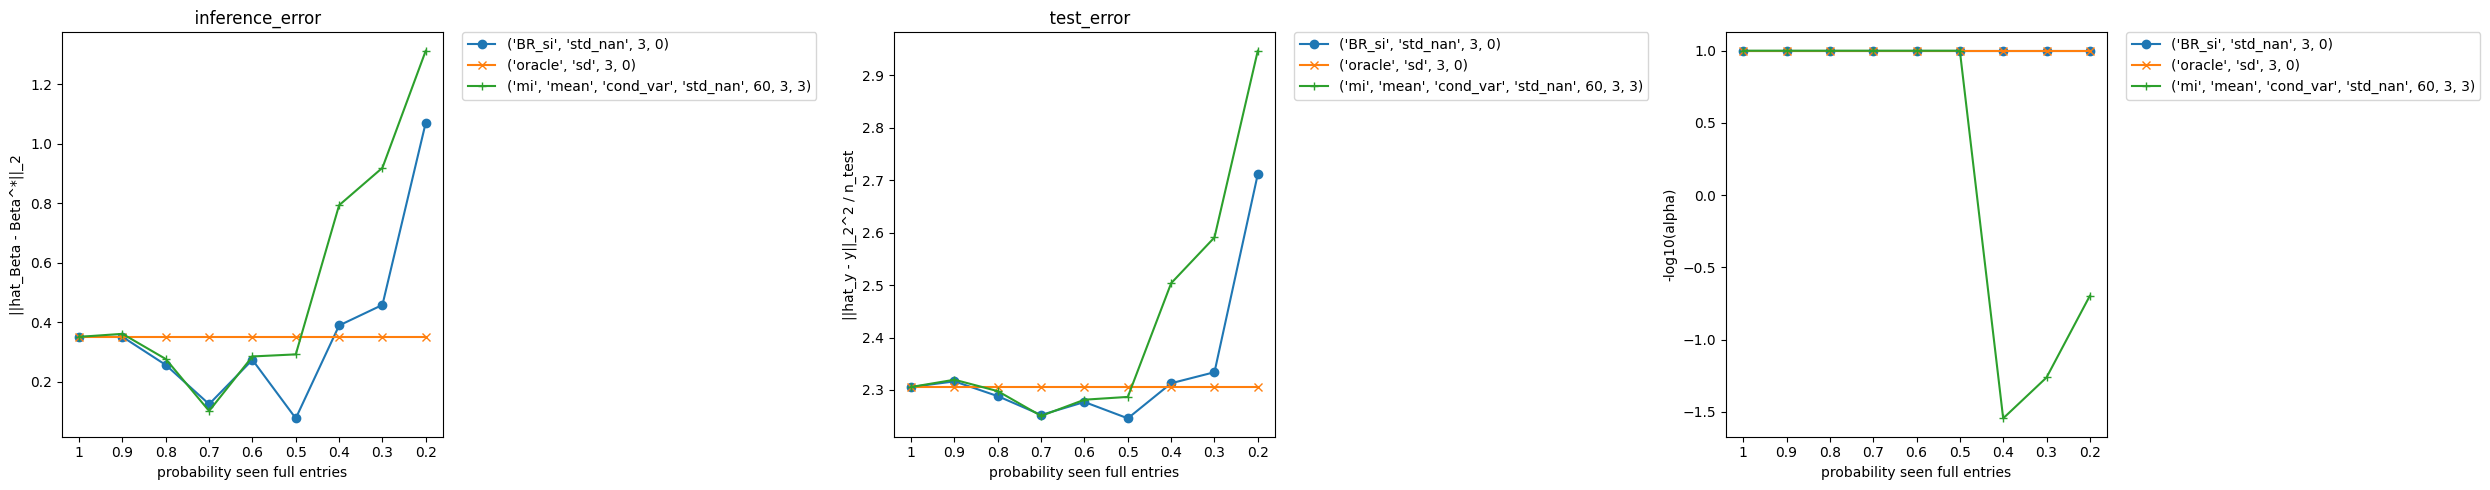

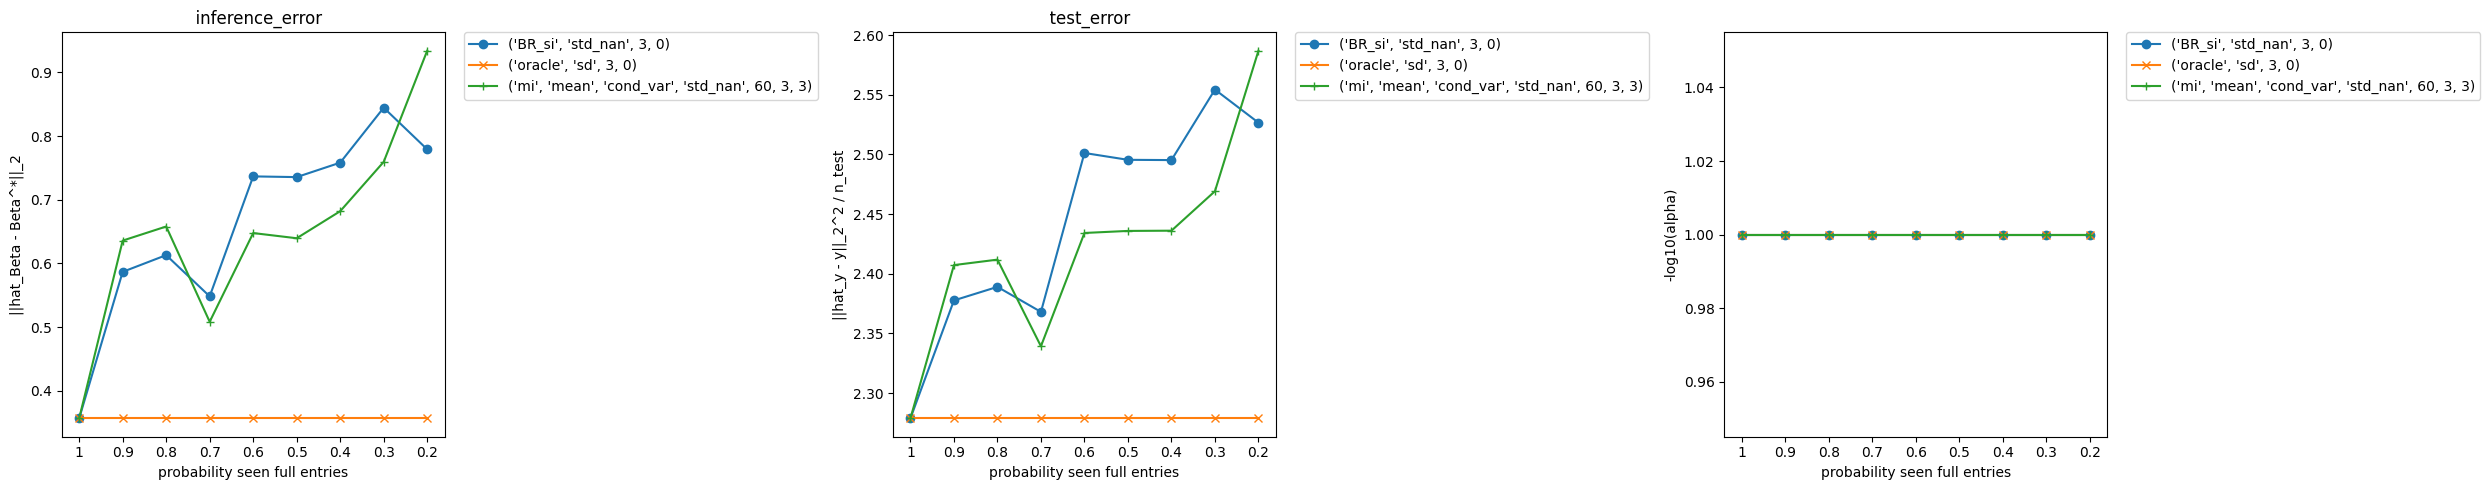

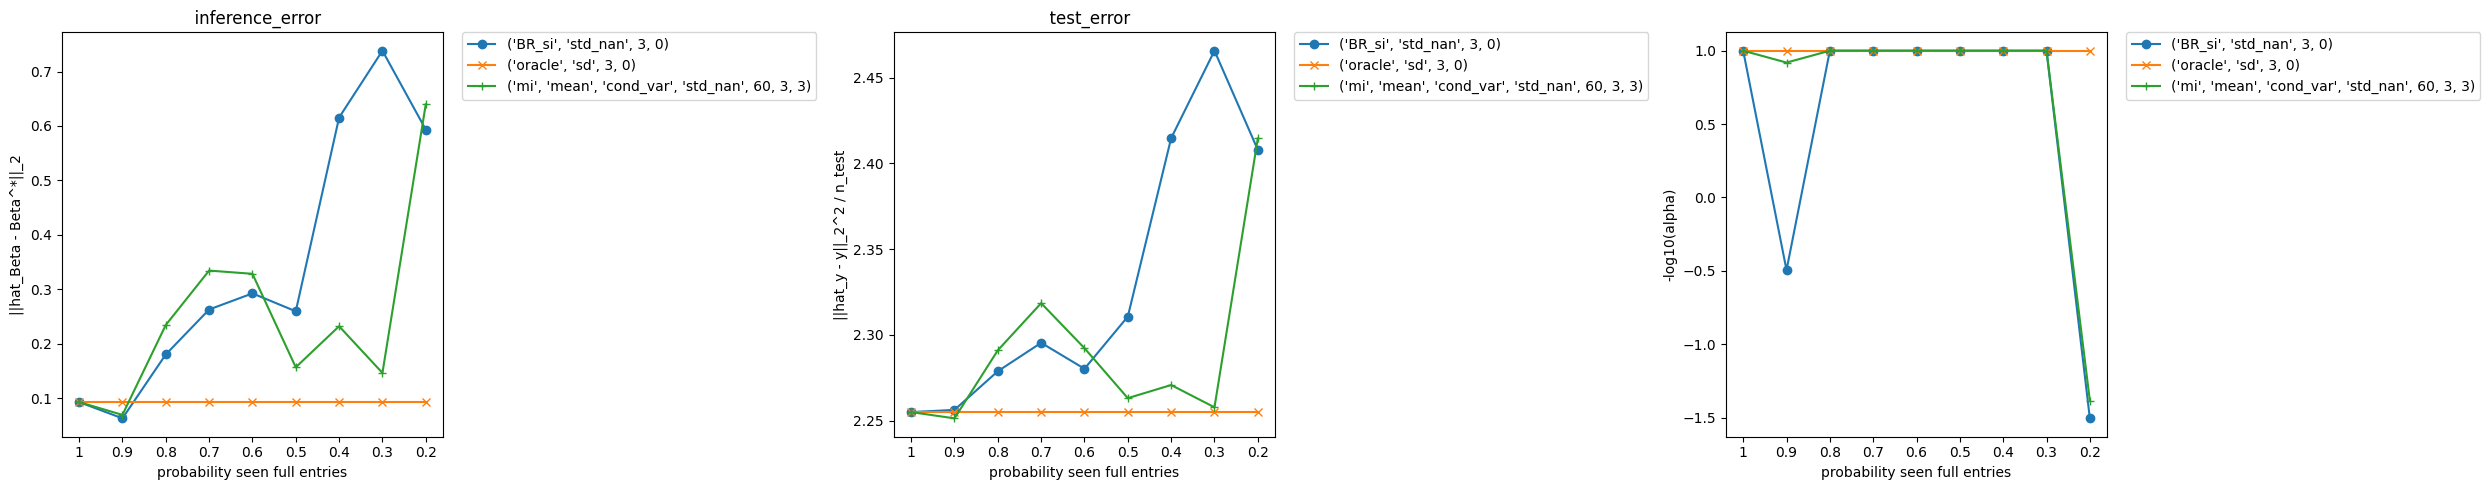

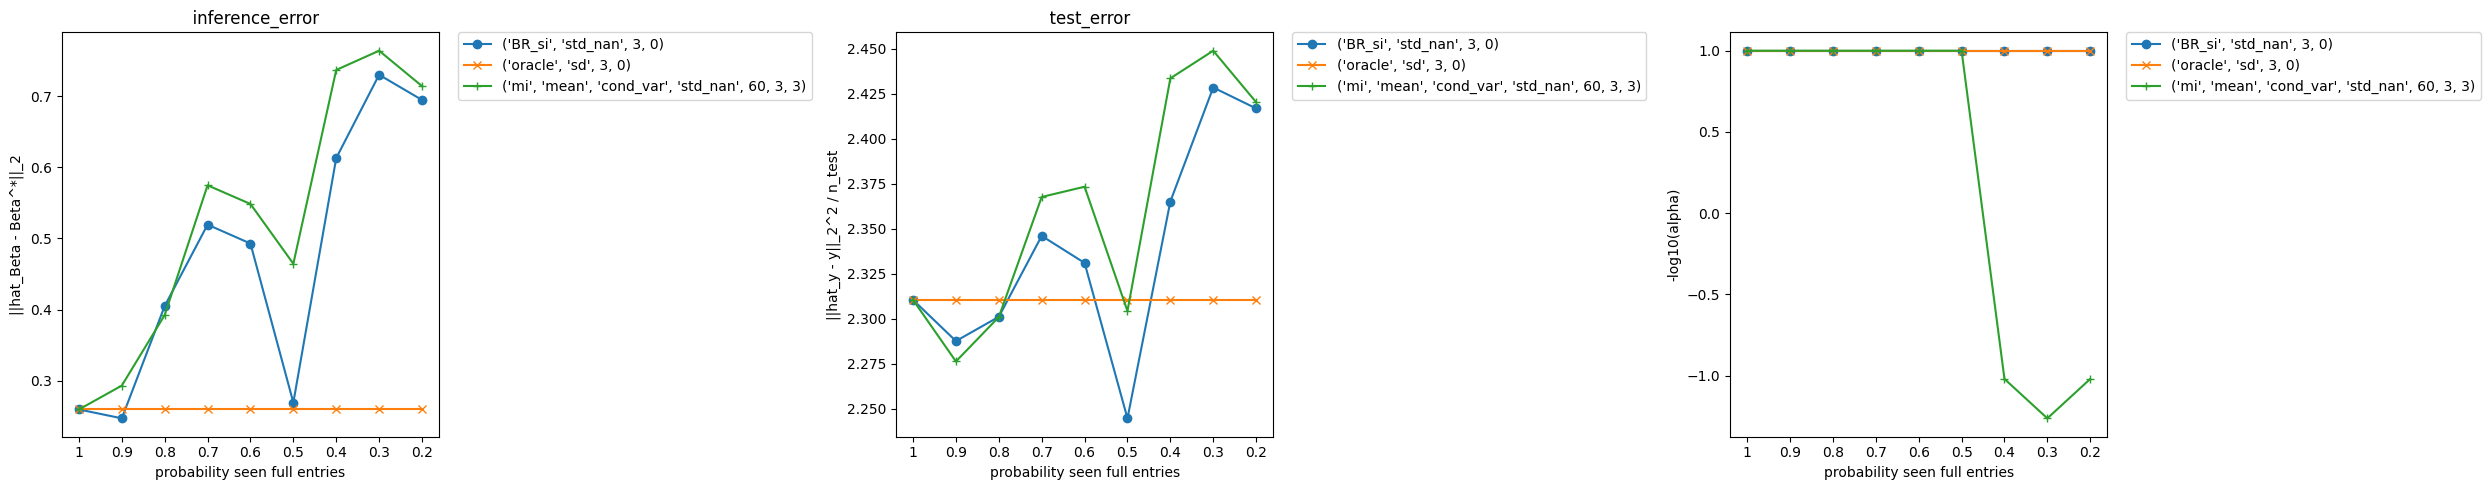

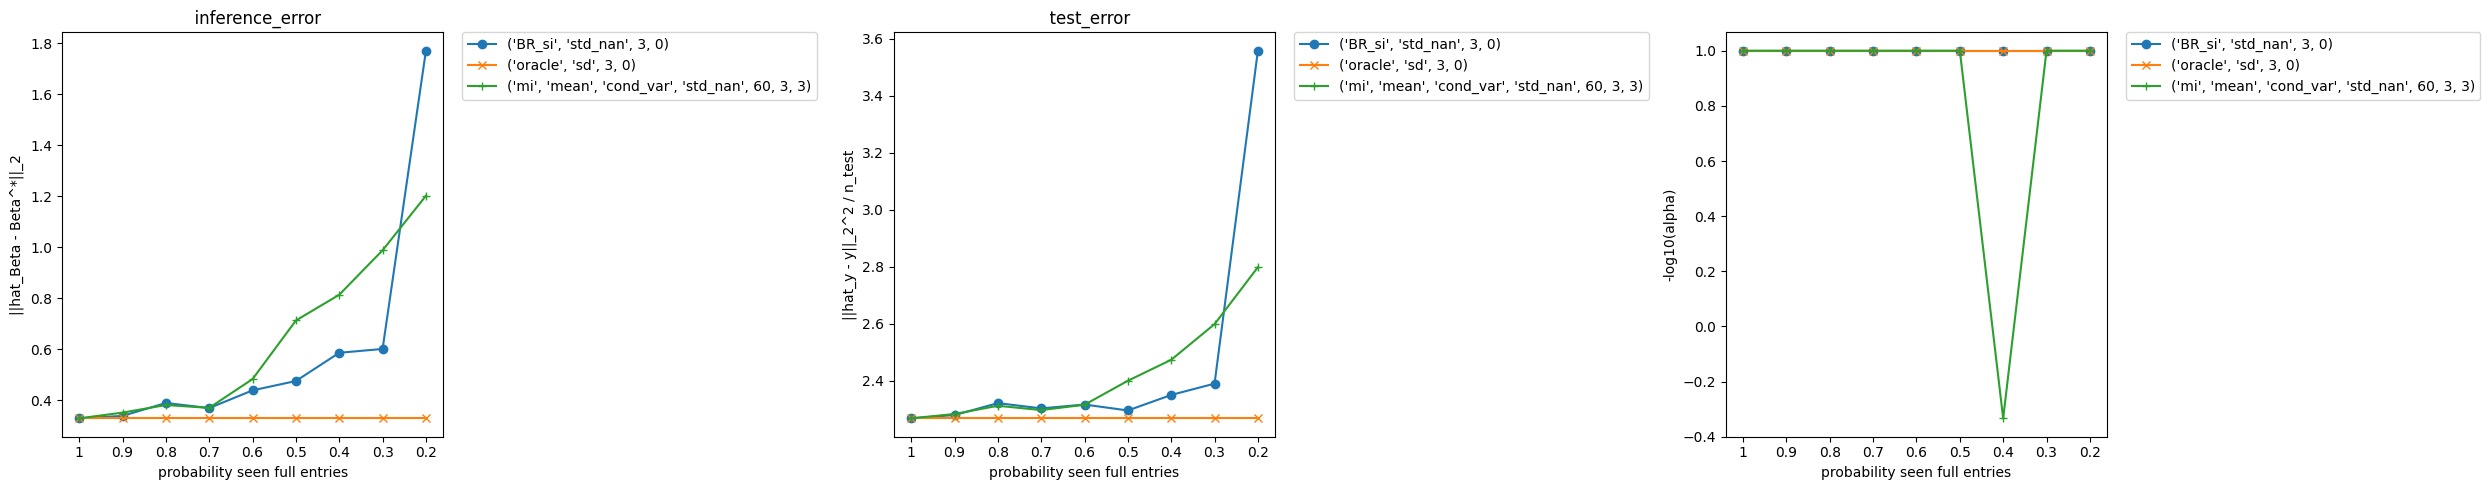

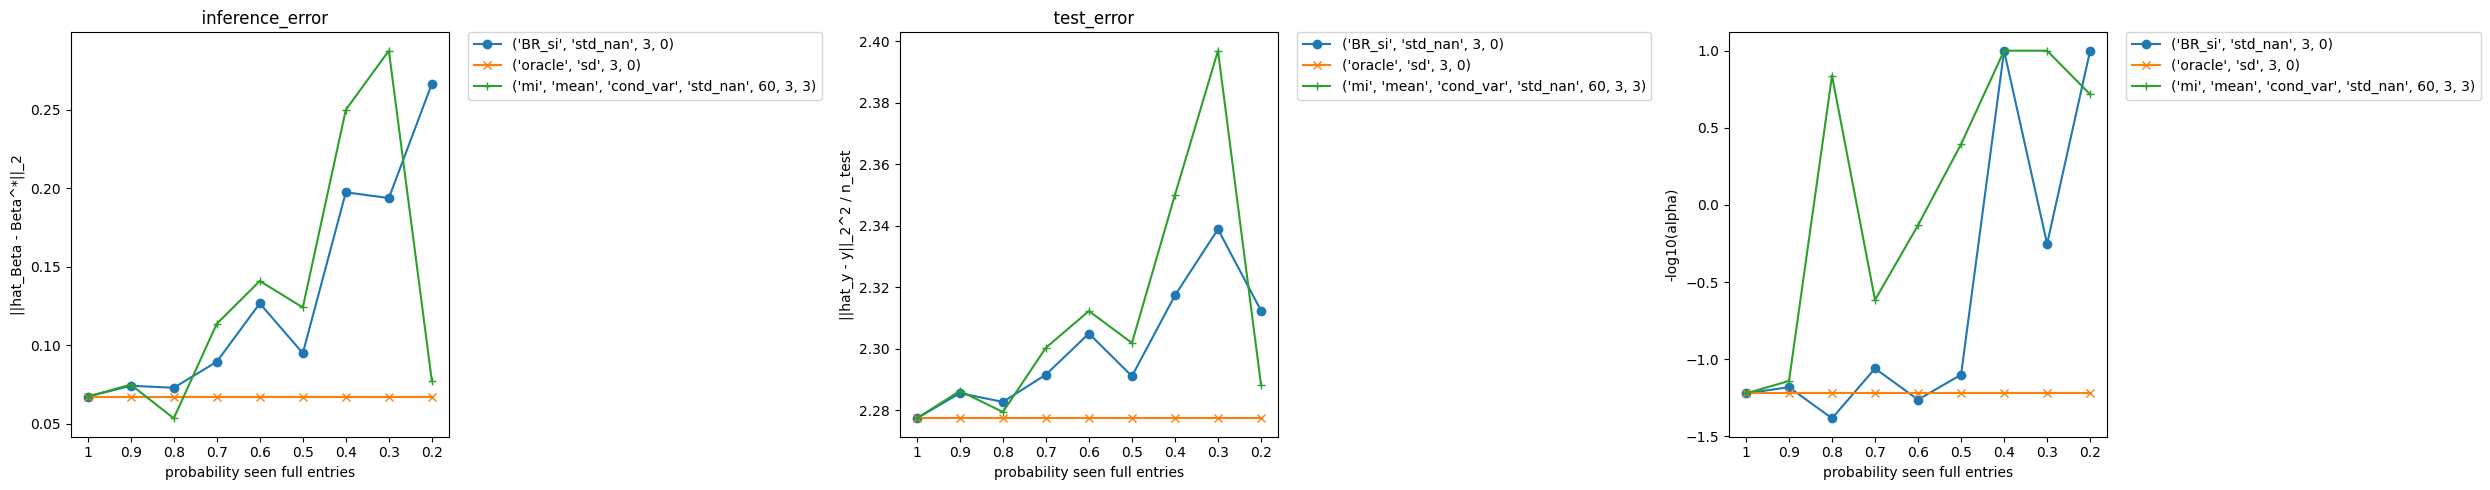

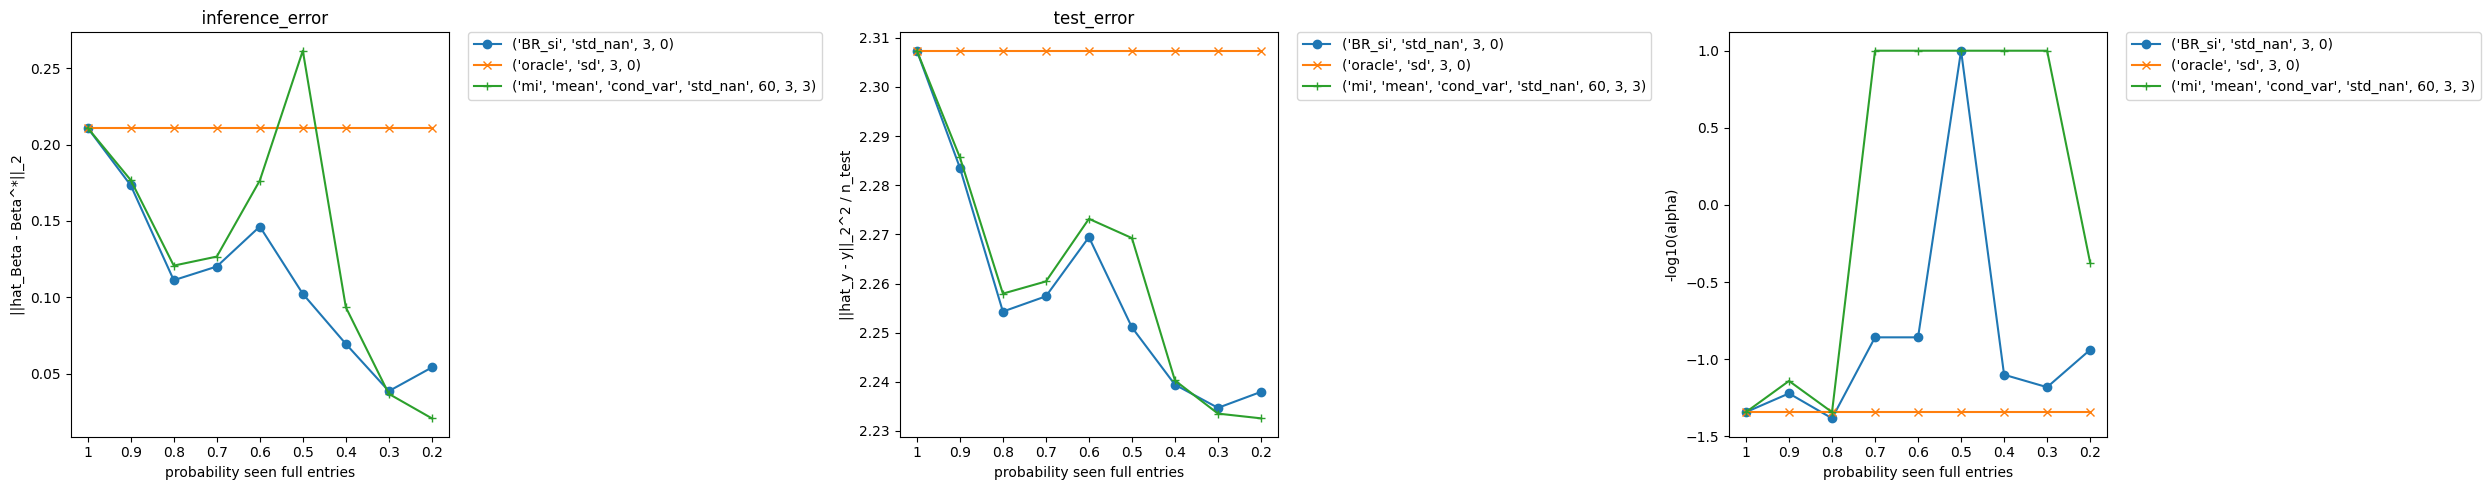

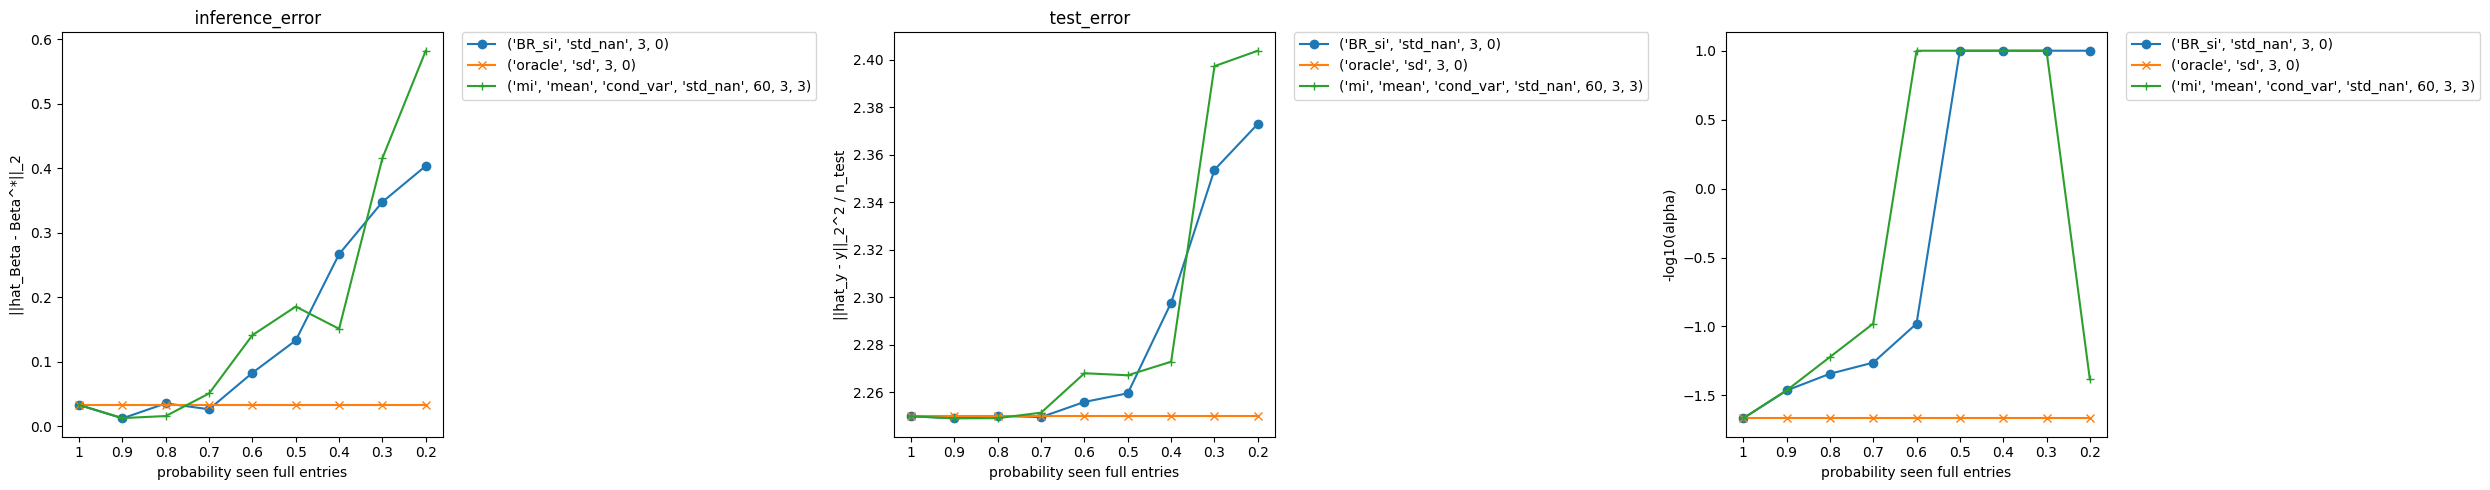

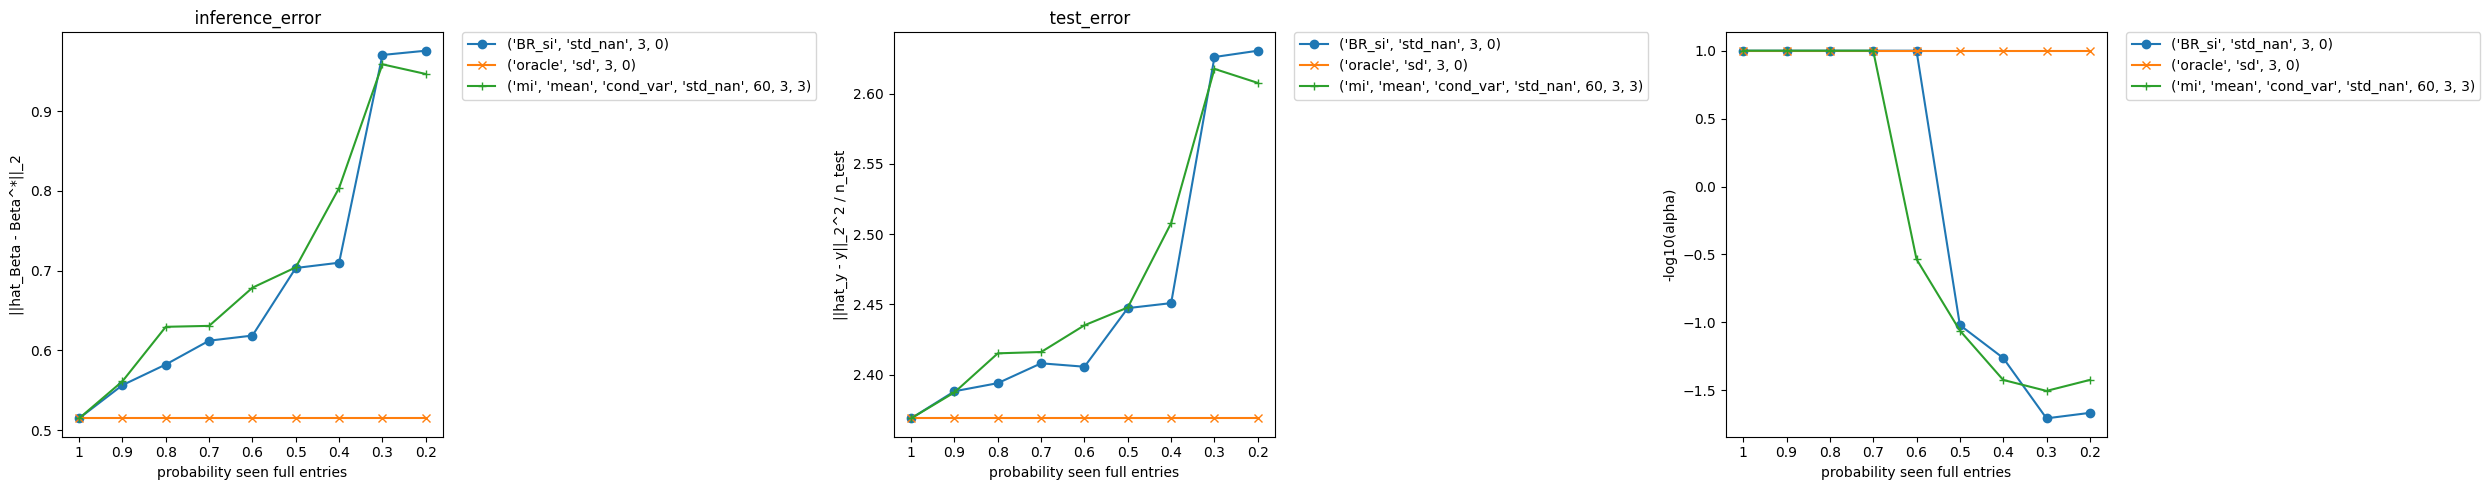

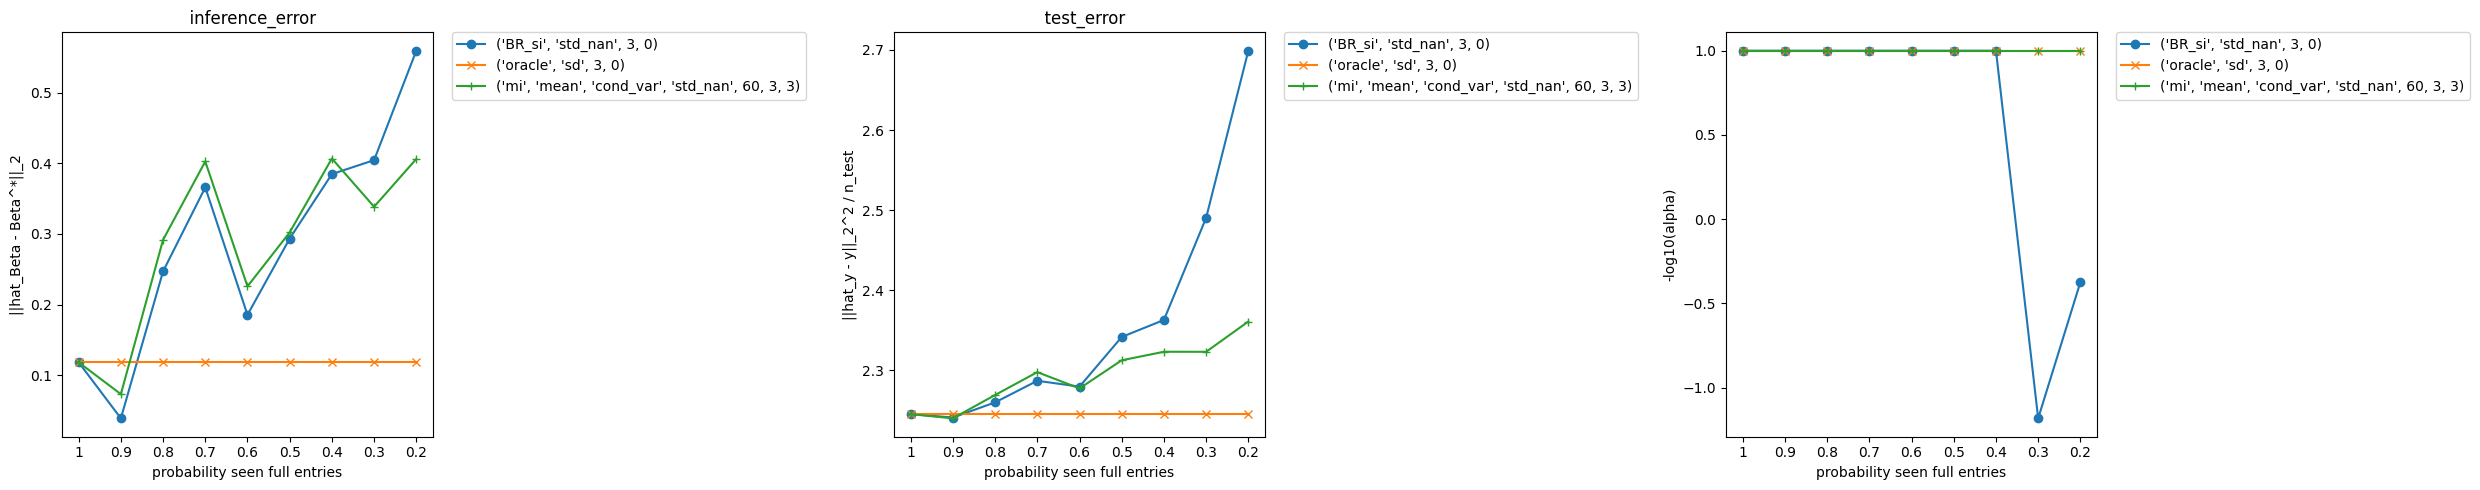

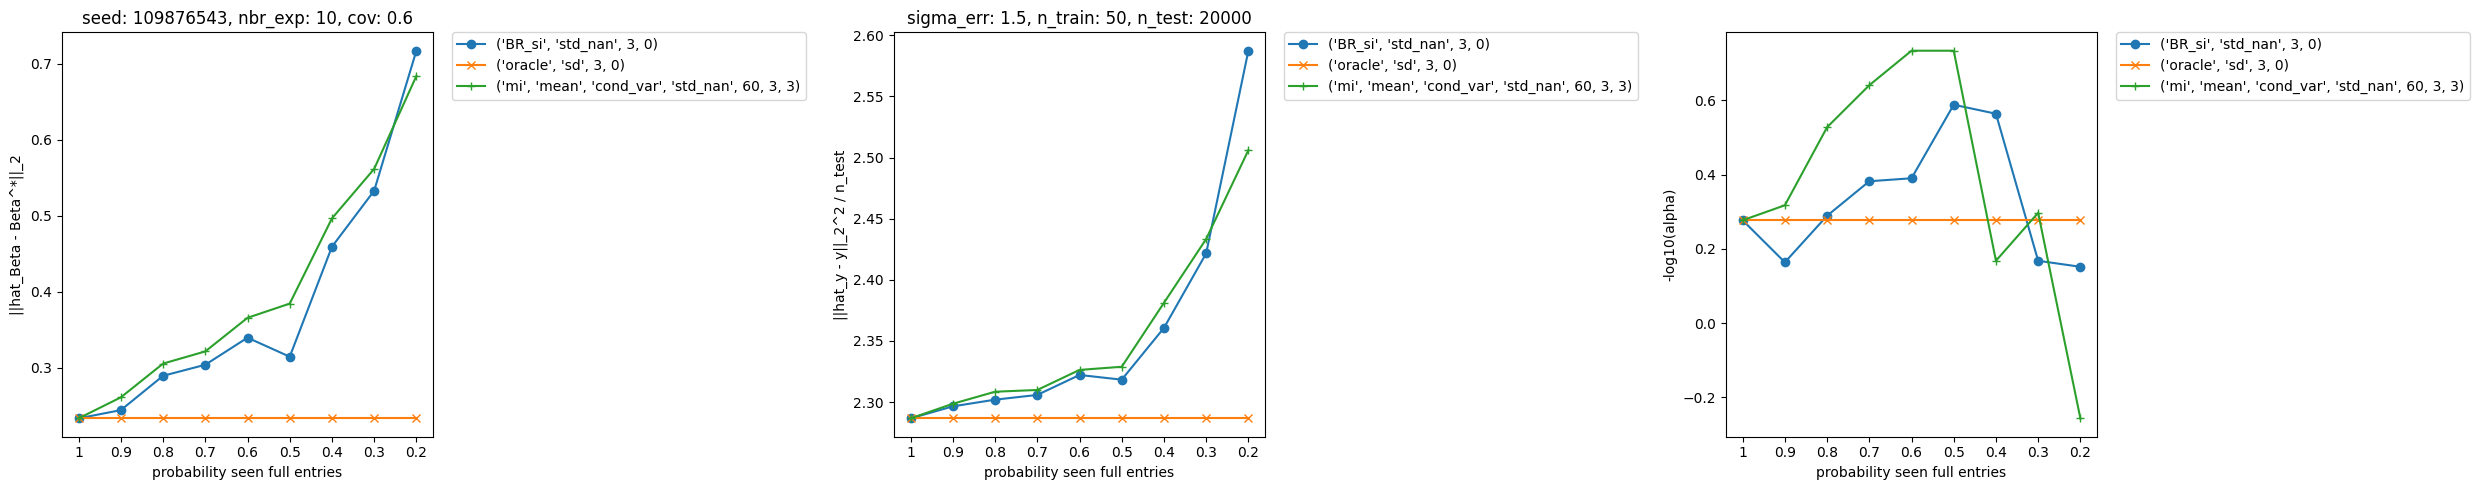

In [8]:

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
gen = 'fixed'
info_axis = 'p_seen'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
#p_seen_both = [0.1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
n_train = [50] * length_vec
error_vec =  [1.5] * length_vec
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)
number_test = 20000
cov_var = 0.6

dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=number_test,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, cov_var], [cov_var, 1]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
    plots = []#['points', 'l1_vs_coef', '1/alpha_vs_coef']
)
#dicc = dicc | {'generation':gen}
dicc = dicc | {'generation':gen, 'title_infer_error':'  inference_error', 'title_test_error':'  test_error'}
for key, value in dicc.items():
  print(key,": " , value[0])

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 60
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'eye', 'mi_nbr': 2},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.2},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.4},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.6},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 1},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_mi', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 1},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 3},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")

'''
nbr_exp = 2
#res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
#res[key_tuple]['best_coeff'].append(coeff_round)
#res[key_tuple]['best_score'].append(score_round)
#res[key_tuple]['best_alpha'].append(alpha_round)
res_l2 = []

rdm_seed = 4654321
np.random.seed(rdm_seed)
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)
if nbr_exp > 1:
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
    print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
    #np.random.seed(rdm_seed * (i+2))
    res_partial = run_experiments(dicc, list_methods_strategy)
    plot_res(info_x_axis, res_partial, dicc)
    print(res)
    for k in res:
      res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
      res[k]['best_score'].append(res_partial[k]['best_score'])
      res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
      #res[k]['best_coeff'].append(res_partial[k]['best_coeff
    #res.append(res['l2_dist_best_coeff_gt'])

print("final ")
print(res)
for k in res:
  print(k)
  print(np.array(res[k]['l2_dist_best_coeff_gt']))
  print(np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
  print(np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
#mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
for k, v in mean_res.items():
  print("k:   ", k)
  for s, t in v.items():
    print(s, ": ", t)
#print(np.mean(res, axis=0))
'''
nbr_exp = 10
seed = 109876543
mean_res = run_multiple_experiments(nbr_exp, seed, dicc, info_x_axis)
print("PLOT OF THE MEANS")
dicc['title_infer_error'] = 'seed: ' + str(seed) + ', nbr_exp: ' + str(nbr_exp) + ', cov: ' + str(cov_var)
dicc['title_test_error'] = 'sigma_err: ' + str(error_vec[0]) + ', n_train: ' + str(n_train[0]) + ', n_test: ' + str(number_test)
#dicc = dicc | {'generation':gen, 'title_infer_error':'mean_infer_error, rep: ' + str(nbr_exp), 'title_mean_error':'mean_test_error'}
plot_res(info_x_axis, mean_res, dicc)

## you can see if you manage to take the index i that maximize alpha




change nbr_experiments to match the size of n_train
data :  {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
n_tot :  20050
n_train :  50
n_test :  20000
dim :  2
beta_gt :  [-0.5  2. ]
perc_test :  0.9975062344139651
err :  {'type': 'Gaussian_on_y', 'scaling': 1}
plots :  []
p_miss :  [1, 0.0, 0.0]
generation :  f
title_infer_error :   
title_test_error :   
[{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}, {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}, {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}]
imp_method :  BR_si
cov_strategy :  std_nan
multip_dataset :  3
multip_missing :  0
imp_method :  oracle
cov_strategy :  sd
multip_dataset :  3
multip_missing :  0
imp_method :  mi
post_imp :  mean
cov_strategy_between :  cond_var
cov_strategy :  std_n

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [00:00<00:00, 256.95it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 262.73it/s]

100%|██████████| 100/100 [00:00<00:00, 269.08it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [00:00<00:00, 257.57it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 260.74it/s]

100%|██████████| 100/100 [00:00<00:00, 260.58it/s]

100%|██████████| 2/2 [00:00<00:00,  2.54it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.024746843448227
---------------------------------> best coeff  [-0.29432572  1.88813933]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 202.03it/s]

 47%|████▋     | 47/100 [00:00<00:00, 231.81it/s]

100%|██████████| 100/100 [00:00<00:00, 256.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 32%|███▏      | 32/100 [00:00<00:00, 310.94it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 296.40it/s]

100%|██████████| 100/100 [00:00<00:00, 269.17it/s]

100%|██████████| 2/2 [00:00<00:00,  2.52it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.024746843448227
---------------------------------> best coeff  [-0.29432572  1.88813933]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -113.78758062239382
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 27%|██▋       | 27/100 [00:00<00:00, 268.72it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 287.56it/s]

100%|██████████| 100/100 [00:00<00:00, 269.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 31%|███       | 31/100 [00:00<00:00, 300.63it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 288.93it/s]

100%|██████████| 100/100 [00:00<00:00, 275.48it/s]

100%|██████████| 2/2 [00:00<00:00,  2.62it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.024746843448232
---------------------------------> best coeff  [-0.29432572  1.88813933]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  0.23924196617163926
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [00:00<00:00, 235.55it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 260.86it/s]

100%|██████████| 100/100 [00:00<00:00, 270.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 28%|██▊       | 28/100 [00:00<00:00, 276.42it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 251.43it/s]

100%|██████████| 100/100 [00:00<00:00, 256.28it/s]

100%|██████████| 2/2 [00:00<00:00,  2.52it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0311583620357354
---------------------------------> best coeff  [-0.2768562   1.91646969]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 188.25it/s]

 47%|████▋     | 47/100 [00:00<00:00, 238.12it/s]

100%|██████████| 100/100 [00:00<00:00, 257.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 28%|██▊       | 28/100 [00:00<00:00, 278.67it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 279.88it/s]

100%|██████████| 100/100 [00:00<00:00, 254.08it/s]

100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.024746843448227
---------------------------------> best coeff  [-0.29432572  1.88813933]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  27.70375677815144
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[3.10052765 0.        ]
 [0.         3.19712675]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.17it/s]

 37%|███▋      | 37/100 [00:00<00:00, 179.92it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 182.25it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 183.19it/s]

100%|██████████| 100/100 [00:00<00:00, 176.99it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.76it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.91it/s]

 38%|███▊      | 38/100 [00:00<00:00, 185.31it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 187.23it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 190.80it/s]

100%|██████████| 100/100 [00:00<00:00, 185.62it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.79it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 193.57it/s]

 40%|████      | 40/100 [00:00<00:00, 183.93it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 181.00it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 172.63it/s]

100%|██████████| 100/100 [00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0320778450747625
---------------------------------> best coeff  [-0.27346589  1.91357236]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  1.1689379998776948
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 138.67it/s]

 31%|███       | 31/100 [00:00<00:00, 155.86it/s]

 50%|█████     | 50/100 [00:00<00:00, 167.82it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 173.96it/s]

100%|██████████| 100/100 [00:00<00:00, 191.11it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 29%|██▉       | 29/100 [00:00<00:00, 286.59it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 267.46it/s]

100%|██████████| 100/100 [00:00<00:00, 263.62it/s]

100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0181401969206518
---------------------------------> best coeff  [-0.32807135  1.94887874]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 143.05it/s]

 44%|████▍     | 44/100 [00:00<00:00, 224.57it/s]

100%|██████████| 100/100 [00:00<00:00, 246.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 29%|██▉       | 29/100 [00:00<00:00, 283.94it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 269.30it/s]

100%|██████████| 100/100 [00:00<00:00, 263.92it/s]

100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.024746843448227
---------------------------------> best coeff  [-0.29432572  1.88813933]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  55.66369435418517
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.06428963 0.        ]
 [0.         3.15334612]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 152.48it/s]

 35%|███▌      | 35/100 [00:00<00:00, 170.72it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 181.36it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 183.13it/s]

100%|██████████| 100/100 [00:00<00:00, 181.01it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.79it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.15it/s]

 37%|███▋      | 37/100 [00:00<00:00, 181.62it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 184.60it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 165.53it/s]

100%|██████████| 100/100 [00:00<00:00, 166.21it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.70it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 181.91it/s]

 38%|███▊      | 38/100 [00:00<00:00, 181.05it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 181.62it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 180.31it/s]

100%|██████████| 100/100 [00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.023748261150155
---------------------------------> best coeff  [-0.30957089  1.95086011]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  2.0078550098809407
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [00:00<00:00, 249.12it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 269.84it/s]

100%|██████████| 100/100 [00:00<00:00, 261.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:00<00:00, 229.97it/s]

 46%|████▌     | 46/100 [00:00<00:00, 192.29it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 179.91it/s]

100%|██████████| 100/100 [00:00<00:00, 173.93it/s]

100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0001229984856843
---------------------------------> best coeff  [-0.43383264  1.95035974]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.69it/s]

 29%|██▉       | 29/100 [00:00<00:00, 144.33it/s]

 44%|████▍     | 44/100 [00:00<00:00, 142.05it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 159.14it/s]

100%|██████████| 100/100 [00:00<00:00, 162.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 163.00it/s]

 37%|███▋      | 37/100 [00:00<00:00, 179.82it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 179.32it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 174.15it/s]

100%|██████████| 100/100 [00:00<00:00, 171.92it/s]

100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.024746843448227
---------------------------------> best coeff  [-0.29432572  1.88813933]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  87.63365432115603
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.82474183 0.        ]
 [0.         3.24343293]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 138.72it/s]

 31%|███       | 31/100 [00:00<00:00, 155.21it/s]

 47%|████▋     | 47/100 [00:00<00:00, 157.32it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 161.20it/s]

100%|██████████| 100/100 [00:00<00:00, 167.85it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.66it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 158.42it/s]

 34%|███▍      | 34/100 [00:00<00:00, 170.87it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 173.96it/s]

 70%|███████   | 70/100 [00:00<00:00, 173.79it/s]

100%|██████████| 100/100 [00:00<00:00, 167.40it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.66it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 182.68it/s]

 38%|███▊      | 38/100 [00:00<00:00, 180.71it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 170.26it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 172.58it/s]

100%|██████████| 100/100 [00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  0.9988510799332633
---------------------------------> best coeff  [-0.44426545  1.97032373]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  6.293480178868424
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [00:00<00:00, 257.29it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 271.81it/s]

100%|██████████| 100/100 [00:00<00:00, 275.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:00<00:00, 226.48it/s]

 51%|█████     | 51/100 [00:00<00:00, 254.37it/s]

100%|██████████| 100/100 [00:00<00:00, 246.62it/s]

100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.011592698264426
---------------------------------> best coeff  [-0.40133863  1.86015755]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 203.44it/s]

 48%|████▊     | 48/100 [00:00<00:00, 239.42it/s]

100%|██████████| 100/100 [00:00<00:00, 249.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 27%|██▋       | 27/100 [00:00<00:00, 262.16it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 259.70it/s]

100%|██████████| 100/100 [00:00<00:00, 246.35it/s]

100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.024746843448227
---------------------------------> best coeff  [-0.29432572  1.88813933]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  364.9490796618162
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.84650718 0.        ]
 [0.         3.30319075]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 166.44it/s]

 34%|███▍      | 34/100 [00:00<00:00, 166.29it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 176.35it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 178.27it/s]

100%|██████████| 100/100 [00:00<00:00, 177.93it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.76it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.13it/s]

 37%|███▋      | 37/100 [00:00<00:00, 178.79it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 183.36it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 182.46it/s]

100%|██████████| 100/100 [00:00<00:00, 180.21it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.77it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 136.29it/s]

 33%|███▎      | 33/100 [00:00<00:00, 164.34it/s]

 51%|█████     | 51/100 [00:00<00:00, 170.52it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 171.04it/s]

100%|██████████| 100/100 [00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0124919769667626
---------------------------------> best coeff  [-0.37731992  1.86186351]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  6.419260704037955
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 204.46it/s]

 51%|█████     | 51/100 [00:00<00:00, 257.28it/s]

100%|██████████| 100/100 [00:00<00:00, 264.16it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [00:00<00:00, 259.79it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 268.06it/s]

100%|██████████| 100/100 [00:00<00:00, 255.92it/s]

100%|██████████| 2/2 [00:00<00:00,  2.48it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  0.9976445320541425
---------------------------------> best coeff  [-0.49749082  1.97331691]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.51it/s]

 43%|████▎     | 43/100 [00:00<00:00, 217.83it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 233.46it/s]

100%|██████████| 100/100 [00:00<00:00, 233.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 29%|██▉       | 29/100 [00:00<00:00, 285.41it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 267.91it/s]

100%|██████████| 100/100 [00:00<00:00, 252.81it/s]

100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.024746843448227
---------------------------------> best coeff  [-0.29432572  1.88813933]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  379.390710650634
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.85237287 0.        ]
 [0.         3.2299401 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.   

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.72it/s]

 31%|███       | 31/100 [00:00<00:00, 153.87it/s]

 49%|████▉     | 49/100 [00:00<00:00, 164.80it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 164.10it/s]

100%|██████████| 100/100 [00:00<00:00, 165.74it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.65it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 160.80it/s]

 34%|███▍      | 34/100 [00:00<00:00, 152.98it/s]

 51%|█████     | 51/100 [00:00<00:00, 159.66it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 164.20it/s]

100%|██████████| 100/100 [00:00<00:00, 165.33it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.64it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 159.06it/s]

 34%|███▍      | 34/100 [00:00<00:00, 170.73it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 168.87it/s]

 70%|███████   | 70/100 [00:00<00:00, 172.33it/s]

100%|██████████| 100/100 [00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0135210920251982
---------------------------------> best coeff  [-0.3465808   1.88662441]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  8.778556603356586
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 207.22it/s]

 48%|████▊     | 48/100 [00:00<00:00, 241.14it/s]

100%|██████████| 100/100 [00:00<00:00, 256.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [00:00<00:00, 243.96it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 262.75it/s]

100%|██████████| 100/100 [00:00<00:00, 255.16it/s]

100%|██████████| 2/2 [00:00<00:00,  2.47it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0193728838772225
---------------------------------> best coeff  [-0.32885839  1.85190982]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 185.75it/s]

 48%|████▊     | 48/100 [00:00<00:00, 245.12it/s]

100%|██████████| 100/100 [00:00<00:00, 244.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [00:00<00:00, 258.39it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 268.81it/s]

100%|██████████| 100/100 [00:00<00:00, 258.62it/s]

100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.024746843448227
---------------------------------> best coeff  [-0.29432572  1.88813933]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  477.0992542404042
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.84892869 0.        ]
 [0.         3.24212003]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.44it/s]

 34%|███▍      | 34/100 [00:00<00:00, 165.54it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 171.47it/s]

 70%|███████   | 70/100 [00:00<00:00, 158.14it/s]

100%|██████████| 100/100 [00:00<00:00, 165.01it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.64it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 154.08it/s]

 34%|███▍      | 34/100 [00:00<00:00, 167.16it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 169.42it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 168.36it/s]

100%|██████████| 100/100 [00:00<00:00, 166.94it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.65it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 174.71it/s]

 36%|███▌      | 36/100 [00:00<00:00, 157.66it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 161.73it/s]

 71%|███████   | 71/100 [00:00<00:00, 167.28it/s]

100%|██████████| 100/100 [00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.1577108973931487
---------------------------------> best coeff  [-2.30364164e-05  1.69331627e+00]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  9.085157814851543
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [00:00<00:00, 232.90it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 269.80it/s]

100%|██████████| 100/100 [00:00<00:00, 272.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [00:00<00:00, 239.27it/s]

 49%|████▉     | 49/100 [00:00<00:00, 244.29it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 234.42it/s]

100%|██████████| 100/100 [00:00<00:00, 236.04it/s]

100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0450580779161198
---------------------------------> best coeff  [-0.26116051  1.76259349]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 189.30it/s]

 47%|████▋     | 47/100 [00:00<00:00, 238.49it/s]

100%|██████████| 100/100 [00:00<00:00, 255.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [00:00<00:00, 253.99it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 249.29it/s]

100%|██████████| 100/100 [00:00<00:00, 243.20it/s]

100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.024746843448227
---------------------------------> best coeff  [-0.29432572  1.88813933]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  472.6154406500838
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.87983109 0.        ]
 [0.         3.13375892]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 81.96it/s]

 20%|██        | 20/100 [00:00<00:00, 94.35it/s]

 31%|███       | 31/100 [00:00<00:00, 97.71it/s]

 42%|████▏     | 42/100 [00:00<00:00, 99.89it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 98.85it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 103.49it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 106.67it/s]

100%|██████████| 100/100 [00:00<00:00, 105.41it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.05it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.54it/s]

 24%|██▍       | 24/100 [00:00<00:00, 107.20it/s]

 35%|███▌      | 35/100 [00:00<00:00, 106.55it/s]

 47%|████▋     | 47/100 [00:00<00:00, 110.53it/s]

 60%|██████    | 60/100 [00:00<00:00, 115.75it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 112.09it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 113.18it/s]

100%|██████████| 100/100 [00:00<00:00, 109.71it/s]

 67%|██████▋   | 2/3

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.2032742601349635
---------------------------------> best coeff  [0.05168305 1.57152144]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  10.885404504020737
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 217.11it/s]

 48%|████▊     | 48/100 [00:00<00:00, 240.75it/s]

100%|██████████| 100/100 [00:00<00:00, 257.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [00:00<00:00, 238.85it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 259.53it/s]

100%|██████████| 100/100 [00:00<00:00, 249.11it/s]

100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.2769286127387272
---------------------------------> best coeff  [0.06620463 1.39462994]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.15it/s]

 46%|████▌     | 46/100 [00:00<00:00, 237.32it/s]

 70%|███████   | 70/100 [00:00<00:00, 232.76it/s]

100%|██████████| 100/100 [00:00<00:00, 231.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [00:00<00:00, 237.11it/s]

 51%|█████     | 51/100 [00:00<00:00, 254.07it/s]

100%|██████████| 100/100 [00:00<00:00, 252.81it/s]

100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.024746843448227
---------------------------------> best coeff  [-0.29432572  1.88813933]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  519.2234015464164
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.87069837 0.        ]
 [0.         3.19813978]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 144.27it/s]

 33%|███▎      | 33/100 [00:00<00:00, 162.94it/s]

 51%|█████     | 51/100 [00:00<00:00, 166.65it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 169.59it/s]

100%|██████████| 100/100 [00:00<00:00, 164.06it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.63it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 136.42it/s]

 28%|██▊       | 28/100 [00:00<00:00, 123.44it/s]

 41%|████      | 41/100 [00:00<00:00, 120.21it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 113.91it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 114.30it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 113.08it/s]

100%|██████████| 100/100 [00:00<00:00, 114.47it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.30it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 121.10it/s]

 26%|██▌       | 26/100 [00:00<00:00, 111.83it/s]

 38%|███▊      | 38/100 [00:

best alpha ---->  3.764935806792469
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.76493581e+00 1.00000000e-03 1.00000000e-03] , min score  1.5086963709098333
---------------------------------> best coeff  [0.33198463 1.24050237]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.29432572,  1.88813933]), array([-0.2768562 ,  1.91646969]), array([-0.32807135,  1.94887874]), array([-0.43383264,  1.95035974]), array([-0.40133863,  1.86015755]), array([-0.49749082,  1.97331691]), array([-0.32885839,  1.85190982]), array([-0.26116051,  1.76259349]), array([0.06620463, 1.39462994])], 'l2_dist_best_coeff_gt': [np.float64(0.2341254335247991), np.float64(0.238265538580697), np.float64(0.17936790404732003), np.float64(0.08271804498698689), np.float64(0.17114314887836904), n

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [00:00<00:00, 237.78it/s]

 51%|█████     | 51/100 [00:00<00:00, 256.38it/s]

100%|██████████| 100/100 [00:00<00:00, 261.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [00:00<00:00, 238.05it/s]

 48%|████▊     | 48/100 [00:00<00:00, 209.05it/s]

 71%|███████   | 71/100 [00:00<00:00, 217.13it/s]

100%|██████████| 100/100 [00:00<00:00, 221.70it/s]

100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0128306607495081
---------------------------------> best coeff  [-0.38530695  1.79163721]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 199.77it/s]

 47%|████▋     | 47/100 [00:00<00:00, 240.66it/s]

100%|██████████| 100/100 [00:00<00:00, 258.18it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [00:00<00:00, 243.08it/s]

 50%|█████     | 50/100 [00:00<00:00, 243.01it/s]

100%|██████████| 100/100 [00:00<00:00, 237.97it/s]

100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0128306607495081
---------------------------------> best coeff  [-0.38530695  1.79163721]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  764.3226245443439
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 157.38it/s]

 33%|███▎      | 33/100 [00:00<00:00, 164.19it/s]

 51%|█████     | 51/100 [00:00<00:00, 165.82it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 159.58it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 156.33it/s]

100%|██████████| 100/100 [00:00<00:00, 156.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 168.57it/s]

 34%|███▍      | 34/100 [00:00<00:00, 162.50it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 168.55it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 155.85it/s]

100%|██████████| 100/100 [00:00<00:00, 150.36it/s]

100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0128306607495088
---------------------------------> best coeff  [-0.38530695  1.79163721]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  10.676688109818258
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.62it/s]

 25%|██▌       | 25/100 [00:00<00:00, 121.52it/s]

 41%|████      | 41/100 [00:00<00:00, 137.64it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 138.29it/s]

 70%|███████   | 70/100 [00:00<00:00, 140.29it/s]

100%|██████████| 100/100 [00:00<00:00, 140.17it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.86it/s]

 32%|███▏      | 32/100 [00:00<00:00, 156.02it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 197.83it/s]

100%|██████████| 100/100 [00:00<00:00, 200.58it/s]

100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.057927703573147
---------------------------------> best coeff  [-0.28336052  1.66817339]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 196.25it/s]

 46%|████▌     | 46/100 [00:00<00:00, 230.17it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 241.78it/s]

100%|██████████| 100/100 [00:00<00:00, 244.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 216.21it/s]

 49%|████▉     | 49/100 [00:00<00:00, 243.15it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 247.41it/s]

100%|██████████| 100/100 [00:00<00:00, 240.96it/s]

100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0128306607495081
---------------------------------> best coeff  [-0.38530695  1.79163721]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  606.0169373757058
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.68030423 0.        ]
 [0.         2.80341411]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 129.02it/s]

 26%|██▌       | 26/100 [00:00<00:00, 128.63it/s]

 44%|████▍     | 44/100 [00:00<00:00, 149.00it/s]

 60%|██████    | 60/100 [00:00<00:00, 153.06it/s]

 80%|████████  | 80/100 [00:00<00:00, 167.63it/s]

100%|██████████| 100/100 [00:00<00:00, 156.51it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.55it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 161.52it/s]

 34%|███▍      | 34/100 [00:00<00:00, 161.45it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 170.91it/s]

 71%|███████   | 71/100 [00:00<00:00, 172.37it/s]

100%|██████████| 100/100 [00:00<00:00, 165.04it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.60it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 148.49it/s]

 33%|███▎      | 33/100 [00:00<00:00, 163.47it/s]

 51%|█████     | 51/100 [00:00<00:00, 170.15it/s]

 69%|██████▉   | 69/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0750939044380945
---------------------------------> best coeff  [-0.26657348  1.63122092]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  8.972862196748004
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.91it/s]

 30%|███       | 30/100 [00:00<00:00, 151.94it/s]

 47%|████▋     | 47/100 [00:00<00:00, 158.30it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 149.93it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 151.84it/s]

100%|██████████| 100/100 [00:00<00:00, 150.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 152.25it/s]

 34%|███▍      | 34/100 [00:00<00:00, 164.43it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 174.34it/s]

 71%|███████   | 71/100 [00:00<00:00, 175.18it/s]

100%|██████████| 100/100 [00:00<00:00, 162.82it/s]

100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0640342450463083
---------------------------------> best coeff  [-0.25584846  1.65675956]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 74.39it/s]

 23%|██▎       | 23/100 [00:00<00:00, 115.16it/s]

 42%|████▏     | 42/100 [00:00<00:00, 145.35it/s]

 60%|██████    | 60/100 [00:00<00:00, 156.33it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 167.21it/s]

100%|██████████| 100/100 [00:00<00:00, 156.17it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 130.35it/s]

 29%|██▉       | 29/100 [00:00<00:00, 139.40it/s]

 45%|████▌     | 45/100 [00:00<00:00, 146.64it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 155.42it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 153.44it/s]

100%|██████████| 100/100 [00:00<00:00, 145.45it/s]

100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0128306607495081
---------------------------------> best coeff  [-0.38530695  1.79163721]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  535.4834949774108
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.70970962 0.        ]
 [0.         2.81567946]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.77it/s]

 30%|███       | 30/100 [00:00<00:00, 152.00it/s]

 47%|████▋     | 47/100 [00:00<00:00, 156.36it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 156.94it/s]

 81%|████████  | 81/100 [00:00<00:00, 162.55it/s]

100%|██████████| 100/100 [00:00<00:00, 159.67it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.58it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 116.23it/s]

 29%|██▉       | 29/100 [00:00<00:00, 147.39it/s]

 46%|████▌     | 46/100 [00:00<00:00, 156.18it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 164.49it/s]

 81%|████████  | 81/100 [00:00<00:00, 165.20it/s]

100%|██████████| 100/100 [00:00<00:00, 157.06it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.56it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 143.38it/s]

 32%|███▏      | 32/100 [00:00<00:00, 155.76it/s]

 49%|████▉     | 49/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0786051250304722
---------------------------------> best coeff  [-0.22019323  1.62957009]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  9.851044293250897
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 186.10it/s]

 46%|████▌     | 46/100 [00:00<00:00, 233.42it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 244.89it/s]

100%|██████████| 100/100 [00:00<00:00, 244.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 184.55it/s]

 47%|████▋     | 47/100 [00:00<00:00, 236.56it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 250.37it/s]

100%|██████████| 100/100 [00:00<00:00, 240.99it/s]

100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0574298961662598
---------------------------------> best coeff  [-0.30091655  1.66893422]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 125.50it/s]

 34%|███▍      | 34/100 [00:00<00:00, 173.68it/s]

 61%|██████    | 61/100 [00:00<00:00, 210.03it/s]

100%|██████████| 100/100 [00:00<00:00, 180.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 129.73it/s]

 32%|███▏      | 32/100 [00:00<00:00, 160.76it/s]

 49%|████▉     | 49/100 [00:00<00:00, 159.06it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 166.66it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 155.31it/s]

100%|██████████| 100/100 [00:00<00:00, 148.07it/s]

100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0128306607495081
---------------------------------> best coeff  [-0.38530695  1.79163721]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  629.9689748342389
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.67469437 0.        ]
 [0.         2.81567946]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 134.03it/s]

 30%|███       | 30/100 [00:00<00:00, 147.20it/s]

 45%|████▌     | 45/100 [00:00<00:00, 146.86it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 153.20it/s]

 80%|████████  | 80/100 [00:00<00:00, 160.13it/s]

100%|██████████| 100/100 [00:00<00:00, 154.07it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.53it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.61it/s]

 32%|███▏      | 32/100 [00:00<00:00, 155.84it/s]

 50%|█████     | 50/100 [00:00<00:00, 164.94it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 164.10it/s]

100%|██████████| 100/100 [00:00<00:00, 164.55it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.59it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.38it/s]

 28%|██▊       | 28/100 [00:00<00:00, 140.95it/s]

 45%|████▌     | 45/100 [00:00<00:00, 151.55it/s]

 61%|██████    | 61/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0429038971720554
---------------------------------> best coeff  [-0.29430324  1.70491939]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  7.322885849578515
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:00<00:00, 226.44it/s]

 50%|█████     | 50/100 [00:00<00:00, 251.24it/s]

100%|██████████| 100/100 [00:00<00:00, 254.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.35it/s]

 43%|████▎     | 43/100 [00:00<00:00, 220.88it/s]

 71%|███████   | 71/100 [00:00<00:00, 244.37it/s]

100%|██████████| 100/100 [00:00<00:00, 227.53it/s]

100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.1284720942337254
---------------------------------> best coeff  [-0.26386471  1.53814016]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 138.50it/s]

 40%|████      | 40/100 [00:00<00:00, 206.67it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 227.68it/s]

100%|██████████| 100/100 [00:00<00:00, 220.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 162.83it/s]

 39%|███▉      | 39/100 [00:00<00:00, 195.60it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 220.08it/s]

100%|██████████| 100/100 [00:00<00:00, 214.59it/s]

100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0128306607495081
---------------------------------> best coeff  [-0.38530695  1.79163721]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  481.91107981845505
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.6733122  0.        ]
 [0.         2.93648392]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 108.98it/s]

 25%|██▌       | 25/100 [00:00<00:00, 126.07it/s]

 42%|████▏     | 42/100 [00:00<00:00, 144.61it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 150.51it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 160.55it/s]

100%|██████████| 100/100 [00:00<00:00, 151.73it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.51it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.25it/s]

 32%|███▏      | 32/100 [00:00<00:00, 155.20it/s]

 50%|█████     | 50/100 [00:00<00:00, 163.13it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 164.00it/s]

100%|██████████| 100/100 [00:00<00:00, 158.98it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.54it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 164.10it/s]

 34%|███▍      | 34/100 [00:00<00:00, 162.84it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 167.26it/s]

 70%|███████   | 70/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0923098964855453
---------------------------------> best coeff  [-0.27277769  1.59820961]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  8.525374679163246
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 214.19it/s]

 48%|████▊     | 48/100 [00:00<00:00, 238.56it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 245.51it/s]

100%|██████████| 100/100 [00:00<00:00, 237.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.86it/s]

 44%|████▍     | 44/100 [00:00<00:00, 222.62it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 247.17it/s]

100%|██████████| 100/100 [00:00<00:00, 231.40it/s]

100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.1226634804875681
---------------------------------> best coeff  [-0.26651747  1.54731163]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.35it/s]

 39%|███▉      | 39/100 [00:00<00:00, 197.50it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 228.41it/s]

100%|██████████| 100/100 [00:00<00:00, 216.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 186.99it/s]

 46%|████▌     | 46/100 [00:00<00:00, 232.42it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 250.93it/s]

100%|██████████| 100/100 [00:00<00:00, 237.71it/s]

100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0128306607495081
---------------------------------> best coeff  [-0.38530695  1.79163721]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  508.7146750155604
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.69894083 0.        ]
 [0.         3.03383337]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.87it/s]

 30%|███       | 30/100 [00:00<00:00, 151.11it/s]

 48%|████▊     | 48/100 [00:00<00:00, 160.72it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 163.14it/s]

100%|██████████| 100/100 [00:00<00:00, 164.00it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.63it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 149.46it/s]

 30%|███       | 30/100 [00:00<00:00, 139.79it/s]

 48%|████▊     | 48/100 [00:00<00:00, 156.01it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 159.65it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 162.30it/s]

100%|██████████| 100/100 [00:00<00:00, 159.30it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.59it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 144.46it/s]

 33%|███▎      | 33/100 [00:00<00:00, 160.65it/s]

 50%|█████     | 50/100 [00:00<00:00, 164.46it/s]

 68%|██████▊   | 68/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0933167021976764
---------------------------------> best coeff  [-0.29469018  1.59869696]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  6.614963519041943
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 213.79it/s]

 49%|████▉     | 49/100 [00:00<00:00, 244.02it/s]

100%|██████████| 100/100 [00:00<00:00, 249.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 170.61it/s]

 45%|████▌     | 45/100 [00:00<00:00, 224.87it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 228.65it/s]

100%|██████████| 100/100 [00:00<00:00, 221.09it/s]

100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.1132024507963678
---------------------------------> best coeff  [-0.23729497  1.56020747]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 136.21it/s]

 40%|████      | 40/100 [00:00<00:00, 206.88it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 224.44it/s]

100%|██████████| 100/100 [00:00<00:00, 224.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 187.84it/s]

 44%|████▍     | 44/100 [00:00<00:00, 223.01it/s]

 70%|███████   | 70/100 [00:00<00:00, 239.63it/s]

100%|██████████| 100/100 [00:00<00:00, 229.75it/s]

100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0128306607495081
---------------------------------> best coeff  [-0.38530695  1.79163721]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  397.17708597955027
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.78522612 0.        ]
 [0.         3.00602071]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.10it/s]

 27%|██▋       | 27/100 [00:00<00:00, 135.03it/s]

 43%|████▎     | 43/100 [00:00<00:00, 145.66it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 147.11it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 156.71it/s]

100%|██████████| 100/100 [00:00<00:00, 151.50it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.51it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 142.96it/s]

 30%|███       | 30/100 [00:00<00:00, 136.75it/s]

 46%|████▌     | 46/100 [00:00<00:00, 145.83it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 155.96it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 163.42it/s]

100%|██████████| 100/100 [00:00<00:00, 155.89it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.53it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 138.74it/s]

 31%|███       | 31/100 [00:00<00:00, 154.70it/s]

 49%|████▉     | 49/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0966960517190365
---------------------------------> best coeff  [-0.20865623  1.59258839]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  6.569708423167516
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 217.34it/s]

 48%|████▊     | 48/100 [00:00<00:00, 241.17it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 242.22it/s]

100%|██████████| 100/100 [00:00<00:00, 240.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 185.69it/s]

 45%|████▌     | 45/100 [00:00<00:00, 227.06it/s]

 71%|███████   | 71/100 [00:00<00:00, 240.70it/s]

100%|██████████| 100/100 [00:00<00:00, 226.21it/s]

100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.1325493485109934
---------------------------------> best coeff  [-0.21298589  1.52804373]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 114.53it/s]

 37%|███▋      | 37/100 [00:00<00:00, 190.66it/s]

 60%|██████    | 60/100 [00:00<00:00, 207.65it/s]

100%|██████████| 100/100 [00:00<00:00, 213.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 189.13it/s]

 43%|████▎     | 43/100 [00:00<00:00, 215.94it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 232.38it/s]

100%|██████████| 100/100 [00:00<00:00, 221.42it/s]

100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0128306607495081
---------------------------------> best coeff  [-0.38530695  1.79163721]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  464.0733181108758
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.83125665 0.        ]
 [0.         3.08810026]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 79.80it/s]

 23%|██▎       | 23/100 [00:00<00:00, 119.04it/s]

 41%|████      | 41/100 [00:00<00:00, 143.95it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 141.99it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 156.59it/s]

100%|██████████| 100/100 [00:00<00:00, 147.67it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.47it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 144.71it/s]

 32%|███▏      | 32/100 [00:00<00:00, 158.66it/s]

 50%|█████     | 50/100 [00:00<00:00, 167.32it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 169.20it/s]

100%|██████████| 100/100 [00:00<00:00, 165.87it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.57it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.19it/s]

 32%|███▏      | 32/100 [00:00<00:00, 151.38it/s]

 49%|████▉     | 49/100 [00:00<00:00, 157.78it/s]

 67%|██████▋   | 67/100 [00:00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.123420080783651
---------------------------------> best coeff  [-0.12388222  1.5623488 ]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  6.047915659791714
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 186.22it/s]

 46%|████▌     | 46/100 [00:00<00:00, 230.91it/s]

 70%|███████   | 70/100 [00:00<00:00, 234.37it/s]

100%|██████████| 100/100 [00:00<00:00, 214.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 166.34it/s]

 41%|████      | 41/100 [00:00<00:00, 206.72it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 230.01it/s]

100%|██████████| 100/100 [00:00<00:00, 216.07it/s]

100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.1022563393823286
---------------------------------> best coeff  [-0.29806128  1.58427664]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.67it/s]

 39%|███▉      | 39/100 [00:00<00:00, 203.27it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 226.54it/s]

100%|██████████| 100/100 [00:00<00:00, 210.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 195.03it/s]

 46%|████▌     | 46/100 [00:00<00:00, 230.93it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 248.50it/s]

100%|██████████| 100/100 [00:00<00:00, 232.38it/s]

100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0128306607495081
---------------------------------> best coeff  [-0.38530695  1.79163721]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  551.9724359092979
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.89710197 0.        ]
 [0.         3.1931384 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:00<00:01, 69.00it/s]

 16%|█▌        | 16/100 [00:00<00:01, 79.08it/s]

 25%|██▌       | 25/100 [00:00<00:00, 81.48it/s]

 34%|███▍      | 34/100 [00:00<00:00, 84.23it/s]

 44%|████▍     | 44/100 [00:00<00:00, 88.38it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 94.95it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 96.51it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 101.26it/s]

100%|██████████| 100/100 [00:01<00:00, 98.98it/s]

 33%|███▎      | 1/3 [00:01<00:02,  1.01s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.74it/s]

 28%|██▊       | 28/100 [00:00<00:00, 129.21it/s]

 45%|████▌     | 45/100 [00:00<00:00, 145.73it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 157.07it/s]

 80%|████████  | 80/100 [00:00<00:00, 160.42it/s]

100%|██████████| 100/100 [00:00<00:00, 151.75it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.24it/s]

  0%|          | 0/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.2185071037945507
---------------------------------> best coeff  [0.01528119 1.4460401 ]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.38530695,  1.79163721]), array([-0.28336052,  1.66817339]), array([-0.25584846,  1.65675956]), array([-0.30091655,  1.66893422]), array([-0.26386471,  1.53814016]), array([-0.26651747,  1.54731163]), array([-0.23729497,  1.56020747]), array([-0.21298589,  1.52804373]), array([-0.29806128,  1.58427664])], 'l2_dist_best_coeff_gt': [np.float64(0.23784353943334788), np.float64(0.3962847004875719), np.float64(0.4212172540647592), np.float64(0.38631434445904955), np.float64(0.518723801056431), np.float64(0.5093533696049116), np.float64

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.25it/s]

 44%|████▍     | 44/100 [00:00<00:00, 222.46it/s]

 70%|███████   | 70/100 [00:00<00:00, 238.62it/s]

100%|██████████| 100/100 [00:00<00:00, 233.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 188.89it/s]

 41%|████      | 41/100 [00:00<00:00, 200.41it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 208.10it/s]

100%|██████████| 100/100 [00:00<00:00, 214.86it/s]

100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0021794525143546
---------------------------------> best coeff  [-0.44138556  1.98069247]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.82it/s]

 43%|████▎     | 43/100 [00:00<00:00, 222.07it/s]

 70%|███████   | 70/100 [00:00<00:00, 241.49it/s]

100%|██████████| 100/100 [00:00<00:00, 232.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.41it/s]

 40%|████      | 40/100 [00:00<00:00, 199.94it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 210.76it/s]

100%|██████████| 100/100 [00:00<00:00, 213.02it/s]

100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0021794525143546
---------------------------------> best coeff  [-0.44138556  1.98069247]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  654.5458776923518
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.23it/s]

 44%|████▍     | 44/100 [00:00<00:00, 222.95it/s]

 71%|███████   | 71/100 [00:00<00:00, 243.15it/s]

100%|██████████| 100/100 [00:00<00:00, 233.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.60it/s]

 43%|████▎     | 43/100 [00:00<00:00, 215.95it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 210.85it/s]

100%|██████████| 100/100 [00:00<00:00, 210.11it/s]

100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0021794525143546
---------------------------------> best coeff  [-0.44138556  1.98069247]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  9.105556704167553
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 194.27it/s]

 46%|████▌     | 46/100 [00:00<00:00, 228.41it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 243.84it/s]

100%|██████████| 100/100 [00:00<00:00, 241.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 185.55it/s]

 42%|████▏     | 42/100 [00:00<00:00, 207.30it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 210.33it/s]

100%|██████████| 100/100 [00:00<00:00, 210.39it/s]

100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


best alpha ---->  4.977023564332112
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  42  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.97702356e+00 1.00000000e-03 1.00000000e-03] , min score  1.0027453462070504
---------------------------------> best coeff  [-0.46237721  2.01727342]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 136.57it/s]

 41%|████      | 41/100 [00:00<00:00, 212.05it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 235.37it/s]

100%|██████████| 100/100 [00:00<00:00, 224.16it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 187.37it/s]

 41%|████      | 41/100 [00:00<00:00, 204.84it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 199.43it/s]

100%|██████████| 100/100 [00:00<00:00, 205.59it/s]

100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0021794525143546
---------------------------------> best coeff  [-0.44138556  1.98069247]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  545.2665438117212
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.63161151]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 118.63it/s]

 26%|██▌       | 26/100 [00:00<00:00, 128.86it/s]

 44%|████▍     | 44/100 [00:00<00:00, 150.15it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 160.72it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 162.13it/s]

100%|██████████| 100/100 [00:00<00:00, 156.45it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.56it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 134.47it/s]

 30%|███       | 30/100 [00:00<00:00, 145.54it/s]

 46%|████▌     | 46/100 [00:00<00:00, 151.33it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 156.12it/s]

 81%|████████  | 81/100 [00:00<00:00, 162.39it/s]

100%|██████████| 100/100 [00:00<00:00, 151.97it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.52it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.77it/s]

 31%|███       | 31/100 [00:00<00:00, 157.30it/s]

 48%|████▊     | 48/100 [00:

best alpha ---->  0.10974987654930562
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  201  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.10974988 0.001      1.        ] , min score  1.0000659353675139
---------------------------------> best coeff  [-0.46954587  1.98141682]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.093701019765158
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 209.23it/s]

 49%|████▉     | 49/100 [00:00<00:00, 247.66it/s]

100%|██████████| 100/100 [00:00<00:00, 241.02it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 183.91it/s]

 45%|████▌     | 45/100 [00:00<00:00, 224.38it/s]

 70%|███████   | 70/100 [00:00<00:00, 233.54it/s]

100%|██████████| 100/100 [00:00<00:00, 201.11it/s]

100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.013973131878731
---------------------------------> best coeff  [-0.37907161  1.99068958]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.93it/s]

 28%|██▊       | 28/100 [00:00<00:00, 139.16it/s]

 43%|████▎     | 43/100 [00:00<00:00, 143.13it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 143.96it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 152.99it/s]

100%|██████████| 100/100 [00:00<00:00, 148.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 118.58it/s]

 27%|██▋       | 27/100 [00:00<00:00, 135.46it/s]

 43%|████▎     | 43/100 [00:00<00:00, 144.46it/s]

 61%|██████    | 61/100 [00:00<00:00, 152.92it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 153.87it/s]

100%|██████████| 100/100 [00:00<00:00, 141.04it/s]

100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0021794525143546
---------------------------------> best coeff  [-0.44138556  1.98069247]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  693.7129519791004
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.71320243 0.        ]
 [0.         2.59881079]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 118.19it/s]

 29%|██▉       | 29/100 [00:00<00:00, 146.42it/s]

 46%|████▌     | 46/100 [00:00<00:00, 156.27it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 156.17it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 157.35it/s]

100%|██████████| 100/100 [00:00<00:00, 150.41it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.49it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 149.04it/s]

 33%|███▎      | 33/100 [00:00<00:00, 163.64it/s]

 50%|█████     | 50/100 [00:00<00:00, 162.88it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 168.94it/s]

100%|██████████| 100/100 [00:00<00:00, 164.68it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.57it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 134.44it/s]

 30%|███       | 30/100 [00:00<00:00, 146.20it/s]

 47%|████▋     | 47/100 [00:00<00:00, 153.56it/s]

 63%|██████▎   | 63/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0212254469146311
---------------------------------> best coeff  [-0.33833816  1.96561351]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  8.191328787312612
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.85it/s]

 44%|████▍     | 44/100 [00:00<00:00, 223.18it/s]

 70%|███████   | 70/100 [00:00<00:00, 237.64it/s]

100%|██████████| 100/100 [00:00<00:00, 227.11it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 193.85it/s]

 44%|████▍     | 44/100 [00:00<00:00, 212.08it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 215.12it/s]

100%|██████████| 100/100 [00:00<00:00, 215.03it/s]

100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0202370824464009
---------------------------------> best coeff  [-0.33452927  1.94994695]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 159.21it/s]

 40%|████      | 40/100 [00:00<00:00, 203.12it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 222.58it/s]

100%|██████████| 100/100 [00:00<00:00, 222.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.48it/s]

 42%|████▏     | 42/100 [00:00<00:00, 212.76it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 207.19it/s]

100%|██████████| 100/100 [00:00<00:00, 207.59it/s]

100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0021794525143546
---------------------------------> best coeff  [-0.44138556  1.98069247]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  507.6617961633116
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.71096399 0.        ]
 [0.         2.62864994]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 109.53it/s]

 28%|██▊       | 28/100 [00:00<00:00, 141.36it/s]

 44%|████▍     | 44/100 [00:00<00:00, 149.35it/s]

 60%|██████    | 60/100 [00:00<00:00, 151.06it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 157.37it/s]

100%|██████████| 100/100 [00:00<00:00, 151.50it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.50it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.64it/s]

 29%|██▉       | 29/100 [00:00<00:00, 145.13it/s]

 45%|████▌     | 45/100 [00:00<00:00, 150.35it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 159.15it/s]

 80%|████████  | 80/100 [00:00<00:00, 160.36it/s]

100%|██████████| 100/100 [00:00<00:00, 153.72it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.51it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.94it/s]

 27%|██▋       | 27/100 [00:00<00:00, 135.05it/s]

 44%|████▍     | 44/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0328469781078968
---------------------------------> best coeff  [-0.28121568  1.91371999]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  6.437974770476365
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.01it/s]

 41%|████      | 41/100 [00:00<00:00, 206.56it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 237.66it/s]

100%|██████████| 100/100 [00:00<00:00, 228.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 175.47it/s]

 36%|███▌      | 36/100 [00:00<00:00, 174.38it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 194.84it/s]

100%|██████████| 100/100 [00:00<00:00, 204.41it/s]

100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0102046127229007
---------------------------------> best coeff  [-0.46227378  1.86765867]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 113.74it/s]

 30%|███       | 30/100 [00:00<00:00, 150.97it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 189.64it/s]

100%|██████████| 100/100 [00:00<00:00, 203.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 147.76it/s]

 32%|███▏      | 32/100 [00:00<00:00, 159.83it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 198.91it/s]

100%|██████████| 100/100 [00:00<00:00, 200.88it/s]

100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0021794525143546
---------------------------------> best coeff  [-0.44138556  1.98069247]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  511.09392982370144
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.78105687 0.        ]
 [0.         2.63475074]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.58it/s]

 26%|██▌       | 26/100 [00:00<00:00, 130.40it/s]

 42%|████▏     | 42/100 [00:00<00:00, 143.12it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 148.67it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 152.33it/s]

100%|██████████| 100/100 [00:00<00:00, 142.40it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.42it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.47it/s]

 29%|██▉       | 29/100 [00:00<00:00, 146.18it/s]

 45%|████▌     | 45/100 [00:00<00:00, 150.46it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 159.30it/s]

 80%|████████  | 80/100 [00:00<00:00, 160.66it/s]

100%|██████████| 100/100 [00:00<00:00, 153.43it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.47it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.34it/s]

 31%|███       | 31/100 [00:00<00:00, 152.59it/s]

 47%|████▋     | 47/100 [00:0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0106135951426314
---------------------------------> best coeff  [-0.37331424  1.87907564]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  4.1830939841846595
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 175.63it/s]

 46%|████▌     | 46/100 [00:00<00:00, 232.95it/s]

 71%|███████   | 71/100 [00:00<00:00, 240.53it/s]

100%|██████████| 100/100 [00:00<00:00, 233.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 154.98it/s]

 32%|███▏      | 32/100 [00:00<00:00, 145.46it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 185.75it/s]

100%|██████████| 100/100 [00:00<00:00, 197.40it/s]

100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


best alpha ---->  2.5950242113997373
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.59502421e+00 1.00000000e-03 1.00000000e-03] , min score  1.069864465694511
---------------------------------> best coeff  [-0.6222424  1.8186158]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 125.81it/s]

 37%|███▋      | 37/100 [00:00<00:00, 190.08it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 227.65it/s]

100%|██████████| 100/100 [00:00<00:00, 219.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 186.22it/s]

 38%|███▊      | 38/100 [00:00<00:00, 186.25it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 208.05it/s]

100%|██████████| 100/100 [00:00<00:00, 205.91it/s]

100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0021794525143546
---------------------------------> best coeff  [-0.44138556  1.98069247]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  378.61065695555135
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.82837421 0.        ]
 [0.         2.72919206]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 102.32it/s]

 28%|██▊       | 28/100 [00:00<00:00, 137.86it/s]

 46%|████▌     | 46/100 [00:00<00:00, 154.92it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 157.46it/s]

 81%|████████  | 81/100 [00:00<00:00, 163.13it/s]

100%|██████████| 100/100 [00:00<00:00, 156.88it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.56it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 125.80it/s]

 29%|██▉       | 29/100 [00:00<00:00, 143.42it/s]

 44%|████▍     | 44/100 [00:00<00:00, 142.79it/s]

 61%|██████    | 61/100 [00:00<00:00, 152.78it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 155.97it/s]

100%|██████████| 100/100 [00:00<00:00, 151.16it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.52it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 137.84it/s]

 30%|███       | 30/100 [00:00<00:00, 145.59it/s]

 46%|████▌     | 46/100 [00:

best alpha ---->  2.848035868435802
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  36  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.84803587e+00 1.00000000e-03 1.00000000e-03] , min score  1.0180156223403256
---------------------------------> best coeff  [-0.56706967  1.90667688]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  -2.4632448578452144
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.84it/s]

 43%|████▎     | 43/100 [00:00<00:00, 216.77it/s]

 70%|███████   | 70/100 [00:00<00:00, 238.03it/s]

100%|██████████| 100/100 [00:00<00:00, 230.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 171.18it/s]

 36%|███▌      | 36/100 [00:00<00:00, 170.81it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 196.33it/s]

100%|██████████| 100/100 [00:00<00:00, 190.59it/s]

100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.051103517245993
---------------------------------> best coeff  [-0.47207101  1.74687769]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 96.16it/s]

 32%|███▏      | 32/100 [00:00<00:00, 167.28it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 197.02it/s]

100%|██████████| 100/100 [00:00<00:00, 203.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.73it/s]

 38%|███▊      | 38/100 [00:00<00:00, 189.16it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 213.48it/s]

100%|██████████| 100/100 [00:00<00:00, 203.12it/s]

100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0021794525143546
---------------------------------> best coeff  [-0.44138556  1.98069247]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  -40.16094473275535
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.87956799 0.        ]
 [0.         2.69348391]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 76.58it/s]

 23%|██▎       | 23/100 [00:00<00:00, 117.38it/s]

 38%|███▊      | 38/100 [00:00<00:00, 130.91it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 141.93it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 131.91it/s]

100%|██████████| 100/100 [00:00<00:00, 137.42it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.37it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 119.33it/s]

 27%|██▋       | 27/100 [00:00<00:00, 137.17it/s]

 43%|████▎     | 43/100 [00:00<00:00, 144.31it/s]

 61%|██████    | 61/100 [00:00<00:00, 155.60it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 149.42it/s]

100%|██████████| 100/100 [00:00<00:00, 146.38it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.42it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 128.49it/s]

 29%|██▉       | 29/100 [00:00<00:00, 145.80it/s]

 46%|████▌     | 46/100 [00:00

best alpha ---->  1.9630406500402715
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.96304065e+00 1.00000000e-03 1.00000000e-03] , min score  1.0103679395153486
---------------------------------> best coeff  [-0.56493113  1.94033148]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  -1.362061079877412
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 153.70it/s]

 41%|████      | 41/100 [00:00<00:00, 208.27it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 226.01it/s]

100%|██████████| 100/100 [00:00<00:00, 215.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 189.38it/s]

 39%|███▉      | 39/100 [00:00<00:00, 186.60it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 217.14it/s]

100%|██████████| 100/100 [00:00<00:00, 204.41it/s]

100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0370611892168735
---------------------------------> best coeff  [-0.36202592  1.74603872]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 129.87it/s]

 37%|███▋      | 37/100 [00:00<00:00, 191.99it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 215.40it/s]

100%|██████████| 100/100 [00:00<00:00, 214.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.60it/s]

 36%|███▌      | 36/100 [00:00<00:00, 177.40it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 196.48it/s]

100%|██████████| 100/100 [00:00<00:00, 192.65it/s]

100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0021794525143546
---------------------------------> best coeff  [-0.44138556  1.98069247]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  -26.282910255274704
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.8226297  0.        ]
 [0.         2.81144325]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.82it/s]

 27%|██▋       | 27/100 [00:00<00:00, 135.51it/s]

 41%|████      | 41/100 [00:00<00:00, 136.00it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 143.39it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 148.86it/s]

100%|██████████| 100/100 [00:00<00:00, 145.70it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.45it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 125.45it/s]

 28%|██▊       | 28/100 [00:00<00:00, 135.30it/s]

 42%|████▏     | 42/100 [00:00<00:00, 137.13it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 148.21it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 150.14it/s]

100%|██████████| 100/100 [00:00<00:00, 144.91it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.44it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 119.34it/s]

 28%|██▊       | 28/100 [00:00<00:00, 141.00it/s]

 43%|████▎     | 43/100 [00:

best alpha ---->  1.6297508346206444
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  30  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.62975083e+00 1.00000000e-03 1.00000000e-03] , min score  1.0105763097526042
---------------------------------> best coeff  [-0.56144192  1.9354342 ]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  2.228217527850782
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 166.47it/s]

 42%|████▏     | 42/100 [00:00<00:00, 212.14it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 222.00it/s]

100%|██████████| 100/100 [00:00<00:00, 218.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 185.73it/s]

 38%|███▊      | 38/100 [00:00<00:00, 152.31it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 174.79it/s]

100%|██████████| 100/100 [00:00<00:00, 185.72it/s]

100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


best alpha ---->  38.535285937105314
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  64  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.85352859e+01 1.00000000e-03 1.00000000e-03] , min score  1.1593272712903164
---------------------------------> best coeff  [2.66204081e-11 1.68251495e+00]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S miss

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 153.17it/s]

 42%|████▏     | 42/100 [00:00<00:00, 214.62it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 231.81it/s]

100%|██████████| 100/100 [00:00<00:00, 223.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 197.13it/s]

 40%|████      | 40/100 [00:00<00:00, 174.74it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 192.38it/s]

100%|██████████| 100/100 [00:00<00:00, 200.86it/s]

100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0021794525143546
---------------------------------> best coeff  [-0.44138556  1.98069247]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  211.76186123045997
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.78118335 0.        ]
 [0.         2.77150642]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 110.73it/s]

 27%|██▋       | 27/100 [00:00<00:00, 130.98it/s]

 44%|████▍     | 44/100 [00:00<00:00, 146.16it/s]

 61%|██████    | 61/100 [00:00<00:00, 152.69it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 149.87it/s]

100%|██████████| 100/100 [00:00<00:00, 145.33it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.45it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 113.82it/s]

 27%|██▋       | 27/100 [00:00<00:00, 134.14it/s]

 43%|████▎     | 43/100 [00:00<00:00, 144.99it/s]

 60%|██████    | 60/100 [00:00<00:00, 151.50it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 157.18it/s]

100%|██████████| 100/100 [00:00<00:00, 149.31it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.47it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 134.13it/s]

 28%|██▊       | 28/100 [00:00<00:00, 136.23it/s]

 42%|████▏     | 42/100 [00:

best alpha ---->  31.992671377973846
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  62  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.19926714e+01 1.00000000e-03 1.00000000e-03] , min score  1.181089190638715
---------------------------------> best coeff  [0.00512929 1.54773988]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.44138556,  1.98069247]), array([-0.46237721,  2.01727342]), array([-0.37907161,  1.99068958]), array([-0.33452927,  1.94994695]), array([-0.46227378,  1.86765867]), array([-0.6222424,  1.8186158]), array([-0.47207101,  1.74687769]), array([-0.36202592,  1.74603872]), array([2.66204081e-11, 1.68251495e+00])], 'l2_dist_best_coeff_gt': [np.float64(0.0617125030338808), np.float64(0.041398617307239524), np.float64(0.12128627198863177), np.float64(0.172875299155259), np.float64(0.13761357670705

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 112.09it/s]

 32%|███▏      | 32/100 [00:00<00:00, 161.52it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 204.20it/s]

100%|██████████| 100/100 [00:00<00:00, 206.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 187.58it/s]

 38%|███▊      | 38/100 [00:00<00:00, 186.61it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 218.46it/s]

100%|██████████| 100/100 [00:00<00:00, 208.47it/s]

100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0268963007481886
---------------------------------> best coeff  [-0.33312993  2.04598428]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 122.30it/s]

 31%|███       | 31/100 [00:00<00:00, 150.94it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 196.40it/s]

100%|██████████| 100/100 [00:00<00:00, 204.11it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 188.97it/s]

 39%|███▉      | 39/100 [00:00<00:00, 193.74it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 217.37it/s]

100%|██████████| 100/100 [00:00<00:00, 210.26it/s]

100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0268963007481886
---------------------------------> best coeff  [-0.33312993  2.04598428]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -138.49507713227072
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.75it/s]

 39%|███▉      | 39/100 [00:00<00:00, 195.48it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 215.35it/s]

100%|██████████| 100/100 [00:00<00:00, 179.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 165.61it/s]

 34%|███▍      | 34/100 [00:00<00:00, 163.83it/s]

 51%|█████     | 51/100 [00:00<00:00, 154.26it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 156.32it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 154.69it/s]

100%|██████████| 100/100 [00:00<00:00, 154.72it/s]

100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0268963007480623
---------------------------------> best coeff  [-0.33312993  2.04598428]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -3.7112798690249673
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 85.17it/s]

 24%|██▍       | 24/100 [00:00<00:00, 119.29it/s]

 37%|███▋      | 37/100 [00:00<00:00, 122.03it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 136.14it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 144.13it/s]

100%|██████████| 100/100 [00:00<00:00, 143.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 129.32it/s]

 29%|██▉       | 29/100 [00:00<00:00, 145.81it/s]

 44%|████▍     | 44/100 [00:00<00:00, 142.97it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 144.73it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 148.43it/s]

100%|██████████| 100/100 [00:00<00:00, 139.55it/s]

100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0109736199129598
---------------------------------> best coeff  [-0.35457938  2.01459591]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 84.60it/s]

 24%|██▍       | 24/100 [00:00<00:00, 118.59it/s]

 39%|███▉      | 39/100 [00:00<00:00, 131.26it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 136.01it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 140.36it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 134.81it/s]

100%|██████████| 100/100 [00:00<00:00, 130.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 136.45it/s]

 28%|██▊       | 28/100 [00:00<00:00, 125.54it/s]

 42%|████▏     | 42/100 [00:00<00:00, 130.09it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 122.15it/s]

 70%|███████   | 70/100 [00:00<00:00, 125.63it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 123.93it/s]

100%|██████████| 100/100 [00:00<00:00, 122.42it/s]

100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0268963007481886
---------------------------------> best coeff  [-0.33312993  2.04598428]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -224.7596933011205
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.44920925 0.        ]
 [0.         2.80270435]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 96.89it/s]

 26%|██▌       | 26/100 [00:00<00:00, 130.24it/s]

 40%|████      | 40/100 [00:00<00:00, 128.52it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 141.69it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 148.00it/s]

100%|██████████| 100/100 [00:00<00:00, 143.27it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.42it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.89it/s]

 29%|██▉       | 29/100 [00:00<00:00, 143.50it/s]

 45%|████▌     | 45/100 [00:00<00:00, 148.14it/s]

 60%|██████    | 60/100 [00:00<00:00, 140.99it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 141.44it/s]

100%|██████████| 100/100 [00:00<00:00, 138.75it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.40it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 124.17it/s]

 28%|██▊       | 28/100 [00:00<00:00, 136.58it/s]

 44%|████▍     | 44/100 [00:0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  200  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 1.   ] , min score  1.0050048295230836
---------------------------------> best coeff  [-0.32991437  1.92050472]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -3.0289768557778
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 165.83it/s]

 40%|████      | 40/100 [00:00<00:00, 201.20it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 220.57it/s]

100%|██████████| 100/100 [00:00<00:00, 213.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 186.93it/s]

 38%|███▊      | 38/100 [00:00<00:00, 182.00it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 210.83it/s]

100%|██████████| 100/100 [00:00<00:00, 204.52it/s]

100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.01795530387044
---------------------------------> best coeff  [-0.27668917  1.8749043 ]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 166.79it/s]

 42%|████▏     | 42/100 [00:00<00:00, 214.30it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 227.34it/s]

100%|██████████| 100/100 [00:00<00:00, 219.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 168.48it/s]

 37%|███▋      | 37/100 [00:00<00:00, 178.60it/s]

 60%|██████    | 60/100 [00:00<00:00, 201.04it/s]

100%|██████████| 100/100 [00:00<00:00, 192.88it/s]

100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0268963007481886
---------------------------------> best coeff  [-0.33312993  2.04598428]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -140.22355098083742
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.49528756 0.        ]
 [0.         2.66880425]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 97.23it/s]

 25%|██▌       | 25/100 [00:00<00:00, 127.30it/s]

 41%|████      | 41/100 [00:00<00:00, 140.69it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 145.90it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 152.17it/s]

100%|██████████| 100/100 [00:00<00:00, 145.97it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.45it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 124.58it/s]

 29%|██▉       | 29/100 [00:00<00:00, 143.13it/s]

 44%|████▍     | 44/100 [00:00<00:00, 132.26it/s]

 61%|██████    | 61/100 [00:00<00:00, 144.53it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 145.62it/s]

100%|██████████| 100/100 [00:00<00:00, 144.76it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.44it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.54it/s]

 26%|██▌       | 26/100 [00:00<00:00, 130.14it/s]

 41%|████      | 41/100 [00:0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0207875932762691
---------------------------------> best coeff  [-0.27031018  1.88976108]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -4.956456130476978
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 158.09it/s]

 40%|████      | 40/100 [00:00<00:00, 204.69it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 227.24it/s]

100%|██████████| 100/100 [00:00<00:00, 217.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 183.88it/s]

 38%|███▊      | 38/100 [00:00<00:00, 166.08it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 194.96it/s]

100%|██████████| 100/100 [00:00<00:00, 192.95it/s]

100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0401270374656453
---------------------------------> best coeff  [-0.20997534  1.83367324]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.53it/s]

 37%|███▋      | 37/100 [00:00<00:00, 188.33it/s]

 61%|██████    | 61/100 [00:00<00:00, 211.16it/s]

100%|██████████| 100/100 [00:00<00:00, 210.23it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 152.06it/s]

 32%|███▏      | 32/100 [00:00<00:00, 150.09it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 179.10it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 190.34it/s]

100%|██████████| 100/100 [00:00<00:00, 183.30it/s]

100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0268963007481886
---------------------------------> best coeff  [-0.33312993  2.04598428]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -273.53793102336124
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.52282814 0.        ]
 [0.         2.66309204]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 104.54it/s]

 24%|██▍       | 24/100 [00:00<00:00, 116.70it/s]

 41%|████      | 41/100 [00:00<00:00, 137.48it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 143.86it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 149.07it/s]

100%|██████████| 100/100 [00:00<00:00, 142.24it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.41it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.12it/s]

 24%|██▍       | 24/100 [00:00<00:00, 117.23it/s]

 39%|███▉      | 39/100 [00:00<00:00, 129.71it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 140.67it/s]

 71%|███████   | 71/100 [00:00<00:00, 145.59it/s]

100%|██████████| 100/100 [00:00<00:00, 141.38it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.40it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 114.13it/s]

 27%|██▋       | 27/100 [00:00<00:00, 133.20it/s]

 44%|████▍     | 44/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0545591426159309
---------------------------------> best coeff  [-0.17340661  1.79045229]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -4.66270700106243
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 161.55it/s]

 40%|████      | 40/100 [00:00<00:00, 198.93it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 211.66it/s]

100%|██████████| 100/100 [00:00<00:00, 206.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 180.46it/s]

 38%|███▊      | 38/100 [00:00<00:00, 175.36it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 201.27it/s]

100%|██████████| 100/100 [00:00<00:00, 202.03it/s]

100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0212619493986783
---------------------------------> best coeff  [-0.26470815  1.84790757]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 116.03it/s]

 28%|██▊       | 28/100 [00:00<00:00, 141.23it/s]

 50%|█████     | 50/100 [00:00<00:00, 173.93it/s]

 71%|███████   | 71/100 [00:00<00:00, 185.95it/s]

100%|██████████| 100/100 [00:00<00:00, 174.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.70it/s]

 37%|███▋      | 37/100 [00:00<00:00, 180.36it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 195.88it/s]

100%|██████████| 100/100 [00:00<00:00, 201.41it/s]

100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0268963007481886
---------------------------------> best coeff  [-0.33312993  2.04598428]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -294.1624966431945
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.58359914 0.        ]
 [0.         2.68791682]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.67it/s]

 24%|██▍       | 24/100 [00:00<00:00, 119.71it/s]

 41%|████      | 41/100 [00:00<00:00, 140.10it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 143.72it/s]

 71%|███████   | 71/100 [00:00<00:00, 137.53it/s]

100%|██████████| 100/100 [00:00<00:00, 139.22it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.38it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.03it/s]

 26%|██▌       | 26/100 [00:00<00:00, 128.34it/s]

 40%|████      | 40/100 [00:00<00:00, 133.54it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 143.03it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 147.39it/s]

100%|██████████| 100/100 [00:00<00:00, 140.41it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.38it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 103.28it/s]

 25%|██▌       | 25/100 [00:00<00:00, 123.95it/s]

 41%|████      | 41/100 [00:0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0476971115134655
---------------------------------> best coeff  [-0.19334506  1.84562589]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -0.7224505435061159
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 168.00it/s]

 35%|███▌      | 35/100 [00:00<00:00, 171.81it/s]

 60%|██████    | 60/100 [00:00<00:00, 206.41it/s]

100%|██████████| 100/100 [00:00<00:00, 204.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 181.00it/s]

 38%|███▊      | 38/100 [00:00<00:00, 172.48it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 201.66it/s]

100%|██████████| 100/100 [00:00<00:00, 197.73it/s]

100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  0.9950267358064413
---------------------------------> best coeff  [-0.50850118  1.89817767]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 136.31it/s]

 29%|██▉       | 29/100 [00:00<00:00, 142.83it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 181.01it/s]

100%|██████████| 100/100 [00:00<00:00, 201.05it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 182.92it/s]

 38%|███▊      | 38/100 [00:00<00:00, 179.64it/s]

 61%|██████    | 61/100 [00:00<00:00, 200.56it/s]

100%|██████████| 100/100 [00:00<00:00, 194.57it/s]

100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0268963007481886
---------------------------------> best coeff  [-0.33312993  2.04598428]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -51.430354490854796
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.55347772 0.        ]
 [0.         2.70343436]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 109.71it/s]

 24%|██▍       | 24/100 [00:00<00:00, 120.78it/s]

 39%|███▉      | 39/100 [00:00<00:00, 131.84it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 130.06it/s]

 70%|███████   | 70/100 [00:00<00:00, 141.55it/s]

100%|██████████| 100/100 [00:00<00:00, 139.94it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.38it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 113.56it/s]

 28%|██▊       | 28/100 [00:00<00:00, 137.67it/s]

 44%|████▍     | 44/100 [00:00<00:00, 144.84it/s]

 61%|██████    | 61/100 [00:00<00:00, 151.63it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 153.16it/s]

100%|██████████| 100/100 [00:00<00:00, 144.49it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.41it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 109.27it/s]

 23%|██▎       | 23/100 [00:00<00:00, 115.09it/s]

 39%|███▉      | 39/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.009638755748228
---------------------------------> best coeff  [-0.33002285  1.81550384]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -4.131033299834031
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 154.17it/s]

 38%|███▊      | 38/100 [00:00<00:00, 190.82it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 212.36it/s]

100%|██████████| 100/100 [00:00<00:00, 210.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 186.96it/s]

 38%|███▊      | 38/100 [00:00<00:00, 184.96it/s]

 61%|██████    | 61/100 [00:00<00:00, 202.45it/s]

100%|██████████| 100/100 [00:00<00:00, 202.57it/s]

100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0247629079027047
---------------------------------> best coeff  [-0.36502302  1.74455937]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 132.72it/s]

 30%|███       | 30/100 [00:00<00:00, 145.68it/s]

 50%|█████     | 50/100 [00:00<00:00, 167.46it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 197.66it/s]

100%|██████████| 100/100 [00:00<00:00, 187.17it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 189.44it/s]

 38%|███▊      | 38/100 [00:00<00:00, 177.39it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 181.36it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 185.24it/s]

100%|██████████| 100/100 [00:00<00:00, 177.07it/s]

100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0268963007481886
---------------------------------> best coeff  [-0.33312993  2.04598428]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -307.2806198344825
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.53762126 0.        ]
 [0.         2.72818251]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 88.73it/s]

 20%|██        | 20/100 [00:00<00:00, 97.79it/s]

 35%|███▌      | 35/100 [00:00<00:00, 119.35it/s]

 50%|█████     | 50/100 [00:00<00:00, 129.47it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 139.94it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 145.61it/s]

100%|██████████| 100/100 [00:00<00:00, 133.82it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.33it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 106.89it/s]

 26%|██▌       | 26/100 [00:00<00:00, 129.49it/s]

 41%|████      | 41/100 [00:00<00:00, 135.83it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 132.48it/s]

 70%|███████   | 70/100 [00:00<00:00, 138.41it/s]

100%|██████████| 100/100 [00:00<00:00, 138.81it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.35it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 119.86it/s]

 28%|██▊       | 28/100 [00:00<

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0515118933467114
---------------------------------> best coeff  [-0.18952829  1.74570075]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.480548730208051
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.95it/s]

 37%|███▋      | 37/100 [00:00<00:00, 187.27it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 212.79it/s]

100%|██████████| 100/100 [00:00<00:00, 210.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 194.00it/s]

 40%|████      | 40/100 [00:00<00:00, 171.85it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 172.55it/s]

100%|██████████| 100/100 [00:00<00:00, 188.65it/s]

100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.041137012820461
---------------------------------> best coeff  [-0.2383333   1.72847147]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 134.91it/s]

 33%|███▎      | 33/100 [00:00<00:00, 164.15it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 202.00it/s]

100%|██████████| 100/100 [00:00<00:00, 206.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 164.53it/s]

 34%|███▍      | 34/100 [00:00<00:00, 150.62it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 173.60it/s]

100%|██████████| 100/100 [00:00<00:00, 189.10it/s]

100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0268963007481886
---------------------------------> best coeff  [-0.33312993  2.04598428]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -244.41659046726735
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.55966589 0.        ]
 [0.         2.67407226]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 95.90it/s]

 23%|██▎       | 23/100 [00:00<00:00, 114.31it/s]

 39%|███▉      | 39/100 [00:00<00:00, 134.31it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 139.37it/s]

 71%|███████   | 71/100 [00:00<00:00, 148.23it/s]

100%|██████████| 100/100 [00:00<00:00, 138.95it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.38it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 108.11it/s]

 26%|██▌       | 26/100 [00:00<00:00, 130.73it/s]

 41%|████      | 41/100 [00:00<00:00, 138.94it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 146.04it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 147.32it/s]

100%|██████████| 100/100 [00:00<00:00, 142.96it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.40it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.18it/s]

 23%|██▎       | 23/100 [00:00<00:00, 114.17it/s]

 39%|███▉      | 39/100 [00:0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.124868911941358
---------------------------------> best coeff  [-0.03753735  1.7447259 ]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -6.38922273848274
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.50it/s]

 35%|███▌      | 35/100 [00:00<00:00, 175.93it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 184.43it/s]

100%|██████████| 100/100 [00:00<00:00, 198.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 185.51it/s]

 38%|███▊      | 38/100 [00:00<00:00, 174.04it/s]

 60%|██████    | 60/100 [00:00<00:00, 192.12it/s]

100%|██████████| 100/100 [00:00<00:00, 196.72it/s]

100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0866285773598279
---------------------------------> best coeff  [-0.10945483  1.80730916]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 120.02it/s]

 29%|██▉       | 29/100 [00:00<00:00, 141.31it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 188.45it/s]

100%|██████████| 100/100 [00:00<00:00, 198.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 188.67it/s]

 38%|███▊      | 38/100 [00:00<00:00, 182.86it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 171.77it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 164.89it/s]

100%|██████████| 100/100 [00:00<00:00, 164.43it/s]

100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0268963007481886
---------------------------------> best coeff  [-0.33312993  2.04598428]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -225.29823571044685
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.70749088 0.        ]
 [0.         2.7155328 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.20it/s]

 23%|██▎       | 23/100 [00:00<00:00, 115.56it/s]

 37%|███▋      | 37/100 [00:00<00:00, 125.15it/s]

 51%|█████     | 51/100 [00:00<00:00, 130.28it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 132.78it/s]

 80%|████████  | 80/100 [00:00<00:00, 136.47it/s]

100%|██████████| 100/100 [00:00<00:00, 131.59it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.31it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.54it/s]

 23%|██▎       | 23/100 [00:00<00:00, 112.25it/s]

 35%|███▌      | 35/100 [00:00<00:00, 109.64it/s]

 50%|█████     | 50/100 [00:00<00:00, 123.40it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 130.57it/s]

 80%|████████  | 80/100 [00:00<00:00, 136.75it/s]

100%|██████████| 100/100 [00:00<00:00, 127.79it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.28it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0777660226752395
---------------------------------> best coeff  [-0.12316003  1.74836594]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.33312993,  2.04598428]), array([-0.35457938,  2.01459591]), array([-0.27668917,  1.8749043 ]), array([-0.20997534,  1.83367324]), array([-0.26470815,  1.84790757]), array([-0.50850118,  1.89817767]), array([-0.36502302,  1.74455937]), array([-0.2383333 ,  1.72847147]), array([-0.10945483,  1.80730916])], 'l2_dist_best_coeff_gt': [np.float64(0.17309007783228078), np.float64(0.1461512867541398), np.float64(0.2559622252582865), np.float64(0.3343335049903288), np.float64(0.280168451339527), np.float64(0.10217659549202655), np.float

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 162.62it/s]

 39%|███▉      | 39/100 [00:00<00:00, 193.17it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 188.77it/s]

100%|██████████| 100/100 [00:00<00:00, 201.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 159.00it/s]

 34%|███▍      | 34/100 [00:00<00:00, 165.86it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 172.05it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 194.22it/s]

100%|██████████| 100/100 [00:00<00:00, 187.60it/s]

100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.008079579580531
---------------------------------> best coeff  [-0.42664145  1.79387439]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.83it/s]

 28%|██▊       | 28/100 [00:00<00:00, 131.80it/s]

 42%|████▏     | 42/100 [00:00<00:00, 131.06it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 132.92it/s]

 70%|███████   | 70/100 [00:00<00:00, 133.20it/s]

100%|██████████| 100/100 [00:00<00:00, 143.04it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 124.50it/s]

 26%|██▌       | 26/100 [00:00<00:00, 125.34it/s]

 39%|███▉      | 39/100 [00:00<00:00, 121.45it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 134.65it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 130.83it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 129.41it/s]

100%|██████████| 100/100 [00:00<00:00, 127.43it/s]

100%|██████████| 2/2 [00:01<00:00,  1.32it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.008079579580531
---------------------------------> best coeff  [-0.42664145  1.79387439]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  15.077839647713095
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 140.11it/s]

 32%|███▏      | 32/100 [00:00<00:00, 155.33it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 194.33it/s]

100%|██████████| 100/100 [00:00<00:00, 197.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 181.62it/s]

 38%|███▊      | 38/100 [00:00<00:00, 178.85it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 176.29it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 194.41it/s]

100%|██████████| 100/100 [00:00<00:00, 191.11it/s]

100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.008079579580531
---------------------------------> best coeff  [-0.42664145  1.79387439]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  2.027996137827004
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.11it/s]

 34%|███▍      | 34/100 [00:00<00:00, 169.40it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 181.48it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 197.83it/s]

100%|██████████| 100/100 [00:00<00:00, 191.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.89it/s]

 37%|███▋      | 37/100 [00:00<00:00, 181.69it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 175.57it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 194.03it/s]

100%|██████████| 100/100 [00:00<00:00, 179.69it/s]

100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0173358264448287
---------------------------------> best coeff  [-0.44808749  1.77621659]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 141.52it/s]

 32%|███▏      | 32/100 [00:00<00:00, 154.33it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 170.83it/s]

 71%|███████   | 71/100 [00:00<00:00, 177.79it/s]

100%|██████████| 100/100 [00:00<00:00, 186.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 189.61it/s]

 38%|███▊      | 38/100 [00:00<00:00, 187.24it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 177.38it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 177.69it/s]

100%|██████████| 100/100 [00:00<00:00, 178.13it/s]

100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.008079579580531
---------------------------------> best coeff  [-0.42664145  1.79387439]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  148.8741769135179
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[3.16599891 0.        ]
 [0.         3.30993099]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 106.41it/s]

 22%|██▏       | 22/100 [00:00<00:00, 106.08it/s]

 37%|███▋      | 37/100 [00:00<00:00, 123.97it/s]

 50%|█████     | 50/100 [00:00<00:00, 125.69it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 133.57it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 134.86it/s]

100%|██████████| 100/100 [00:00<00:00, 129.80it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.29it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 113.79it/s]

 24%|██▍       | 24/100 [00:00<00:00, 106.18it/s]

 39%|███▉      | 39/100 [00:00<00:00, 122.43it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 124.26it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 133.12it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 138.22it/s]

100%|██████████| 100/100 [00:00<00:00, 130.38it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.29it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.019889302361646
---------------------------------> best coeff  [-0.4380521   1.76542306]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  4.468586044603243
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 103.27it/s]

 25%|██▌       | 25/100 [00:00<00:00, 120.64it/s]

 38%|███▊      | 38/100 [00:00<00:00, 124.25it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 124.23it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 131.86it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 137.45it/s]

100%|██████████| 100/100 [00:00<00:00, 132.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 152.63it/s]

 32%|███▏      | 32/100 [00:00<00:00, 135.52it/s]

 46%|████▌     | 46/100 [00:00<00:00, 135.97it/s]

 60%|██████    | 60/100 [00:00<00:00, 130.58it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 128.25it/s]

100%|██████████| 100/100 [00:00<00:00, 133.22it/s]

100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0428637363621736
---------------------------------> best coeff  [-0.49221774  1.74195208]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 110.89it/s]

 25%|██▌       | 25/100 [00:00<00:00, 117.18it/s]

 39%|███▉      | 39/100 [00:00<00:00, 126.17it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 135.15it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 136.83it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 135.14it/s]

100%|██████████| 100/100 [00:00<00:00, 137.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 159.40it/s]

 33%|███▎      | 33/100 [00:00<00:00, 159.95it/s]

 51%|█████     | 51/100 [00:00<00:00, 168.74it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 166.79it/s]

100%|██████████| 100/100 [00:00<00:00, 154.42it/s]

100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.008079579580531
---------------------------------> best coeff  [-0.42664145  1.79387439]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  269.5006932287854
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.25797359 0.        ]
 [0.         3.33980045]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 101.21it/s]

 23%|██▎       | 23/100 [00:00<00:00, 108.92it/s]

 38%|███▊      | 38/100 [00:00<00:00, 125.35it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 134.46it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 139.37it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 139.53it/s]

100%|██████████| 100/100 [00:00<00:00, 132.49it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.31it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 103.22it/s]

 23%|██▎       | 23/100 [00:00<00:00, 109.31it/s]

 38%|███▊      | 38/100 [00:00<00:00, 125.44it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 133.58it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 140.54it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 142.44it/s]

100%|██████████| 100/100 [00:00<00:00, 135.04it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.32it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0356869853178963
---------------------------------> best coeff  [-0.48028606  1.74979068]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  5.111803928967923
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 134.99it/s]

 29%|██▉       | 29/100 [00:00<00:00, 143.44it/s]

 46%|████▌     | 46/100 [00:00<00:00, 154.15it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 175.58it/s]

100%|██████████| 100/100 [00:00<00:00, 179.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 193.63it/s]

 40%|████      | 40/100 [00:00<00:00, 188.96it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 183.41it/s]

100%|██████████| 100/100 [00:00<00:00, 192.39it/s]

100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0305878148085383
---------------------------------> best coeff  [-0.47046044  1.75547688]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 102.14it/s]

 26%|██▌       | 26/100 [00:00<00:00, 127.77it/s]

 43%|████▎     | 43/100 [00:00<00:00, 145.08it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 139.78it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 146.47it/s]

100%|██████████| 100/100 [00:00<00:00, 139.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.71it/s]

 36%|███▌      | 36/100 [00:00<00:00, 162.70it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 168.68it/s]

 71%|███████   | 71/100 [00:00<00:00, 166.09it/s]

100%|██████████| 100/100 [00:00<00:00, 153.61it/s]

100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.008079579580531
---------------------------------> best coeff  [-0.42664145  1.79387439]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  344.3122147371429
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.33577759 0.        ]
 [0.         3.31888563]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 97.29it/s]

 23%|██▎       | 23/100 [00:00<00:00, 113.02it/s]

 38%|███▊      | 38/100 [00:00<00:00, 128.64it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 131.05it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 136.23it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 142.04it/s]

100%|██████████| 100/100 [00:00<00:00, 132.38it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.31it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 106.02it/s]

 23%|██▎       | 23/100 [00:00<00:00, 104.86it/s]

 38%|███▊      | 38/100 [00:00<00:00, 123.25it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 133.36it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 140.65it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 145.23it/s]

100%|██████████| 100/100 [00:00<00:00, 134.57it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.32it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.027003775887129
---------------------------------> best coeff  [-0.45139815  1.75411904]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  3.122981631920061
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 152.91it/s]

 32%|███▏      | 32/100 [00:00<00:00, 154.41it/s]

 50%|█████     | 50/100 [00:00<00:00, 164.47it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 184.52it/s]

100%|██████████| 100/100 [00:00<00:00, 182.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 181.51it/s]

 38%|███▊      | 38/100 [00:00<00:00, 180.00it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 174.34it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 171.72it/s]

100%|██████████| 100/100 [00:00<00:00, 175.09it/s]

100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0297076494157347
---------------------------------> best coeff  [-0.40933525  1.73088654]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 74.28it/s]

 20%|██        | 20/100 [00:00<00:00, 99.28it/s]

 35%|███▌      | 35/100 [00:00<00:00, 121.89it/s]

 49%|████▉     | 49/100 [00:00<00:00, 128.86it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 132.11it/s]

 80%|████████  | 80/100 [00:00<00:00, 140.75it/s]

100%|██████████| 100/100 [00:00<00:00, 128.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 187.73it/s]

 38%|███▊      | 38/100 [00:00<00:00, 154.14it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 154.60it/s]

 70%|███████   | 70/100 [00:00<00:00, 148.91it/s]

100%|██████████| 100/100 [00:00<00:00, 153.41it/s]

100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.008079579580531
---------------------------------> best coeff  [-0.42664145  1.79387439]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  135.89379937837944
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.37233862 0.        ]
 [0.         3.12085267]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 94.74it/s]

 22%|██▏       | 22/100 [00:00<00:00, 103.46it/s]

 35%|███▌      | 35/100 [00:00<00:00, 113.90it/s]

 49%|████▉     | 49/100 [00:00<00:00, 122.68it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 130.37it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 135.18it/s]

100%|██████████| 100/100 [00:00<00:00, 126.59it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.26it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 110.87it/s]

 25%|██▌       | 25/100 [00:00<00:00, 118.93it/s]

 37%|███▋      | 37/100 [00:00<00:00, 114.77it/s]

 51%|█████     | 51/100 [00:00<00:00, 122.65it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 127.84it/s]

 80%|████████  | 80/100 [00:00<00:00, 132.99it/s]

100%|██████████| 100/100 [00:00<00:00, 127.83it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.26it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0313601949710756
---------------------------------> best coeff  [-0.3269994   1.71087947]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  4.568728364530211
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 136.45it/s]

 30%|███       | 30/100 [00:00<00:00, 148.33it/s]

 45%|████▌     | 45/100 [00:00<00:00, 146.22it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 174.02it/s]

100%|██████████| 100/100 [00:00<00:00, 173.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.44it/s]

 36%|███▌      | 36/100 [00:00<00:00, 169.34it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 161.67it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 171.71it/s]

100%|██████████| 100/100 [00:00<00:00, 174.57it/s]

100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0258959164312482
---------------------------------> best coeff  [-0.26291636  1.74455899]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  6%|▌         | 6/100 [00:00<00:01, 57.41it/s]

 20%|██        | 20/100 [00:00<00:00, 103.68it/s]

 36%|███▌      | 36/100 [00:00<00:00, 125.66it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 135.37it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 135.13it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 146.61it/s]

100%|██████████| 100/100 [00:00<00:00, 133.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 139.44it/s]

 29%|██▉       | 29/100 [00:00<00:00, 132.95it/s]

 46%|████▌     | 46/100 [00:00<00:00, 148.79it/s]

 61%|██████    | 61/100 [00:00<00:00, 144.19it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 140.91it/s]

100%|██████████| 100/100 [00:00<00:00, 139.39it/s]

100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.008079579580531
---------------------------------> best coeff  [-0.42664145  1.79387439]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  334.53928123727064
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.29149822 0.        ]
 [0.         2.85287554]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 85.24it/s]

 19%|█▉        | 19/100 [00:00<00:00, 88.88it/s]

 31%|███       | 31/100 [00:00<00:00, 100.28it/s]

 44%|████▍     | 44/100 [00:00<00:00, 111.18it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 119.11it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 125.15it/s]

100%|██████████| 100/100 [00:00<00:00, 120.97it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.20it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 105.04it/s]

 22%|██▏       | 22/100 [00:00<00:00, 106.44it/s]

 36%|███▌      | 36/100 [00:00<00:00, 119.20it/s]

 48%|████▊     | 48/100 [00:00<00:00, 116.65it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 129.81it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 134.88it/s]

100%|██████████| 100/100 [00:00<00:00, 126.28it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.23it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.1421565471646415
---------------------------------> best coeff  [0.00165694 1.61615072]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  1.2800240257766224
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 157.30it/s]

 34%|███▍      | 34/100 [00:00<00:00, 170.20it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 196.40it/s]

100%|██████████| 100/100 [00:00<00:00, 192.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.96it/s]

 36%|███▌      | 36/100 [00:00<00:00, 152.97it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 146.49it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 152.84it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 148.24it/s]

100%|██████████| 100/100 [00:00<00:00, 147.05it/s]

100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0542059265208188
---------------------------------> best coeff  [-0.22685326  1.66483427]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 110.86it/s]

 28%|██▊       | 28/100 [00:00<00:00, 136.25it/s]

 42%|████▏     | 42/100 [00:00<00:00, 127.69it/s]

 60%|██████    | 60/100 [00:00<00:00, 146.52it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 146.05it/s]

100%|██████████| 100/100 [00:00<00:00, 141.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 182.09it/s]

 38%|███▊      | 38/100 [00:00<00:00, 176.50it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 169.98it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 153.18it/s]

100%|██████████| 100/100 [00:00<00:00, 157.70it/s]

100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.008079579580531
---------------------------------> best coeff  [-0.42664145  1.79387439]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  68.6886023180512
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.27053389 0.        ]
 [0.         2.70867447]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.   

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 98.96it/s]

 20%|██        | 20/100 [00:00<00:00, 97.00it/s]

 31%|███       | 31/100 [00:00<00:00, 101.22it/s]

 44%|████▍     | 44/100 [00:00<00:00, 112.12it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 121.71it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 127.02it/s]

100%|██████████| 100/100 [00:00<00:00, 123.11it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.22it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 108.57it/s]

 24%|██▍       | 24/100 [00:00<00:00, 117.64it/s]

 38%|███▊      | 38/100 [00:00<00:00, 127.33it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 134.55it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 126.64it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 135.06it/s]

100%|██████████| 100/100 [00:00<00:00, 129.50it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.26it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00

best alpha ---->  15.199110829529348
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  54  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.51991108e+01 1.00000000e-03 1.00000000e-03] , min score  1.2368512764607567
---------------------------------> best coeff  [0.13017912 1.52210946]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.7281970287430114
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 147.22it/s]

 33%|███▎      | 33/100 [00:00<00:00, 165.73it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 174.16it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 199.60it/s]

100%|██████████| 100/100 [00:00<00:00, 182.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 160.57it/s]

 35%|███▌      | 35/100 [00:00<00:00, 169.83it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 158.49it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 158.32it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 153.76it/s]

100%|██████████| 100/100 [00:00<00:00, 150.03it/s]

100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.070624508491354
---------------------------------> best coeff  [-0.31431944  1.62268418]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 75.79it/s]

 20%|██        | 20/100 [00:00<00:00, 99.53it/s]

 34%|███▍      | 34/100 [00:00<00:00, 116.76it/s]

 50%|█████     | 50/100 [00:00<00:00, 133.32it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 147.94it/s]

100%|██████████| 100/100 [00:00<00:00, 143.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.84it/s]

 36%|███▌      | 36/100 [00:00<00:00, 168.73it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 172.75it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 163.80it/s]

100%|██████████| 100/100 [00:00<00:00, 153.33it/s]

100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.008079579580531
---------------------------------> best coeff  [-0.42664145  1.79387439]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  115.2833340559983
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.26412504 0.        ]
 [0.         2.76855138]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 95.87it/s]

 21%|██        | 21/100 [00:00<00:00, 99.90it/s]

 32%|███▏      | 32/100 [00:00<00:00, 104.31it/s]

 44%|████▍     | 44/100 [00:00<00:00, 108.97it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 121.91it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 127.45it/s]

100%|██████████| 100/100 [00:00<00:00, 122.18it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.22it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 104.36it/s]

 23%|██▎       | 23/100 [00:00<00:00, 111.15it/s]

 37%|███▋      | 37/100 [00:00<00:00, 122.05it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 131.10it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 133.28it/s]

 80%|████████  | 80/100 [00:00<00:00, 127.21it/s]

100%|██████████| 100/100 [00:00<00:00, 125.78it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.23it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00

best alpha ---->  1.9630406500402715
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.96304065e+00 1.00000000e-03 1.00000000e-03] , min score  1.3581586511577184
---------------------------------> best coeff  [0.27221337 1.45812609]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  3.431990136735487
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 159.93it/s]

 34%|███▍      | 34/100 [00:00<00:00, 170.64it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 167.90it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 157.56it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 147.24it/s]

100%|██████████| 100/100 [00:00<00:00, 148.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.53it/s]

 28%|██▊       | 28/100 [00:00<00:00, 128.06it/s]

 42%|████▏     | 42/100 [00:00<00:00, 131.28it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 138.81it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 145.53it/s]

100%|██████████| 100/100 [00:00<00:00, 139.82it/s]

100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.89595363874889
---------------------------------> best coeff  [0.33909175 0.80695185]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 105.13it/s]

 26%|██▌       | 26/100 [00:00<00:00, 128.67it/s]

 43%|████▎     | 43/100 [00:00<00:00, 146.41it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 147.37it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 159.76it/s]

100%|██████████| 100/100 [00:00<00:00, 154.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 190.64it/s]

 40%|████      | 40/100 [00:00<00:00, 171.61it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 172.64it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 173.66it/s]

100%|██████████| 100/100 [00:00<00:00, 164.76it/s]

100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.008079579580531
---------------------------------> best coeff  [-0.42664145  1.79387439]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  276.05352339203773
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.29427367 0.        ]
 [0.         2.85518843]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 97.70it/s]

 22%|██▏       | 22/100 [00:00<00:00, 107.84it/s]

 36%|███▌      | 36/100 [00:00<00:00, 119.76it/s]

 50%|█████     | 50/100 [00:00<00:00, 127.18it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 134.08it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 135.90it/s]

100%|██████████| 100/100 [00:00<00:00, 126.90it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.26it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 89.46it/s]

 21%|██        | 21/100 [00:00<00:00, 103.68it/s]

 34%|███▍      | 34/100 [00:00<00:00, 114.06it/s]

 49%|████▉     | 49/100 [00:00<00:00, 126.23it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 132.67it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 134.11it/s]

100%|██████████| 100/100 [00:00<00:00, 126.99it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.26it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.3804792752885846
---------------------------------> best coeff  [0.14037093 1.23621358]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.42664145,  1.79387439]), array([-0.44808749,  1.77621659]), array([-0.49221774,  1.74195208]), array([-0.47046044,  1.75547688]), array([-0.40933525,  1.73088654]), array([-0.26291636,  1.74455899]), array([-0.22685326,  1.66483427]), array([-0.31431944,  1.62268418]), array([0.33909175, 0.80695185])], 'l2_dist_best_coeff_gt': [np.float64(0.21879041296324492), np.float64(0.22972575729883501), np.float64(0.2581652462284845), np.float64(0.24630091859220765), np.float64(0.2839756210051657), np.float64(0.34850934358126856), np.float6

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.64it/s]

 34%|███▍      | 34/100 [00:00<00:00, 166.68it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 180.00it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 186.26it/s]

100%|██████████| 100/100 [00:00<00:00, 174.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 166.12it/s]

 34%|███▍      | 34/100 [00:00<00:00, 149.69it/s]

 50%|█████     | 50/100 [00:00<00:00, 144.65it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 148.97it/s]

 81%|████████  | 81/100 [00:00<00:00, 148.24it/s]

100%|██████████| 100/100 [00:00<00:00, 138.55it/s]

100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


best alpha ---->  18.307382802953697
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.83073828e+01 1.00000000e-03 1.00000000e-03] , min score  1.0122713806921284
---------------------------------> best coeff  [-0.48578388  1.94894688]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 88.83it/s]

 24%|██▍       | 24/100 [00:00<00:00, 121.61it/s]

 42%|████▏     | 42/100 [00:00<00:00, 142.74it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 152.04it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 154.55it/s]

100%|██████████| 100/100 [00:00<00:00, 149.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 182.66it/s]

 38%|███▊      | 38/100 [00:00<00:00, 172.77it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 167.36it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 161.01it/s]

100%|██████████| 100/100 [00:00<00:00, 162.54it/s]

100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


best alpha ---->  18.307382802953697
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.83073828e+01 1.00000000e-03 1.00000000e-03] , min score  1.0122713806921284
---------------------------------> best coeff  [-0.48578388  1.94894688]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1311.1450651364921
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.54it/s]

 34%|███▍      | 34/100 [00:00<00:00, 163.51it/s]

 51%|█████     | 51/100 [00:00<00:00, 154.46it/s]

 71%|███████   | 71/100 [00:00<00:00, 170.95it/s]

100%|██████████| 100/100 [00:00<00:00, 176.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 187.95it/s]

 38%|███▊      | 38/100 [00:00<00:00, 182.67it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 181.97it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 173.30it/s]

100%|██████████| 100/100 [00:00<00:00, 169.27it/s]

100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


best alpha ---->  18.307382802953697
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.83073828e+01 1.00000000e-03 1.00000000e-03] , min score  1.0122713806912462
---------------------------------> best coeff  [-0.48578388  1.94894688]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  26.34074845298671
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.65it/s]

 28%|██▊       | 28/100 [00:00<00:00, 142.10it/s]

 46%|████▌     | 46/100 [00:00<00:00, 158.51it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 165.86it/s]

 81%|████████  | 81/100 [00:00<00:00, 166.31it/s]

100%|██████████| 100/100 [00:00<00:00, 158.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 163.11it/s]

 34%|███▍      | 34/100 [00:00<00:00, 164.44it/s]

 51%|█████     | 51/100 [00:00<00:00, 161.94it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 155.72it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 146.38it/s]

100%|██████████| 100/100 [00:00<00:00, 150.31it/s]

100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


best alpha ---->  12.61856883066021
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  52  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.26185688e+01 1.00000000e-03 1.00000000e-03] , min score  1.0182688845109271
---------------------------------> best coeff  [-0.44970293  2.03298389]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 131.54it/s]

 30%|███       | 30/100 [00:00<00:00, 145.63it/s]

 47%|████▋     | 47/100 [00:00<00:00, 154.00it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 155.85it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 155.36it/s]

100%|██████████| 100/100 [00:00<00:00, 154.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 170.66it/s]

 36%|███▌      | 36/100 [00:00<00:00, 159.76it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 163.83it/s]

 71%|███████   | 71/100 [00:00<00:00, 168.29it/s]

100%|██████████| 100/100 [00:00<00:00, 161.49it/s]

100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


best alpha ---->  18.307382802953697
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.83073828e+01 1.00000000e-03 1.00000000e-03] , min score  1.0122713806921284
---------------------------------> best coeff  [-0.48578388  1.94894688]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1583.530241992397
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.84683258 0.        ]
 [0.         3.23856065]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.79it/s]

 22%|██▏       | 22/100 [00:00<00:00, 110.56it/s]

 34%|███▍      | 34/100 [00:00<00:00, 111.95it/s]

 48%|████▊     | 48/100 [00:00<00:00, 121.46it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 132.88it/s]

 80%|████████  | 80/100 [00:00<00:00, 140.50it/s]

100%|██████████| 100/100 [00:00<00:00, 129.23it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.28it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.08it/s]

 22%|██▏       | 22/100 [00:00<00:00, 103.39it/s]

 33%|███▎      | 33/100 [00:00<00:00, 105.37it/s]

 49%|████▉     | 49/100 [00:00<00:00, 124.08it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 130.93it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 136.77it/s]

100%|██████████| 100/100 [00:00<00:00, 127.55it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.27it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:0

best alpha ---->  11.497569953977369
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  51  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.149757e+01 1.000000e-03 1.000000e-03] , min score  1.018751369941251
---------------------------------> best coeff  [-0.4468444   2.03348225]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  26.661673043082697
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.60it/s]

 34%|███▍      | 34/100 [00:00<00:00, 163.58it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 174.54it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 195.41it/s]

100%|██████████| 100/100 [00:00<00:00, 192.04it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.20it/s]

 37%|███▋      | 37/100 [00:00<00:00, 181.22it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 180.87it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 177.70it/s]

100%|██████████| 100/100 [00:00<00:00, 164.46it/s]

100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  1.014627641103185
---------------------------------> best coeff  [-0.45853865  2.01309495]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 166.28it/s]

 36%|███▌      | 36/100 [00:00<00:00, 178.74it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 178.22it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 181.61it/s]

100%|██████████| 100/100 [00:00<00:00, 173.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 162.99it/s]

 34%|███▍      | 34/100 [00:00<00:00, 161.29it/s]

 51%|█████     | 51/100 [00:00<00:00, 147.33it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 146.83it/s]

 81%|████████  | 81/100 [00:00<00:00, 146.13it/s]

100%|██████████| 100/100 [00:00<00:00, 144.05it/s]

100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


best alpha ---->  18.307382802953697
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.83073828e+01 1.00000000e-03 1.00000000e-03] , min score  1.0122713806921284
---------------------------------> best coeff  [-0.48578388  1.94894688]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1617.368781499003
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.87432424 0.        ]
 [0.         3.34134256]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 92.07it/s]

 21%|██        | 21/100 [00:00<00:00, 97.49it/s]

 31%|███       | 31/100 [00:00<00:00, 94.43it/s]

 46%|████▌     | 46/100 [00:00<00:00, 113.95it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 127.75it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 136.90it/s]

100%|██████████| 100/100 [00:00<00:00, 123.05it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.22it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.99it/s]

 24%|██▍       | 24/100 [00:00<00:00, 107.76it/s]

 37%|███▋      | 37/100 [00:00<00:00, 117.23it/s]

 51%|█████     | 51/100 [00:00<00:00, 124.02it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 124.33it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 128.04it/s]

100%|██████████| 100/100 [00:00<00:00, 125.39it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.24it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<

best alpha ---->  0.10974987654930562
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  201  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.10974988 0.001      1.        ] , min score  1.012838230737882
---------------------------------> best coeff  [-0.46085767  1.99435414]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  27.172303965016894
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 165.13it/s]

 36%|███▌      | 36/100 [00:00<00:00, 175.52it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 189.15it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 186.41it/s]

100%|██████████| 100/100 [00:00<00:00, 187.17it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 191.27it/s]

 40%|████      | 40/100 [00:00<00:00, 173.39it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 164.50it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 152.25it/s]

100%|██████████| 100/100 [00:00<00:00, 158.41it/s]

100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


best alpha ---->  10.476157527896651
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  50  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.04761575e+01 1.00000000e-03 1.00000000e-03] , min score  1.0194086413191923
---------------------------------> best coeff  [-0.44988674  2.04010509]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 79.97it/s]

 20%|██        | 20/100 [00:00<00:00, 101.72it/s]

 36%|███▌      | 36/100 [00:00<00:00, 127.84it/s]

 49%|████▉     | 49/100 [00:00<00:00, 126.21it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 130.36it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 138.48it/s]

100%|██████████| 100/100 [00:00<00:00, 132.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.14it/s]

 36%|███▌      | 36/100 [00:00<00:00, 162.34it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 149.80it/s]

 70%|███████   | 70/100 [00:00<00:00, 152.76it/s]

100%|██████████| 100/100 [00:00<00:00, 150.15it/s]

100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


best alpha ---->  18.307382802953697
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.83073828e+01 1.00000000e-03 1.00000000e-03] , min score  1.0122713806921284
---------------------------------> best coeff  [-0.48578388  1.94894688]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1663.0414404042158
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.76541946 0.        ]
 [0.         3.37452797]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 104.60it/s]

 23%|██▎       | 23/100 [00:00<00:00, 109.91it/s]

 36%|███▌      | 36/100 [00:00<00:00, 117.28it/s]

 48%|████▊     | 48/100 [00:00<00:00, 115.59it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 127.58it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 133.40it/s]

100%|██████████| 100/100 [00:00<00:00, 127.25it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.27it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.22it/s]

 24%|██▍       | 24/100 [00:00<00:00, 110.29it/s]

 38%|███▊      | 38/100 [00:00<00:00, 121.21it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 127.31it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 131.62it/s]

 80%|████████  | 80/100 [00:00<00:00, 127.07it/s]

100%|██████████| 100/100 [00:00<00:00, 124.31it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.25it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:

best alpha ---->  0.533669923120631
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.53366992 0.001      0.001     ] , min score  1.0261375111631337
---------------------------------> best coeff  [-0.43897612  2.06416392]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  24.88035738187941
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 167.41it/s]

 35%|███▌      | 35/100 [00:00<00:00, 170.29it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 171.12it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 180.62it/s]

100%|██████████| 100/100 [00:00<00:00, 172.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 193.56it/s]

 40%|████      | 40/100 [00:00<00:00, 170.10it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 168.69it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 164.75it/s]

100%|██████████| 100/100 [00:00<00:00, 165.17it/s]

100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


best alpha ---->  15.199110829529348
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  54  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.51991108e+01 1.00000000e-03 1.00000000e-03] , min score  1.0254015225424227
---------------------------------> best coeff  [-0.43637168  2.05870666]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 147.00it/s]

 32%|███▏      | 32/100 [00:00<00:00, 155.65it/s]

 51%|█████     | 51/100 [00:00<00:00, 168.31it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 164.26it/s]

100%|██████████| 100/100 [00:00<00:00, 156.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 129.50it/s]

 30%|███       | 30/100 [00:00<00:00, 148.45it/s]

 45%|████▌     | 45/100 [00:00<00:00, 144.63it/s]

 60%|██████    | 60/100 [00:00<00:00, 136.31it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 147.06it/s]

100%|██████████| 100/100 [00:00<00:00, 138.84it/s]

100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


best alpha ---->  18.307382802953697
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.83073828e+01 1.00000000e-03 1.00000000e-03] , min score  1.0122713806921284
---------------------------------> best coeff  [-0.48578388  1.94894688]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1562.2768096951845
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.77618232 0.        ]
 [0.         3.43008176]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 98.27it/s]

 22%|██▏       | 22/100 [00:00<00:00, 107.55it/s]

 33%|███▎      | 33/100 [00:00<00:00, 102.89it/s]

 45%|████▌     | 45/100 [00:00<00:00, 107.44it/s]

 60%|██████    | 60/100 [00:00<00:00, 120.43it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 126.50it/s]

100%|██████████| 100/100 [00:00<00:00, 122.06it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.21it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 116.79it/s]

 24%|██▍       | 24/100 [00:00<00:00, 110.86it/s]

 37%|███▋      | 37/100 [00:00<00:00, 118.95it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 128.76it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 132.40it/s]

 81%|████████  | 81/100 [00:00<00:00, 127.15it/s]

100%|██████████| 100/100 [00:00<00:00, 124.29it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.22it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:0

best alpha ---->  1.0235310218990263
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  125  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.02353102e+00 1.00000000e-03 3.16227766e-02] , min score  1.0313917209517847
---------------------------------> best coeff  [-0.41450491  2.06346423]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  23.386273609980286
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 158.38it/s]

 34%|███▍      | 34/100 [00:00<00:00, 167.08it/s]

 51%|█████     | 51/100 [00:00<00:00, 165.09it/s]

 71%|███████   | 71/100 [00:00<00:00, 175.09it/s]

100%|██████████| 100/100 [00:00<00:00, 178.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.68it/s]

 36%|███▌      | 36/100 [00:00<00:00, 177.36it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 177.44it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 177.58it/s]

100%|██████████| 100/100 [00:00<00:00, 171.82it/s]

100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


best alpha ---->  10.476157527896651
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  50  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.04761575e+01 1.00000000e-03 1.00000000e-03] , min score  1.017114085214966
---------------------------------> best coeff  [-0.44397661  2.01982526]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 128.68it/s]

 26%|██▌       | 26/100 [00:00<00:00, 127.86it/s]

 44%|████▍     | 44/100 [00:00<00:00, 148.07it/s]

 61%|██████    | 61/100 [00:00<00:00, 154.00it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 155.49it/s]

100%|██████████| 100/100 [00:00<00:00, 147.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.98it/s]

 32%|███▏      | 32/100 [00:00<00:00, 155.79it/s]

 49%|████▉     | 49/100 [00:00<00:00, 158.23it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 163.67it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 148.06it/s]

100%|██████████| 100/100 [00:00<00:00, 146.72it/s]

100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


best alpha ---->  18.307382802953697
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.83073828e+01 1.00000000e-03 1.00000000e-03] , min score  1.0122713806921284
---------------------------------> best coeff  [-0.48578388  1.94894688]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1458.645918452989
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.70453414 0.        ]
 [0.         3.52499791]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 106.68it/s]

 23%|██▎       | 23/100 [00:00<00:00, 111.38it/s]

 35%|███▌      | 35/100 [00:00<00:00, 113.19it/s]

 47%|████▋     | 47/100 [00:00<00:00, 109.51it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 121.59it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 126.93it/s]

100%|██████████| 100/100 [00:00<00:00, 123.75it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.23it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 106.45it/s]

 22%|██▏       | 22/100 [00:00<00:00, 106.56it/s]

 35%|███▌      | 35/100 [00:00<00:00, 117.00it/s]

 51%|█████     | 51/100 [00:00<00:00, 131.95it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 134.18it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 130.74it/s]

100%|██████████| 100/100 [00:00<00:00, 125.71it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.24it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0256485725555435
---------------------------------> best coeff  [-0.40340207  2.02733362]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  23.899583000893333
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 141.98it/s]

 33%|███▎      | 33/100 [00:00<00:00, 160.75it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 171.54it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 181.46it/s]

100%|██████████| 100/100 [00:00<00:00, 175.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 181.63it/s]

 38%|███▊      | 38/100 [00:00<00:00, 163.85it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 166.00it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 162.13it/s]

100%|██████████| 100/100 [00:00<00:00, 157.32it/s]

100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.032778845530776
---------------------------------> best coeff  [-0.35702663  2.00404487]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.71it/s]

 32%|███▏      | 32/100 [00:00<00:00, 152.70it/s]

 50%|█████     | 50/100 [00:00<00:00, 162.18it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 152.83it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 154.60it/s]

100%|██████████| 100/100 [00:00<00:00, 155.03it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 137.08it/s]

 28%|██▊       | 28/100 [00:00<00:00, 138.39it/s]

 44%|████▍     | 44/100 [00:00<00:00, 146.18it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 144.51it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 151.04it/s]

100%|██████████| 100/100 [00:00<00:00, 142.75it/s]

100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


best alpha ---->  18.307382802953697
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.83073828e+01 1.00000000e-03 1.00000000e-03] , min score  1.0122713806921284
---------------------------------> best coeff  [-0.48578388  1.94894688]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1571.4023880393524
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.75752702 0.        ]
 [0.         3.40915731]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 103.08it/s]

 23%|██▎       | 23/100 [00:00<00:00, 109.86it/s]

 35%|███▌      | 35/100 [00:00<00:00, 114.26it/s]

 47%|████▋     | 47/100 [00:00<00:00, 110.76it/s]

 60%|██████    | 60/100 [00:00<00:00, 116.53it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 120.54it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 122.09it/s]

100%|██████████| 100/100 [00:00<00:00, 119.10it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.19it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 111.30it/s]

 24%|██▍       | 24/100 [00:00<00:00, 112.56it/s]

 36%|███▌      | 36/100 [00:00<00:00, 113.40it/s]

 49%|████▉     | 49/100 [00:00<00:00, 117.23it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 121.37it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 115.84it/s]

100%|██████████| 100/100 [00:00<00:00, 118.21it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.18it/s]

  0%|          | 0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0606475888789126
---------------------------------> best coeff  [-0.28511664  2.00994407]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  22.563034943962442
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 159.09it/s]

 34%|███▍      | 34/100 [00:00<00:00, 171.21it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 173.82it/s]

 70%|███████   | 70/100 [00:00<00:00, 171.35it/s]

100%|██████████| 100/100 [00:00<00:00, 176.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 181.15it/s]

 38%|███▊      | 38/100 [00:00<00:00, 180.92it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 180.58it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 180.64it/s]

100%|██████████| 100/100 [00:00<00:00, 175.45it/s]

100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


best alpha ---->  2.848035868435802
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  36  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.84803587e+00 1.00000000e-03 1.00000000e-03] , min score  1.0467665443687313
---------------------------------> best coeff  [-0.35900879  2.05917055]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 124.44it/s]

 28%|██▊       | 28/100 [00:00<00:00, 138.61it/s]

 45%|████▌     | 45/100 [00:00<00:00, 150.80it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 156.82it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 155.68it/s]

100%|██████████| 100/100 [00:00<00:00, 151.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 159.28it/s]

 32%|███▏      | 32/100 [00:00<00:00, 138.29it/s]

 47%|████▋     | 47/100 [00:00<00:00, 140.11it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 135.96it/s]

 80%|████████  | 80/100 [00:00<00:00, 150.12it/s]

100%|██████████| 100/100 [00:00<00:00, 139.84it/s]

100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


best alpha ---->  18.307382802953697
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.83073828e+01 1.00000000e-03 1.00000000e-03] , min score  1.0122713806921284
---------------------------------> best coeff  [-0.48578388  1.94894688]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1607.2961793617312
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.73870276 0.        ]
 [0.         3.4285195 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 94.82it/s]

 21%|██        | 21/100 [00:00<00:00, 94.85it/s]

 32%|███▏      | 32/100 [00:00<00:00, 99.21it/s]

 43%|████▎     | 43/100 [00:00<00:00, 103.09it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 114.62it/s]

 71%|███████   | 71/100 [00:00<00:00, 120.96it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 126.10it/s]

100%|██████████| 100/100 [00:00<00:00, 117.43it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.16it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.10it/s]

 23%|██▎       | 23/100 [00:00<00:00, 111.08it/s]

 35%|███▌      | 35/100 [00:00<00:00, 110.60it/s]

 47%|████▋     | 47/100 [00:00<00:00, 104.99it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 107.19it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 114.40it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 121.16it/s]

100%|██████████| 100/100 [00:00<00:00, 115.29it/s]

 67%|██████▋   | 

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.1014555623723332
---------------------------------> best coeff  [-0.2236469   2.03389248]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  20.4653882982877
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 164.98it/s]

 35%|███▌      | 35/100 [00:00<00:00, 169.09it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 166.89it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 164.40it/s]

100%|██████████| 100/100 [00:00<00:00, 171.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.35it/s]

 35%|███▌      | 35/100 [00:00<00:00, 174.40it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 176.25it/s]

 71%|███████   | 71/100 [00:00<00:00, 175.16it/s]

100%|██████████| 100/100 [00:00<00:00, 165.17it/s]

100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0182451720879686
---------------------------------> best coeff  [-0.39529296  1.96446821]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 125.84it/s]

 29%|██▉       | 29/100 [00:00<00:00, 140.23it/s]

 44%|████▍     | 44/100 [00:00<00:00, 144.05it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 139.76it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 138.80it/s]

100%|██████████| 100/100 [00:00<00:00, 146.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 123.03it/s]

 28%|██▊       | 28/100 [00:00<00:00, 136.25it/s]

 44%|████▍     | 44/100 [00:00<00:00, 146.12it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 139.66it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 151.13it/s]

100%|██████████| 100/100 [00:00<00:00, 139.19it/s]

100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


best alpha ---->  18.307382802953697
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.83073828e+01 1.00000000e-03 1.00000000e-03] , min score  1.0122713806921284
---------------------------------> best coeff  [-0.48578388  1.94894688]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1282.1449843478867
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.43674269 0.        ]
 [0.         3.47588345]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 111.13it/s]

 24%|██▍       | 24/100 [00:00<00:00, 107.48it/s]

 36%|███▌      | 36/100 [00:00<00:00, 110.83it/s]

 48%|████▊     | 48/100 [00:00<00:00, 111.32it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 120.63it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 125.72it/s]

100%|██████████| 100/100 [00:00<00:00, 120.60it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.20it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 111.29it/s]

 24%|██▍       | 24/100 [00:00<00:00, 110.22it/s]

 36%|███▌      | 36/100 [00:00<00:00, 109.76it/s]

 47%|████▋     | 47/100 [00:00<00:00, 108.97it/s]

 61%|██████    | 61/100 [00:00<00:00, 117.72it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 118.45it/s]

 87%|████████▋ | 87/100 [00:00<00:00, 123.76it/s]

100%|██████████| 100/100 [00:00<00:00, 118.40it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.18it/s]

  0%|          | 0

best alpha ---->  0.2782559402207124
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  111  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.27825594 0.001      0.03162278] , min score  1.0133931068725015
---------------------------------> best coeff  [-0.47105882  2.01091295]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.48578388,  1.94894688]), array([-0.44970293,  2.03298389]), array([-0.45853865,  2.01309495]), array([-0.44988674,  2.04010509]), array([-0.43637168,  2.05870666]), array([-0.44397661,  2.01982526]), array([-0.35702663,  2.00404487]), array([-0.35900879,  2.05917055]), array([-0.39529296,  1.96446821])], 'l2_dist_best_coeff_gt': [np.float64(0.05299546847522521), np.float64(0.06014758672544846), np.float64(0.04348012357379745), np.float64(0.06418533437201385), np.float64(0.08657387244998795), np.f

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 147.53it/s]

 34%|███▍      | 34/100 [00:00<00:00, 172.14it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 180.03it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 183.29it/s]

100%|██████████| 100/100 [00:00<00:00, 180.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 157.72it/s]

 36%|███▌      | 36/100 [00:00<00:00, 175.58it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 176.47it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 182.84it/s]

100%|██████████| 100/100 [00:00<00:00, 169.67it/s]

100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  1.0249107764211498
---------------------------------> best coeff  [-0.60661335  1.91016183]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 88.33it/s]

 22%|██▏       | 22/100 [00:00<00:00, 111.61it/s]

 38%|███▊      | 38/100 [00:00<00:00, 129.25it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 138.49it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 133.55it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 144.10it/s]

100%|██████████| 100/100 [00:00<00:00, 132.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 138.87it/s]

 30%|███       | 30/100 [00:00<00:00, 147.22it/s]

 49%|████▉     | 49/100 [00:00<00:00, 166.23it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 157.37it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 160.48it/s]

100%|██████████| 100/100 [00:00<00:00, 154.49it/s]

100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  1.0249107764211498
---------------------------------> best coeff  [-0.60661335  1.91016183]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -376.1004978766945
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 158.81it/s]

 34%|███▍      | 34/100 [00:00<00:00, 166.10it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 173.57it/s]

 71%|███████   | 71/100 [00:00<00:00, 170.96it/s]

100%|██████████| 100/100 [00:00<00:00, 178.18it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 175.73it/s]

 36%|███▌      | 36/100 [00:00<00:00, 174.80it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 171.80it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 172.71it/s]

100%|██████████| 100/100 [00:00<00:00, 167.84it/s]

100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  1.0249107764445882
---------------------------------> best coeff  [-0.60661335  1.91016183]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -8.505608101135932
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.91it/s]

 32%|███▏      | 32/100 [00:00<00:00, 158.90it/s]

 50%|█████     | 50/100 [00:00<00:00, 167.25it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 174.76it/s]

100%|██████████| 100/100 [00:00<00:00, 172.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 189.14it/s]

 38%|███▊      | 38/100 [00:00<00:00, 178.31it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 168.73it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 165.49it/s]

100%|██████████| 100/100 [00:00<00:00, 166.71it/s]

100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  1.0121013433444446
---------------------------------> best coeff  [-0.57180302  1.91931903]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 162.90it/s]

 36%|███▌      | 36/100 [00:00<00:00, 173.75it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 176.28it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 174.64it/s]

100%|██████████| 100/100 [00:00<00:00, 176.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 173.60it/s]

 36%|███▌      | 36/100 [00:00<00:00, 175.33it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 179.83it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 182.85it/s]

100%|██████████| 100/100 [00:00<00:00, 176.74it/s]

100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  1.0249107764211498
---------------------------------> best coeff  [-0.60661335  1.91016183]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -529.3891777629844
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.7984735  0.        ]
 [0.         2.46734122]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 90.62it/s]

 22%|██▏       | 22/100 [00:00<00:00, 102.93it/s]

 34%|███▍      | 34/100 [00:00<00:00, 108.42it/s]

 47%|████▋     | 47/100 [00:00<00:00, 114.52it/s]

 61%|██████    | 61/100 [00:00<00:00, 122.95it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 127.45it/s]

100%|██████████| 100/100 [00:00<00:00, 121.46it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.21it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.62it/s]

 24%|██▍       | 24/100 [00:00<00:00, 105.08it/s]

 35%|███▌      | 35/100 [00:00<00:00, 105.35it/s]

 47%|████▋     | 47/100 [00:00<00:00, 110.52it/s]

 61%|██████    | 61/100 [00:00<00:00, 119.35it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 122.76it/s]

100%|██████████| 100/100 [00:00<00:00, 120.68it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.20it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:0

best alpha ---->  11.497569953977369
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  51  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.149757e+01 1.000000e-03 1.000000e-03] , min score  1.0139142049017562
---------------------------------> best coeff  [-0.58071059  1.92132937]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -7.8593045612528565
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.96it/s]

 31%|███       | 31/100 [00:00<00:00, 157.44it/s]

 51%|█████     | 51/100 [00:00<00:00, 172.16it/s]

 70%|███████   | 70/100 [00:00<00:00, 176.67it/s]

100%|██████████| 100/100 [00:00<00:00, 171.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 183.48it/s]

 38%|███▊      | 38/100 [00:00<00:00, 183.04it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 184.74it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 178.30it/s]

100%|██████████| 100/100 [00:00<00:00, 163.12it/s]

100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  0.9983627945878243
---------------------------------> best coeff  [-0.54377652  1.96140461]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 153.88it/s]

 34%|███▍      | 34/100 [00:00<00:00, 166.15it/s]

 51%|█████     | 51/100 [00:00<00:00, 161.89it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 163.91it/s]

100%|██████████| 100/100 [00:00<00:00, 165.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 196.10it/s]

 40%|████      | 40/100 [00:00<00:00, 176.77it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 151.53it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 152.05it/s]

100%|██████████| 100/100 [00:00<00:00, 146.13it/s]

100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  1.0249107764211498
---------------------------------> best coeff  [-0.60661335  1.91016183]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -453.8351600342128
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.76817433 0.        ]
 [0.         2.45903072]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 103.08it/s]

 22%|██▏       | 22/100 [00:00<00:00, 101.82it/s]

 34%|███▍      | 34/100 [00:00<00:00, 108.06it/s]

 46%|████▌     | 46/100 [00:00<00:00, 110.30it/s]

 60%|██████    | 60/100 [00:00<00:00, 118.77it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 117.27it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 120.37it/s]

100%|██████████| 100/100 [00:00<00:00, 115.85it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.15it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 105.16it/s]

 22%|██▏       | 22/100 [00:00<00:00, 103.36it/s]

 33%|███▎      | 33/100 [00:00<00:00, 105.23it/s]

 45%|████▌     | 45/100 [00:00<00:00, 109.48it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 111.76it/s]

 70%|███████   | 70/100 [00:00<00:00, 115.21it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 122.07it/s]

100%|██████████| 100/100 [00:00<00:00, 113.72it/s]

 67%|██████▋  

best alpha ---->  20.09233002565048
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  57  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.009233e+01 1.000000e-03 1.000000e-03] , min score  1.0007916125809033
---------------------------------> best coeff  [-0.54825998  1.94985605]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -7.83470863699179
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 125.16it/s]

 29%|██▉       | 29/100 [00:00<00:00, 138.19it/s]

 45%|████▌     | 45/100 [00:00<00:00, 147.61it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 162.38it/s]

 81%|████████  | 81/100 [00:00<00:00, 150.93it/s]

100%|██████████| 100/100 [00:00<00:00, 145.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.04it/s]

 26%|██▌       | 26/100 [00:00<00:00, 125.06it/s]

 39%|███▉      | 39/100 [00:00<00:00, 122.28it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 123.96it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 128.22it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 126.09it/s]

100%|██████████| 100/100 [00:00<00:00, 125.12it/s]

100%|██████████| 2/2 [00:01<00:00,  1.32it/s]


best alpha ---->  5.462277217684343
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  43  best hyperp [best_alpha, coef_dts, coef_mis]:  [5.46227722e+00 1.00000000e-03 1.00000000e-03] , min score  0.9965432370670776
---------------------------------> best coeff  [-0.5341976   1.96567154]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 78.98it/s]

 21%|██        | 21/100 [00:00<00:00, 106.99it/s]

 36%|███▌      | 36/100 [00:00<00:00, 124.40it/s]

 51%|█████     | 51/100 [00:00<00:00, 134.31it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 128.28it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 128.10it/s]

100%|██████████| 100/100 [00:00<00:00, 126.18it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 136.92it/s]

 29%|██▉       | 29/100 [00:00<00:00, 129.22it/s]

 44%|████▍     | 44/100 [00:00<00:00, 135.86it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 135.29it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 132.72it/s]

100%|██████████| 100/100 [00:00<00:00, 131.01it/s]

100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  1.0249107764211498
---------------------------------> best coeff  [-0.60661335  1.91016183]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -507.80604284658375
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.69544642 0.        ]
 [0.         2.32500689]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 89.35it/s]

 20%|██        | 20/100 [00:00<00:00, 97.03it/s]

 31%|███       | 31/100 [00:00<00:00, 101.89it/s]

 42%|████▏     | 42/100 [00:00<00:00, 103.20it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 104.31it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 105.30it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 102.55it/s]

100%|██████████| 100/100 [00:00<00:00, 107.07it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.07it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 108.63it/s]

 23%|██▎       | 23/100 [00:00<00:00, 108.12it/s]

 34%|███▍      | 34/100 [00:00<00:00, 108.61it/s]

 47%|████▋     | 47/100 [00:00<00:00, 115.97it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 125.64it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 126.43it/s]

100%|██████████| 100/100 [00:00<00:00, 120.33it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.14it/s]

  0%|          | 0/10

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  0.999432356582086
---------------------------------> best coeff  [-0.50487735  1.92073291]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -3.757296620449734
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.53it/s]

 33%|███▎      | 33/100 [00:00<00:00, 162.79it/s]

 50%|█████     | 50/100 [00:00<00:00, 165.80it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 165.89it/s]

100%|██████████| 100/100 [00:00<00:00, 158.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.50it/s]

 30%|███       | 30/100 [00:00<00:00, 145.45it/s]

 48%|████▊     | 48/100 [00:00<00:00, 157.24it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 149.18it/s]

 81%|████████  | 81/100 [00:00<00:00, 155.13it/s]

100%|██████████| 100/100 [00:00<00:00, 149.09it/s]

100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


best alpha ---->  3.764935806792469
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.76493581e+00 1.00000000e-03 1.00000000e-03] , min score  1.0008166452542289
---------------------------------> best coeff  [-0.54719741  1.94860634]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 79.40it/s]

 25%|██▌       | 25/100 [00:00<00:00, 130.22it/s]

 44%|████▍     | 44/100 [00:00<00:00, 153.91it/s]

 60%|██████    | 60/100 [00:00<00:00, 150.58it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 162.98it/s]

100%|██████████| 100/100 [00:00<00:00, 157.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 182.17it/s]

 38%|███▊      | 38/100 [00:00<00:00, 184.70it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 177.64it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 154.08it/s]

100%|██████████| 100/100 [00:00<00:00, 151.76it/s]

100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  1.0249107764211498
---------------------------------> best coeff  [-0.60661335  1.91016183]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -164.1761304665953
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.57654539 0.        ]
 [0.         2.32694006]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 94.66it/s]

 21%|██        | 21/100 [00:00<00:00, 101.32it/s]

 32%|███▏      | 32/100 [00:00<00:00, 101.54it/s]

 45%|████▌     | 45/100 [00:00<00:00, 110.51it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 117.13it/s]

 70%|███████   | 70/100 [00:00<00:00, 114.76it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 117.96it/s]

100%|██████████| 100/100 [00:00<00:00, 114.56it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.14it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 111.64it/s]

 24%|██▍       | 24/100 [00:00<00:00, 110.60it/s]

 36%|███▌      | 36/100 [00:00<00:00, 110.26it/s]

 48%|████▊     | 48/100 [00:00<00:00, 111.96it/s]

 60%|██████    | 60/100 [00:00<00:00, 113.03it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 120.72it/s]

 87%|████████▋ | 87/100 [00:00<00:00, 121.51it/s]

100%|██████████| 100/100 [00:00<00:00, 115.52it/s]

 67%|██████▋   

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.011244533217169
---------------------------------> best coeff  [-0.42252841  1.83024938]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -2.6601522766321306
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.04it/s]

 29%|██▉       | 29/100 [00:00<00:00, 143.25it/s]

 47%|████▋     | 47/100 [00:00<00:00, 154.24it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 151.88it/s]

100%|██████████| 100/100 [00:00<00:00, 161.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.13it/s]

 33%|███▎      | 33/100 [00:00<00:00, 161.45it/s]

 50%|█████     | 50/100 [00:00<00:00, 156.60it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 144.64it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 149.36it/s]

100%|██████████| 100/100 [00:00<00:00, 146.91it/s]

100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  0.9951892910759507
---------------------------------> best coeff  [-0.51144657  1.95639251]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:00<00:01, 65.71it/s]

 22%|██▏       | 22/100 [00:00<00:00, 112.10it/s]

 36%|███▌      | 36/100 [00:00<00:00, 120.03it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 137.40it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 136.29it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 141.81it/s]

100%|██████████| 100/100 [00:00<00:00, 134.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 166.83it/s]

 34%|███▍      | 34/100 [00:00<00:00, 156.31it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 165.11it/s]

 70%|███████   | 70/100 [00:00<00:00, 157.38it/s]

100%|██████████| 100/100 [00:00<00:00, 146.25it/s]

100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  1.0249107764211498
---------------------------------> best coeff  [-0.60661335  1.91016183]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -119.40901405883918
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.5843795  0.        ]
 [0.         2.33911276]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 102.85it/s]

 22%|██▏       | 22/100 [00:00<00:00, 104.78it/s]

 33%|███▎      | 33/100 [00:00<00:00, 105.85it/s]

 44%|████▍     | 44/100 [00:00<00:00, 105.14it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 107.34it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 108.96it/s]

 80%|████████  | 80/100 [00:00<00:00, 111.86it/s]

100%|██████████| 100/100 [00:00<00:00, 109.93it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.09it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 111.02it/s]

 24%|██▍       | 24/100 [00:00<00:00, 106.28it/s]

 35%|███▌      | 35/100 [00:00<00:00, 105.12it/s]

 46%|████▌     | 46/100 [00:00<00:00, 106.73it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 100.69it/s]

 70%|███████   | 70/100 [00:00<00:00, 108.69it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 113.23it/s]

100%|██████████| 100/100 [00:00<00:00, 111.38it/s]

 67%|██████▋  

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0240316671263667
---------------------------------> best coeff  [-0.31259805  1.78737555]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -5.020920275855261
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 128.91it/s]

 32%|███▏      | 32/100 [00:00<00:00, 164.41it/s]

 50%|█████     | 50/100 [00:00<00:00, 167.97it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 163.68it/s]

100%|██████████| 100/100 [00:00<00:00, 157.03it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 158.09it/s]

 32%|███▏      | 32/100 [00:00<00:00, 152.92it/s]

 51%|█████     | 51/100 [00:00<00:00, 165.39it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 148.25it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 140.47it/s]

100%|██████████| 100/100 [00:00<00:00, 142.91it/s]

100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


best alpha ---->  11.497569953977369
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  51  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.149757e+01 1.000000e-03 1.000000e-03] , min score  0.992633901429452
---------------------------------> best coeff  [-0.51332111  1.99535025]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.09it/s]

 31%|███       | 31/100 [00:00<00:00, 155.06it/s]

 47%|████▋     | 47/100 [00:00<00:00, 143.86it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 162.14it/s]

100%|██████████| 100/100 [00:00<00:00, 153.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 132.27it/s]

 30%|███       | 30/100 [00:00<00:00, 146.39it/s]

 49%|████▉     | 49/100 [00:00<00:00, 165.55it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 172.07it/s]

100%|██████████| 100/100 [00:00<00:00, 157.91it/s]

100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  1.0249107764211498
---------------------------------> best coeff  [-0.60661335  1.91016183]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -230.4241901819272
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.61353135 0.        ]
 [0.         2.35285091]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 96.45it/s]

 22%|██▏       | 22/100 [00:00<00:00, 105.51it/s]

 33%|███▎      | 33/100 [00:00<00:00, 105.61it/s]

 44%|████▍     | 44/100 [00:00<00:00, 95.78it/s] 

 55%|█████▌    | 55/100 [00:00<00:00, 99.42it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 101.08it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 106.47it/s]

100%|██████████| 100/100 [00:00<00:00, 104.96it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.05it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 110.84it/s]

 24%|██▍       | 24/100 [00:00<00:00, 107.99it/s]

 36%|███▌      | 36/100 [00:00<00:00, 110.26it/s]

 49%|████▉     | 49/100 [00:00<00:00, 115.63it/s]

 61%|██████    | 61/100 [00:00<00:00, 108.55it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 110.55it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 114.88it/s]

100%|██████████| 100/100 [00:00<00:00, 115.15it/s]

 67%|██████▋   |

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0009094114766528
---------------------------------> best coeff  [-0.39409577  1.89103274]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.6602547149024485
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.00it/s]

 28%|██▊       | 28/100 [00:00<00:00, 134.69it/s]

 46%|████▌     | 46/100 [00:00<00:00, 151.98it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 157.77it/s]

 80%|████████  | 80/100 [00:00<00:00, 161.04it/s]

100%|██████████| 100/100 [00:00<00:00, 153.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 163.32it/s]

 34%|███▍      | 34/100 [00:00<00:00, 150.58it/s]

 51%|█████     | 51/100 [00:00<00:00, 155.55it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 158.64it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 150.91it/s]

100%|██████████| 100/100 [00:00<00:00, 146.22it/s]

100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


best alpha ---->  13.848863713938732
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  53  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.38488637e+01 1.00000000e-03 1.00000000e-03] , min score  0.9922244028315427
---------------------------------> best coeff  [-0.49619877  2.01016013]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:10,  9.76it/s]

  5%|▌         | 5/100 [00:00<00:03, 25.69it/s]

  9%|▉         | 9/100 [00:00<00:02, 30.74it/s]

 13%|█▎        | 13/100 [00:00<00:02, 30.74it/s]

 19%|█▉        | 19/100 [00:00<00:02, 40.20it/s]

 32%|███▏      | 32/100 [00:00<00:00, 68.37it/s]

 47%|████▋     | 47/100 [00:00<00:00, 92.93it/s]

 60%|██████    | 60/100 [00:00<00:00, 102.99it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 122.37it/s]

100%|██████████| 100/100 [00:01<00:00, 88.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 166.58it/s]

 34%|███▍      | 34/100 [00:00<00:00, 157.04it/s]

 51%|█████     | 51/100 [00:00<00:00, 159.54it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 136.87it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 138.93it/s]

100%|██████████| 100/100 [00:00<00:00, 140.67it/s]

100%|██████████| 2/2 [00:01<00:00

best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  1.0249107764211498
---------------------------------> best coeff  [-0.60661335  1.91016183]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -315.9435033857258
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.73368925 0.        ]
 [0.         2.35285091]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 88.47it/s]

 19%|█▉        | 19/100 [00:00<00:00, 92.68it/s]

 29%|██▉       | 29/100 [00:00<00:00, 91.57it/s]

 39%|███▉      | 39/100 [00:00<00:00, 93.31it/s]

 50%|█████     | 50/100 [00:00<00:00, 96.86it/s]

 61%|██████    | 61/100 [00:00<00:00, 101.06it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 105.28it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 110.95it/s]

100%|██████████| 100/100 [00:00<00:00, 105.49it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.05it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.45it/s]

 21%|██        | 21/100 [00:00<00:00, 103.40it/s]

 33%|███▎      | 33/100 [00:00<00:00, 105.95it/s]

 44%|████▍     | 44/100 [00:00<00:00, 105.15it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 101.36it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 107.03it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 107.67it/s]

 89%|████████▉ | 89/10

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  0.9982575740682113
---------------------------------> best coeff  [-0.39873429  1.92598038]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -4.97128024045869
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 85.77it/s]

 25%|██▌       | 25/100 [00:00<00:00, 128.21it/s]

 38%|███▊      | 38/100 [00:00<00:00, 126.72it/s]

 51%|█████     | 51/100 [00:00<00:00, 120.90it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 117.63it/s]

 80%|████████  | 80/100 [00:00<00:00, 127.02it/s]

100%|██████████| 100/100 [00:00<00:00, 123.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 147.96it/s]

 32%|███▏      | 32/100 [00:00<00:00, 150.69it/s]

 50%|█████     | 50/100 [00:00<00:00, 162.27it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 172.67it/s]

100%|██████████| 100/100 [00:00<00:00, 164.53it/s]

100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


best alpha ---->  5.462277217684343
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  43  best hyperp [best_alpha, coef_dts, coef_mis]:  [5.46227722e+00 1.00000000e-03 1.00000000e-03] , min score  0.9965260478665561
---------------------------------> best coeff  [-0.53822847  1.97023202]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:00<00:01, 66.87it/s]

 21%|██        | 21/100 [00:00<00:00, 108.12it/s]

 38%|███▊      | 38/100 [00:00<00:00, 135.13it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 128.47it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 127.00it/s]

 81%|████████  | 81/100 [00:00<00:00, 137.04it/s]

100%|██████████| 100/100 [00:00<00:00, 134.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 184.06it/s]

 38%|███▊      | 38/100 [00:00<00:00, 150.88it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 146.43it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 147.14it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 144.06it/s]

100%|██████████| 100/100 [00:00<00:00, 143.95it/s]

100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  1.0249107764211498
---------------------------------> best coeff  [-0.60661335  1.91016183]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -150.81394597919558
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.6684637 0.       ]
 [0.        2.387489 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.   

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 95.77it/s]

 21%|██        | 21/100 [00:00<00:00, 101.79it/s]

 33%|███▎      | 33/100 [00:00<00:00, 107.00it/s]

 45%|████▌     | 45/100 [00:00<00:00, 110.96it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 113.41it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 115.34it/s]

 81%|████████  | 81/100 [00:00<00:00, 115.76it/s]

100%|██████████| 100/100 [00:00<00:00, 111.84it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.11it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.58it/s]

 22%|██▏       | 22/100 [00:00<00:00, 100.33it/s]

 33%|███▎      | 33/100 [00:00<00:00, 101.56it/s]

 44%|████▍     | 44/100 [00:00<00:00, 102.94it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 105.01it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 105.85it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 109.28it/s]

100%|██████████| 100/100 [00:00<00:00, 108.84it/s]

 67%|██████▋   

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  0.9930667085445224
---------------------------------> best coeff  [-0.46532248  2.00269057]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.60661335,  1.91016183]), array([-0.57180302,  1.91931903]), array([-0.54377652,  1.96140461]), array([-0.5341976 ,  1.96567154]), array([-0.54719741,  1.94860634]), array([-0.51144657,  1.95639251]), array([-0.51332111,  1.99535025]), array([-0.49619877,  2.01016013]), array([-0.53822847,  1.97023202])], 'l2_dist_best_coeff_gt': [np.float64(0.1394177268641102), np.float64(0.10800505916943917), np.float64(0.058360843917005495), np.float64(0.04845533011878504), np.float64(0.06977752841709567), np.float64(0.04508477621225867), np.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 96.23it/s]

 25%|██▌       | 25/100 [00:00<00:00, 123.33it/s]

 39%|███▉      | 39/100 [00:00<00:00, 126.60it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 148.25it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 157.49it/s]

100%|██████████| 100/100 [00:00<00:00, 146.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 161.76it/s]

 34%|███▍      | 34/100 [00:00<00:00, 148.35it/s]

 49%|████▉     | 49/100 [00:00<00:00, 148.52it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 159.74it/s]

100%|██████████| 100/100 [00:00<00:00, 153.73it/s]

100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  1.000147482786309
---------------------------------> best coeff  [-0.47838713  2.01304423]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shap

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.33it/s]

 28%|██▊       | 28/100 [00:00<00:00, 144.98it/s]

 47%|████▋     | 47/100 [00:00<00:00, 162.94it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 163.95it/s]

 81%|████████  | 81/100 [00:00<00:00, 154.85it/s]

100%|██████████| 100/100 [00:00<00:00, 148.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 112.08it/s]

 25%|██▌       | 25/100 [00:00<00:00, 119.14it/s]

 37%|███▋      | 37/100 [00:00<00:00, 116.66it/s]

 50%|█████     | 50/100 [00:00<00:00, 119.32it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 121.66it/s]

 81%|████████  | 81/100 [00:00<00:00, 138.49it/s]

100%|██████████| 100/100 [00:00<00:00, 124.52it/s]

100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  1.000147482786309
---------------------------------> best coeff  [-0.47838713  2.01304423]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  5.662885815711613
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 157.63it/s]

 35%|███▌      | 35/100 [00:00<00:00, 172.73it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 167.81it/s]

 70%|███████   | 70/100 [00:00<00:00, 164.77it/s]

100%|██████████| 100/100 [00:00<00:00, 169.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 180.35it/s]

 38%|███▊      | 38/100 [00:00<00:00, 175.67it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 175.80it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 173.37it/s]

100%|██████████| 100/100 [00:00<00:00, 168.07it/s]

100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  1.0001474827863073
---------------------------------> best coeff  [-0.47838713  2.01304423]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  -0.7335692352996335
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 99.46it/s]

 28%|██▊       | 28/100 [00:00<00:00, 137.21it/s]

 46%|████▌     | 46/100 [00:00<00:00, 154.17it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 163.23it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 169.04it/s]

100%|██████████| 100/100 [00:00<00:00, 158.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 174.36it/s]

 36%|███▌      | 36/100 [00:00<00:00, 153.55it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 151.04it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 149.30it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 143.61it/s]

100%|██████████| 100/100 [00:00<00:00, 140.37it/s]

100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


best alpha ---->  26.560877829466868
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  60  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.65608778e+01 1.00000000e-03 1.00000000e-03] , min score  0.9995672523808533
---------------------------------> best coeff  [-0.4964288   2.00702599]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 109.83it/s]

 29%|██▉       | 29/100 [00:00<00:00, 147.62it/s]

 44%|████▍     | 44/100 [00:00<00:00, 144.48it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 145.19it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 132.93it/s]

100%|██████████| 100/100 [00:00<00:00, 139.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 159.69it/s]

 32%|███▏      | 32/100 [00:00<00:00, 151.64it/s]

 48%|████▊     | 48/100 [00:00<00:00, 147.94it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 129.80it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 126.01it/s]

100%|██████████| 100/100 [00:00<00:00, 127.95it/s]

100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  1.000147482786309
---------------------------------> best coeff  [-0.47838713  2.01304423]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  -42.3011780644106
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.31568056 0.        ]
 [0.         2.67435233]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.   

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 102.10it/s]

 22%|██▏       | 22/100 [00:00<00:00, 101.90it/s]

 33%|███▎      | 33/100 [00:00<00:00, 102.95it/s]

 45%|████▌     | 45/100 [00:00<00:00, 106.17it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 109.31it/s]

 70%|███████   | 70/100 [00:00<00:00, 113.34it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 115.03it/s]

100%|██████████| 100/100 [00:00<00:00, 112.02it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.11it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 89.56it/s]

 20%|██        | 20/100 [00:00<00:00, 98.81it/s]

 31%|███       | 31/100 [00:00<00:00, 102.71it/s]

 42%|████▏     | 42/100 [00:00<00:00, 102.57it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 107.40it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 110.87it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 113.59it/s]

100%|██████████| 100/100 [00:00<00:00, 110.43it/s]

 67%|██████▋   | 

best alpha ---->  24.201282647943835
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  59  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.42012826e+01 1.00000000e-03 1.00000000e-03] , min score  0.9995928405019593
---------------------------------> best coeff  [-0.49325876  2.00769152]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  -1.2604888663474
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 152.83it/s]

 35%|███▌      | 35/100 [00:00<00:00, 172.77it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 176.63it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 181.45it/s]

100%|██████████| 100/100 [00:00<00:00, 178.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 166.50it/s]

 34%|███▍      | 34/100 [00:00<00:00, 147.09it/s]

 49%|████▉     | 49/100 [00:00<00:00, 144.90it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 149.77it/s]

 81%|████████  | 81/100 [00:00<00:00, 145.40it/s]

100%|██████████| 100/100 [00:00<00:00, 138.76it/s]

100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  1.0000535810961653
---------------------------------> best coeff  [-0.47898093  2.01129043]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 79.74it/s]

 26%|██▌       | 26/100 [00:00<00:00, 132.47it/s]

 40%|████      | 40/100 [00:00<00:00, 126.67it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 128.88it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 130.08it/s]

100%|██████████| 100/100 [00:00<00:00, 135.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.08it/s]

 29%|██▉       | 29/100 [00:00<00:00, 138.82it/s]

 43%|████▎     | 43/100 [00:00<00:00, 132.30it/s]

 61%|██████    | 61/100 [00:00<00:00, 148.46it/s]

 80%|████████  | 80/100 [00:00<00:00, 160.11it/s]

100%|██████████| 100/100 [00:00<00:00, 140.29it/s]

100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  1.000147482786309
---------------------------------> best coeff  [-0.47838713  2.01304423]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  -41.40283540568953
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.29859655 0.        ]
 [0.         2.67435233]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 93.66it/s]

 22%|██▏       | 22/100 [00:00<00:00, 106.01it/s]

 34%|███▍      | 34/100 [00:00<00:00, 109.61it/s]

 45%|████▌     | 45/100 [00:00<00:00, 109.17it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 112.20it/s]

 70%|███████   | 70/100 [00:00<00:00, 115.29it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 116.74it/s]

100%|██████████| 100/100 [00:00<00:00, 113.51it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.13it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 106.90it/s]

 23%|██▎       | 23/100 [00:00<00:00, 111.30it/s]

 35%|███▌      | 35/100 [00:00<00:00, 109.41it/s]

 47%|████▋     | 47/100 [00:00<00:00, 111.00it/s]

 60%|██████    | 60/100 [00:00<00:00, 114.99it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 115.36it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 110.84it/s]

100%|██████████| 100/100 [00:00<00:00, 109.99it/s]

 67%|██████▋   

best alpha ---->  10.476157527896651
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  50  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.04761575e+01 1.00000000e-03 1.00000000e-03] , min score  0.9995990460346383
---------------------------------> best coeff  [-0.49560695  2.00976383]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  1.260854350058824
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.71it/s]

 28%|██▊       | 28/100 [00:00<00:00, 140.38it/s]

 43%|████▎     | 43/100 [00:00<00:00, 136.11it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 134.62it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 137.79it/s]

100%|██████████| 100/100 [00:00<00:00, 141.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.88it/s]

 32%|███▏      | 32/100 [00:00<00:00, 148.73it/s]

 48%|████▊     | 48/100 [00:00<00:00, 148.18it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 152.61it/s]

 80%|████████  | 80/100 [00:00<00:00, 151.14it/s]

100%|██████████| 100/100 [00:00<00:00, 150.21it/s]

100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


best alpha ---->  12.61856883066021
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  52  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.26185688e+01 1.00000000e-03 1.00000000e-03] , min score  0.9996795702746593
---------------------------------> best coeff  [-0.49658697  2.0148167 ]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 137.26it/s]

 33%|███▎      | 33/100 [00:00<00:00, 165.54it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 173.95it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 182.16it/s]

100%|██████████| 100/100 [00:00<00:00, 176.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.32it/s]

 36%|███▌      | 36/100 [00:00<00:00, 168.57it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 157.10it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 149.86it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 141.00it/s]

100%|██████████| 100/100 [00:00<00:00, 141.93it/s]

100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  1.000147482786309
---------------------------------> best coeff  [-0.47838713  2.01304423]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  79.7828076779756
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.2944209  0.        ]
 [0.         2.71136138]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.    

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 105.05it/s]

 23%|██▎       | 23/100 [00:00<00:00, 111.19it/s]

 35%|███▌      | 35/100 [00:00<00:00, 112.48it/s]

 47%|████▋     | 47/100 [00:00<00:00, 111.76it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 107.93it/s]

 71%|███████   | 71/100 [00:00<00:00, 109.61it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 113.23it/s]

100%|██████████| 100/100 [00:00<00:00, 110.58it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.10it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.14it/s]

 24%|██▍       | 24/100 [00:00<00:00, 112.58it/s]

 36%|███▌      | 36/100 [00:00<00:00, 114.09it/s]

 48%|████▊     | 48/100 [00:00<00:00, 109.06it/s]

 60%|██████    | 60/100 [00:00<00:00, 112.35it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 112.99it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 112.62it/s]

100%|██████████| 100/100 [00:00<00:00, 112.01it/s]

 67%|██████▋  

best alpha ---->  0.533669923120631
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  118  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.53366992 0.001      0.03162278] , min score  1.0004174172457314
---------------------------------> best coeff  [-0.49129215  2.02973384]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  1.272129632815226
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 154.10it/s]

 32%|███▏      | 32/100 [00:00<00:00, 146.94it/s]

 50%|█████     | 50/100 [00:00<00:00, 158.49it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 143.15it/s]

 81%|████████  | 81/100 [00:00<00:00, 141.76it/s]

100%|██████████| 100/100 [00:00<00:00, 143.18it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 173.86it/s]

 36%|███▌      | 36/100 [00:00<00:00, 171.20it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 152.47it/s]

 70%|███████   | 70/100 [00:00<00:00, 144.92it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 139.62it/s]

100%|██████████| 100/100 [00:00<00:00, 139.00it/s]

100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


best alpha ---->  3.1257158496882367
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  37  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.12571585e+00 1.00000000e-03 1.00000000e-03] , min score  1.0029822153076198
---------------------------------> best coeff  [-0.49661362  2.06233168]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 118.32it/s]

 27%|██▋       | 27/100 [00:00<00:00, 128.26it/s]

 44%|████▍     | 44/100 [00:00<00:00, 145.05it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 135.74it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 144.89it/s]

100%|██████████| 100/100 [00:00<00:00, 140.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 148.16it/s]

 32%|███▏      | 32/100 [00:00<00:00, 160.04it/s]

 49%|████▉     | 49/100 [00:00<00:00, 160.16it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 156.08it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 145.29it/s]

100%|██████████| 100/100 [00:00<00:00, 144.44it/s]

100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  1.000147482786309
---------------------------------> best coeff  [-0.47838713  2.01304423]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  30.29262848593585
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.38045677 0.        ]
 [0.         2.75982881]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.   

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 89.37it/s]

 18%|█▊        | 18/100 [00:00<00:00, 89.16it/s]

 30%|███       | 30/100 [00:00<00:00, 99.98it/s]

 41%|████      | 41/100 [00:00<00:00, 103.07it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 107.22it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 108.90it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 111.34it/s]

100%|██████████| 100/100 [00:00<00:00, 108.65it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.08it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.95it/s]

 23%|██▎       | 23/100 [00:00<00:00, 111.78it/s]

 35%|███▌      | 35/100 [00:00<00:00, 109.61it/s]

 48%|████▊     | 48/100 [00:00<00:00, 114.32it/s]

 60%|██████    | 60/100 [00:00<00:00, 115.91it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 114.46it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 108.55it/s]

100%|██████████| 100/100 [00:00<00:00, 108.37it/s]

 67%|██████▋   | 2

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0126547793676832
---------------------------------> best coeff  [-0.43450119  2.06998743]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  1.4525591841741603
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 108.35it/s]

 25%|██▌       | 25/100 [00:00<00:00, 125.36it/s]

 42%|████▏     | 42/100 [00:00<00:00, 144.37it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 132.40it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 139.91it/s]

100%|██████████| 100/100 [00:00<00:00, 141.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 161.07it/s]

 34%|███▍      | 34/100 [00:00<00:00, 146.54it/s]

 49%|████▉     | 49/100 [00:00<00:00, 145.17it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 153.70it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 158.28it/s]

100%|██████████| 100/100 [00:00<00:00, 150.57it/s]

100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0251840813008415
---------------------------------> best coeff  [-0.30074734  1.92420264]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 85.17it/s]

 23%|██▎       | 23/100 [00:00<00:00, 113.72it/s]

 37%|███▋      | 37/100 [00:00<00:00, 122.79it/s]

 51%|█████     | 51/100 [00:00<00:00, 129.31it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 128.11it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 134.64it/s]

100%|██████████| 100/100 [00:00<00:00, 126.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 162.76it/s]

 34%|███▍      | 34/100 [00:00<00:00, 159.47it/s]

 50%|█████     | 50/100 [00:00<00:00, 151.29it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 144.54it/s]

 81%|████████  | 81/100 [00:00<00:00, 138.21it/s]

100%|██████████| 100/100 [00:00<00:00, 136.76it/s]

100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  1.000147482786309
---------------------------------> best coeff  [-0.47838713  2.01304423]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  114.18120108817664
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.3312952  0.        ]
 [0.         2.63167641]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 83.03it/s]

 20%|██        | 20/100 [00:00<00:00, 97.73it/s]

 32%|███▏      | 32/100 [00:00<00:00, 104.47it/s]

 43%|████▎     | 43/100 [00:00<00:00, 101.99it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 106.74it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 107.26it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 108.02it/s]

100%|██████████| 100/100 [00:00<00:00, 106.77it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.06it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.46it/s]

 22%|██▏       | 22/100 [00:00<00:00, 99.50it/s] 

 33%|███▎      | 33/100 [00:00<00:00, 101.58it/s]

 44%|████▍     | 44/100 [00:00<00:00, 102.29it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 104.76it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 107.88it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 105.21it/s]

100%|██████████| 100/100 [00:00<00:00, 105.98it/s]

 67%|██████▋   | 

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.032871998791708
---------------------------------> best coeff  [-0.26925884  1.89381312]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  2.37744256081273
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S d

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 149.80it/s]

 30%|███       | 30/100 [00:00<00:00, 142.15it/s]

 48%|████▊     | 48/100 [00:00<00:00, 156.65it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 166.77it/s]

100%|██████████| 100/100 [00:00<00:00, 170.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 183.15it/s]

 38%|███▊      | 38/100 [00:00<00:00, 187.03it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 183.45it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 175.90it/s]

100%|██████████| 100/100 [00:00<00:00, 175.06it/s]

100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0609060357749893
---------------------------------> best coeff  [-0.20133611  1.90431009]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 84.73it/s]

 22%|██▏       | 22/100 [00:00<00:00, 107.13it/s]

 36%|███▌      | 36/100 [00:00<00:00, 120.47it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 136.91it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 140.81it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 148.94it/s]

100%|██████████| 100/100 [00:00<00:00, 134.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 143.89it/s]

 30%|███       | 30/100 [00:00<00:00, 128.41it/s]

 43%|████▎     | 43/100 [00:00<00:00, 124.46it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 128.60it/s]

 70%|███████   | 70/100 [00:00<00:00, 122.31it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 124.13it/s]

100%|██████████| 100/100 [00:00<00:00, 121.82it/s]

100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  1.000147482786309
---------------------------------> best coeff  [-0.47838713  2.01304423]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  94.85770204323592
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.37572461 0.        ]
 [0.         2.65389791]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.   

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 92.97it/s]

 21%|██        | 21/100 [00:00<00:00, 102.64it/s]

 32%|███▏      | 32/100 [00:00<00:00, 105.78it/s]

 43%|████▎     | 43/100 [00:00<00:00, 102.68it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 99.76it/s] 

 65%|██████▌   | 65/100 [00:00<00:00, 102.78it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 107.07it/s]

100%|██████████| 100/100 [00:00<00:00, 106.19it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.05it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 112.22it/s]

 24%|██▍       | 24/100 [00:00<00:00, 112.77it/s]

 36%|███▌      | 36/100 [00:00<00:00, 115.69it/s]

 48%|████▊     | 48/100 [00:00<00:00, 116.26it/s]

 60%|██████    | 60/100 [00:00<00:00, 116.09it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 111.36it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 110.45it/s]

100%|██████████| 100/100 [00:00<00:00, 111.95it/s]

 67%|██████▋   

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0342100726656198
---------------------------------> best coeff  [-0.29701451  1.98107306]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  2.9206607509492706
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.63it/s]

 30%|███       | 30/100 [00:00<00:00, 149.73it/s]

 49%|████▉     | 49/100 [00:00<00:00, 165.65it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 173.90it/s]

100%|██████████| 100/100 [00:00<00:00, 162.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 122.21it/s]

 27%|██▋       | 27/100 [00:00<00:00, 126.51it/s]

 40%|████      | 40/100 [00:00<00:00, 125.99it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 130.17it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 130.50it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 138.82it/s]

100%|██████████| 100/100 [00:00<00:00, 131.47it/s]

100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.1033255559294792
---------------------------------> best coeff  [-0.13272345  1.92495862]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 105.93it/s]

 25%|██▌       | 25/100 [00:00<00:00, 125.05it/s]

 38%|███▊      | 38/100 [00:00<00:00, 125.87it/s]

 51%|█████     | 51/100 [00:00<00:00, 124.39it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 129.75it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 141.44it/s]

100%|██████████| 100/100 [00:00<00:00, 133.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.92it/s]

 32%|███▏      | 32/100 [00:00<00:00, 151.45it/s]

 48%|████▊     | 48/100 [00:00<00:00, 145.25it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 154.27it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 161.97it/s]

100%|██████████| 100/100 [00:00<00:00, 155.79it/s]

100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  1.000147482786309
---------------------------------> best coeff  [-0.47838713  2.01304423]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  157.57079475690185
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.43545794 0.        ]
 [0.         2.7476156 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 94.96it/s]

 21%|██        | 21/100 [00:00<00:00, 102.13it/s]

 32%|███▏      | 32/100 [00:00<00:00, 103.72it/s]

 43%|████▎     | 43/100 [00:00<00:00, 105.69it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 109.13it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 109.97it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 111.10it/s]

100%|██████████| 100/100 [00:00<00:00, 108.33it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.08it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 106.62it/s]

 22%|██▏       | 22/100 [00:00<00:00, 103.62it/s]

 33%|███▎      | 33/100 [00:00<00:00, 104.07it/s]

 45%|████▌     | 45/100 [00:00<00:00, 108.84it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 110.97it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 112.52it/s]

 81%|████████  | 81/100 [00:00<00:00, 109.75it/s]

100%|██████████| 100/100 [00:00<00:00, 107.60it/s]

 67%|██████▋   

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.1357717513429193
---------------------------------> best coeff  [-0.08236705  1.91906168]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  7.2500730564142435
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 133.70it/s]

 28%|██▊       | 28/100 [00:00<00:00, 131.32it/s]

 45%|████▌     | 45/100 [00:00<00:00, 144.87it/s]

 60%|██████    | 60/100 [00:00<00:00, 144.95it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 140.61it/s]

100%|██████████| 100/100 [00:00<00:00, 137.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 157.71it/s]

 32%|███▏      | 32/100 [00:00<00:00, 150.93it/s]

 48%|████▊     | 48/100 [00:00<00:00, 149.45it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 152.99it/s]

 80%|████████  | 80/100 [00:00<00:00, 140.24it/s]

100%|██████████| 100/100 [00:00<00:00, 132.80it/s]

100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.1234996733136489
---------------------------------> best coeff  [-0.08645513  1.88744911]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 86.88it/s]

 24%|██▍       | 24/100 [00:00<00:00, 122.22it/s]

 40%|████      | 40/100 [00:00<00:00, 135.82it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 144.27it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 142.32it/s]

100%|██████████| 100/100 [00:00<00:00, 135.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 182.25it/s]

 38%|███▊      | 38/100 [00:00<00:00, 183.08it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 180.54it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 182.07it/s]

100%|██████████| 100/100 [00:00<00:00, 173.75it/s]

100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  1.000147482786309
---------------------------------> best coeff  [-0.47838713  2.01304423]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  420.0070586862589
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.29846032 0.        ]
 [0.         2.77554353]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.   

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 103.11it/s]

 22%|██▏       | 22/100 [00:00<00:00, 101.76it/s]

 33%|███▎      | 33/100 [00:00<00:00, 100.41it/s]

 44%|████▍     | 44/100 [00:00<00:00, 103.51it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 107.06it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 108.15it/s]

 80%|████████  | 80/100 [00:00<00:00, 109.81it/s]

100%|██████████| 100/100 [00:00<00:00, 106.07it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.05it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.55it/s]

 24%|██▍       | 24/100 [00:00<00:00, 111.28it/s]

 36%|███▌      | 36/100 [00:00<00:00, 109.74it/s]

 48%|████▊     | 48/100 [00:00<00:00, 111.91it/s]

 60%|██████    | 60/100 [00:00<00:00, 114.06it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 112.72it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 110.86it/s]

100%|██████████| 100/100 [00:00<00:00, 110.70it/s]

 67%|██████▋  

best alpha ---->  24.201282647943835
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  59  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.42012826e+01 1.00000000e-03 1.00000000e-03] , min score  1.1559666575992467
---------------------------------> best coeff  [-2.12148041e-09  1.70119548e+00]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.47838713,  2.01304423]), array([-0.4964288 ,  2.00702599]), array([-0.47898093,  2.01129043]), array([-0.49658697,  2.0148167 ]), array([-0.49661362,  2.06233168]), array([-0.30074734,  1.92420264]), array([-0.20133611,  1.90431009]), array([-0.13272345,  1.92495862]), array([-0.08645513,  1.88744911])], 'l2_dist_best_coeff_gt': [np.float64(0.025244171082315237), np.float64(0.00788149393773765), np.float64(0.02385948632070272), np.float64(0.015204712290244256), np.float64(0.062

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 114.04it/s]

 26%|██▌       | 26/100 [00:00<00:00, 125.30it/s]

 40%|████      | 40/100 [00:00<00:00, 131.56it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 133.15it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 133.66it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 136.03it/s]

100%|██████████| 100/100 [00:00<00:00, 136.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 149.79it/s]

 30%|███       | 30/100 [00:00<00:00, 138.37it/s]

 44%|████▍     | 44/100 [00:00<00:00, 133.43it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 134.19it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 141.87it/s]

100%|██████████| 100/100 [00:00<00:00, 144.17it/s]

100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0528024600060901
---------------------------------> best coeff  [-0.2160329  1.8075215]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.65it/s]

 33%|███▎      | 33/100 [00:00<00:00, 163.92it/s]

 51%|█████     | 51/100 [00:00<00:00, 168.92it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 172.38it/s]

100%|██████████| 100/100 [00:00<00:00, 171.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 196.60it/s]

 40%|████      | 40/100 [00:00<00:00, 181.38it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 178.23it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 176.05it/s]

100%|██████████| 100/100 [00:00<00:00, 174.79it/s]

100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0528024600060901
---------------------------------> best coeff  [-0.2160329  1.8075215]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -535.7426450452716
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 110.17it/s]

 29%|██▉       | 29/100 [00:00<00:00, 143.72it/s]

 47%|████▋     | 47/100 [00:00<00:00, 159.39it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 161.50it/s]

100%|██████████| 100/100 [00:00<00:00, 159.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.43it/s]

 30%|███       | 30/100 [00:00<00:00, 143.86it/s]

 48%|████▊     | 48/100 [00:00<00:00, 154.87it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 163.88it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 155.85it/s]

100%|██████████| 100/100 [00:00<00:00, 150.07it/s]

100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0528024600060855
---------------------------------> best coeff  [-0.2160329  1.8075215]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -9.57928760575762
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S d

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.37it/s]

 29%|██▉       | 29/100 [00:00<00:00, 141.44it/s]

 49%|████▉     | 49/100 [00:00<00:00, 164.32it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 166.48it/s]

100%|██████████| 100/100 [00:00<00:00, 167.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 168.91it/s]

 35%|███▌      | 35/100 [00:00<00:00, 159.21it/s]

 51%|█████     | 51/100 [00:00<00:00, 153.81it/s]

 70%|███████   | 70/100 [00:00<00:00, 164.11it/s]

100%|██████████| 100/100 [00:00<00:00, 161.86it/s]

100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.065915572701868
---------------------------------> best coeff  [-0.18182404  1.79073826]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 86.83it/s]

 24%|██▍       | 24/100 [00:00<00:00, 123.00it/s]

 38%|███▊      | 38/100 [00:00<00:00, 129.10it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 142.40it/s]

 70%|███████   | 70/100 [00:00<00:00, 140.01it/s]

100%|██████████| 100/100 [00:00<00:00, 138.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.79it/s]

 26%|██▌       | 26/100 [00:00<00:00, 126.57it/s]

 39%|███▉      | 39/100 [00:00<00:00, 118.37it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 131.71it/s]

 70%|███████   | 70/100 [00:00<00:00, 134.76it/s]

100%|██████████| 100/100 [00:00<00:00, 128.66it/s]

100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0528024600060901
---------------------------------> best coeff  [-0.2160329  1.8075215]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -589.5573138034323
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.55515877 0.        ]
 [0.         2.58072207]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 98.39it/s]

 21%|██        | 21/100 [00:00<00:00, 102.64it/s]

 32%|███▏      | 32/100 [00:00<00:00, 103.83it/s]

 44%|████▍     | 44/100 [00:00<00:00, 106.00it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 108.68it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 109.76it/s]

 80%|████████  | 80/100 [00:00<00:00, 110.39it/s]

100%|██████████| 100/100 [00:00<00:00, 109.71it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.09it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 114.76it/s]

 24%|██▍       | 24/100 [00:00<00:00, 113.32it/s]

 36%|███▌      | 36/100 [00:00<00:00, 111.72it/s]

 48%|████▊     | 48/100 [00:00<00:00, 109.59it/s]

 60%|██████    | 60/100 [00:00<00:00, 112.90it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 116.53it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 107.55it/s]

100%|██████████| 100/100 [00:00<00:00, 111.50it/s]

 67%|██████▋   

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0654903791840311
---------------------------------> best coeff  [-0.18448333  1.77676249]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -7.3861501025529295
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 133.32it/s]

 32%|███▏      | 32/100 [00:00<00:00, 157.74it/s]

 48%|████▊     | 48/100 [00:00<00:00, 147.66it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 150.84it/s]

 81%|████████  | 81/100 [00:00<00:00, 154.17it/s]

100%|██████████| 100/100 [00:00<00:00, 151.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.64it/s]

 28%|██▊       | 28/100 [00:00<00:00, 134.65it/s]

 45%|████▌     | 45/100 [00:00<00:00, 149.79it/s]

 61%|██████    | 61/100 [00:00<00:00, 143.43it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 147.13it/s]

100%|██████████| 100/100 [00:00<00:00, 140.71it/s]

100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0651584286210531
---------------------------------> best coeff  [-0.18742809  1.76628802]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.21it/s]

 25%|██▌       | 25/100 [00:00<00:00, 123.01it/s]

 38%|███▊      | 38/100 [00:00<00:00, 125.99it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 146.76it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 162.22it/s]

100%|██████████| 100/100 [00:00<00:00, 144.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 149.03it/s]

 30%|███       | 30/100 [00:00<00:00, 144.02it/s]

 45%|████▌     | 45/100 [00:00<00:00, 138.72it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 138.83it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 127.68it/s]

100%|██████████| 100/100 [00:00<00:00, 132.98it/s]

100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0528024600060901
---------------------------------> best coeff  [-0.2160329  1.8075215]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -421.88799298882805
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.49010785 0.        ]
 [0.         2.63075219]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 93.50it/s]

 21%|██        | 21/100 [00:00<00:00, 102.50it/s]

 32%|███▏      | 32/100 [00:00<00:00, 98.92it/s] 

 44%|████▍     | 44/100 [00:00<00:00, 105.48it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 109.66it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 111.16it/s]

 81%|████████  | 81/100 [00:00<00:00, 115.06it/s]

100%|██████████| 100/100 [00:00<00:00, 111.58it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.11it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 113.95it/s]

 24%|██▍       | 24/100 [00:00<00:00, 111.95it/s]

 36%|███▌      | 36/100 [00:00<00:00, 111.63it/s]

 48%|████▊     | 48/100 [00:00<00:00, 109.49it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 104.34it/s]

 71%|███████   | 71/100 [00:00<00:00, 107.95it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 109.02it/s]

100%|██████████| 100/100 [00:00<00:00, 109.79it/s]

 67%|██████▋   

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.079021651057081
---------------------------------> best coeff  [-0.16002751  1.72726643]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -6.046170975315077
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 175.74it/s]

 36%|███▌      | 36/100 [00:00<00:00, 164.71it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 172.67it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 163.01it/s]

100%|██████████| 100/100 [00:00<00:00, 163.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 161.06it/s]

 34%|███▍      | 34/100 [00:00<00:00, 151.99it/s]

 50%|█████     | 50/100 [00:00<00:00, 153.19it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 152.25it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 152.16it/s]

100%|██████████| 100/100 [00:00<00:00, 147.10it/s]

100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0691762400346418
---------------------------------> best coeff  [-0.17834963  1.7571451 ]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 147.74it/s]

 30%|███       | 30/100 [00:00<00:00, 137.66it/s]

 46%|████▌     | 46/100 [00:00<00:00, 146.23it/s]

 61%|██████    | 61/100 [00:00<00:00, 147.02it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 148.99it/s]

100%|██████████| 100/100 [00:00<00:00, 143.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 147.38it/s]

 30%|███       | 30/100 [00:00<00:00, 147.91it/s]

 45%|████▌     | 45/100 [00:00<00:00, 136.86it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 136.06it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 135.15it/s]

100%|██████████| 100/100 [00:00<00:00, 134.81it/s]

100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0528024600060901
---------------------------------> best coeff  [-0.2160329  1.8075215]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -341.0254137817228
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.50764002 0.        ]
 [0.         2.65114334]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 94.14it/s]

 22%|██▏       | 22/100 [00:00<00:00, 105.65it/s]

 33%|███▎      | 33/100 [00:00<00:00, 106.15it/s]

 44%|████▍     | 44/100 [00:00<00:00, 104.68it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 105.49it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 109.44it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 110.63it/s]

100%|██████████| 100/100 [00:00<00:00, 109.49it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.09it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.75it/s]

 24%|██▍       | 24/100 [00:00<00:00, 109.91it/s]

 36%|███▌      | 36/100 [00:00<00:00, 109.65it/s]

 48%|████▊     | 48/100 [00:00<00:00, 110.93it/s]

 60%|██████    | 60/100 [00:00<00:00, 108.39it/s]

 71%|███████   | 71/100 [00:00<00:00, 102.89it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 105.82it/s]

100%|██████████| 100/100 [00:00<00:00, 107.56it/s]

 67%|██████▋   

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0834746156971728
---------------------------------> best coeff  [-0.14861186  1.72547781]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -7.171209178871201
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.93it/s]

 34%|███▍      | 34/100 [00:00<00:00, 170.31it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 177.32it/s]

 71%|███████   | 71/100 [00:00<00:00, 165.31it/s]

100%|██████████| 100/100 [00:00<00:00, 172.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 200.68it/s]

 42%|████▏     | 42/100 [00:00<00:00, 175.24it/s]

 60%|██████    | 60/100 [00:00<00:00, 175.49it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 175.06it/s]

100%|██████████| 100/100 [00:00<00:00, 166.82it/s]

100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0734226642062716
---------------------------------> best coeff  [-0.17678815  1.72615336]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 79.30it/s]

 24%|██▍       | 24/100 [00:00<00:00, 122.51it/s]

 43%|████▎     | 43/100 [00:00<00:00, 151.16it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 168.50it/s]

 81%|████████  | 81/100 [00:00<00:00, 169.82it/s]

100%|██████████| 100/100 [00:00<00:00, 154.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.06it/s]

 36%|███▌      | 36/100 [00:00<00:00, 157.27it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 149.24it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 138.85it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 143.09it/s]

100%|██████████| 100/100 [00:00<00:00, 142.42it/s]

100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0528024600060901
---------------------------------> best coeff  [-0.2160329  1.8075215]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -334.7238137434261
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.49413383 0.        ]
 [0.         2.6432627 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.01it/s]

 22%|██▏       | 22/100 [00:00<00:00, 108.22it/s]

 34%|███▍      | 34/100 [00:00<00:00, 111.03it/s]

 46%|████▌     | 46/100 [00:00<00:00, 103.67it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 108.37it/s]

 70%|███████   | 70/100 [00:00<00:00, 110.57it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 111.91it/s]

100%|██████████| 100/100 [00:00<00:00, 110.30it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.09it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 104.41it/s]

 22%|██▏       | 22/100 [00:00<00:00, 104.24it/s]

 34%|███▍      | 34/100 [00:00<00:00, 107.61it/s]

 46%|████▌     | 46/100 [00:00<00:00, 110.35it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 111.82it/s]

 70%|███████   | 70/100 [00:00<00:00, 106.58it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 109.65it/s]

100%|██████████| 100/100 [00:00<00:00, 110.09it/s]

 67%|██████▋   

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.1069561339526381
---------------------------------> best coeff  [-0.10857979  1.67190942]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -7.87103752879726
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.74it/s]

 26%|██▌       | 26/100 [00:00<00:00, 126.02it/s]

 44%|████▍     | 44/100 [00:00<00:00, 149.73it/s]

 60%|██████    | 60/100 [00:00<00:00, 153.53it/s]

 80%|████████  | 80/100 [00:00<00:00, 168.78it/s]

100%|██████████| 100/100 [00:00<00:00, 156.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.00it/s]

 36%|███▌      | 36/100 [00:00<00:00, 170.30it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 170.68it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 171.39it/s]

100%|██████████| 100/100 [00:00<00:00, 166.41it/s]

100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0887317080566894
---------------------------------> best coeff  [-0.14553646  1.69690864]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 125.78it/s]

 30%|███       | 30/100 [00:00<00:00, 147.49it/s]

 50%|█████     | 50/100 [00:00<00:00, 169.66it/s]

 70%|███████   | 70/100 [00:00<00:00, 178.09it/s]

100%|██████████| 100/100 [00:00<00:00, 173.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.00it/s]

 38%|███▊      | 38/100 [00:00<00:00, 189.13it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 188.23it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 171.63it/s]

100%|██████████| 100/100 [00:00<00:00, 161.13it/s]

100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0528024600060901
---------------------------------> best coeff  [-0.2160329  1.8075215]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -428.6568689427984
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.51761086 0.        ]
 [0.         2.66239219]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 98.44it/s]

 21%|██        | 21/100 [00:00<00:00, 102.78it/s]

 33%|███▎      | 33/100 [00:00<00:00, 107.40it/s]

 44%|████▍     | 44/100 [00:00<00:00, 107.88it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 109.66it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 111.31it/s]

 80%|████████  | 80/100 [00:00<00:00, 114.01it/s]

100%|██████████| 100/100 [00:00<00:00, 111.87it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.11it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 96.58it/s]

 20%|██        | 20/100 [00:00<00:00, 90.34it/s]

 31%|███       | 31/100 [00:00<00:00, 98.76it/s]

 42%|████▏     | 42/100 [00:00<00:00, 102.72it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 103.94it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 104.89it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 105.91it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 106.61it/s]

100%|██████████| 10

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.1081483537804446
---------------------------------> best coeff  [-0.09888608  1.69059386]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -7.44689233414806
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 164.05it/s]

 36%|███▌      | 36/100 [00:00<00:00, 176.36it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 181.68it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 185.39it/s]

100%|██████████| 100/100 [00:00<00:00, 179.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 199.16it/s]

 40%|████      | 40/100 [00:00<00:00, 173.17it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 176.75it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 168.95it/s]

100%|██████████| 100/100 [00:00<00:00, 169.42it/s]

100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0935233838414995
---------------------------------> best coeff  [-0.12629304  1.71516216]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 162.27it/s]

 34%|███▍      | 34/100 [00:00<00:00, 152.15it/s]

 50%|█████     | 50/100 [00:00<00:00, 154.07it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 166.73it/s]

100%|██████████| 100/100 [00:00<00:00, 157.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 151.62it/s]

 32%|███▏      | 32/100 [00:00<00:00, 145.01it/s]

 47%|████▋     | 47/100 [00:00<00:00, 135.68it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 147.60it/s]

 81%|████████  | 81/100 [00:00<00:00, 149.09it/s]

100%|██████████| 100/100 [00:00<00:00, 146.01it/s]

100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0528024600060901
---------------------------------> best coeff  [-0.2160329  1.8075215]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -507.05002641810484
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.53630303 0.        ]
 [0.         2.62650153]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 95.91it/s]

 22%|██▏       | 22/100 [00:00<00:00, 105.45it/s]

 34%|███▍      | 34/100 [00:00<00:00, 110.33it/s]

 46%|████▌     | 46/100 [00:00<00:00, 106.97it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 107.29it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 110.12it/s]

 81%|████████  | 81/100 [00:00<00:00, 109.80it/s]

100%|██████████| 100/100 [00:00<00:00, 106.75it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.06it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 109.63it/s]

 22%|██▏       | 22/100 [00:00<00:00, 108.91it/s]

 34%|███▍      | 34/100 [00:00<00:00, 109.91it/s]

 45%|████▌     | 45/100 [00:00<00:00, 108.96it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 109.31it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 109.39it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 110.45it/s]

100%|██████████| 100/100 [00:00<00:00, 108.95it/s]

 67%|██████▋   

best alpha ---->  26.560877829466868
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  60  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.65608778e+01 1.00000000e-03 1.00000000e-03] , min score  1.1890160436257222
---------------------------------> best coeff  [0.01036588 1.54477291]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -7.820429675352487
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 138.90it/s]

 32%|███▏      | 32/100 [00:00<00:00, 159.81it/s]

 50%|█████     | 50/100 [00:00<00:00, 167.21it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 174.91it/s]

100%|██████████| 100/100 [00:00<00:00, 164.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 165.72it/s]

 35%|███▌      | 35/100 [00:00<00:00, 170.45it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 169.61it/s]

 71%|███████   | 71/100 [00:00<00:00, 172.38it/s]

100%|██████████| 100/100 [00:00<00:00, 155.68it/s]

100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


best alpha ---->  55.90810182512229
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  68  best hyperp [best_alpha, coef_dts, coef_mis]:  [5.59081018e+01 1.00000000e-03 1.00000000e-03] , min score  1.3090999207822067
---------------------------------> best coeff  [0.1305905  1.38811181]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 79.22it/s]

 21%|██        | 21/100 [00:00<00:00, 105.55it/s]

 33%|███▎      | 33/100 [00:00<00:00, 110.92it/s]

 46%|████▌     | 46/100 [00:00<00:00, 117.52it/s]

 60%|██████    | 60/100 [00:00<00:00, 125.33it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 130.20it/s]

100%|██████████| 100/100 [00:00<00:00, 124.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 152.45it/s]

 32%|███▏      | 32/100 [00:00<00:00, 143.74it/s]

 47%|████▋     | 47/100 [00:00<00:00, 123.44it/s]

 60%|██████    | 60/100 [00:00<00:00, 121.81it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 121.19it/s]

100%|██████████| 100/100 [00:00<00:00, 126.91it/s]

100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0528024600060901
---------------------------------> best coeff  [-0.2160329  1.8075215]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -438.5777437507576
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.44312075 0.        ]
 [0.         2.64683283]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 94.29it/s]

 21%|██        | 21/100 [00:00<00:00, 102.12it/s]

 33%|███▎      | 33/100 [00:00<00:00, 106.61it/s]

 45%|████▌     | 45/100 [00:00<00:00, 109.44it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 109.50it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 105.72it/s]

 80%|████████  | 80/100 [00:00<00:00, 108.62it/s]

100%|██████████| 100/100 [00:00<00:00, 107.80it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.07it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 113.86it/s]

 24%|██▍       | 24/100 [00:00<00:00, 110.70it/s]

 36%|███▌      | 36/100 [00:00<00:00, 113.26it/s]

 48%|████▊     | 48/100 [00:00<00:00, 110.69it/s]

 60%|██████    | 60/100 [00:00<00:00, 110.97it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 112.16it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 107.26it/s]

100%|██████████| 100/100 [00:00<00:00, 109.73it/s]

 67%|██████▋   

best alpha ---->  35.111917342151344
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  63  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.51119173e+01 1.00000000e-03 1.00000000e-03] , min score  1.3185296110750981
---------------------------------> best coeff  [0.14888357 1.38970856]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.894241867076486
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 104.12it/s]

 23%|██▎       | 23/100 [00:00<00:00, 112.25it/s]

 36%|███▌      | 36/100 [00:00<00:00, 118.05it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 140.31it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 142.20it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 142.52it/s]

100%|██████████| 100/100 [00:00<00:00, 134.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 131.94it/s]

 28%|██▊       | 28/100 [00:00<00:00, 120.46it/s]

 41%|████      | 41/100 [00:00<00:00, 117.58it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 124.90it/s]

 71%|███████   | 71/100 [00:00<00:00, 131.74it/s]

100%|██████████| 100/100 [00:00<00:00, 134.70it/s]

100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


best alpha ---->  50.9413801481638
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  67  best hyperp [best_alpha, coef_dts, coef_mis]:  [5.09413801e+01 1.00000000e-03 1.00000000e-03] , min score  1.3144113285251984
---------------------------------> best coeff  [0.12247262 1.36854881]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.82it/s]

 26%|██▌       | 26/100 [00:00<00:00, 131.52it/s]

 42%|████▏     | 42/100 [00:00<00:00, 142.97it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 138.30it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 150.27it/s]

100%|██████████| 100/100 [00:00<00:00, 148.03it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.25it/s]

 37%|███▋      | 37/100 [00:00<00:00, 175.93it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 171.89it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 175.52it/s]

100%|██████████| 100/100 [00:00<00:00, 166.55it/s]

100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0528024600060901
---------------------------------> best coeff  [-0.2160329  1.8075215]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -548.9371499488655
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.54848918 0.        ]
 [0.         2.72642787]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 94.43it/s]

 21%|██        | 21/100 [00:00<00:00, 100.47it/s]

 32%|███▏      | 32/100 [00:00<00:00, 101.30it/s]

 43%|████▎     | 43/100 [00:00<00:00, 101.98it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 97.95it/s] 

 64%|██████▍   | 64/100 [00:00<00:00, 98.54it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 97.32it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 97.48it/s]

100%|██████████| 100/100 [00:01<00:00, 97.65it/s]

 33%|███▎      | 1/3 [00:01<00:02,  1.03s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 93.18it/s]

 20%|██        | 20/100 [00:00<00:00, 85.79it/s]

 29%|██▉       | 29/100 [00:00<00:00, 87.36it/s]

 39%|███▉      | 39/100 [00:00<00:00, 90.70it/s]

 49%|████▉     | 49/100 [00:00<00:00, 92.42it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 94.20it/s]

 70%|███████   | 70/100 [00:00<00:00, 98.43it/s]

 82%|████████▏ | 82/100 [00

best alpha ---->  26.560877829466868
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  60  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.65608778e+01 1.00000000e-03 1.00000000e-03] , min score  1.3015554338986082
---------------------------------> best coeff  [0.13180387 1.40668816]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.2160329,  1.8075215]), array([-0.18182404,  1.79073826]), array([-0.18742809,  1.76628802]), array([-0.17834963,  1.7571451 ]), array([-0.17678815,  1.72615336]), array([-0.14553646,  1.69690864]), array([-0.12629304,  1.71516216]), array([0.1305905 , 1.38811181]), array([0.12247262, 1.36854881])], 'l2_dist_best_coeff_gt': [np.float64(0.3430528942991771), np.float64(0.3808233438509673), np.float64(0.39028513621849686), np.float64(0.4030353122128563), np.float64(0.4236246925248131), np.fl

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.19it/s]

 36%|███▌      | 36/100 [00:00<00:00, 177.56it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 181.60it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 172.85it/s]

100%|██████████| 100/100 [00:00<00:00, 170.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 183.73it/s]

 38%|███▊      | 38/100 [00:00<00:00, 179.19it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 174.84it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 174.65it/s]

100%|██████████| 100/100 [00:00<00:00, 165.77it/s]

100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  0.997949912015366
---------------------------------> best coeff  [-0.46583299  1.92874921]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 158.88it/s]

 32%|███▏      | 32/100 [00:00<00:00, 158.58it/s]

 49%|████▉     | 49/100 [00:00<00:00, 162.51it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 165.78it/s]

100%|██████████| 100/100 [00:00<00:00, 168.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.56it/s]

 36%|███▌      | 36/100 [00:00<00:00, 176.27it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 176.03it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 178.13it/s]

100%|██████████| 100/100 [00:00<00:00, 171.38it/s]

100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  0.997949912015366
---------------------------------> best coeff  [-0.46583299  1.92874921]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  1049.061162523592
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 157.79it/s]

 33%|███▎      | 33/100 [00:00<00:00, 161.66it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 170.66it/s]

 71%|███████   | 71/100 [00:00<00:00, 175.82it/s]

100%|██████████| 100/100 [00:00<00:00, 174.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 164.50it/s]

 34%|███▍      | 34/100 [00:00<00:00, 165.78it/s]

 51%|█████     | 51/100 [00:00<00:00, 159.28it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 164.26it/s]

100%|██████████| 100/100 [00:00<00:00, 160.74it/s]

100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  0.997949912015366
---------------------------------> best coeff  [-0.46583299  1.92874921]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  15.655094381650985
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 164.80it/s]

 34%|███▍      | 34/100 [00:00<00:00, 157.03it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 169.04it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 173.92it/s]

100%|██████████| 100/100 [00:00<00:00, 175.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 128.70it/s]

 31%|███       | 31/100 [00:00<00:00, 156.03it/s]

 48%|████▊     | 48/100 [00:00<00:00, 161.65it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 159.45it/s]

 81%|████████  | 81/100 [00:00<00:00, 159.10it/s]

100%|██████████| 100/100 [00:00<00:00, 152.29it/s]

100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  0.9951852260902915
---------------------------------> best coeff  [-0.48921073  1.97330341]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 162.62it/s]

 34%|███▍      | 34/100 [00:00<00:00, 166.10it/s]

 51%|█████     | 51/100 [00:00<00:00, 165.73it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 163.83it/s]

100%|██████████| 100/100 [00:00<00:00, 170.09it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 192.13it/s]

 40%|████      | 40/100 [00:00<00:00, 180.74it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 177.46it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 176.11it/s]

100%|██████████| 100/100 [00:00<00:00, 171.76it/s]

100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  0.997949912015366
---------------------------------> best coeff  [-0.46583299  1.92874921]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  960.9959965614838
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.82050924 0.        ]
 [0.         2.57436189]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:00<00:01, 68.51it/s]

 15%|█▌        | 15/100 [00:00<00:01, 74.52it/s]

 26%|██▌       | 26/100 [00:00<00:00, 88.72it/s]

 38%|███▊      | 38/100 [00:00<00:00, 100.60it/s]

 50%|█████     | 50/100 [00:00<00:00, 106.29it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 107.42it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 104.87it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 102.03it/s]

100%|██████████| 100/100 [00:01<00:00, 98.09it/s]

 33%|███▎      | 1/3 [00:01<00:02,  1.03s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 86.96it/s]

 20%|██        | 20/100 [00:00<00:00, 96.98it/s]

 30%|███       | 30/100 [00:00<00:00, 94.92it/s]

 41%|████      | 41/100 [00:00<00:00, 99.24it/s]

 51%|█████     | 51/100 [00:00<00:00, 95.39it/s]

 61%|██████    | 61/100 [00:00<00:00, 94.66it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 97.98it/s]

 82%|████████▏ | 82/100 [00:

best alpha ---->  0.4430621457583881
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  116  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.44306215 0.001      0.03162278] , min score  0.9951842348776546
---------------------------------> best coeff  [-0.48653271  1.97184292]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  16.59381405730112
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 143.11it/s]

 32%|███▏      | 32/100 [00:00<00:00, 155.00it/s]

 51%|█████     | 51/100 [00:00<00:00, 168.35it/s]

 70%|███████   | 70/100 [00:00<00:00, 174.99it/s]

100%|██████████| 100/100 [00:00<00:00, 173.02it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 184.25it/s]

 38%|███▊      | 38/100 [00:00<00:00, 161.53it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 166.04it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 168.94it/s]

100%|██████████| 100/100 [00:00<00:00, 160.60it/s]

100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0062885165911974
---------------------------------> best coeff  [-0.36751288  1.87693386]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 144.02it/s]

 33%|███▎      | 33/100 [00:00<00:00, 160.52it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 169.75it/s]

 70%|███████   | 70/100 [00:00<00:00, 172.00it/s]

100%|██████████| 100/100 [00:00<00:00, 163.23it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 153.82it/s]

 33%|███▎      | 33/100 [00:00<00:00, 160.72it/s]

 51%|█████     | 51/100 [00:00<00:00, 169.20it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 169.04it/s]

100%|██████████| 100/100 [00:00<00:00, 165.22it/s]

100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  0.997949912015366
---------------------------------> best coeff  [-0.46583299  1.92874921]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  988.5873474027412
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.87020507 0.        ]
 [0.         2.59928202]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:00<00:01, 68.34it/s]

 17%|█▋        | 17/100 [00:00<00:00, 84.18it/s]

 27%|██▋       | 27/100 [00:00<00:00, 89.64it/s]

 36%|███▌      | 36/100 [00:00<00:00, 87.92it/s]

 46%|████▌     | 46/100 [00:00<00:00, 90.28it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 94.71it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 94.25it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 97.35it/s]

 88%|████████▊ | 88/100 [00:00<00:00, 96.69it/s]

100%|██████████| 100/100 [00:01<00:00, 92.55it/s]

 33%|███▎      | 1/3 [00:01<00:02,  1.09s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 104.45it/s]

 22%|██▏       | 22/100 [00:00<00:00, 93.07it/s] 

 32%|███▏      | 32/100 [00:00<00:00, 95.52it/s]

 42%|████▏     | 42/100 [00:00<00:00, 91.81it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 89.43it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 93.64it/s]

 74%|███████▍  | 74/100 [00:00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0125068178700758
---------------------------------> best coeff  [-0.33855422  1.84806883]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  16.21138438106036
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 154.02it/s]

 34%|███▍      | 34/100 [00:00<00:00, 167.85it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 175.65it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 178.55it/s]

100%|██████████| 100/100 [00:00<00:00, 168.18it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 189.74it/s]

 38%|███▊      | 38/100 [00:00<00:00, 188.07it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 182.95it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 175.32it/s]

100%|██████████| 100/100 [00:00<00:00, 171.70it/s]

100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0231161334389232
---------------------------------> best coeff  [-0.28731865  1.82518889]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 148.86it/s]

 30%|███       | 30/100 [00:00<00:00, 144.42it/s]

 47%|████▋     | 47/100 [00:00<00:00, 155.23it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 162.66it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 162.64it/s]

100%|██████████| 100/100 [00:00<00:00, 157.16it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 171.93it/s]

 37%|███▋      | 37/100 [00:00<00:00, 179.40it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 177.81it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 177.38it/s]

100%|██████████| 100/100 [00:00<00:00, 168.93it/s]

100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  0.997949912015366
---------------------------------> best coeff  [-0.46583299  1.92874921]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  914.2524372337202
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.87226761 0.        ]
 [0.         2.60048911]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 87.14it/s]

 20%|██        | 20/100 [00:00<00:00, 100.13it/s]

 32%|███▏      | 32/100 [00:00<00:00, 105.98it/s]

 44%|████▍     | 44/100 [00:00<00:00, 109.00it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 112.29it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 114.41it/s]

 80%|████████  | 80/100 [00:00<00:00, 111.99it/s]

100%|██████████| 100/100 [00:00<00:00, 108.15it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.08it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 109.22it/s]

 22%|██▏       | 22/100 [00:00<00:00, 106.35it/s]

 34%|███▍      | 34/100 [00:00<00:00, 110.88it/s]

 46%|████▌     | 46/100 [00:00<00:00, 110.20it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 114.88it/s]

 71%|███████   | 71/100 [00:00<00:00, 113.53it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 115.02it/s]

100%|██████████| 100/100 [00:00<00:00, 113.72it/s]

 67%|██████▋   |

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0351736035212318
---------------------------------> best coeff  [-0.24608627  1.79647338]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  16.01074604287859
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 151.95it/s]

 34%|███▍      | 34/100 [00:00<00:00, 166.45it/s]

 51%|█████     | 51/100 [00:00<00:00, 165.13it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 158.38it/s]

100%|██████████| 100/100 [00:00<00:00, 163.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.11it/s]

 37%|███▋      | 37/100 [00:00<00:00, 180.21it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 180.11it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 178.22it/s]

100%|██████████| 100/100 [00:00<00:00, 169.94it/s]

100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0164523133417929
---------------------------------> best coeff  [-0.51110884  1.86424832]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 97.87it/s]

 25%|██▌       | 25/100 [00:00<00:00, 120.91it/s]

 42%|████▏     | 42/100 [00:00<00:00, 142.42it/s]

 61%|██████    | 61/100 [00:00<00:00, 157.98it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 164.79it/s]

100%|██████████| 100/100 [00:00<00:00, 156.04it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 187.18it/s]

 38%|███▊      | 38/100 [00:00<00:00, 187.04it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 180.93it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 181.15it/s]

100%|██████████| 100/100 [00:00<00:00, 169.07it/s]

100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  0.997949912015366
---------------------------------> best coeff  [-0.46583299  1.92874921]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  939.8957357846418
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.83445035 0.        ]
 [0.         2.65624046]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 87.27it/s]

 20%|██        | 20/100 [00:00<00:00, 98.19it/s]

 32%|███▏      | 32/100 [00:00<00:00, 106.33it/s]

 43%|████▎     | 43/100 [00:00<00:00, 105.06it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 105.95it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 106.67it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 110.10it/s]

100%|██████████| 100/100 [00:00<00:00, 108.18it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.08it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.41it/s]

 24%|██▍       | 24/100 [00:00<00:00, 109.47it/s]

 35%|███▌      | 35/100 [00:00<00:00, 99.61it/s] 

 46%|████▌     | 46/100 [00:00<00:00, 101.07it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 104.93it/s]

 70%|███████   | 70/100 [00:00<00:00, 107.43it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 108.78it/s]

100%|██████████| 100/100 [00:00<00:00, 106.09it/s]

 67%|██████▋   | 

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0139683138318754
---------------------------------> best coeff  [-0.44485218  1.83646054]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  16.78706343649022
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.44it/s]

 31%|███       | 31/100 [00:00<00:00, 157.34it/s]

 49%|████▉     | 49/100 [00:00<00:00, 164.15it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 165.29it/s]

100%|██████████| 100/100 [00:00<00:00, 166.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.62it/s]

 31%|███       | 31/100 [00:00<00:00, 150.92it/s]

 49%|████▉     | 49/100 [00:00<00:00, 159.41it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 162.59it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 163.30it/s]

100%|██████████| 100/100 [00:00<00:00, 156.76it/s]

100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.05566468344228
---------------------------------> best coeff  [-0.55831161  1.79900678]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 125.61it/s]

 31%|███       | 31/100 [00:00<00:00, 153.06it/s]

 50%|█████     | 50/100 [00:00<00:00, 168.42it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 168.23it/s]

100%|██████████| 100/100 [00:00<00:00, 163.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 180.53it/s]

 38%|███▊      | 38/100 [00:00<00:00, 178.97it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 176.51it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 175.80it/s]

100%|██████████| 100/100 [00:00<00:00, 170.04it/s]

100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  0.997949912015366
---------------------------------> best coeff  [-0.46583299  1.92874921]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  978.6336004535171
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.81493545 0.        ]
 [0.         2.65017135]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 96.38it/s]

 22%|██▏       | 22/100 [00:00<00:00, 105.53it/s]

 33%|███▎      | 33/100 [00:00<00:00, 106.52it/s]

 44%|████▍     | 44/100 [00:00<00:00, 106.49it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 109.15it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 102.47it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 107.32it/s]

100%|██████████| 100/100 [00:00<00:00, 107.32it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.07it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.68it/s]

 24%|██▍       | 24/100 [00:00<00:00, 114.10it/s]

 36%|███▌      | 36/100 [00:00<00:00, 114.47it/s]

 48%|████▊     | 48/100 [00:00<00:00, 112.57it/s]

 60%|██████    | 60/100 [00:00<00:00, 114.12it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 112.70it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 108.74it/s]

100%|██████████| 100/100 [00:00<00:00, 111.14it/s]

 67%|██████▋   

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0339957468942926
---------------------------------> best coeff  [-0.43448466  1.77135206]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.82715538153562
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 159.69it/s]

 32%|███▏      | 32/100 [00:00<00:00, 152.97it/s]

 51%|█████     | 51/100 [00:00<00:00, 166.55it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 171.11it/s]

100%|██████████| 100/100 [00:00<00:00, 170.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 181.77it/s]

 38%|███▊      | 38/100 [00:00<00:00, 177.95it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 176.24it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 174.78it/s]

100%|██████████| 100/100 [00:00<00:00, 168.69it/s]

100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0671046561623
---------------------------------> best coeff  [-0.44701498  1.70564152]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 148.10it/s]

 32%|███▏      | 32/100 [00:00<00:00, 160.84it/s]

 50%|█████     | 50/100 [00:00<00:00, 166.70it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 170.99it/s]

100%|██████████| 100/100 [00:00<00:00, 171.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 164.91it/s]

 35%|███▌      | 35/100 [00:00<00:00, 173.50it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 177.03it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 174.20it/s]

100%|██████████| 100/100 [00:00<00:00, 158.87it/s]

100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  0.997949912015366
---------------------------------> best coeff  [-0.46583299  1.92874921]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  1071.8046320208198
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.81546296 0.        ]
 [0.         2.52369696]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 98.55it/s]

 21%|██        | 21/100 [00:00<00:00, 103.61it/s]

 33%|███▎      | 33/100 [00:00<00:00, 106.31it/s]

 44%|████▍     | 44/100 [00:00<00:00, 100.30it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 102.58it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 104.37it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 107.59it/s]

100%|██████████| 100/100 [00:00<00:00, 106.89it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.06it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 108.57it/s]

 22%|██▏       | 22/100 [00:00<00:00, 107.60it/s]

 33%|███▎      | 33/100 [00:00<00:00, 106.43it/s]

 44%|████▍     | 44/100 [00:00<00:00, 106.18it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 94.99it/s] 

 66%|██████▌   | 66/100 [00:00<00:00, 97.75it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 100.35it/s]

100%|██████████| 100/100 [00:00<00:00, 104.29it/s]

 67%|██████▋   |

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.058346922970895
---------------------------------> best coeff  [-0.27425955  1.68268371]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  22.303275060919233
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.46it/s]

 34%|███▍      | 34/100 [00:00<00:00, 166.50it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 173.96it/s]

 71%|███████   | 71/100 [00:00<00:00, 173.39it/s]

100%|██████████| 100/100 [00:00<00:00, 172.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 180.98it/s]

 38%|███▊      | 38/100 [00:00<00:00, 185.49it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 185.85it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 186.96it/s]

100%|██████████| 100/100 [00:00<00:00, 164.37it/s]

100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  1.1946574957654392
---------------------------------> best coeff  [-0.63207993  1.65271958]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shap

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:00<00:01, 69.11it/s]

 21%|██        | 21/100 [00:00<00:00, 106.88it/s]

 36%|███▌      | 36/100 [00:00<00:00, 123.63it/s]

 50%|█████     | 50/100 [00:00<00:00, 126.83it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 128.56it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 145.32it/s]

100%|██████████| 100/100 [00:00<00:00, 132.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.17it/s]

 36%|███▌      | 36/100 [00:00<00:00, 169.74it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 166.97it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 168.65it/s]

100%|██████████| 100/100 [00:00<00:00, 157.11it/s]

100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  0.997949912015366
---------------------------------> best coeff  [-0.46583299  1.92874921]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  1294.8442916864255
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.66906565 0.        ]
 [0.         2.56980272]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 97.57it/s]

 21%|██        | 21/100 [00:00<00:00, 101.77it/s]

 32%|███▏      | 32/100 [00:00<00:00, 105.38it/s]

 44%|████▍     | 44/100 [00:00<00:00, 109.42it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 108.34it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 111.17it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 110.05it/s]

100%|██████████| 100/100 [00:00<00:00, 109.03it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.08it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 111.62it/s]

 24%|██▍       | 24/100 [00:00<00:00, 101.53it/s]

 36%|███▌      | 36/100 [00:00<00:00, 106.19it/s]

 48%|████▊     | 48/100 [00:00<00:00, 110.94it/s]

 60%|██████    | 60/100 [00:00<00:00, 112.76it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 112.62it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 112.93it/s]

100%|██████████| 100/100 [00:00<00:00, 111.18it/s]

 67%|██████▋   

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.063570457985749
---------------------------------> best coeff  [-0.31807261  1.67030996]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  22.21588174032502
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.32it/s]

 30%|███       | 30/100 [00:00<00:00, 128.98it/s]

 47%|████▋     | 47/100 [00:00<00:00, 144.25it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 151.73it/s]

 80%|████████  | 80/100 [00:00<00:00, 154.15it/s]

100%|██████████| 100/100 [00:00<00:00, 142.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 168.77it/s]

 35%|███▌      | 35/100 [00:00<00:00, 171.45it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 163.53it/s]

 71%|███████   | 71/100 [00:00<00:00, 169.18it/s]

100%|██████████| 100/100 [00:00<00:00, 162.74it/s]

100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.3772427823959277
---------------------------------> best coeff  [-0.66497717  1.50332775]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 77.87it/s]

 23%|██▎       | 23/100 [00:00<00:00, 118.56it/s]

 40%|████      | 40/100 [00:00<00:00, 141.21it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 146.08it/s]

 71%|███████   | 71/100 [00:00<00:00, 143.11it/s]

100%|██████████| 100/100 [00:00<00:00, 144.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.87it/s]

 36%|███▌      | 36/100 [00:00<00:00, 179.93it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 179.83it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 180.56it/s]

100%|██████████| 100/100 [00:00<00:00, 173.36it/s]

100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  0.997949912015366
---------------------------------> best coeff  [-0.46583299  1.92874921]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  1222.821507316759
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.73123713 0.        ]
 [0.         2.54182243]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 75.65it/s]

 20%|██        | 20/100 [00:00<00:00, 96.68it/s]

 32%|███▏      | 32/100 [00:00<00:00, 104.50it/s]

 44%|████▍     | 44/100 [00:00<00:00, 109.34it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 108.32it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 111.09it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 112.23it/s]

100%|██████████| 100/100 [00:00<00:00, 108.81it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.08it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 108.08it/s]

 22%|██▏       | 22/100 [00:00<00:00, 104.77it/s]

 33%|███▎      | 33/100 [00:00<00:00, 105.12it/s]

 45%|████▌     | 45/100 [00:00<00:00, 107.39it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 110.87it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 110.89it/s]

 81%|████████  | 81/100 [00:00<00:00, 108.70it/s]

100%|██████████| 100/100 [00:00<00:00, 108.74it/s]

 67%|██████▋   | 

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0789156909516249
---------------------------------> best coeff  [-0.32695958  1.64022197]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.46583299,  1.92874921]), array([-0.48921073,  1.97330341]), array([-0.36751288,  1.87693386]), array([-0.28731865,  1.82518889]), array([-0.51110884,  1.86424832]), array([-0.55831161,  1.79900678]), array([-0.44701498,  1.70564152]), array([-0.63207993,  1.65271958]), array([-0.66497717,  1.50332775])], 'l2_dist_best_coeff_gt': [np.float64(0.07901936185991716), np.float64(0.028794381713879675), np.float64(0.18082619275281495), np.float64(0.27530398084888674), np.float64(0.1362054494428873), np.float64(0.2092809589657476), np.f

<Figure size 640x480 with 0 Axes>

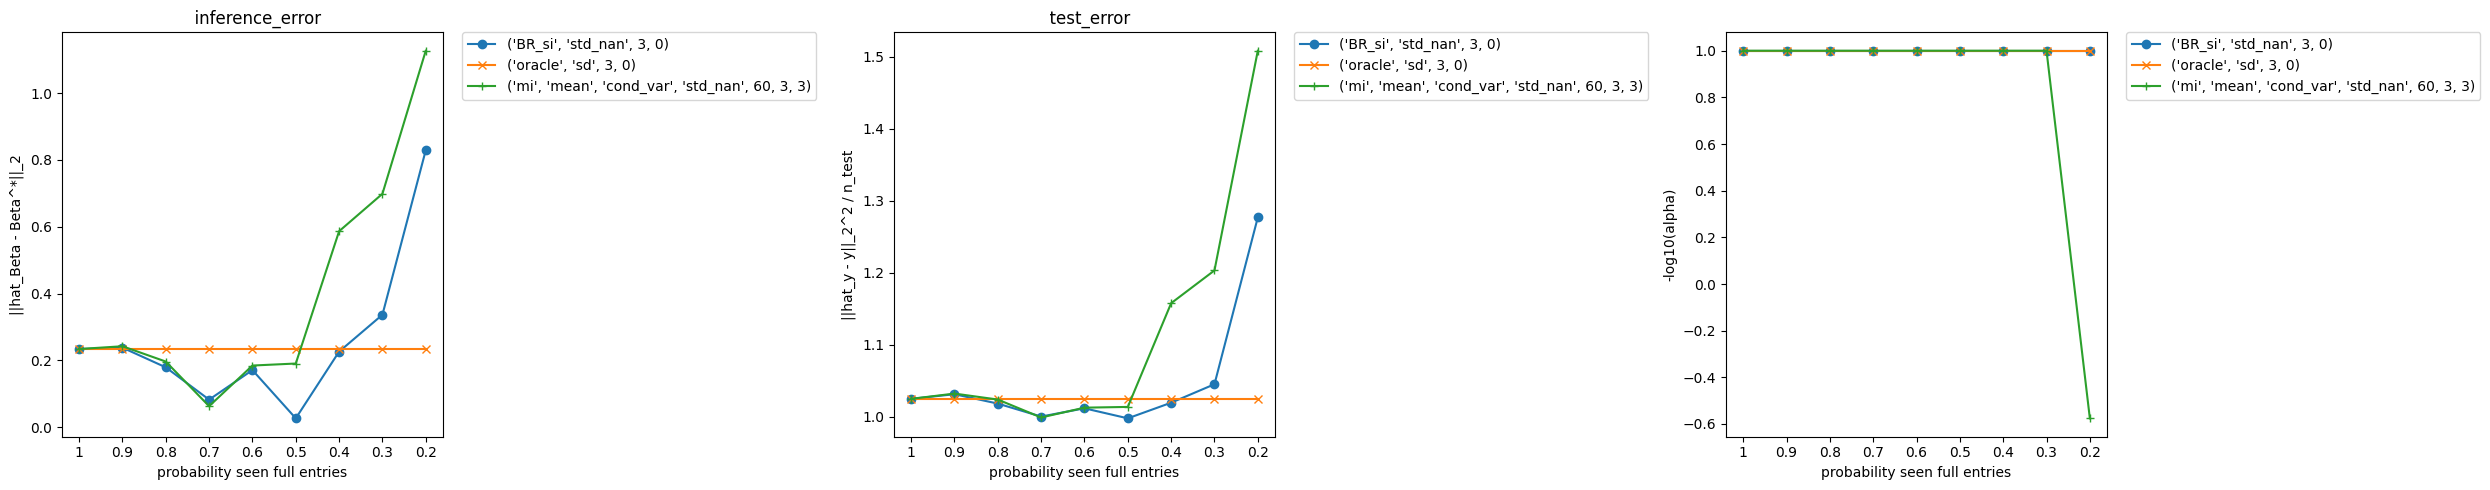

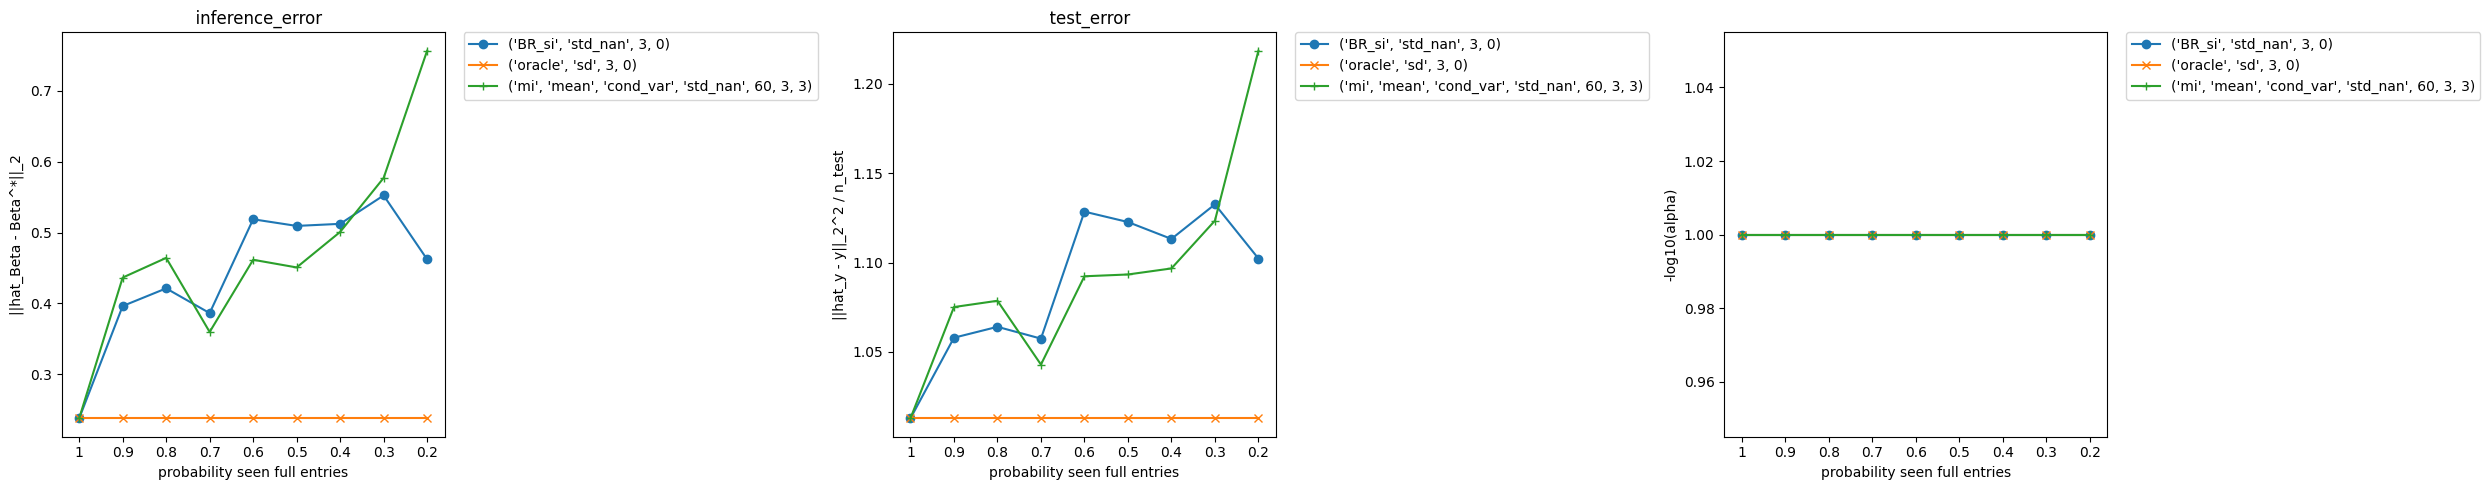

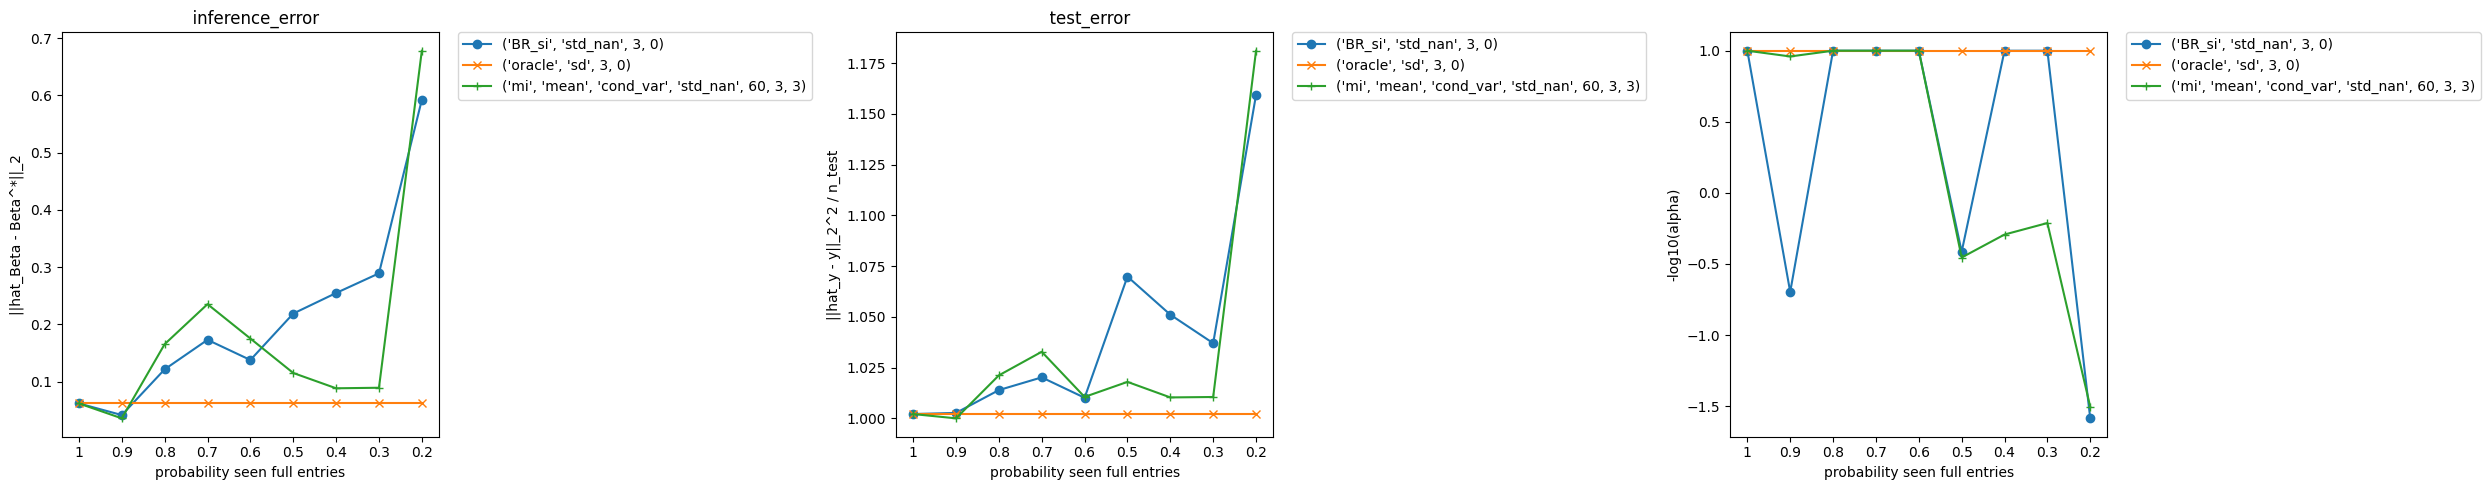

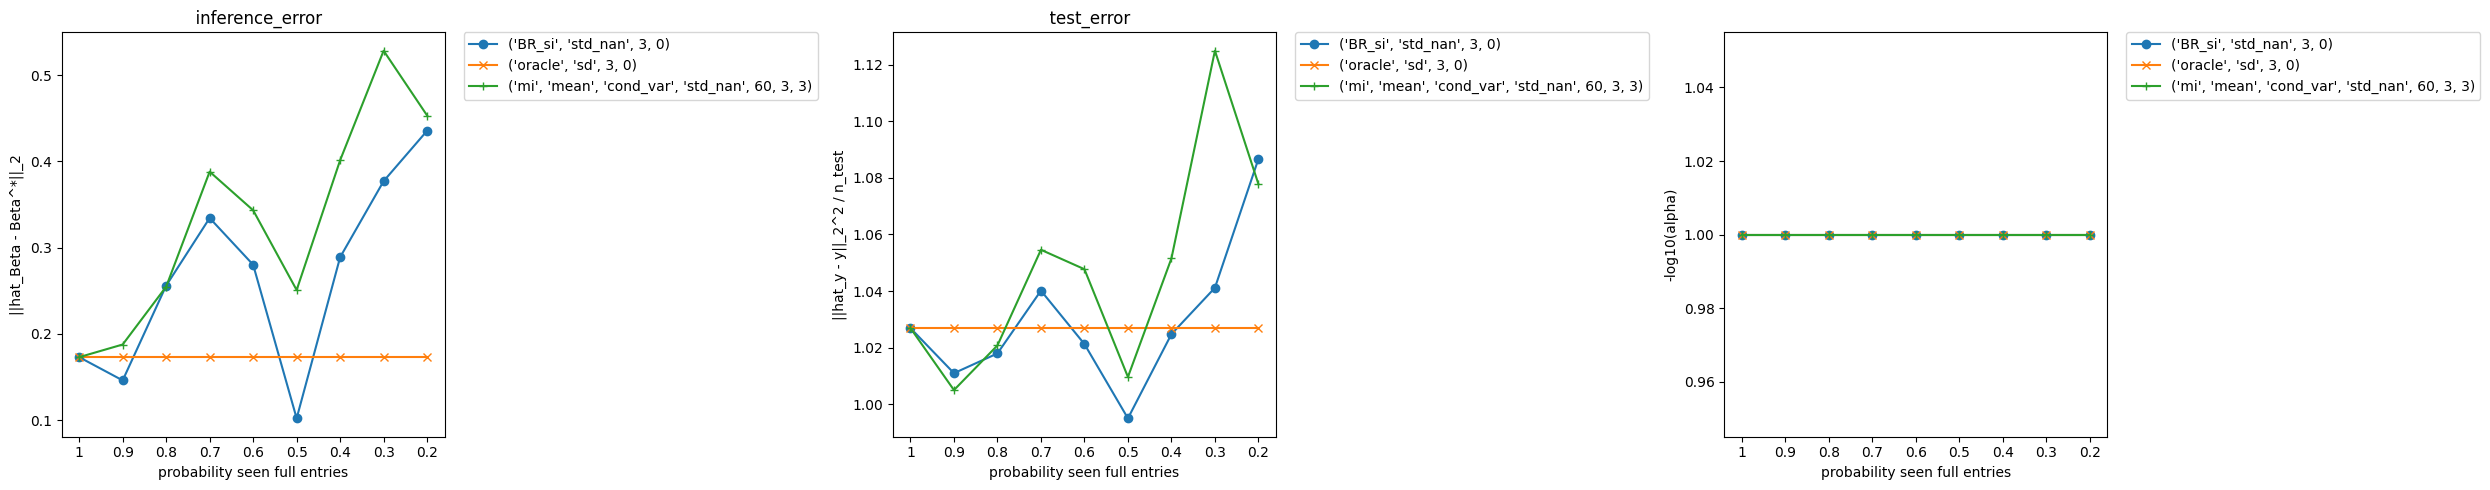

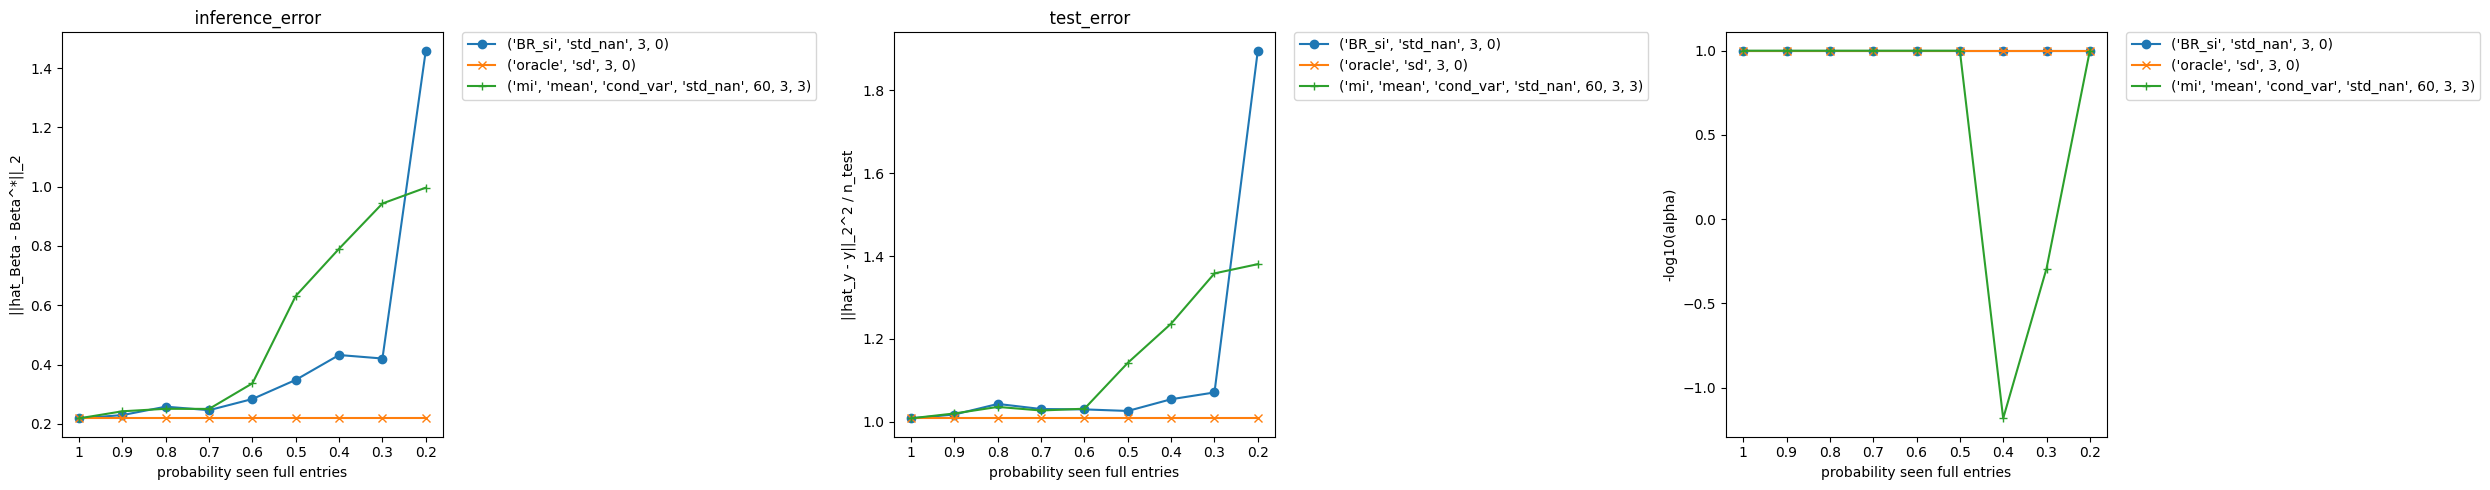

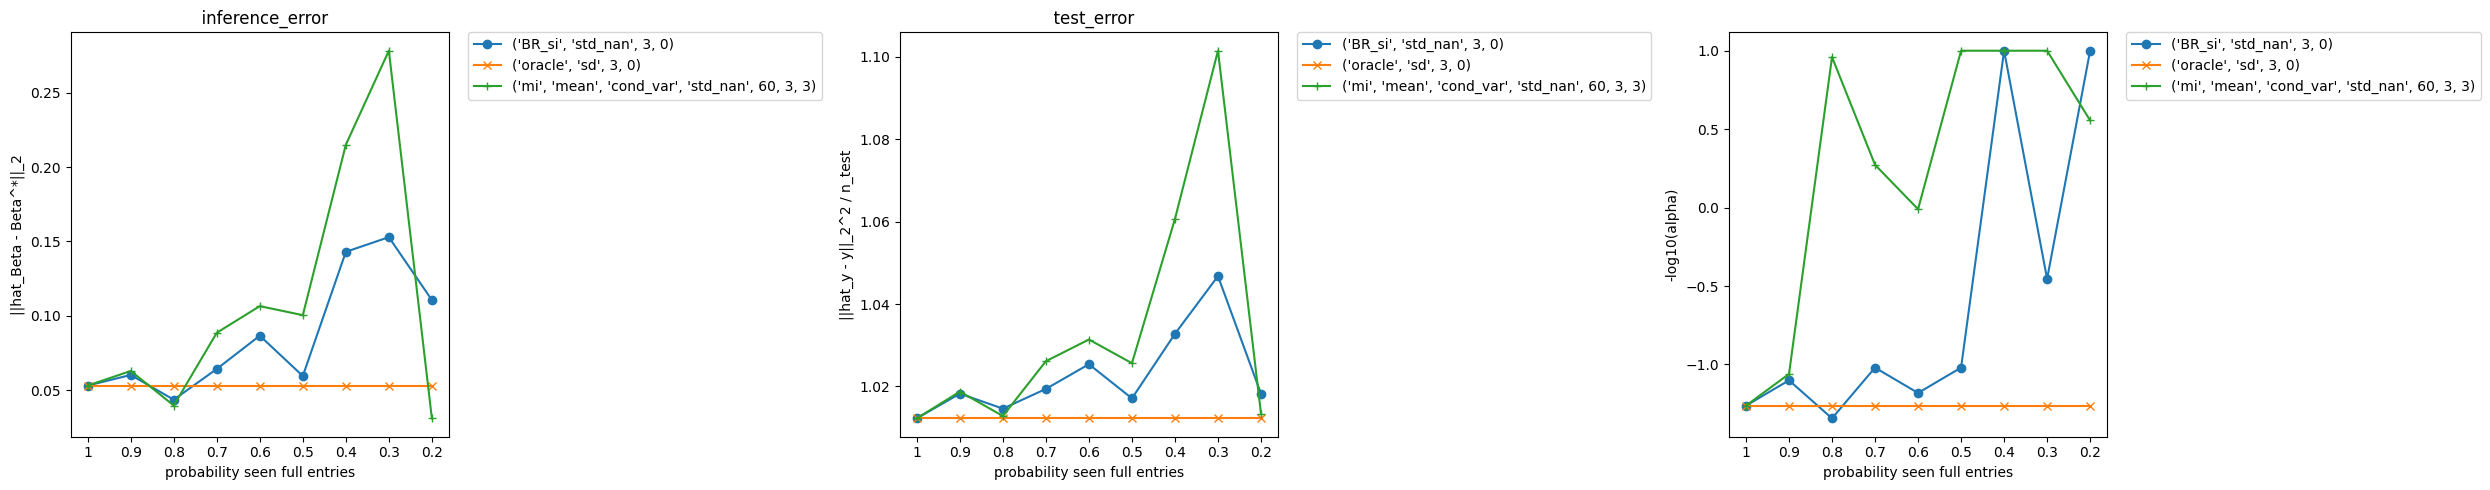

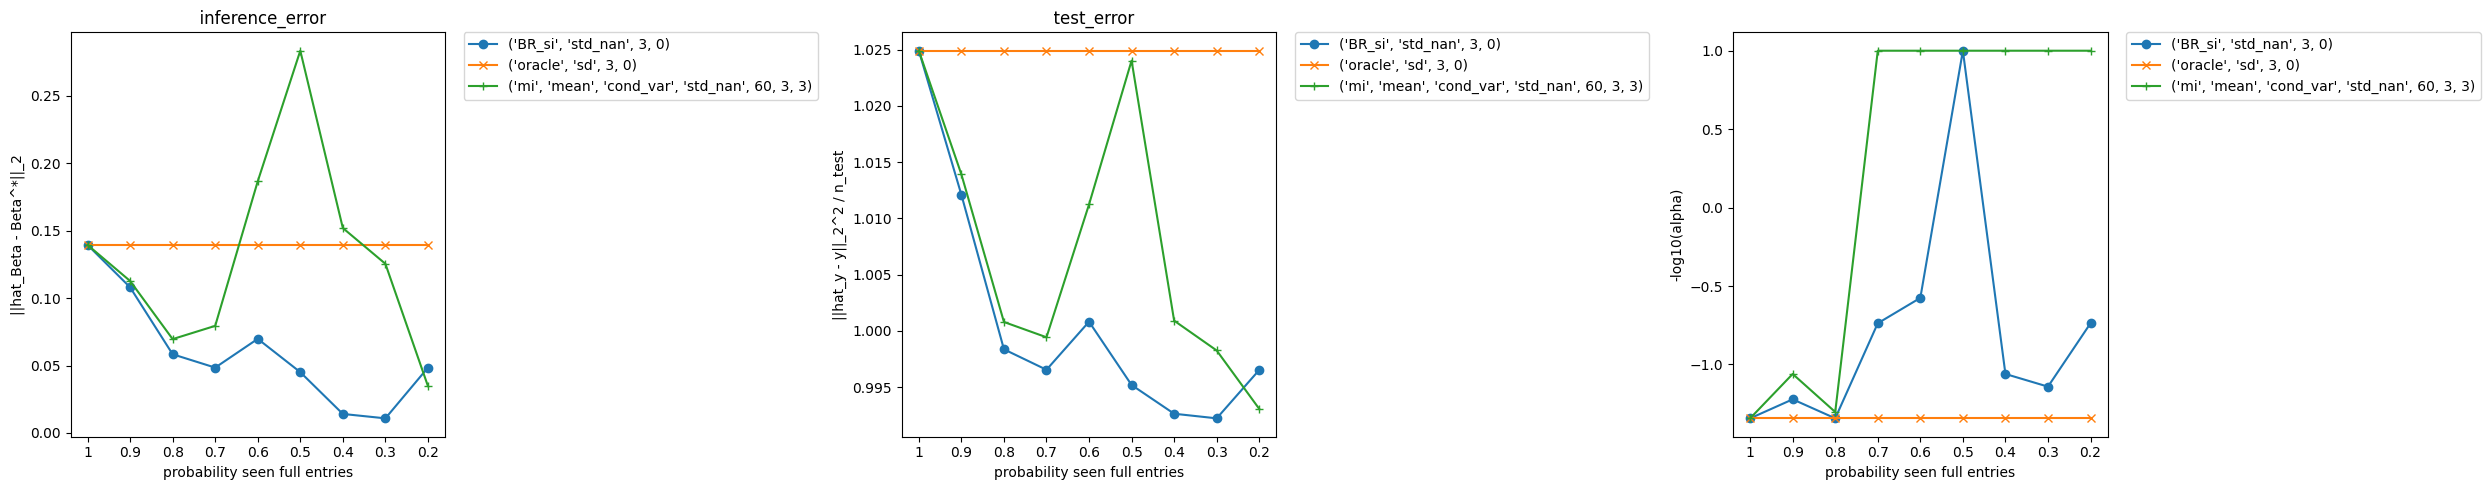

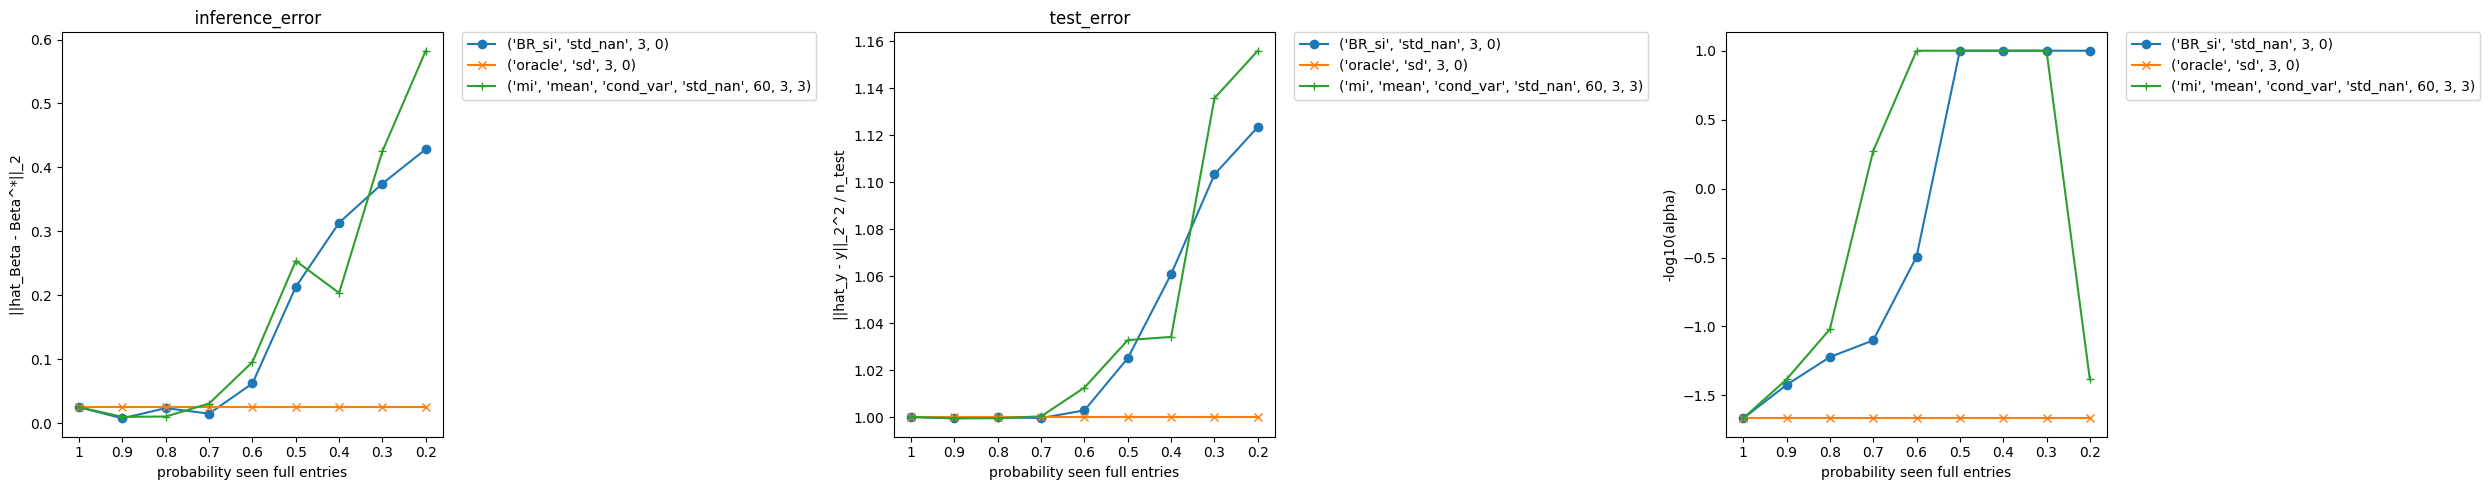

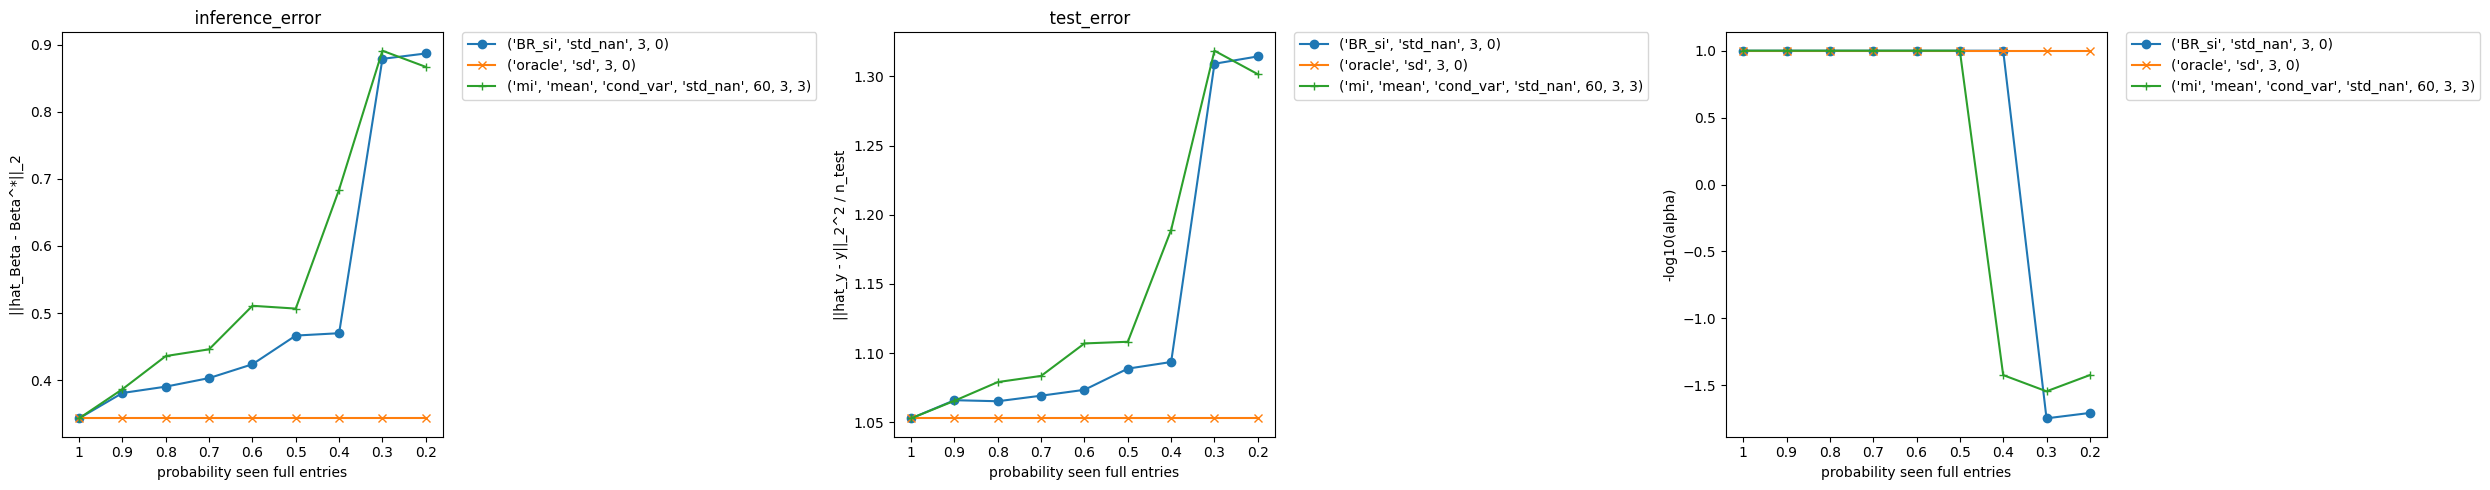

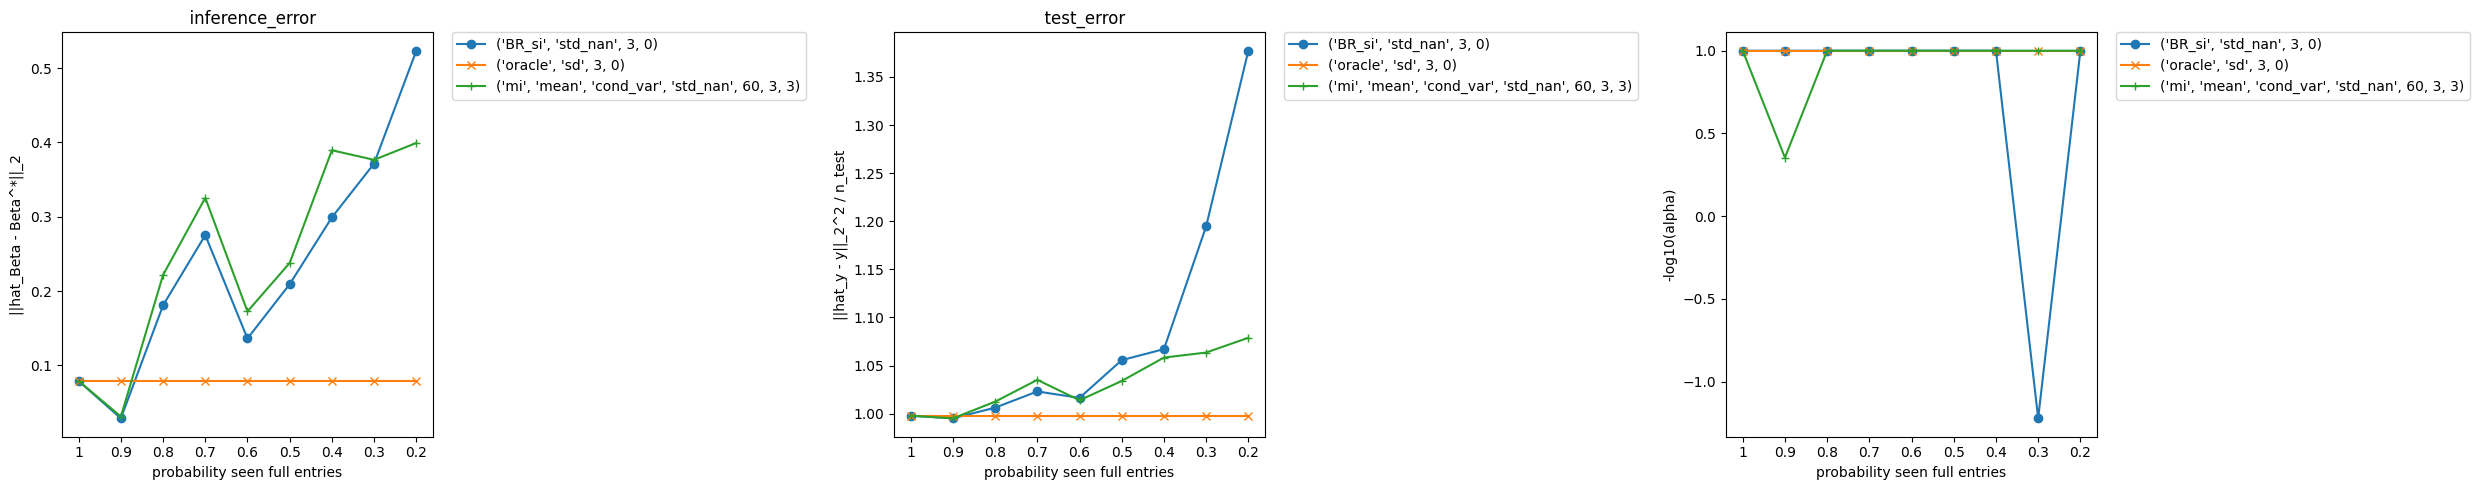

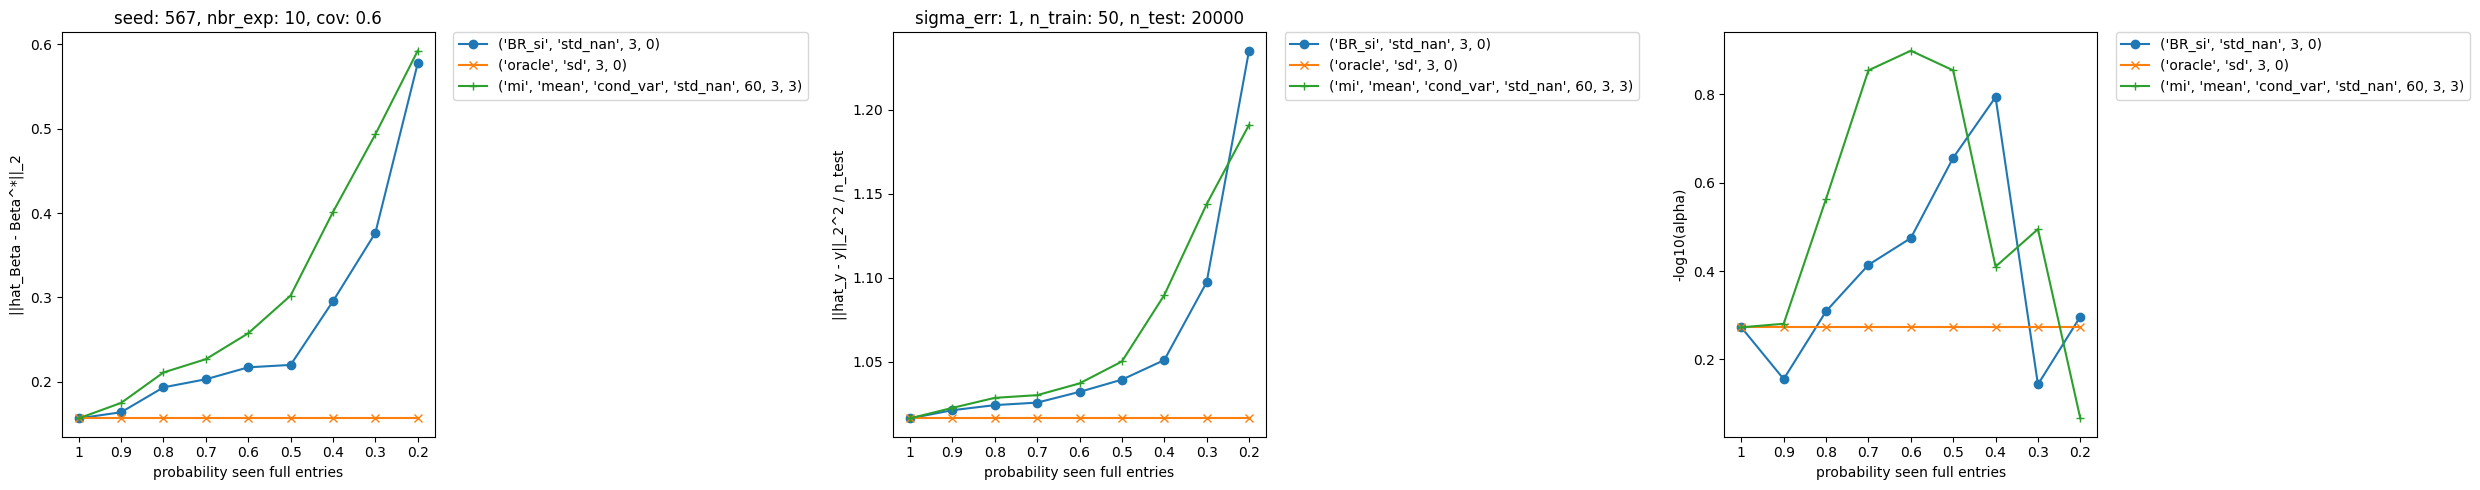

In [ ]:

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
gen = 'fixed'
info_axis = 'p_seen'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
#p_seen_both = [0.1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
n_train = [50] * length_vec
error_vec =  [1] * length_vec
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)
number_test = 20000
cov_var = 0.6

dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=number_test,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, cov_var], [cov_var, 1]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
    plots = []#['points', 'l1_vs_coef', '1/alpha_vs_coef']
)
#dicc = dicc | {'generation':gen}
dicc = dicc | {'generation':gen, 'title_infer_error':'  inference_error', 'title_test_error':'  test_error'}
for key, value in dicc.items():
  print(key,": " , value[0])

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 60
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'eye', 'mi_nbr': 2},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.2},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.4},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.6},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 1},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_mi', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 1},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 3},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")

'''
nbr_exp = 2
#res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
#res[key_tuple]['best_coeff'].append(coeff_round)
#res[key_tuple]['best_score'].append(score_round)
#res[key_tuple]['best_alpha'].append(alpha_round)
res_l2 = []

rdm_seed = 4654321
np.random.seed(rdm_seed)
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)
if nbr_exp > 1:
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
    print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
    #np.random.seed(rdm_seed * (i+2))
    res_partial = run_experiments(dicc, list_methods_strategy)
    plot_res(info_x_axis, res_partial, dicc)
    print(res)
    for k in res:
      res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
      res[k]['best_score'].append(res_partial[k]['best_score'])
      res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
      #res[k]['best_coeff'].append(res_partial[k]['best_coeff
    #res.append(res['l2_dist_best_coeff_gt'])

print("final ")
print(res)
for k in res:
  print(k)
  print(np.array(res[k]['l2_dist_best_coeff_gt']))
  print(np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
  print(np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
#mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
for k, v in mean_res.items():
  print("k:   ", k)
  for s, t in v.items():
    print(s, ": ", t)
#print(np.mean(res, axis=0))
'''
nbr_exp = 10
seed = 567
mean_res = run_multiple_experiments(nbr_exp, seed, dicc, info_x_axis)
print("PLOT OF THE MEANS")
dicc['title_infer_error'] = 'seed: ' + str(seed) + ', nbr_exp: ' + str(nbr_exp) + ', cov: ' + str(cov_var)
dicc['title_test_error'] = 'sigma_err: ' + str(error_vec[0]) + ', n_train: ' + str(n_train[0]) + ', n_test: ' + str(number_test)
#dicc = dicc | {'generation':gen, 'title_infer_error':'mean_infer_error, rep: ' + str(nbr_exp), 'title_mean_error':'mean_test_error'}
plot_res(info_x_axis, mean_res, dicc)

## you can see if you manage to take the index i that maximize alpha




In [ ]:
X = np.random.randint(2, 5, size=(2, 2, 2))
print(X)

XX = np.concatenate(X)
print(XX)


Y = np.random.randint(2, 5, size=(1, 3, 2))
print(Y)

YY = np.concatenate(Y)
print(YY)


Z = np.random.randint(2, 5, size=(5, 2))
print(Z)

ZZ = np.concatenate(Z)
print(ZZ)

print("other")
s = np.random.randint(2, 4, 5)
print(s)
z = np.tile(s, reps=3)  # np.array([s] * 2)
print(z)


print("other mult")
s = np.random.randint(2, 8, size=(3, 2))
print(s)
z = np.tile(s, reps=(3, 1))  # np.array([s] * 2)
print(z)


[[[3 2]
  [3 4]]

 [[2 4]
  [2 2]]]
[[3 2]
 [3 4]
 [2 4]
 [2 2]]
[[[2 3]
  [4 4]
  [2 3]]]
[[2 3]
 [4 4]
 [2 3]]
[[3 3]
 [2 3]
 [2 4]
 [3 2]
 [3 4]]
[3 3 2 3 2 4 3 2 3 4]
other
[2 3 2 3 2]
[2 3 2 3 2 2 3 2 3 2 2 3 2 3 2]
other mult
[[3 4]
 [5 7]
 [6 3]]
[[3 4]
 [5 7]
 [6 3]
 [3 4]
 [5 7]
 [6 3]
 [3 4]
 [5 7]
 [6 3]]


In [ ]:
'''
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)
'''

'\n## random forest imputer\nfrom sklearn.ensemble import RandomForestRegressor\nrf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)\n\nX_rf = single_imputation(X_nan, rf_estimator)\nprint(X_rf.shape)\nsd_rf = np.std(X_rf, axis=0)\nS_inv_rf = np.diag(1 / sd_rf)\nprint("std_orig: \n", np.std(X_orig, axis=0))\nprint("std rf\n ", sd_rf)\nfig, ax = plt.subplots(num=\'advtrain_linf_rf\')\nlinfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)\nestimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_rf, ax)\n'

In [ ]:
'''
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)
'''

'\n## iterative imputer Bayesian Ridge\n\nfrom sklearn.linear_model import BayesianRidge\nbr_estimator = BayesianRidge()\n\nX_br = single_imputation(X_nan, br_estimator)\nsd_br = np.std(X_br, axis=0)\nS_inv_br = np.diag(1 / sd_br)\nprint("std_orig: \n", np.std(X_orig, axis=0))\nprint("std  br\n ", sd_br)\n\nfig, ax = plt.subplots(num=\'advtrain_linf_br\')\nlinfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)\nestimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)\nplot_coefs_l1norm(coefs_advtrain_linf_br, ax)\n'

In [ ]:
'''
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)
'''

"\n## mean imputation\nfrom sklearn.impute import SimpleImputer\n\nimp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')\nX_mean = imp_mean.fit_transform(X_nan)\nsd_mean = np.std(X_mean, axis=0)\nprint(sd_mean)\nS_inv_mean = np.diag(1 / sd_mean)\n\nfig, ax = plt.subplots(num='advtrain_linf_mean')\nlinfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)\nestimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_mean, ax)\n"

In [ ]:
'''
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)
'''

'\n# imputation elliptic\n\nmu = np.nanmean(X_nan, axis=0)\nprint("means ", mu)\ndelta = np.mean(masks) # parameter missingness\nprint("delta ", delta)\nX_0 = np.nan_to_num(X_nan)\nprint("nbr obs", X_0.shape[0])\nS_ellp =  X_0.T @ X_0 / X_0.shape[0]\nS_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp\nprint("eig cov ", np.linalg.eigvalsh(S_ellp))\nX_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)\n#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance\nsd_inv_ellp = np.std(X_ellp, axis=0)\nprint("sd ellp", sd_inv_ellp)\n\nfig, ax = plt.subplots(num=\'advtrain_linf_ellp\')\nlinfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)\nestimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)\n'

TypeError: add_rectangles() takes 4 positional arguments but 5 were given

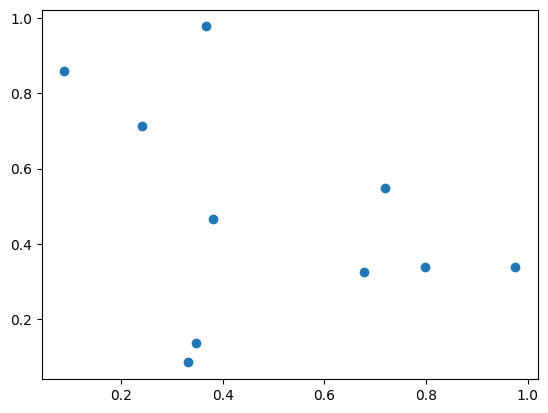

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


# Example data
x_test_rect = np.random.rand(10)
y_test_rect = np.random.rand(10)

# Plot the points
fig, ax = plt.subplots()
ax.scatter(x_test_rect, y_test_rect)

width = 0.1
height = 0.1

add_rectangles(x_test_rect, y_test_rect, width, height, ax)

# Add the rectangle to the plot


In [ ]:
# Cell for some tests

def test_clear_dataset(n, d):
  print("test clear dataset")
  X = np.random.randint(1, 3, size=(n, d))
  y = np.random.randint(1, 3, size=n)
  masks = np.random.binomial(1, 0.3, size=(n, d))
  print("X \n", X)
  print("y\n", y)
  print("masks \n", masks)
  masks[:, 0] = np.ones(n)
  masks[0, :] = np.ones(d)
  X_res, y_res, masks_res = clear_dataset(X, y, masks)
  print("X_res \n", X_res)
  print("y\n", y_res)
  print("masks \n", masks_res)
  print("test clear dataset ended successfully")

def test_generate_X():
    print("test generate_X started")
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf')
    gen = generate_X('circles', 2)
    data = gen(1000)
    print(data.shape)
    ax[0].scatter(data[:, 0], data[:, 1])
    print("test generate passed syccessfully")

def test_preparation_dataset(n, d):
      print("\ntest preparation dataset started")
      X_train = np.random.rand(n, d)
      print("X_train \n", X_train)
      mask = np.random.binomial(1, 0.5, (n, d))
      print("mask, 0 seen, 1 missing \n ", mask)
      X_masked = X_train * (1 - mask)
      print("X_masked \n", X_masked)
      X_nan_train = X_train.copy()
      X_nan_train[mask == 1] = np.nan
      print("X_nan_train \n", X_nan_train)
      X_br_train = single_imputation(X_nan_train, BayesianRidge())
      print("X_br_train\n ", X_br_train)

      print("what happens if we run single_imputation of full dataset")
      X_br_full = single_imputation(X_train, BayesianRidge())
      print("X_br_full\n ", X_br_full)
      np.testing.assert_allclose(X_train, X_br_full)  # shuold be untouched
      print("test preparation dataset ended successfully")

def test_listwise_delection(n, d):
    print("\n test list_wise delection started")
    X = np.random.rand(n, d)
    print("data\n", X)
    mask = np.random.binomial(1, 0.2, (n, d))
    print("mask \n", mask)
    X_ld = listwise_delection(X, mask)
    print("after calling function, X_ld \n", X_ld)

    print("edge cases, all missing")
    mask_1 = np.ones_like(X)  # all missing
    X1 = listwise_delection(X, mask_1)
    print("X1 \n", X1)  # should be empty
    mask_0 = np.zeros_like(X)  # all seen
    X0 = listwise_delection(X, mask_0)
    print("X0 \n", X0)
    np.testing.assert_allclose(X0, X)  # should be the original dataset

    print("one dimnsional array")
    y = np.random.rand(n)
    print("y before ", y)
    y_ld = listwise_delection(y, mask)
    print("y after ld ", y_ld)
    print("test listwise_delection passed")


test_generate_X()
test_preparation_dataset(3, 4)
test_listwise_delection(3, 4)
test_clear_dataset(6, 3)

xxx = np.random.randint(2, 5, size=(3, 3)) * 1.0
mmm = np.random.binomial(1, 0.5, size=(3, 3))
print(xxx)
print(mmm)
print(mmm == 1)
print(xxx[mmm == 1])
xxx[mmm == 1] = np.nan
print(xxx)
mask_from_xxx = np.isnan(xxx).astype(int)
print("mask from xxx \n", mask_from_xxx)


In [ ]:
# test best predictor

def test_best_predictor(n, d, nb_coeff):
  X_test = np.random.randint(1, 9, size=(n, d))
  beta_gt_test = np.random.randint(1, 7, size=d)
  y_test = X_test @ beta_gt_test
  #print("X_test \n", X_test, "\n beta_gt", beta_gt_test, "\n y_test = X_test @ beta_gt_test ", y_test)
  coeff_test = np.random.randint(1, 5, size=(d, nb_coeff))
  rdm_idx = np.random.randint(1, d+1, size=1)
  print(rdm_idx)
  #print("coeff test partial ", coeff_test[:, -1])
  rng = np.arange(nb_coeff)
  #print(rng != rdm_idx)
  coeff_test[:, rng != rdm_idx] = coeff_test[:, rng != rdm_idx] + 1000  # increase artificially the value of the other coefficient, to induce the minimum index to be rdm_idx
  #print("coeff_test \n", coeff_test)
  best_coeff, best_score = best_predictor(X_test, coeff_test, y_test)
  print("best coeff ", best_coeff)
  print("best score ", best_score)
  np.testing.assert_allclose(best_coeff, coeff_test[:,rdm_idx].squeeze())
  print("test best predictor passed")

test_best_predictor(100, 5, 20)




In [ ]:
# test train_and_plot

X_diab, y_diab = datasets.load_diabetes(return_X_y=True)
n, d = X_diab.shape
print("n:  ", n, ", d: ", d)
# Standardize data
X_diab -= X_diab.mean(axis=0)
X_diab /= X_diab.std(axis=0)

## original lasso
fig_l, ax_l = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_diab, y_diab)
plot_coefs_l1norm(coefs_lasso, ax_l)

## Antonio's algo, 1 matrix
S_diab_eye = np.eye(X_diab.shape[1])
fig, ax_1 = plt.subplots(1, 1, num='advtrain_linf_diab')
fig, ax_2 = plt.subplots(1, 1, num='advtrain_linf_diab_2')
train_and_plot(X_diab, y_diab, S_diab_eye, [ax_1, ax_2])

## Antonio's algo, multiple diagonal matrix
#S_diab = np.eye(X_diab.shape[1])
#S_diab = np.random.randint(1, 3, size=(n, d))
#print(S_diab)
#fig, ax_5 = plt.subplots(1, 1, num='advtrain_linf_diab_5')
#fig, ax_6 = plt.subplots(1, 1, num='advtrain_linf_diab_6')
#train_and_plot(X_diab, y_diab, S_diab, [ax_5, ax_6])


## Antonio's algo, multiple matrices (same matrix stacked multiple time)
S_diab_stacked = np.array([S_diab_eye] * X_diab.shape[0])
S_diab_stacked = np.concatenate(S_diab_stacked)
fig, ax_3 = plt.subplots(1, 1, num='advtrain_linf_diab_3')
fig, ax_4 = plt.subplots(1, 1, num='advtrain_linf_diab_4')
train_and_plot(X_diab, y_diab, S_diab_stacked, [ax_3, ax_4])




In [ ]:
# test imputations

np.random.seed(45)


def test_imputations(n, d):
  X = np.random.randint(2, 5, size=(n, d)) * 1.0
  y = X @ np.random.randint(1, 3, size=d)
  m = np.random.binomial(1, 0.4, size=(n, d))  # 1 missing, 0 seen
  print("m original\n", m)
  X, y, m = clear_dataset(X, y, m)
  print(m)
  X_nan = X.copy()
  X_nan[m == 1] = np.nan

  #mask_from_xxx = np.isnan(xxx).astype(int)
  print("X\n ", X)
  print("masks \n", m)
  print("X_nan\n ", X_nan)
  methods = ['BR_si', 'mi', 'l_d']
  nbr_mi = [1, 3]
  #for method in methods:
  #  dict_info = {'imp_method': method, 'mi_nbr':nbr_mi}
  #dict_info = {'imp_method':methods, 'mi_nbr':nbr_mi}
  for method in methods:
    print("---------- method: ", method)
    if method == 'mi':
      for x in nbr_mi:
        print("-------------------- nbr mi: ", x)
        dict_info = {'imp_method':method, 'mi_nbr':x}
        #print("XNANNANAN ", X_nan)
        X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
        print(X_res, y_res, "\n", mask_res)
    else:
      dict_info = {'imp_method': method}
      X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
      print(X_res, y_res, "\n", mask_res)
    print("test imputations ended successfully")

test_imputations(6, 3)


In [ ]:
x = []
y = np.array([1, 2])
x.append(y)
x.append(y)
x.append(y)
xx = np.stack(x)
print(x)
print(xx)
print(type(xx))


import matplotlib.pyplot as plt

sizes = [100, 1000, 10000, 100000]
values = [0.8, 0.85, 0.9, 0.92]
positions = range(len(sizes))

plt.plot(positions, values, marker='o', label='Model Accuracy')  # Add label here
plt.xticks(positions, sizes)

plt.xlabel("Dataset Size (equispaced)")
plt.ylabel("Accuracy")
plt.title("Performance vs Dataset Size (equispaced x-axis)")
#plt.legend()  # Show legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()



In [ ]:

dictio = {'a':1, 'b':2, 'c':3}
vv = dictio.values()
#print(vv)
#print(vv[1])

x1 = np.array([1, 2, 3])
x2 = np.array([3, 2 ,1])
v = np.maximum(x1, x2)
print(v)


In [ ]:
m, n, d = 2, 3, 2
x_int = np.random.randint(1, 9, (m, n, d))
print(x_int)
s = np.std(x_int, axis=0)
print(s)

# manual
print("manual computation")
x = np.zeros((m, d))
for i in range(n):
  print("i -----> ", i)
  x = x_int[:, i, :]
  print("x\n", x)
  ss = np.std(x, axis=0)
  print(ss)


print("little exp on squeeze")
sss = np.random.rand(1, 3, 3)
print(sss)
print(sss.squeeze())
print(sss.squeeze())



In [ ]:
int(34.99)

xxxx = np.random.randint(2, 4, (5, 2))
print(xxxx)
xxxx[0:2, :] = 1
print(xxxx)

print("yyyy\n")
yy = []
yy.append([1, 2, 3])
yy.append([4, 5, 6])
print(yy)
print(np.stack( yy ).T)
print("\n\n")
yyy = np.random.randint(1, 10, size=(3 , 3))
print(yyy)
yyy_a = np.array([yyy] * 2)
print(yyy_a.shape)
print(np.concatenate([yyy] * 2))
#print(np.tile(yyy_a, (2, 1, 1) ))

zzz = np.zeros((2, 2))

np.sum(np.zeros((2, 2)) == zzz)

In [ ]:

def multiple_imputation1(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


Xx = np.random.randint(1, 3, (4, 4)) * 1.0
mm = np.random.binomial(1, 0.25, (4, 4))
print(Xx)
print(mm)
Xx[mm == 1] = np.nan
print(Xx)

ice = IterativeImputer(random_state=18, max_iter=50, sample_posterior=True)
ice.fit(Xx)
XxX = np.random.randint(1, 3, (2, 4)) * 1.0
mmM = np.random.binomial(1, 0.5, (2, 4))
print(XxX)
print(mmM)
XxX[mmM == 1] = np.nan
print(XxX)

print(ice.transform(XxX))
print(ice.transform(XxX))

print("new")

ls = [[[]],[[]]]
print(ls)
ls[0][0]

